In [5]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests8 as vuong_tests_fast

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


In [7]:
nsims= 700
trials =1000
skip_boot=False
skip_shi=False
refinement_test=True
linspace=40
smoothing =5
adapt_c= True

In [8]:
def create_fig(params,res,name='test.png'):
    results2 = np.array(res)
    
    col_labels = ['Param','Vuong 1 Step','Vuong 2 Step', 'Refinement Test','Shi (2015)', 'Naive Bootstrap','Bootstrap TIC','Bootstrap ND']



    np_results = np.concatenate((params.reshape(params.shape[0],1),results2[:,:,0]),axis=1)
    df_results = pd.DataFrame(data=np_results,columns=col_labels)
    df_results.to_csv("paper_figs5/"+name[:-4]+".csv")
    
    ma2 = lambda x : np.convolve(x,np.ones(smoothing)/smoothing, mode='valid')
    params_new = np.linspace( ma2(params).min(),  ma2(params).max(), 300) 
    interp = lambda x: make_interp_spline(ma2(params), ma2(x), k=3)(params_new)


    plt.plot(params_new, interp(1-results2[:,0,0]) ,label='Vuong 1 Step')
    plt.plot(params_new, interp(1-results2[:,1,0]) ,label='Vuong 2 Step')
    
    if not skip_boot:
        plt.plot(params_new,interp(1-results2[:,4,0]),label='Naive Bootstrap')
        plt.plot(params_new,interp(1-results2[:,6,0]),label='Bootstrap ND')
        
    if not skip_shi:
        plt.plot(params_new,interp(1-results2[:,3,0]),label='Shi (2015)')

    plt.legend()
    plt.savefig('paper_figs6/'+name,dpi=300)
    plt.show()



In [9]:
nobs = 100

#c1 corresponds to bn
#c2 corresponds to cn

def mc_run_size(nobs,c1,c2):
    betas = np.linspace(0,3,linspace)
    results = []

    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
        gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
        reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])
        print(beta,boot3)

    name = 'size_nobs%s_c1%s_c2%s_nobs%s_trials%s.png'%(nobs,c1,c2,nobs,trials)
    create_fig(betas,results,name=name)

In [10]:
def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

def mc_run_power(nobs,c1,c2):
    betas = np.linspace(0,3,linspace)
    results = []
    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
        gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
        reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

    name = 'power_nobs%s_c1%s_c2%s_nobs%s_trials%s.png'%(nobs,c1,c2,nobs,trials)
    create_fig(betas,results,name=name)

# Size stuff

Quantiles: 1th: 0.56, 5th: 1.68, 10th: 3.12, 30th: 9.82, 50th: 17.04, 70th: 25.26, 90th: 39.86, 95th: 47.64, 99th: 61.12
bonus term 1.7882494951405208 // variance stats 11.98918889313516 //part1 23.22791048043381 //part2 12.98918889313516 11.98918889313516
-0.08991152036912123 -0.6785501318322552 3.670079502214557
-3.666410510650163 -0.6785501318322552 0.09358051193351538
---
Quantiles: 1th: 0.74, 5th: 1.85, 10th: 3.09, 30th: 8.48, 50th: 14.71, 70th: 22.51, 90th: 35.59, 95th: 42.45, 99th: 55.09
bonus term 0.635273521008844 // variance stats 35.5636370984687 //part1 23.22791048043381 //part2 36.5636370984687 35.5636370984687
-1.2312144144849784 0.5233427743557824 2.5427101744150615
-2.5017614565026665 0.5233427743557824 1.2721631323973737
---
Quantiles: 1th: 0.86, 5th: 1.98, 10th: 3.65, 30th: 10.16, 50th: 17.45, 70th: 26.94, 90th: 42.66, 95th: 51.07, 99th: 66.70
bonus term 1.8235034669148196 // variance stats 11.738067627440842 //part1 23.22791048043381 //part2 12.738067627440843 11.738

Quantiles: 1th: 0.74, 5th: 1.88, 10th: 3.10, 30th: 8.72, 50th: 15.64, 70th: 23.62, 90th: 36.74, 95th: 43.86, 99th: 58.22
bonus term 6.224732664948957 // variance stats 2.7315514947699815 //part1 23.22791048043381 //part2 3.731551494769981 2.7315514947699815
4.752978654925916 -2.902561685182313 7.612060809836549
-7.696486674971998 -2.902561685182313 -4.837404520061364
---
Quantiles: 1th: 0.53, 5th: 1.29, 10th: 2.27, 30th: 6.89, 50th: 12.31, 70th: 18.66, 90th: 29.74, 95th: 34.90, 99th: 45.82
bonus term 0.8838142829789851 // variance stats 25.281438224942228 //part1 23.22791048043381 //part2 26.28143822494223 25.281438224942228
-0.9446398185788508 0.3338883759605035 2.7649907100303404
-2.712268384536821 0.3338883759605035 0.9973621440723701
---
Quantiles: 1th: 0.81, 5th: 1.87, 10th: 3.32, 30th: 9.08, 50th: 15.86, 70th: 24.35, 90th: 38.95, 95th: 45.72, 99th: 61.70
bonus term 1.6948776394479732 // variance stats 12.70477132968679 //part1 23.22791048043381 //part2 13.70477132968679 12.704771

Quantiles: 1th: 0.78, 5th: 1.99, 10th: 3.34, 30th: 10.02, 50th: 17.41, 70th: 26.94, 90th: 42.22, 95th: 49.92, 99th: 64.15
bonus term 2.0888377859511214 // variance stats 10.120016420929172 //part1 23.22791048043381 //part2 11.120016420929172 10.120016420929172
0.3317131530428797 -1.0014616552320919 3.8196642822975204
-3.845962418859363 -1.0014616552320919 -0.35801128960472267
---
Quantiles: 1th: 0.55, 5th: 1.67, 10th: 3.08, 30th: 9.01, 50th: 15.76, 70th: 24.00, 90th: 38.10, 95th: 46.30, 99th: 61.13
bonus term 3.767828294590535 // variance stats 5.164800692691354 //part1 23.22791048043381 //part2 6.164800692691354 5.164800692691354
1.9451108695930053 -1.82759172629273 5.395965610199153
-5.590545719588064 -1.82759172629273 -2.1396909789819167
---
Quantiles: 1th: 0.71, 5th: 1.95, 10th: 3.69, 30th: 12.14, 50th: 21.04, 70th: 32.62, 90th: 52.26, 95th: 60.90, 99th: 79.58
bonus term 0.8093103615064429 // variance stats 27.700868770786016 //part1 23.22791048043381 //part2 28.70086877078602 27.7

Quantiles: 1th: 0.62, 5th: 1.51, 10th: 2.67, 30th: 7.59, 50th: 13.24, 70th: 21.12, 90th: 33.44, 95th: 39.97, 99th: 52.78
bonus term 0.3618359192974438 // variance stats 63.19459551040184 //part1 23.22791048043381 //part2 64.19459551040184 63.19459551040184
-1.5737774579282322 1.3493024962733107 2.38195100265733
-2.2974492965231197 1.3493024962733107 1.6582791640624421
---
Quantiles: 1th: 0.77, 5th: 2.13, 10th: 3.71, 30th: 11.59, 50th: 20.34, 70th: 31.09, 90th: 49.32, 95th: 58.17, 99th: 77.98
bonus term 2.399095239185229 // variance stats 8.681945969065563 //part1 23.22791048043381 //part2 9.681945969065563 8.681945969065563
0.5574447708829181 -1.9689036610933301 4.091061023640123
-4.24074570748754 -1.9689036610933301 -0.7071294547303361
---
Quantiles: 1th: 0.63, 5th: 1.67, 10th: 2.93, 30th: 8.67, 50th: 14.92, 70th: 23.41, 90th: 37.05, 95th: 43.65, 99th: 57.08
bonus term 1.8026725690426246 // variance stats 11.885263180528586 //part1 23.22791048043381 //part2 12.885263180528588 11.88526

Quantiles: 1th: 0.75, 5th: 1.77, 10th: 2.84, 30th: 7.74, 50th: 13.45, 70th: 20.52, 90th: 32.91, 95th: 39.25, 99th: 51.72
bonus term 0.7465154702489518 // variance stats 30.11510933951261 //part1 23.22791048043381 //part2 31.115109339512614 30.11510933951261
-1.0366361151504127 0.3723376336996356 2.5962675400458277
-2.5296670556483165 0.3723376336996356 1.103236599547924
---
Quantiles: 1th: 0.78, 5th: 1.95, 10th: 3.43, 30th: 10.74, 50th: 18.51, 70th: 28.51, 90th: 45.73, 95th: 54.30, 99th: 70.31
bonus term 1.705131771926685 // variance stats 12.622355094696182 //part1 23.22791048043381 //part2 13.622355094696184 12.622355094696182
0.04709393576219177 -0.8991086707831452 3.5263125498116907
-3.3631696080911784 -0.8991086707831452 0.11604900595832086
---
Quantiles: 1th: 0.82, 5th: 2.12, 10th: 3.65, 30th: 10.32, 50th: 18.39, 70th: 28.39, 90th: 44.41, 95th: 53.44, 99th: 70.38
bonus term 0.5195083094467849 // variance stats 43.71133581129587 //part1 23.22791048043381 //part2 44.71133581129586 

Quantiles: 1th: 0.77, 5th: 2.18, 10th: 3.65, 30th: 10.31, 50th: 17.83, 70th: 27.64, 90th: 43.45, 95th: 50.57, 99th: 66.32
bonus term 8.433104432864182 // variance stats 1.7543724455627054 //part1 23.22791048043381 //part2 2.7543724455627054 1.7543724455627054
7.053569667777029 -5.180193923007171 9.774589330997777
-9.812639197951334 -5.180193923007171 -7.091619534730587
---
Quantiles: 1th: 0.75, 5th: 2.00, 10th: 3.41, 30th: 10.19, 50th: 17.76, 70th: 27.56, 90th: 43.45, 95th: 51.01, 99th: 67.77
bonus term 0.8920717352709325 // variance stats 25.03816437853983 //part1 23.22791048043381 //part2 26.03816437853983 25.03816437853983
-0.9898292510967717 -0.23633061024716703 2.7768723317022177
-2.7739727216386365 -0.23633061024716703 0.9927288611603525
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.65, 5th: 1.79, 10th: 3.03, 30th: 8.96, 50th: 15.60, 70th: 24.60, 90th: 39.43, 95th: 47.64, 99th: 61.53
bonus term 1.3050963078997626 // variance stats 16.797851652659656 //part1 23.227910480433

Quantiles: 1th: 0.83, 5th: 2.10, 10th: 3.44, 30th: 10.04, 50th: 17.10, 70th: 26.57, 90th: 42.87, 95th: 50.51, 99th: 67.43
bonus term 1.1764568254760268 // variance stats 18.743954879972033 //part1 23.22791048043381 //part2 19.743954879972033 18.743954879972033
-0.7686824280831039 -0.7712131730810821 3.031549760058566
-3.1215960790351573 -0.7712131730810821 0.6786361091065126
---
Quantiles: 1th: 0.60, 5th: 1.74, 10th: 2.90, 30th: 8.32, 50th: 14.69, 70th: 22.65, 90th: 36.10, 95th: 42.79, 99th: 57.21
bonus term 0.4609988209503483 // variance stats 49.386051817984075 //part1 23.22791048043381 //part2 50.38605181798407 49.386051817984075
-1.4927864350900095 0.6385602838706766 2.372496508710113
-2.414784076990706 0.6385602838706766 1.4504988668094165
---
Quantiles: 1th: 0.78, 5th: 2.11, 10th: 3.56, 30th: 10.51, 50th: 18.77, 70th: 28.93, 90th: 46.13, 95th: 54.77, 99th: 70.62
bonus term 0.536373205843364 // variance stats 42.30550114618703 //part1 23.22791048043381 //part2 43.30550114618703 42

Quantiles: 1th: 0.83, 5th: 2.16, 10th: 3.98, 30th: 12.02, 50th: 20.68, 70th: 31.86, 90th: 50.34, 95th: 60.03, 99th: 80.68
bonus term 0.3607114968757585 // variance stats 63.39470513587291 //part1 23.22791048043381 //part2 64.39470513587291 63.39470513587291
-1.651912142534148 0.6929006795027604 2.2144440146416797
-2.3733351362856654 0.6929006795027604 1.4930210208901629
---
Quantiles: 1th: 0.65, 5th: 1.85, 10th: 3.23, 30th: 9.32, 50th: 15.62, 70th: 23.88, 90th: 38.04, 95th: 44.56, 99th: 60.85
bonus term 0.5823241575053515 // variance stats 38.88828246442849 //part1 23.22791048043381 //part2 39.88828246442849 38.88828246442849
-1.40769876813883 0.25339052293635983 2.5576063919563445
-2.5723470831495328 0.25339052293635983 1.3929580769456413
---
Quantiles: 1th: 0.72, 5th: 1.79, 10th: 3.23, 30th: 9.61, 50th: 16.82, 70th: 26.55, 90th: 41.65, 95th: 49.99, 99th: 63.75
bonus term 0.4316826419470263 // variance stats 52.80783988827656 //part1 23.22791048043381 //part2 53.807839888276554 52.807

Quantiles: 1th: 0.72, 5th: 1.78, 10th: 3.24, 30th: 9.50, 50th: 16.52, 70th: 25.83, 90th: 41.10, 95th: 49.00, 99th: 63.05
bonus term 0.5724408745265979 // variance stats 39.57696002166691 //part1 23.22791048043381 //part2 40.57696002166692 39.57696002166691
-1.460617343599702 0.3790652182417572 2.5293334663587905
-2.605499092652898 0.3790652182417572 1.384451717305595
---
Quantiles: 1th: 0.73, 5th: 1.92, 10th: 3.46, 30th: 9.85, 50th: 17.69, 70th: 27.29, 90th: 43.03, 95th: 50.93, 99th: 67.10
bonus term 3.0649582941669693 // variance stats 6.578540473010569 //part1 23.22791048043381 //part2 7.578540473010569 6.578540473010569
1.1349707237979474 -2.6211996876921013 4.774542466596031
-4.994945864535992 -2.6211996876921013 -1.3553741217379074
---
Quantiles: 1th: 0.74, 5th: 1.70, 10th: 3.03, 30th: 8.93, 50th: 15.92, 70th: 23.95, 90th: 37.50, 95th: 44.55, 99th: 57.99
bonus term 3.6862344766570487 // variance stats 5.301256913395972 //part1 23.22791048043381 //part2 6.301256913395972 5.30125691

Quantiles: 1th: 0.79, 5th: 2.05, 10th: 3.82, 30th: 10.93, 50th: 18.86, 70th: 29.05, 90th: 45.80, 95th: 55.19, 99th: 72.63
bonus term 0.7145730455346879 // variance stats 31.50599868772442 //part1 23.22791048043381 //part2 32.50599868772442 31.50599868772442
-1.2346915071077782 -0.3160141692340989 2.5675694163840803
-2.663837598177154 -0.3160141692340989 1.1384233253147047
---
Quantiles: 1th: 0.67, 5th: 1.94, 10th: 3.68, 30th: 11.11, 50th: 20.10, 70th: 30.90, 90th: 48.41, 95th: 57.85, 99th: 76.85
bonus term 0.32048171143040893 // variance stats 71.4781154492731 //part1 23.22791048043381 //part2 72.4781154492731 71.4781154492731
-1.609105558008815 0.8166111152158669 2.3931963343638802
-2.2500689808696324 0.8166111152158669 1.7522329115030626
---
Quantiles: 1th: 0.68, 5th: 1.52, 10th: 2.61, 30th: 7.37, 50th: 12.83, 70th: 19.91, 90th: 31.72, 95th: 37.68, 99th: 49.95
bonus term 0.5977099789819269 // variance stats 37.861506913432606 //part1 23.22791048043381 //part2 38.861506913432606 37.86

Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.13, 30th: 9.12, 50th: 16.21, 70th: 25.00, 90th: 39.83, 95th: 47.00, 99th: 60.82
bonus term 1.777830138389896 // variance stats 12.065314834560247 //part1 23.22791048043381 //part2 13.06531483456025 12.065314834560247
-0.06110125418675774 -2.161754610397518 3.5117285671404406
-3.61676153096655 -2.161754610397518 -0.04393170963935153
---
Quantiles: 1th: 0.72, 5th: 1.81, 10th: 3.26, 30th: 9.43, 50th: 15.94, 70th: 24.36, 90th: 38.17, 95th: 45.31, 99th: 58.01
bonus term 0.5669975194840564 // variance stats 39.96651163759979 //part1 23.22791048043381 //part2 40.96651163759979 39.96651163759979
-1.4095889006964442 0.2164618926931157 2.4433375093080922
-2.543583939664557 0.2164618926931157 1.3093424703399794
---
Quantiles: 1th: 0.60, 5th: 1.66, 10th: 2.93, 30th: 8.90, 50th: 15.99, 70th: 24.41, 90th: 39.67, 95th: 47.44, 99th: 64.74
bonus term 2.7410700406542268 // variance stats 7.474030264067924 //part1 23.22791048043381 //part2 8.474030264067924 7.4740

Quantiles: 1th: 0.87, 5th: 2.08, 10th: 3.59, 30th: 10.10, 50th: 17.96, 70th: 27.70, 90th: 43.69, 95th: 51.71, 99th: 68.53
bonus term 1.8281996731220953 // variance stats 11.705346588738037 //part1 23.22791048043381 //part2 12.705346588738038 11.705346588738037
0.014978741725537696 -1.9290484085271316 3.5857098487914874
-3.6414206045186526 -1.9290484085271316 -0.07068949745270339
---
Quantiles: 1th: 0.73, 5th: 1.90, 10th: 3.14, 30th: 9.08, 50th: 16.01, 70th: 24.68, 90th: 38.73, 95th: 45.99, 99th: 60.06
bonus term 0.5765034558197483 // variance stats 39.29101689842486 //part1 23.22791048043381 //part2 40.29101689842486 39.29101689842486
-1.4550256400022272 -0.13627823452840146 2.540831902368275
-2.608032551641724 -0.13627823452840146 1.3878249907287783
---
Quantiles: 1th: 0.75, 5th: 2.07, 10th: 3.96, 30th: 11.49, 50th: 19.80, 70th: 30.77, 90th: 47.39, 95th: 56.18, 99th: 73.44
bonus term 0.6998070951062648 // variance stats 32.191876222556274 //part1 23.22791048043381 //part2 33.191876222

Quantiles: 1th: 0.64, 5th: 1.60, 10th: 2.63, 30th: 7.37, 50th: 12.98, 70th: 19.91, 90th: 31.40, 95th: 37.75, 99th: 48.58
bonus term 0.9589243211508738 // variance stats 23.222881793796123 //part1 23.22791048043381 //part2 24.222881793796127 23.222881793796123
-0.9040450051890869 -0.41886279142039173 2.696000761582578
-2.8218936474908345 -0.41886279142039173 0.7781521192808307
---
Quantiles: 1th: 0.65, 5th: 1.76, 10th: 2.91, 30th: 8.72, 50th: 14.95, 70th: 23.25, 90th: 36.62, 95th: 43.56, 99th: 57.78
bonus term 2.030943325041447 // variance stats 10.437005747050955 //part1 23.22791048043381 //part2 11.437005747050957 10.437005747050955
-0.0005132432313398263 -5.207650256036568 3.712457837640957
-4.062399893314233 -5.207650256036568 -0.3494288124419366
---
Quantiles: 1th: 0.78, 5th: 1.93, 10th: 3.51, 30th: 10.69, 50th: 18.58, 70th: 28.14, 90th: 43.58, 95th: 51.95, 99th: 69.22
bonus term 0.6613529611349884 // variance stats 34.12180612387516 //part1 23.22791048043381 //part2 35.12180612387

Quantiles: 1th: 0.74, 5th: 1.86, 10th: 3.19, 30th: 9.80, 50th: 17.03, 70th: 25.90, 90th: 41.01, 95th: 49.27, 99th: 64.24
bonus term 0.4081681605617821 // variance stats 55.90769816162065 //part1 23.22791048043381 //part2 56.907698161620644 55.90769816162065
-1.5993242963545673 0.4984239852834895 2.3893256857174228
-2.415660617478131 0.4984239852834895 1.5729893645938584
---
Quantiles: 1th: 0.81, 5th: 1.96, 10th: 3.43, 30th: 10.01, 50th: 16.94, 70th: 26.14, 90th: 41.69, 95th: 49.49, 99th: 63.52
bonus term 0.3534135777248019 // variance stats 64.72444281843933 //part1 23.22791048043381 //part2 65.72444281843933 64.72444281843933
-1.6208630883003945 0.8283527288154107 2.406455715633296
-2.3276902437499984 0.8283527288154107 1.6996285601836918
---
Quantiles: 1th: 0.77, 5th: 1.89, 10th: 3.40, 30th: 9.70, 50th: 16.99, 70th: 25.60, 90th: 40.17, 95th: 48.17, 99th: 62.26
bonus term 0.7195700906353886 // variance stats 31.2802612041911 //part1 23.22791048043381 //part2 32.2802612041911 31.280261

0.7692307692307693 [0.96142857 0.         0.03857143]
Quantiles: 1th: 0.78, 5th: 2.07, 10th: 3.64, 30th: 10.79, 50th: 18.71, 70th: 29.07, 90th: 45.73, 95th: 53.64, 99th: 73.15
bonus term 0.6672557988781076 // variance stats 33.81110320732787 //part1 23.22791048043381 //part2 34.81110320732787 33.81110320732787
-1.4871651321544583 -0.6832562040389321 2.4912645354119958
-2.8216767299106738 -0.6832562040389321 1.1567529376557804
---
Quantiles: 1th: 0.84, 5th: 1.96, 10th: 3.43, 30th: 9.59, 50th: 17.06, 70th: 26.22, 90th: 42.34, 95th: 51.18, 99th: 65.94
bonus term 0.32294801081892455 // variance stats 70.92461232856948 //part1 23.22791048043381 //part2 71.92461232856948 70.92461232856948
-1.6801488895433805 0.5868816539883481 2.463235645266403
-2.32604491118123 0.5868816539883481 1.8173396236285537
---
Quantiles: 1th: 0.64, 5th: 1.70, 10th: 2.89, 30th: 8.41, 50th: 14.73, 70th: 22.66, 90th: 35.63, 95th: 42.72, 99th: 55.41
bonus term 0.5228344286413596 // variance stats 43.42689541466116 //pa

Quantiles: 1th: 0.78, 5th: 1.90, 10th: 3.04, 30th: 9.08, 50th: 15.61, 70th: 23.68, 90th: 38.74, 95th: 46.10, 99th: 60.89
bonus term 0.46272454183597905 // variance stats 49.1981381585491 //part1 23.22791048043381 //part2 50.1981381585491 49.1981381585491
-1.5263063071468461 -0.0356938995331668 2.336727502679254
-2.4517553908188043 -0.0356938995331668 1.4112784190072958
---
Quantiles: 1th: 0.76, 5th: 1.89, 10th: 3.10, 30th: 8.37, 50th: 14.58, 70th: 22.76, 90th: 35.83, 95th: 42.40, 99th: 54.01
bonus term 0.5255832624254593 // variance stats 43.194539935008116 //part1 23.22791048043381 //part2 44.19453993500811 43.194539935008116
-1.398256895795083 0.027219169421798205 2.334890410404452
-2.4494234206460015 0.027219169421798205 1.2837238855535333
---
Quantiles: 1th: 0.70, 5th: 1.73, 10th: 2.94, 30th: 9.11, 50th: 15.94, 70th: 24.43, 90th: 38.11, 95th: 45.04, 99th: 58.29
bonus term 0.29321826199429935 // variance stats 78.21713443920964 //part1 23.22791048043381 //part2 79.21713443920964 78.

Quantiles: 1th: 0.97, 5th: 2.18, 10th: 3.46, 30th: 10.06, 50th: 17.41, 70th: 26.95, 90th: 42.28, 95th: 50.61, 99th: 65.77
bonus term 0.22815147708073433 // variance stats 100.80916107860355 //part1 23.22791048043381 //part2 101.80916107860355 100.80916107860355
-1.7069532940752985 1.395358593093935 2.203833477389143
-2.163256248236767 1.395358593093935 1.7475305232276745
---
Quantiles: 1th: 0.83, 5th: 1.86, 10th: 3.08, 30th: 8.67, 50th: 14.99, 70th: 23.48, 90th: 37.04, 95th: 43.10, 99th: 58.52
bonus term 1.1811983576764842 // variance stats 18.66469926873675 //part1 23.22791048043381 //part2 19.66469926873675 18.66469926873675
-0.9408854995713497 -1.5981639710725786 3.0853773823006945
-3.303282214924318 -1.5981639710725786 0.7229806669477261
---
Quantiles: 1th: 0.88, 5th: 2.27, 10th: 4.34, 30th: 12.71, 50th: 21.69, 70th: 32.59, 90th: 51.56, 95th: 60.78, 99th: 81.54
bonus term 0.38422549608847084 // variance stats 59.453849931617775 //part1 23.22791048043381 //part2 60.45384993161777 59

Quantiles: 1th: 0.86, 5th: 2.15, 10th: 3.61, 30th: 10.30, 50th: 18.10, 70th: 28.09, 90th: 44.92, 95th: 53.69, 99th: 69.11
bonus term 1.1313222495426718 // variance stats 19.531648245956013 //part1 23.22791048043381 //part2 20.531648245956013 19.531648245956013
-1.073018299655493 -2.9587479839518704 3.0449506792282306
-3.3356627987408367 -2.9587479839518704 0.7823061801428869
---
Quantiles: 1th: 0.70, 5th: 1.65, 10th: 2.78, 30th: 8.35, 50th: 15.06, 70th: 23.43, 90th: 37.13, 95th: 44.33, 99th: 57.45
bonus term 0.37721523558956194 // variance stats 60.57733911285464 //part1 23.22791048043381 //part2 61.57733911285463 60.57733911285464
-1.4569376521538222 0.47198040476792374 2.3171184148174087
-2.2113681233329463 0.47198040476792374 1.5626879436382848
---
Quantiles: 1th: 0.74, 5th: 1.89, 10th: 3.40, 30th: 9.78, 50th: 17.29, 70th: 26.66, 90th: 41.95, 95th: 50.31, 99th: 67.73
bonus term 0.4052591865965482 // variance stats 56.316184922312765 //part1 23.22791048043381 //part2 57.3161849223127

Quantiles: 1th: 0.80, 5th: 2.00, 10th: 3.56, 30th: 10.55, 50th: 18.40, 70th: 28.00, 90th: 44.49, 95th: 53.12, 99th: 70.88
bonus term 0.2583190355134284 // variance stats 88.91946890118493 //part1 23.22791048043381 //part2 89.91946890118493 88.91946890118493
-1.7025475160772907 0.8514086380943903 2.1691289914202194
-2.2191855871041475 0.8514086380943903 1.6524909203933627
---
Quantiles: 1th: 0.82, 5th: 1.78, 10th: 2.96, 30th: 8.61, 50th: 14.82, 70th: 22.68, 90th: 35.59, 95th: 43.10, 99th: 57.12
bonus term 1.5758438198339844 // variance stats 13.7399825973115 //part1 23.22791048043381 //part2 14.739982597311501 13.7399825973115
-0.49866165536765483 -3.9480823735316006 3.4033810510857054
-3.6503492950356238 -3.9480823735316006 0.2516934114177363
---
Quantiles: 1th: 0.71, 5th: 1.87, 10th: 3.01, 30th: 8.34, 50th: 14.46, 70th: 22.22, 90th: 35.95, 95th: 42.62, 99th: 55.83
bonus term 0.30823874199035883 // variance stats 74.35688191058196 //part1 23.22791048043381 //part2 75.35688191058196 74.

Quantiles: 1th: 0.65, 5th: 1.78, 10th: 3.02, 30th: 9.14, 50th: 16.24, 70th: 25.06, 90th: 39.89, 95th: 48.84, 99th: 64.56
bonus term 0.30424049627728356 // variance stats 75.3472015219959 //part1 23.22791048043381 //part2 76.3472015219959 75.3472015219959
-1.6073373283416184 0.7284756643289617 2.260550917297482
-2.2158183208961857 0.7284756643289617 1.6520699247429151
---
Quantiles: 1th: 0.72, 5th: 1.67, 10th: 2.65, 30th: 7.24, 50th: 12.65, 70th: 19.44, 90th: 30.99, 95th: 37.03, 99th: 47.34
bonus term 0.5404432009353345 // variance stats 41.97937404010952 //part1 23.22791048043381 //part2 42.97937404010952 41.97937404010952
-1.6082960852113972 -0.37985225750674123 2.4526691845233812
-2.689182487082066 -0.37985225750674123 1.3717827826527123
---
1.076923076923077 [0.94 0.   0.06]
Quantiles: 1th: 0.65, 5th: 1.82, 10th: 3.43, 30th: 10.05, 50th: 18.33, 70th: 27.87, 90th: 43.60, 95th: 51.53, 99th: 67.45
bonus term 0.2294593541292332 // variance stats 100.22886717161975 //part1 23.22791048043

Quantiles: 1th: 0.74, 5th: 1.94, 10th: 3.57, 30th: 10.64, 50th: 18.52, 70th: 28.63, 90th: 45.38, 95th: 53.84, 99th: 70.17
bonus term 0.5292841555132094 // variance stats 42.88552016621648 //part1 23.22791048043381 //part2 43.88552016621648 42.88552016621648
-1.5050904270086338 -0.8386125591634201 2.432012723630786
-2.563658738035053 -0.8386125591634201 1.373444412604367
---
Quantiles: 1th: 0.61, 5th: 1.42, 10th: 2.37, 30th: 6.57, 50th: 11.48, 70th: 17.30, 90th: 27.27, 95th: 32.67, 99th: 43.63
bonus term 0.4897870416386469 // variance stats 46.42451005384255 //part1 23.22791048043381 //part2 47.424510053842546 46.42451005384255
-1.3831510398537479 0.03630903898096964 2.2994337122437223
-2.3627251231310415 0.03630903898096964 1.3198596289664288
---
Quantiles: 1th: 0.74, 5th: 1.79, 10th: 2.98, 30th: 8.38, 50th: 14.60, 70th: 22.95, 90th: 36.02, 95th: 42.57, 99th: 54.99
bonus term 0.3211549207898439 // variance stats 71.32618582741131 //part1 23.22791048043381 //part2 72.32618582741131 71.3

Quantiles: 1th: 0.76, 5th: 1.99, 10th: 3.51, 30th: 11.08, 50th: 19.82, 70th: 30.10, 90th: 47.70, 95th: 57.02, 99th: 76.10
bonus term 0.41743751920230976 // variance stats 54.644041112596966 //part1 23.22791048043381 //part2 55.644041112596966 54.644041112596966
-1.5585981408173244 -0.36018668740380294 2.2780766104020227
-2.3934731792219437 -0.36018668740380294 1.443201571997403
---
Quantiles: 1th: 0.85, 5th: 2.00, 10th: 3.50, 30th: 9.77, 50th: 16.82, 70th: 25.94, 90th: 41.01, 95th: 49.62, 99th: 64.34
bonus term 0.6632989263525664 // variance stats 34.01876689015982 //part1 23.22791048043381 //part2 35.01876689015982 34.01876689015982
-1.275496948059299 -1.7494698069884638 2.62586109326856
-2.602094800764432 -1.7494698069884638 1.2992632405634272
---
Quantiles: 1th: 0.74, 5th: 2.14, 10th: 3.86, 30th: 11.62, 50th: 20.47, 70th: 30.71, 90th: 48.82, 95th: 57.77, 99th: 78.38
bonus term 0.3490420506395351 // variance stats 65.54759917286265 //part1 23.22791048043381 //part2 66.54759917286265 

Quantiles: 1th: 0.70, 5th: 1.95, 10th: 3.38, 30th: 9.09, 50th: 15.33, 70th: 22.93, 90th: 36.25, 95th: 43.32, 99th: 56.06
bonus term 0.77059485900167 // variance stats 29.142830839186104 //part1 23.22791048043381 //part2 30.142830839186104 29.142830839186104
-1.0812945087812542 -2.2897836500310675 2.589325102101046
-2.6224842267845947 -2.2897836500310675 1.0481353840977057
---
Quantiles: 1th: 0.56, 5th: 1.48, 10th: 2.69, 30th: 8.39, 50th: 15.37, 70th: 23.61, 90th: 36.58, 95th: 43.42, 99th: 56.39
bonus term 0.27275448707821065 // variance stats 84.16050727251044 //part1 23.22791048043381 //part2 85.16050727251043 84.16050727251044
-1.6729059497602885 0.7973632612384399 2.28199594872878
-2.21841492391671 0.7973632612384399 1.736486974572359
---
Quantiles: 1th: 0.68, 5th: 1.74, 10th: 3.13, 30th: 8.96, 50th: 15.52, 70th: 24.00, 90th: 38.33, 95th: 46.74, 99th: 61.65
bonus term 0.7456349154883058 // variance stats 30.151854611344447 //part1 23.22791048043381 //part2 31.151854611344447 30.1518

Quantiles: 1th: 0.88, 5th: 2.02, 10th: 3.46, 30th: 10.15, 50th: 17.59, 70th: 27.16, 90th: 42.57, 95th: 50.59, 99th: 66.64
bonus term 1.331605872720299 // variance stats 16.44353262199286 //part1 23.22791048043381 //part2 17.443532621992862 16.44353262199286
-1.1353716663084477 -5.12635950107037 3.3419979564433184
-3.798583411749046 -5.12635950107037 0.6787862110027206
---
Quantiles: 1th: 0.87, 5th: 2.41, 10th: 4.28, 30th: 12.48, 50th: 22.29, 70th: 34.55, 90th: 53.52, 95th: 63.72, 99th: 82.83
bonus term 0.3630708390521359 // variance stats 62.976249210965555 //part1 23.22791048043381 //part2 63.97624921096555 62.976249210965555
-1.751744393933391 -0.9077775801554091 2.2824651546588086
-2.4778860720376628 -0.9077775801554091 1.5563234765545368
---
Quantiles: 1th: 0.78, 5th: 2.11, 10th: 3.29, 30th: 9.05, 50th: 15.72, 70th: 24.43, 90th: 38.26, 95th: 45.53, 99th: 59.34
bonus term 0.23234370849913896 // variance stats 98.97219477333036 //part1 23.22791048043381 //part2 99.97219477333034 98.9

Quantiles: 1th: 0.79, 5th: 2.00, 10th: 3.65, 30th: 11.01, 50th: 18.83, 70th: 28.64, 90th: 44.65, 95th: 52.99, 99th: 70.07
bonus term 0.33025324890252217 // variance stats 69.33363201610706 //part1 23.22791048043381 //part2 70.33363201610706 69.33363201610706
-1.6671717118611207 -0.08272470249426923 2.437695334053925
-2.3276782096661646 -0.08272470249426923 1.7771888362488808
---
Quantiles: 1th: 0.89, 5th: 2.33, 10th: 4.34, 30th: 12.29, 50th: 20.84, 70th: 32.58, 90th: 52.19, 95th: 62.45, 99th: 80.10
bonus term 0.3337468501508728 // variance stats 68.59739236470234 //part1 23.22791048043381 //part2 69.59739236470233 68.59739236470234
-1.666396933429344 -1.0250280612316878 2.297842494563886
-2.333890633731089 -1.0250280612316878 1.6303487942621404
---
Quantiles: 1th: 0.83, 5th: 2.09, 10th: 3.63, 30th: 10.19, 50th: 17.44, 70th: 26.94, 90th: 42.80, 95th: 50.93, 99th: 66.31
bonus term 0.26969269214768304 // variance stats 85.12732623735411 //part1 23.22791048043381 //part2 86.12732623735411 

Quantiles: 1th: 0.63, 5th: 1.77, 10th: 3.35, 30th: 9.81, 50th: 17.41, 70th: 27.51, 90th: 43.87, 95th: 52.87, 99th: 66.43
bonus term 0.2805751201923672 // variance stats 81.78677904337474 //part1 23.22791048043381 //part2 82.78677904337472 81.78677904337474
-1.7174088404899153 0.04101063849992886 2.066943390526828
-2.2785590808746496 0.04101063849992886 1.5057931501420938
---
Quantiles: 1th: 0.62, 5th: 1.92, 10th: 3.32, 30th: 9.86, 50th: 16.84, 70th: 25.96, 90th: 41.44, 95th: 49.21, 99th: 63.97
bonus term 0.3558133719214394 // variance stats 64.28116229865114 //part1 23.22791048043381 //part2 65.28116229865114 64.28116229865114
-1.5810198806904336 -0.6155924184207504 2.393874653659019
-2.292646624533312 -0.6155924184207504 1.6822479098161403
---
Quantiles: 1th: 0.82, 5th: 2.02, 10th: 3.56, 30th: 10.32, 50th: 17.51, 70th: 26.88, 90th: 42.39, 95th: 50.04, 99th: 66.28
bonus term 0.3033613158033369 // variance stats 75.56846562299329 //part1 23.22791048043381 //part2 76.56846562299327 75.56

Quantiles: 1th: 0.73, 5th: 1.73, 10th: 2.94, 30th: 8.61, 50th: 15.06, 70th: 23.55, 90th: 37.56, 95th: 44.71, 99th: 58.38
bonus term 0.3740587261384524 // variance stats 61.096961940239126 //part1 23.22791048043381 //part2 62.096961940239126 61.096961940239126
-1.6154537841735757 -0.881119601313455 2.120545073384875
-2.3635712364504804 -0.881119601313455 1.3724276211079702
---
Quantiles: 1th: 0.60, 5th: 1.59, 10th: 2.68, 30th: 8.50, 50th: 14.42, 70th: 22.26, 90th: 34.97, 95th: 41.96, 99th: 54.30
bonus term 0.8415182308987775 // variance stats 26.60238534063059 //part1 23.22791048043381 //part2 27.602385340630594 26.60238534063059
-1.118951117025875 -3.9147764092241903 2.660450878567953
-2.80198757882343 -3.9147764092241903 0.977414416770398
---
Quantiles: 1th: 0.78, 5th: 2.12, 10th: 3.53, 30th: 10.77, 50th: 18.88, 70th: 29.04, 90th: 45.81, 95th: 54.72, 99th: 71.84
bonus term 0.3014062569637201 // variance stats 76.06512371184692 //part1 23.22791048043381 //part2 77.06512371184692 76.065

Quantiles: 1th: 0.71, 5th: 1.91, 10th: 3.19, 30th: 8.97, 50th: 15.97, 70th: 24.57, 90th: 38.53, 95th: 46.47, 99th: 61.05
bonus term 0.2503251031237861 // variance stats 91.79097537791716 //part1 23.22791048043381 //part2 92.79097537791715 91.79097537791716
-1.9241859707821984 0.06373450864566244 2.230482563452453
-2.4248361770297704 0.06373450864566244 1.7298323572048806
---
Quantiles: 1th: 0.70, 5th: 1.85, 10th: 3.12, 30th: 9.37, 50th: 16.43, 70th: 25.05, 90th: 40.44, 95th: 48.08, 99th: 63.78
bonus term 0.15262615907880653 // variance stats 151.18826589510374 //part1 23.22791048043381 //part2 152.18826589510374 151.18826589510374
-1.6926904593057317 2.107292872159027 2.402127308003016
-1.9979427774633447 2.107292872159027 2.0968749898454027
---
Quantiles: 1th: 0.71, 5th: 2.00, 10th: 3.41, 30th: 9.29, 50th: 15.98, 70th: 24.39, 90th: 37.99, 95th: 45.74, 99th: 59.52
bonus term 0.8158446826024005 // variance stats 27.470995737008266 //part1 23.22791048043381 //part2 28.47099573700827 27.4

1.6153846153846154 [0.95285714 0.00142857 0.04571429]
Quantiles: 1th: 0.72, 5th: 1.84, 10th: 3.32, 30th: 10.41, 50th: 18.32, 70th: 28.11, 90th: 44.18, 95th: 53.15, 99th: 70.09
bonus term 0.3830380426447763 // variance stats 59.64126247108834 //part1 23.22791048043381 //part2 60.64126247108834 59.64126247108834
-1.9417170637211134 -1.7013806063698504 2.349812952017247
-2.7077931490106657 -1.7013806063698504 1.5837368667276943
---
Quantiles: 1th: 0.55, 5th: 1.70, 10th: 3.12, 30th: 9.02, 50th: 15.53, 70th: 23.39, 90th: 37.23, 95th: 44.02, 99th: 58.98
bonus term 0.24258963280644705 // variance stats 94.74980683105477 //part1 23.22791048043381 //part2 95.74980683105477 94.74980683105477
-1.8445366189095167 0.14227686195087189 2.1548614441696454
-2.3297158845224106 0.14227686195087189 1.6696821785567515
---
Quantiles: 1th: 0.69, 5th: 1.70, 10th: 2.97, 30th: 8.42, 50th: 14.63, 70th: 22.58, 90th: 35.42, 95th: 42.12, 99th: 56.54
bonus term 0.5305705435042034 // variance stats 42.77911809242721 

Quantiles: 1th: 0.77, 5th: 2.03, 10th: 3.76, 30th: 11.20, 50th: 19.73, 70th: 30.71, 90th: 47.77, 95th: 56.94, 99th: 77.59
bonus term 0.2502301736975248 // variance stats 91.82617734386992 //part1 23.22791048043381 //part2 92.8261773438699 91.82617734386992
-1.6721309402626123 0.09401483010241979 2.1429863406198826
-2.1725912876576623 0.09401483010241979 1.642525993224833
---
Quantiles: 1th: 0.87, 5th: 2.25, 10th: 4.45, 30th: 12.62, 50th: 21.75, 70th: 32.76, 90th: 51.60, 95th: 61.43, 99th: 79.67
bonus term 0.26779318316921746 // variance stats 85.73824406409996 //part1 23.22791048043381 //part2 86.73824406409994 85.73824406409996
-1.7355211396197685 -0.5276334180748529 2.1644212880831675
-2.2711075059582035 -0.5276334180748529 1.6288349217447329
---
Quantiles: 1th: 0.77, 5th: 1.82, 10th: 3.02, 30th: 8.33, 50th: 14.25, 70th: 21.80, 90th: 33.62, 95th: 40.55, 99th: 52.70
bonus term 0.20452275522477859 // variance stats 112.57127697065013 //part1 23.22791048043381 //part2 113.57127697065012

Quantiles: 1th: 0.53, 5th: 1.38, 10th: 2.25, 30th: 6.64, 50th: 11.67, 70th: 17.31, 90th: 28.28, 95th: 33.88, 99th: 44.25
bonus term 0.3025407792860201 // variance stats 75.77613092440109 //part1 23.22791048043381 //part2 76.77613092440109 75.77613092440109
-1.6704808679126755 -0.4103520838885144 2.2763681374547478
-2.275562426484716 -0.4103520838885144 1.6712865788827076
---
Quantiles: 1th: 1.01, 5th: 2.62, 10th: 4.91, 30th: 14.16, 50th: 25.30, 70th: 38.39, 90th: 62.06, 95th: 74.97, 99th: 97.76
bonus term 0.3138333756085239 // variance stats 73.01351253796642 //part1 23.22791048043381 //part2 74.01351253796642 73.01351253796642
-1.678106611385747 -1.5261820736113538 2.2517472246949257
-2.305773362602795 -1.5261820736113538 1.624080473477878
---
Quantiles: 1th: 0.67, 5th: 1.74, 10th: 2.97, 30th: 8.80, 50th: 15.49, 70th: 23.79, 90th: 37.67, 95th: 45.05, 99th: 59.71
bonus term 0.30356457634762973 // variance stats 75.5171969664674 //part1 23.22791048043381 //part2 76.51719696646738 75.517

Quantiles: 1th: 0.70, 5th: 1.69, 10th: 2.99, 30th: 8.75, 50th: 14.81, 70th: 22.56, 90th: 35.78, 95th: 42.91, 99th: 56.29
bonus term 0.3162254937482202 // variance stats 72.45363020897977 //part1 23.22791048043381 //part2 73.45363020897976 72.45363020897977
-1.7014254424365236 -0.9245593297577924 2.1516382798456837
-2.333876429932964 -0.9245593297577924 1.5191872923492429
---
Quantiles: 1th: 0.96, 5th: 2.26, 10th: 3.77, 30th: 11.16, 50th: 19.69, 70th: 29.63, 90th: 46.62, 95th: 55.65, 99th: 73.05
bonus term 0.17692865031400015 // variance stats 130.2840539913157 //part1 23.22791048043381 //part2 131.2840539913157 130.2840539913157
-1.8801046413185438 0.8339538134747266 2.2408219219494416
-2.233961941946544 0.8339538134747266 1.886964621321441
---
Quantiles: 1th: 0.81, 5th: 1.96, 10th: 3.73, 30th: 10.29, 50th: 17.60, 70th: 26.63, 90th: 42.12, 95th: 49.65, 99th: 66.63
bonus term 0.5900050243329517 // variance stats 38.36900453804582 //part1 23.22791048043381 //part2 39.36900453804582 38.36

Quantiles: 1th: 0.73, 5th: 1.86, 10th: 3.13, 30th: 9.14, 50th: 16.14, 70th: 24.64, 90th: 39.04, 95th: 46.20, 99th: 61.84
bonus term 0.2611288149043152 // variance stats 87.95192393434311 //part1 23.22791048043381 //part2 88.95192393434311 87.95192393434311
-1.8533816894352517 -0.16848453353998147 2.183650549705888
-2.375639319243882 -0.16848453353998147 1.6613929198972575
---
Quantiles: 1th: 0.69, 5th: 1.71, 10th: 2.94, 30th: 8.31, 50th: 14.55, 70th: 22.50, 90th: 34.91, 95th: 41.31, 99th: 55.68
bonus term 0.3873151085975415 // variance stats 58.9716095882278 //part1 23.22791048043381 //part2 59.97160958822779 58.9716095882278
-1.6344056052305589 -2.221780604449347 2.325194847634813
-2.4090358224256416 -2.221780604449347 1.5505646304397305
---
Quantiles: 1th: 0.68, 5th: 1.71, 10th: 2.96, 30th: 8.69, 50th: 15.07, 70th: 23.09, 90th: 36.92, 95th: 43.76, 99th: 57.97
bonus term 0.34633227622806245 // variance stats 66.06828117035806 //part1 23.22791048043381 //part2 67.06828117035806 66.0682

Quantiles: 1th: 0.71, 5th: 1.72, 10th: 2.91, 30th: 8.80, 50th: 15.55, 70th: 23.83, 90th: 38.08, 95th: 45.27, 99th: 58.64
bonus term 0.32669582067127056 // variance stats 70.0995029954984 //part1 23.22791048043381 //part2 71.0995029954984 70.0995029954984
-1.8510016975427563 -1.0862271771687761 2.2924298689949847
-2.5043933388852975 -1.0862271771687761 1.6390382276524436
---
Quantiles: 1th: 0.50, 5th: 1.38, 10th: 2.36, 30th: 7.24, 50th: 12.61, 70th: 19.52, 90th: 30.93, 95th: 37.01, 99th: 47.71
bonus term 0.21312342898096476 // variance stats 107.98806664052137 //part1 23.22791048043381 //part2 108.98806664052137 107.98806664052137
-1.7283138605547042 1.2565557261110998 2.3562897004812062
-2.1545607185166338 1.2565557261110998 1.9300428425192764
---
1.9230769230769231 [0.95857143 0.00428571 0.03714286]
Quantiles: 1th: 0.61, 5th: 1.55, 10th: 2.85, 30th: 8.56, 50th: 15.41, 70th: 23.58, 90th: 37.55, 95th: 44.13, 99th: 58.03
bonus term 0.24469839009479274 // variance stats 93.92465590572803 

Quantiles: 1th: 0.77, 5th: 2.09, 10th: 3.39, 30th: 10.35, 50th: 17.89, 70th: 27.45, 90th: 43.18, 95th: 51.94, 99th: 68.72
bonus term 0.16315222050945483 // variance stats 141.36956388275286 //part1 23.22791048043381 //part2 142.36956388275286 141.36956388275286
-1.752875824796751 0.8894727460411452 2.2171343089265756
-2.0791802658156606 0.8894727460411452 1.8908298679076658
---
Quantiles: 1th: 0.64, 5th: 1.83, 10th: 3.31, 30th: 9.59, 50th: 16.76, 70th: 25.54, 90th: 41.26, 95th: 49.68, 99th: 64.50
bonus term 0.19867278621479684 // variance stats 115.91541112893412 //part1 23.22791048043381 //part2 116.91541112893412 115.91541112893412
-1.7712054443480425 0.4693282510421169 1.9693294007028779
-2.168551016777636 0.4693282510421169 1.5719838282732843
---
Quantiles: 1th: 0.77, 5th: 1.98, 10th: 3.93, 30th: 11.36, 50th: 20.15, 70th: 30.16, 90th: 49.00, 95th: 58.24, 99th: 76.48
bonus term 0.3035633173621788 // variance stats 75.51751431060028 //part1 23.22791048043381 //part2 76.51751431060028

Quantiles: 1th: 0.85, 5th: 2.12, 10th: 3.41, 30th: 9.74, 50th: 17.30, 70th: 26.67, 90th: 42.45, 95th: 50.62, 99th: 68.19
bonus term 0.15857845130202533 // variance stats 145.47583129812762 //part1 23.22791048043381 //part2 146.47583129812762 145.47583129812762
-2.0241954570208294 1.2305830205956736 2.047251329951357
-2.34135235962488 1.2305830205956736 1.7300944273473062
---
Quantiles: 1th: 0.72, 5th: 1.93, 10th: 3.46, 30th: 10.38, 50th: 17.80, 70th: 27.42, 90th: 43.14, 95th: 50.78, 99th: 66.48
bonus term 0.22606044784004617 // variance stats 101.75088235191504 //part1 23.22791048043381 //part2 102.75088235191504 101.75088235191504
-1.6175569673064643 -0.4489229398048328 2.193732014034431
-2.069677862986557 -0.4489229398048328 1.7416111183543388
---
Quantiles: 1th: 0.72, 5th: 1.80, 10th: 2.99, 30th: 8.35, 50th: 14.24, 70th: 22.45, 90th: 35.94, 95th: 43.43, 99th: 56.19
bonus term 0.23167341409441677 // variance stats 99.26144161266363 //part1 23.22791048043381 //part2 100.26144161266362

Quantiles: 1th: 0.64, 5th: 1.98, 10th: 3.63, 30th: 10.24, 50th: 17.78, 70th: 27.40, 90th: 43.94, 95th: 52.36, 99th: 69.19
bonus term 0.3144257643175271 // variance stats 72.8740685924732 //part1 23.22791048043381 //part2 73.8740685924732 72.8740685924732
-1.8042369047627127 -1.8034910678122356 2.353764843819162
-2.4330884333977667 -1.8034910678122356 1.7249133151841078
---
Quantiles: 1th: 0.66, 5th: 1.69, 10th: 2.98, 30th: 8.80, 50th: 15.21, 70th: 23.37, 90th: 36.75, 95th: 43.61, 99th: 59.94
bonus term 0.2332116867680752 // variance stats 98.60011353776429 //part1 23.22791048043381 //part2 99.60011353776429 98.60011353776429
-1.7530675830909934 -0.3148810302416387 2.2431916575449544
-2.2194909566271437 -0.3148810302416387 1.7767682840088044
---
Quantiles: 1th: 0.60, 5th: 1.67, 10th: 3.05, 30th: 8.76, 50th: 15.50, 70th: 23.60, 90th: 37.47, 95th: 44.68, 99th: 59.45
bonus term 0.29383958050879755 // variance stats 78.049631231482 //part1 23.22791048043381 //part2 79.04963123148198 78.0496

Quantiles: 1th: 0.67, 5th: 1.55, 10th: 2.61, 30th: 7.45, 50th: 13.01, 70th: 20.29, 90th: 31.75, 95th: 38.38, 99th: 50.00
bonus term 0.2532973067506768 // variance stats 90.70216129971443 //part1 23.22791048043381 //part2 91.70216129971443 90.70216129971443
-1.6695296491043323 -0.4501397082488135 2.245350678760581
-2.176124262605686 -0.4501397082488135 1.7387560652592273
---
Quantiles: 1th: 0.62, 5th: 1.60, 10th: 2.76, 30th: 7.49, 50th: 13.31, 70th: 20.22, 90th: 31.95, 95th: 38.27, 99th: 51.27
bonus term 0.16945014199447736 // variance stats 136.0781411395385 //part1 23.22791048043381 //part2 137.0781411395385 136.0781411395385
-1.8802211524963413 1.7398529019233007 2.063461822596014
-2.2191214364852963 1.7398529019233007 1.7245615386070596
---
Quantiles: 1th: 0.65, 5th: 1.81, 10th: 3.17, 30th: 8.51, 50th: 14.75, 70th: 22.81, 90th: 36.10, 95th: 43.69, 99th: 58.38
bonus term 0.18224589847301342 // variance stats 126.45368030256849 //part1 23.22791048043381 //part2 127.45368030256849 126.

Quantiles: 1th: 0.64, 5th: 1.92, 10th: 3.61, 30th: 11.26, 50th: 19.64, 70th: 30.04, 90th: 48.63, 95th: 57.68, 99th: 74.67
bonus term 0.27545401198594915 // variance stats 83.32591093143584 //part1 23.22791048043381 //part2 84.32591093143584 83.32591093143584
-1.6899089548687405 -2.129503340961346 2.375808803741629
-2.2408169788406385 -2.129503340961346 1.8249007797697308
---
Quantiles: 1th: 0.68, 5th: 1.98, 10th: 3.74, 30th: 10.84, 50th: 18.56, 70th: 28.44, 90th: 45.14, 95th: 53.97, 99th: 69.74
bonus term 0.1770800947000867 // variance stats 130.17177579882127 //part1 23.22791048043381 //part2 131.17177579882127 130.17177579882127
-2.007909109569973 0.19364736393951001 2.0946598013455353
-2.362069298970146 0.19364736393951001 1.740499611945362
---
Quantiles: 1th: 0.75, 5th: 2.04, 10th: 3.65, 30th: 10.53, 50th: 18.26, 70th: 28.86, 90th: 46.44, 95th: 54.94, 99th: 72.06
bonus term 0.170000496004281 // variance stats 135.63436887765832 //part1 23.22791048043381 //part2 136.63436887765832 1

Quantiles: 1th: 0.86, 5th: 2.16, 10th: 3.42, 30th: 9.56, 50th: 16.25, 70th: 24.52, 90th: 38.96, 95th: 46.42, 99th: 59.17
bonus term 0.23409849063401506 // variance stats 98.22281180679573 //part1 23.22791048043381 //part2 99.22281180679573 98.22281180679573
-1.7897245244878162 -0.781605187942393 2.2336112571886444
-2.257921505755846 -0.781605187942393 1.7654142759206142
---
Quantiles: 1th: 0.71, 5th: 2.05, 10th: 3.81, 30th: 11.86, 50th: 20.24, 70th: 30.74, 90th: 48.23, 95th: 55.98, 99th: 75.79
bonus term 0.17574801516993416 // variance stats 131.16599036964539 //part1 23.22791048043381 //part2 132.16599036964539 131.16599036964539
-1.8311137059017102 -0.4043029680052201 2.095334952528189
-2.1826097362415786 -0.4043029680052201 1.743838922188321
---
Quantiles: 1th: 0.73, 5th: 1.91, 10th: 3.18, 30th: 9.12, 50th: 16.37, 70th: 25.53, 90th: 39.89, 95th: 47.21, 99th: 64.08
bonus term 0.16502912675914425 // variance stats 139.75036895962216 //part1 23.22791048043381 //part2 140.75036895962216

Quantiles: 1th: 0.66, 5th: 1.78, 10th: 3.31, 30th: 9.90, 50th: 17.21, 70th: 26.29, 90th: 41.43, 95th: 49.61, 99th: 65.70
bonus term 0.17391795150223377 // variance stats 132.5567161399982 //part1 23.22791048043381 //part2 133.5567161399982 132.5567161399982
-1.846052016421501 0.22124287590239644 2.2587013528808053
-2.193887919425969 0.22124287590239644 1.9108654498763378
---
Quantiles: 1th: 0.71, 5th: 1.97, 10th: 3.30, 30th: 9.19, 50th: 16.09, 70th: 24.31, 90th: 38.32, 95th: 45.96, 99th: 61.62
bonus term 0.2987472470154709 // variance stats 76.75104444470725 //part1 23.22791048043381 //part2 77.75104444470725 76.75104444470725
-1.752347010655832 -1.9075388318954578 2.18060461561713
-2.3498415046867738 -1.9075388318954578 1.5831101215861882
---
Quantiles: 1th: 0.69, 5th: 1.80, 10th: 3.13, 30th: 9.22, 50th: 16.46, 70th: 25.62, 90th: 40.80, 95th: 48.58, 99th: 63.85
bonus term 0.1427716513707753 // variance stats 161.6927352693523 //part1 23.22791048043381 //part2 162.69273526935234 161.69

Quantiles: 1th: 0.74, 5th: 2.02, 10th: 3.62, 30th: 10.88, 50th: 18.79, 70th: 28.78, 90th: 45.18, 95th: 54.19, 99th: 73.23
bonus term 0.20778058145596112 // variance stats 110.79057406457851 //part1 23.22791048043381 //part2 111.79057406457851 110.79057406457851
-1.5849359778999468 -0.9203581391861506 2.1586983810894638
-2.0004971408118686 -0.9203581391861506 1.7431372181775413
---
Quantiles: 1th: 0.88, 5th: 2.16, 10th: 3.89, 30th: 12.15, 50th: 21.00, 70th: 32.44, 90th: 51.73, 95th: 61.57, 99th: 81.41
bonus term 0.2371932932981396 // variance stats 96.92819247733763 //part1 23.22791048043381 //part2 97.92819247733762 96.92819247733763
-1.8245689704521586 -1.827546601233162 2.252327899515001
-2.2989555570484375 -1.827546601233162 1.7779413129187216
---
Quantiles: 1th: 0.77, 5th: 2.20, 10th: 3.88, 30th: 11.50, 50th: 19.61, 70th: 29.82, 90th: 47.77, 95th: 57.37, 99th: 74.48
bonus term 0.14882775488022792 // variance stats 155.07243755794696 //part1 23.22791048043381 //part2 156.07243755794

2.4615384615384617 [0.94714286 0.00714286 0.04571429]
Quantiles: 1th: 0.81, 5th: 2.16, 10th: 3.68, 30th: 11.85, 50th: 20.47, 70th: 30.86, 90th: 49.23, 95th: 58.58, 99th: 75.61
bonus term 0.22012532199346363 // variance stats 104.52130154804969 //part1 23.22791048043381 //part2 105.52130154804969 104.52130154804969
-1.9030564389867075 -1.5932367811044537 2.149532291084467
-2.343307082973635 -1.5932367811044537 1.7092816470975396
---
Quantiles: 1th: 0.63, 5th: 1.61, 10th: 2.94, 30th: 8.86, 50th: 15.96, 70th: 24.74, 90th: 39.29, 95th: 46.63, 99th: 59.76
bonus term 0.18860483900698138 // variance stats 122.15649271105926 //part1 23.22791048043381 //part2 123.15649271105926 122.15649271105926
-1.6682954732136002 -0.38039651172133954 2.0662295833733313
-2.045505151227563 -0.38039651172133954 1.6890199053593686
---
Quantiles: 1th: 0.85, 5th: 2.16, 10th: 3.90, 30th: 11.67, 50th: 19.72, 70th: 29.93, 90th: 48.27, 95th: 57.64, 99th: 75.86
bonus term 0.18761030155090264 // variance stats 122.80935

Quantiles: 1th: 0.64, 5th: 1.88, 10th: 3.32, 30th: 9.27, 50th: 16.06, 70th: 24.08, 90th: 38.37, 95th: 45.60, 99th: 59.88
bonus term 0.19598396268406804 // variance stats 117.51944497049429 //part1 23.22791048043381 //part2 118.51944497049429 117.51944497049429
-1.7977598469288851 -0.5182770970621969 2.1043815000960313
-2.189727772297021 -0.5182770970621969 1.712413574727895
---
Quantiles: 1th: 0.87, 5th: 2.40, 10th: 4.11, 30th: 11.57, 50th: 20.53, 70th: 31.74, 90th: 49.44, 95th: 58.77, 99th: 79.48
bonus term 0.17411502656800262 // variance stats 132.405547690405 //part1 23.22791048043381 //part2 133.405547690405 132.405547690405
-1.761220385837251 -0.5992328704419787 2.209971132499566
-2.1094504389732562 -0.5992328704419787 1.861741079363561
---
Quantiles: 1th: 0.63, 5th: 1.93, 10th: 3.86, 30th: 11.91, 50th: 20.23, 70th: 30.40, 90th: 48.60, 95th: 58.25, 99th: 76.35
bonus term 0.16581209788973378 // variance stats 139.08574028102905 //part1 23.22791048043381 //part2 140.08574028102905 1

Quantiles: 1th: 0.62, 5th: 1.83, 10th: 3.47, 30th: 10.78, 50th: 18.63, 70th: 28.90, 90th: 45.46, 95th: 53.64, 99th: 70.22
bonus term 0.19667342511478356 // variance stats 117.10396075055598 //part1 23.22791048043381 //part2 118.10396075055598 117.10396075055598
-1.8078645756261664 -1.0150278995648565 1.991781938115842
-2.201211425855733 -1.0150278995648565 1.598435087886275
---
Quantiles: 1th: 0.75, 5th: 1.77, 10th: 2.77, 30th: 7.70, 50th: 13.65, 70th: 20.74, 90th: 32.69, 95th: 39.49, 99th: 51.01
bonus term 0.16725911783463818 // variance stats 137.87380718699134 //part1 23.22791048043381 //part2 138.87380718699134 137.87380718699134
-1.8912030496700065 0.46154429657497303 2.0212825299659536
-2.2257212853392825 0.46154429657497303 1.6867642942966774
---
Quantiles: 1th: 0.77, 5th: 1.98, 10th: 3.53, 30th: 10.41, 50th: 18.15, 70th: 28.08, 90th: 43.75, 95th: 52.70, 99th: 68.04
bonus term 0.1377044048047319 // variance stats 167.67950239770133 //part1 23.22791048043381 //part2 168.679502397

Quantiles: 1th: 0.67, 5th: 1.66, 10th: 2.75, 30th: 7.73, 50th: 13.48, 70th: 20.40, 90th: 31.58, 95th: 37.54, 99th: 48.88
bonus term 0.19976951550116356 // variance stats 115.2735486551176 //part1 23.22791048043381 //part2 116.2735486551176 115.2735486551176
-1.816725628763461 -0.18334515045910998 2.185901061179402
-2.216264659765788 -0.18334515045910998 1.7863620301770748
---
Quantiles: 1th: 0.80, 5th: 1.97, 10th: 3.52, 30th: 9.99, 50th: 17.60, 70th: 27.48, 90th: 43.40, 95th: 51.58, 99th: 65.38
bonus term 0.22429816789215457 // variance stats 102.55818194467861 //part1 23.22791048043381 //part2 103.5581819446786 102.55818194467861
-1.7660768988434894 -1.6547711110865384 2.1675135681203073
-2.2146732346277984 -1.6547711110865384 1.7189172323359982
---
Quantiles: 1th: 0.79, 5th: 2.09, 10th: 3.39, 30th: 10.12, 50th: 18.10, 70th: 27.63, 90th: 43.15, 95th: 51.91, 99th: 67.42
bonus term 0.2555677030667573 // variance stats 89.88750339617994 //part1 23.22791048043381 //part2 90.88750339617994

Quantiles: 1th: 0.84, 5th: 2.32, 10th: 3.94, 30th: 11.12, 50th: 19.26, 70th: 29.21, 90th: 46.14, 95th: 55.81, 99th: 72.49
bonus term 0.11866873165857177 // variance stats 194.73741250782123 //part1 23.22791048043381 //part2 195.73741250782123 194.73741250782123
-2.021306212336763 1.3186596580626695 2.0091258471907634
-2.258643675653907 1.3186596580626695 1.7717883838736197
---
Quantiles: 1th: 0.63, 5th: 1.67, 10th: 3.01, 30th: 8.59, 50th: 15.01, 70th: 23.22, 90th: 38.10, 95th: 44.60, 99th: 58.37
bonus term 0.15378953902379489 // variance stats 150.03699918653052 //part1 23.22791048043381 //part2 151.03699918653052 150.03699918653052
-1.776370216592522 0.8032727791239919 2.0839197249098613
-2.083949294640112 0.8032727791239919 1.7763406468622713
---
Quantiles: 1th: 0.74, 5th: 1.80, 10th: 3.26, 30th: 9.76, 50th: 17.13, 70th: 26.31, 90th: 41.61, 95th: 49.42, 99th: 63.53
bonus term 0.12513209449570648 // variance stats 184.62712127567562 //part1 23.22791048043381 //part2 185.62712127567565

Quantiles: 1th: 0.82, 5th: 2.22, 10th: 4.14, 30th: 12.20, 50th: 21.62, 70th: 33.18, 90th: 52.71, 95th: 63.14, 99th: 82.18
bonus term 0.14204779296784373 // variance stats 162.5217978057009 //part1 23.22791048043381 //part2 163.52179780570094 162.5217978057009
-1.5546005043633015 0.08266145851995738 1.9615090897645087
-1.8386960902989888 0.08266145851995738 1.6774135038288214
---
Quantiles: 1th: 0.66, 5th: 1.83, 10th: 3.36, 30th: 9.94, 50th: 17.62, 70th: 26.56, 90th: 42.21, 95th: 50.44, 99th: 66.02
bonus term 0.16145010699611356 // variance stats 142.8705177259062 //part1 23.22791048043381 //part2 143.8705177259062 142.8705177259062
-1.8725946923643364 0.057960911025391616 2.0477352263724096
-2.1954949063565636 0.057960911025391616 1.7248350123801823
---
2.769230769230769 [0.95857143 0.00142857 0.04      ]
Quantiles: 1th: 0.84, 5th: 2.21, 10th: 4.05, 30th: 12.03, 50th: 21.27, 70th: 32.23, 90th: 50.36, 95th: 59.31, 99th: 77.57
bonus term 0.21972691514761405 // variance stats 104.71263181

Quantiles: 1th: 0.80, 5th: 1.83, 10th: 3.29, 30th: 9.44, 50th: 16.31, 70th: 25.10, 90th: 40.03, 95th: 48.65, 99th: 62.93
bonus term 0.19819233055644447 // variance stats 116.19883617705673 //part1 23.22791048043381 //part2 117.19883617705673 116.19883617705673
-1.7212861779158488 -1.425935680667157 2.0823473317101806
-2.1176708390287375 -1.425935680667157 1.6859626705972914
---
Quantiles: 1th: 0.72, 5th: 1.73, 10th: 3.02, 30th: 8.66, 50th: 15.07, 70th: 22.74, 90th: 36.21, 95th: 43.64, 99th: 56.80
bonus term 0.12218050437049953 // variance stats 189.1114306256063 //part1 23.22791048043381 //part2 190.11143062560632 189.1114306256063
-1.8590746092401613 2.236372488266786 2.285572367802346
-2.1034356179811606 2.236372488266786 2.0412113590613474
---
Quantiles: 1th: 0.58, 5th: 1.65, 10th: 2.88, 30th: 8.53, 50th: 14.65, 70th: 22.25, 90th: 35.87, 95th: 42.85, 99th: 55.75
bonus term 0.1540841885844157 // variance stats 149.7481766547922 //part1 23.22791048043381 //part2 150.7481766547922 149.

Quantiles: 1th: 0.59, 5th: 1.76, 10th: 3.11, 30th: 9.37, 50th: 16.39, 70th: 25.26, 90th: 39.93, 95th: 47.38, 99th: 60.77
bonus term 0.161340665174036 // variance stats 142.9681090652389 //part1 23.22791048043381 //part2 143.9681090652389 142.9681090652389
-1.8358145511438049 -0.17855415425628643 2.0729069712521135
-2.1584958814918767 -0.17855415425628643 1.7502256409040415
---
Quantiles: 1th: 0.74, 5th: 1.83, 10th: 3.06, 30th: 8.94, 50th: 15.53, 70th: 23.83, 90th: 37.33, 95th: 44.51, 99th: 59.52
bonus term 0.15484620441677008 // variance stats 149.0063276844401 //part1 23.22791048043381 //part2 150.0063276844401 149.0063276844401
-1.6457109977330575 0.24050828463871068 2.20771464219338
-1.9554034065665975 0.24050828463871068 1.8980222333598398
---
Quantiles: 1th: 0.78, 5th: 2.06, 10th: 3.68, 30th: 11.43, 50th: 20.39, 70th: 30.81, 90th: 49.51, 95th: 59.27, 99th: 76.27
bonus term 0.1173657070098283 // variance stats 196.9105402439972 //part1 23.22791048043381 //part2 197.91054024399722 1

Quantiles: 1th: 0.70, 5th: 1.78, 10th: 2.98, 30th: 9.19, 50th: 15.82, 70th: 23.79, 90th: 37.32, 95th: 44.59, 99th: 59.91
bonus term 0.19392271917026446 // variance stats 118.77921194493807 //part1 23.22791048043381 //part2 119.77921194493806 118.77921194493807
-1.9056982349284093 -1.26699328656876 2.1463059554837858
-2.293543673268938 -1.26699328656876 1.758460517143257
---
Quantiles: 1th: 0.68, 5th: 1.56, 10th: 2.63, 30th: 7.60, 50th: 13.49, 70th: 20.54, 90th: 32.35, 95th: 38.49, 99th: 51.23
bonus term 0.1650371699079928 // variance stats 139.74350943719662 //part1 23.22791048043381 //part2 140.74350943719662 139.74350943719662
-1.8292758027537968 0.02824205349275542 2.2012843558391535
-2.1593501425697825 0.02824205349275542 1.8712100160231675
---
Quantiles: 1th: 0.63, 5th: 1.62, 10th: 2.66, 30th: 7.61, 50th: 13.10, 70th: 19.74, 90th: 31.63, 95th: 38.06, 99th: 49.87
bonus term 0.24620073715256285 // variance stats 93.34541402709206 //part1 23.22791048043381 //part2 94.34541402709206 9

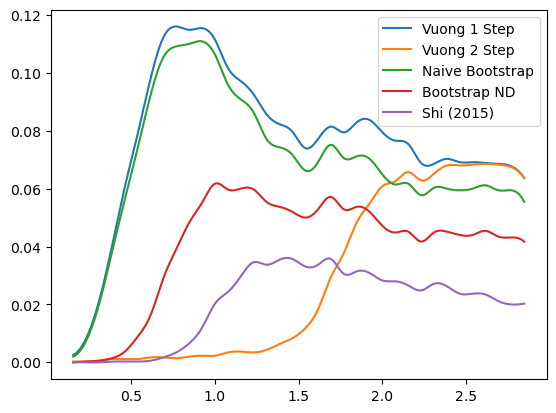

0.1 0.23227910480433808


In [5]:
calc_c =lambda nobs: (nobs**(-1/2), 3*(nobs)**(-5/9))
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2)
print(c1,c2)

# Power stuff

Quantiles: 1th: 0.69, 5th: 1.78, 10th: 3.36, 30th: 10.12, 50th: 17.76, 70th: 27.37, 90th: 43.55, 95th: 51.82, 99th: 67.44
bonus term 2.0724325154227317 // variance stats 10.208041906105596 //part1 23.22791048043381 //part2 11.208041906105597 10.208041906105596
0.30192742442194787 -1.1576542382148773 3.858027647250951
-3.842937606423515 -1.1576542382148773 -0.28683738359451244
---
Quantiles: 1th: 0.65, 5th: 1.83, 10th: 3.36, 30th: 10.10, 50th: 17.65, 70th: 26.84, 90th: 42.68, 95th: 50.64, 99th: 66.36
bonus term 1.096812748237353 // variance stats 20.17764451385391 //part1 23.22791048043381 //part2 21.17764451385391 20.17764451385391
-0.7362839891555878 -0.25062674187719813 2.9775641637152304
-2.929909485630294 -0.25062674187719813 0.783938667240524
---
Quantiles: 1th: 0.68, 5th: 1.85, 10th: 3.27, 30th: 9.65, 50th: 17.24, 70th: 25.62, 90th: 40.75, 95th: 48.64, 99th: 65.05
bonus term 4.16351583171367 // variance stats 4.578917294731022 //part1 23.22791048043381 //part2 5.5789172947310215 

Quantiles: 1th: 0.74, 5th: 1.76, 10th: 3.08, 30th: 9.03, 50th: 16.04, 70th: 25.15, 90th: 39.81, 95th: 48.03, 99th: 62.58
bonus term 7.560503847281304 // variance stats 2.0722701753252033 //part1 23.22791048043381 //part2 3.0722701753252037 2.0722701753252033
6.215242371049786 -4.315894630815914 8.81910566355431
-8.905765323512824 -4.315894630815914 -6.301902031008297
---
Quantiles: 1th: 0.61, 5th: 1.69, 10th: 2.72, 30th: 7.69, 50th: 13.54, 70th: 20.71, 90th: 32.26, 95th: 38.68, 99th: 49.82
bonus term 0.7333431003905608 // variance stats 30.67400152542948 //part1 23.22791048043381 //part2 31.67400152542948 30.67400152542948
-1.075355523621209 0.45898684749934066 2.6669080998659616
-2.5420417244023303 0.45898684749934066 1.20022189908484
---
Quantiles: 1th: 0.79, 5th: 1.72, 10th: 3.03, 30th: 8.62, 50th: 14.74, 70th: 22.81, 90th: 35.95, 95th: 43.09, 99th: 55.90
bonus term 1.5615839805333285 // variance stats 13.874582968314499 //part1 23.22791048043381 //part2 14.8745829683145 13.87458296

Quantiles: 1th: 0.72, 5th: 1.68, 10th: 2.67, 30th: 7.63, 50th: 12.82, 70th: 19.78, 90th: 31.09, 95th: 36.41, 99th: 48.61
bonus term 1.8383639449327616 // variance stats 11.635099020767278 //part1 23.22791048043381 //part2 12.63509902076728 11.635099020767278
-0.12119341244627575 -0.4131711923818134 3.696395622726778
-3.797921302311799 -0.4131711923818134 0.019667732861254967
---
Quantiles: 1th: 0.67, 5th: 1.70, 10th: 2.79, 30th: 7.98, 50th: 13.86, 70th: 21.48, 90th: 33.83, 95th: 40.58, 99th: 52.45
bonus term 0.48623603902233786 // variance stats 46.770853281746795 //part1 23.22791048043381 //part2 47.77085328174679 46.770853281746795
-1.398641661025569 0.9224037379370046 2.4294292786981275
-2.3711137390702444 0.9224037379370046 1.456957200653452
---
Quantiles: 1th: 0.56, 5th: 1.45, 10th: 2.54, 30th: 7.88, 50th: 13.88, 70th: 21.38, 90th: 33.91, 95th: 40.35, 99th: 53.09
bonus term 2.4022869641297313 // variance stats 8.669082348306588 //part1 23.22791048043381 //part2 9.669082348306588 8

Quantiles: 1th: 0.77, 5th: 1.98, 10th: 3.47, 30th: 10.49, 50th: 18.10, 70th: 27.92, 90th: 43.92, 95th: 51.22, 99th: 66.23
bonus term 1.4099612581225245 // variance stats 15.474148028268251 //part1 23.22791048043381 //part2 16.474148028268253 15.474148028268251
-0.5323708510609495 -0.8019337189416255 3.1171357374129216
-3.3522933673059985 -0.8019337189416255 0.29721322116787263
---
Quantiles: 1th: 0.74, 5th: 1.84, 10th: 3.04, 30th: 8.43, 50th: 15.17, 70th: 22.88, 90th: 36.18, 95th: 43.17, 99th: 57.67
bonus term 10.703114768989202 // variance stats 1.1702010098717686 //part1 23.22791048043381 //part2 2.170201009871769 1.1702010098717686
9.635973241519283 -5.121550126771243 11.831369545151665
-11.770256296459122 -5.121550126771243 -9.57485999282674
---
Quantiles: 1th: 0.61, 5th: 1.78, 10th: 3.03, 30th: 9.04, 50th: 15.51, 70th: 23.92, 90th: 38.00, 95th: 45.00, 99th: 58.10
bonus term 5.869526154936648 // variance stats 2.9573740481414577 //part1 23.22791048043381 //part2 3.9573740481414577 

Quantiles: 1th: 0.61, 5th: 1.68, 10th: 3.22, 30th: 10.19, 50th: 18.05, 70th: 28.02, 90th: 43.82, 95th: 51.93, 99th: 69.17
bonus term 3.845068874917553 // variance stats 5.040960834786573 //part1 23.22791048043381 //part2 6.040960834786572 5.040960834786573
2.2605587494482546 -2.0636670054646227 5.372895607789425
-5.429579000386852 -2.0636670054646227 -2.3172421420456817
---
Quantiles: 1th: 0.77, 5th: 1.81, 10th: 2.99, 30th: 8.14, 50th: 14.03, 70th: 21.39, 90th: 33.99, 95th: 40.38, 99th: 53.17
bonus term 2.360097297576587 // variance stats 8.841929188379169 //part1 23.22791048043381 //part2 9.841929188379169 8.841929188379169
0.6392405054621261 -0.8738724754561105 4.275567030611764
-4.080954089691048 -0.8738724754561105 -0.4446275645414096
---
Quantiles: 1th: 0.77, 5th: 1.92, 10th: 3.31, 30th: 9.72, 50th: 17.34, 70th: 27.07, 90th: 43.62, 95th: 51.27, 99th: 67.91
bonus term 1.185295003208067 // variance stats 18.59673365496874 //part1 23.22791048043381 //part2 19.596733654968745 18.59673

Quantiles: 1th: 0.67, 5th: 1.79, 10th: 3.00, 30th: 8.76, 50th: 16.00, 70th: 24.16, 90th: 37.54, 95th: 44.86, 99th: 58.86
bonus term 0.6467517691811894 // variance stats 34.914722753431604 //part1 23.22791048043381 //part2 35.914722753431604 34.914722753431604
-1.2837724556097083 0.43223864006464857 2.561047780133437
-2.577275993972087 0.43223864006464857 1.2675442417710583
---
Quantiles: 1th: 0.68, 5th: 1.66, 10th: 2.77, 30th: 7.67, 50th: 13.08, 70th: 20.48, 90th: 33.13, 95th: 39.09, 99th: 50.61
bonus term 1.1221395883589151 // variance stats 19.699662253609382 //part1 23.22791048043381 //part2 20.699662253609382 19.699662253609382
-0.8317367712304878 -0.15706746380758468 2.9870987621624696
-3.076015947948318 -0.15706746380758468 0.7428195854446392
---
Quantiles: 1th: 0.74, 5th: 1.75, 10th: 2.83, 30th: 8.37, 50th: 14.23, 70th: 22.02, 90th: 35.27, 95th: 42.31, 99th: 55.18
bonus term 1.0682274096451205 // variance stats 20.744349817938517 //part1 23.22791048043381 //part2 21.744349817938

Quantiles: 1th: 0.72, 5th: 1.77, 10th: 3.13, 30th: 9.14, 50th: 15.89, 70th: 23.87, 90th: 37.29, 95th: 44.36, 99th: 56.98
bonus term 0.6970173508123652 // variance stats 32.32472348552294 //part1 23.22791048043381 //part2 33.324723485522945 32.32472348552294
-1.2566401427369804 0.3247054696667076 2.7045682896910264
-2.650674844361711 0.3247054696667076 1.310533588066296
---
Quantiles: 1th: 0.74, 5th: 1.98, 10th: 3.29, 30th: 9.83, 50th: 17.40, 70th: 26.35, 90th: 41.68, 95th: 49.09, 99th: 62.93
bonus term 0.7018162084234686 // variance stats 32.09685670071947 //part1 23.22791048043381 //part2 33.09685670071947 32.09685670071947
-1.1249696232774973 0.11610898545065108 2.5221953210569414
-2.5286020401244347 0.11610898545065108 1.1185629042100043
---
Quantiles: 1th: 0.59, 5th: 1.60, 10th: 2.75, 30th: 8.25, 50th: 14.13, 70th: 21.92, 90th: 35.03, 95th: 41.32, 99th: 52.85
bonus term 0.5846524099977293 // variance stats 38.72943595755301 //part1 23.22791048043381 //part2 39.72943595755301 38.729

Quantiles: 1th: 0.62, 5th: 1.74, 10th: 2.83, 30th: 8.61, 50th: 14.91, 70th: 22.89, 90th: 35.56, 95th: 42.88, 99th: 54.93
bonus term 2.533582356296595 // variance stats 8.168010829688074 //part1 23.22791048043381 //part2 9.168010829688074 8.168010829688074
0.7509739218189242 -2.070838759310751 4.4176779280503755
-4.316190790774265 -2.070838759310751 -0.6494867845428144
---
Quantiles: 1th: 0.55, 5th: 1.49, 10th: 2.56, 30th: 6.99, 50th: 12.08, 70th: 18.55, 90th: 29.49, 95th: 34.60, 99th: 45.62
bonus term 5.428252280505222 // variance stats 3.2790771836182824 //part1 23.22791048043381 //part2 4.279077183618282 3.2790771836182824
3.7640405505207646 -3.3535047818476116 6.98077581079894
-7.09246401048968 -3.3535047818476116 -3.8757287502115036
---
Quantiles: 1th: 0.75, 5th: 2.00, 10th: 3.75, 30th: 10.46, 50th: 18.27, 70th: 28.02, 90th: 45.13, 95th: 53.29, 99th: 71.83
bonus term 1.911387592429436 // variance stats 11.15238111434551 //part1 23.22791048043381 //part2 12.15238111434551 11.1523811

Quantiles: 1th: 0.69, 5th: 1.79, 10th: 2.97, 30th: 7.99, 50th: 13.60, 70th: 20.68, 90th: 31.90, 95th: 38.14, 99th: 51.01
bonus term 1.1014471888284487 // variance stats 20.08853762216245 //part1 23.22791048043381 //part2 21.088537622162452 20.08853762216245
-0.8505240109981469 -0.46325491622120224 2.9846544506589576
-3.053418388655045 -0.46325491622120224 0.7817600730020601
---
Quantiles: 1th: 0.77, 5th: 1.93, 10th: 3.34, 30th: 9.63, 50th: 17.36, 70th: 27.08, 90th: 42.83, 95th: 50.54, 99th: 68.00
bonus term 0.6552199721799596 // variance stats 34.45055319842134 //part1 23.22791048043381 //part2 35.45055319842134 34.45055319842134
-1.0850584490001034 -0.17231975446053507 2.550789329436657
-2.3954983933600222 -0.17231975446053507 1.2403493850767378
---
Quantiles: 1th: 0.59, 5th: 1.56, 10th: 2.60, 30th: 8.03, 50th: 13.95, 70th: 21.41, 90th: 34.83, 95th: 41.31, 99th: 51.95
bonus term 1.2312666135275248 // variance stats 17.865053454090553 //part1 23.22791048043381 //part2 18.86505345409055

Quantiles: 1th: 0.63, 5th: 1.71, 10th: 3.25, 30th: 9.38, 50th: 16.37, 70th: 25.13, 90th: 39.33, 95th: 46.68, 99th: 60.07
bonus term 2.5144187866863015 // variance stats 8.237884557427035 //part1 23.22791048043381 //part2 9.237884557427035 8.237884557427035
0.5754224707749155 -2.9675916458695175 4.387292715733325
-4.453415102597687 -2.9675916458695175 -0.6415448576392789
---
Quantiles: 1th: 0.55, 5th: 1.75, 10th: 3.43, 30th: 10.85, 50th: 19.21, 70th: 29.01, 90th: 46.65, 95th: 55.77, 99th: 72.42
bonus term 0.6292212236595167 // variance stats 35.91533217099947 //part1 23.22791048043381 //part2 36.91533217099947 35.91533217099947
-1.196734243729398 -0.011894553596598094 2.393128159048132
-2.4551766910484316 -0.011894553596598094 1.1346857117290985
---
Quantiles: 1th: 1.01, 5th: 2.25, 10th: 3.68, 30th: 11.03, 50th: 19.11, 70th: 29.18, 90th: 46.74, 95th: 55.24, 99th: 72.18
bonus term 1.0955998678201841 // variance stats 20.201089159172938 //part1 23.22791048043381 //part2 21.201089159172938

Quantiles: 1th: 0.64, 5th: 1.81, 10th: 3.21, 30th: 9.40, 50th: 16.23, 70th: 24.59, 90th: 38.35, 95th: 45.71, 99th: 59.47
bonus term 1.1249192519848041 // variance stats 19.648513606154893 //part1 23.22791048043381 //part2 20.64851360615489 19.648513606154893
-0.7861009039510761 -0.9484011231820936 3.0673883194568363
-3.0359394079206843 -0.9484011231820936 0.8175498154872277
---
Quantiles: 1th: 0.67, 5th: 1.99, 10th: 3.61, 30th: 10.53, 50th: 18.21, 70th: 28.31, 90th: 44.95, 95th: 53.73, 99th: 71.17
bonus term 0.8936495476754147 // variance stats 24.9921918394687 //part1 23.22791048043381 //part2 25.9921918394687 24.9921918394687
-0.8792470531826918 -0.6987234984927483 2.8784973012141344
-2.6665461485335213 -0.6987234984927483 1.091198205863305
---
Quantiles: 1th: 0.68, 5th: 1.71, 10th: 2.78, 30th: 7.66, 50th: 13.24, 70th: 20.92, 90th: 33.58, 95th: 39.82, 99th: 50.87
bonus term 2.9459701450033293 // variance stats 6.884638790325406 //part1 23.22791048043381 //part2 7.884638790325406 6.88

Quantiles: 1th: 0.70, 5th: 1.69, 10th: 2.89, 30th: 9.30, 50th: 16.15, 70th: 25.10, 90th: 40.59, 95th: 47.94, 99th: 66.18
bonus term 1.1926570841474602 // variance stats 18.475766160427977 //part1 23.22791048043381 //part2 19.47576616042798 18.475766160427977
-0.6870005698729861 -1.1502482001744112 3.1200184015066057
-3.0723147381679063 -1.1502482001744112 0.7347042332116854
---
Quantiles: 1th: 0.85, 5th: 2.01, 10th: 3.69, 30th: 10.14, 50th: 17.70, 70th: 26.94, 90th: 42.74, 95th: 51.22, 99th: 67.13
bonus term 2.1554574859198423 // variance stats 9.77632504104867 //part1 23.22791048043381 //part2 10.776325041048672 9.77632504104867
0.31648052892941847 -3.344774581759564 3.807277866606652
-3.9944344429102663 -3.344774581759564 -0.5036371052330327
---
Quantiles: 1th: 0.92, 5th: 2.37, 10th: 4.42, 30th: 12.47, 50th: 21.72, 70th: 32.83, 90th: 52.87, 95th: 62.91, 99th: 84.83
bonus term 1.5110306999558003 // variance stats 14.37222935385314 //part1 23.22791048043381 //part2 15.37222935385314 14

Quantiles: 1th: 0.64, 5th: 1.72, 10th: 2.86, 30th: 8.50, 50th: 14.79, 70th: 22.60, 90th: 35.66, 95th: 42.01, 99th: 55.85
bonus term 1.22559981456555 // variance stats 17.952279695528205 //part1 23.22791048043381 //part2 18.95227969552821 17.952279695528205
-0.4852872656557382 -1.1246920033476362 3.1932844669016354
-2.936486894786838 -1.1246920033476362 0.7420848377705356
---
Quantiles: 1th: 0.80, 5th: 2.25, 10th: 3.97, 30th: 11.63, 50th: 20.08, 70th: 31.25, 90th: 49.67, 95th: 59.08, 99th: 79.59
bonus term 0.9876534662169892 // variance stats 22.51827971545902 //part1 23.22791048043381 //part2 23.51827971545902 22.51827971545902
-0.8365958341908275 -1.5141139845369243 2.972343070573586
-2.8119027666248058 -1.5141139845369243 0.9970361381396076
---
Quantiles: 1th: 0.85, 5th: 2.11, 10th: 3.57, 30th: 10.02, 50th: 17.47, 70th: 27.23, 90th: 42.86, 95th: 50.36, 99th: 67.71
bonus term 3.54885771457355 // variance stats 5.545179420704107 //part1 23.22791048043381 //part2 6.545179420704107 5.545

Quantiles: 1th: 0.71, 5th: 2.11, 10th: 3.50, 30th: 9.94, 50th: 17.16, 70th: 26.34, 90th: 41.46, 95th: 49.38, 99th: 64.38
bonus term 1.6995528665476451 // variance stats 12.667071461929506 //part1 23.22791048043381 //part2 13.667071461929508 12.667071461929506
-0.4290516317923869 -3.349376799208579 3.62008544346933
-3.828157364887677 -3.349376799208579 0.22097971037403952
---
Quantiles: 1th: 0.59, 5th: 1.55, 10th: 3.18, 30th: 10.06, 50th: 17.81, 70th: 27.14, 90th: 42.71, 95th: 51.14, 99th: 68.95
bonus term 0.5163902349514838 // variance stats 43.98131240343097 //part1 23.22791048043381 //part2 44.98131240343096 43.98131240343097
-1.6643914964597244 -0.3762071867551369 2.489467346190283
-2.697171966362692 -0.3762071867551369 1.4566868762873149
---
Quantiles: 1th: 0.84, 5th: 2.17, 10th: 3.64, 30th: 10.54, 50th: 18.50, 70th: 28.05, 90th: 44.21, 95th: 53.17, 99th: 72.12
bonus term 0.5543786675537083 // variance stats 40.89899763447064 //part1 23.22791048043381 //part2 41.89899763447063 40.8

Quantiles: 1th: 0.97, 5th: 2.40, 10th: 4.05, 30th: 11.56, 50th: 20.70, 70th: 32.00, 90th: 50.74, 95th: 60.41, 99th: 81.07
bonus term 0.43182074325219405 // variance stats 52.790631514123746 //part1 23.22791048043381 //part2 53.790631514123746 52.790631514123746
-1.4197302765548376 -0.42142908756165126 2.4012477468092883
-2.2833717630592254 -0.42142908756165126 1.5376062603049003
---
Quantiles: 1th: 0.69, 5th: 1.72, 10th: 2.91, 30th: 9.14, 50th: 16.13, 70th: 24.88, 90th: 38.56, 95th: 45.85, 99th: 59.34
bonus term 1.1487749087203944 // variance stats 19.219723031996825 //part1 23.22791048043381 //part2 20.219723031996825 19.219723031996825
-0.6909544751747525 -2.4189228338499245 3.194923993479082
-2.9885042926155414 -2.4189228338499245 0.897374176038293
---
Quantiles: 1th: 0.65, 5th: 1.60, 10th: 2.63, 30th: 7.74, 50th: 13.29, 70th: 20.76, 90th: 32.97, 95th: 38.98, 99th: 51.09
bonus term 0.5395721085590756 // variance stats 42.04876051222111 //part1 23.22791048043381 //part2 43.0487605122

Quantiles: 1th: 0.88, 5th: 2.11, 10th: 3.55, 30th: 9.89, 50th: 17.74, 70th: 27.17, 90th: 42.66, 95th: 50.54, 99th: 66.26
bonus term 1.5218140674240237 // variance stats 14.263303827747968 //part1 23.22791048043381 //part2 15.263303827747968 14.263303827747968
-0.3741758622999215 -2.4874021349198276 3.3051313208334983
-3.417803997147969 -2.4874021349198276 0.2615031859854509
---
Quantiles: 1th: 0.66, 5th: 1.78, 10th: 3.04, 30th: 9.12, 50th: 15.54, 70th: 23.95, 90th: 38.39, 95th: 45.17, 99th: 61.02
bonus term 2.815620008194381 // variance stats 7.249660967329733 //part1 23.22791048043381 //part2 8.249660967329733 7.249660967329733
0.7598156571458556 -4.15209749883678 4.5558358128641965
-4.871424359242907 -4.15209749883678 -1.0754042035245654
---
Quantiles: 1th: 0.61, 5th: 1.49, 10th: 2.71, 30th: 8.11, 50th: 14.34, 70th: 22.43, 90th: 35.59, 95th: 42.31, 99th: 56.00
bonus term 1.2799153045902267 // variance stats 17.148005885335028 //part1 23.22791048043381 //part2 18.148005885335028 17.14

Quantiles: 1th: 0.78, 5th: 2.12, 10th: 3.84, 30th: 12.05, 50th: 21.12, 70th: 32.67, 90th: 50.74, 95th: 59.75, 99th: 77.34
bonus term 1.4673223781193636 // variance stats 14.830134418180505 //part1 23.22791048043381 //part2 15.830134418180506 14.830134418180505
-0.5563929345791836 -3.0875275505008637 3.386691989226406
-3.491037690817911 -3.0875275505008637 0.4520472329876786
---
Quantiles: 1th: 0.60, 5th: 1.85, 10th: 3.23, 30th: 9.92, 50th: 17.11, 70th: 26.46, 90th: 41.77, 95th: 49.47, 99th: 67.16
bonus term 2.2926729849925924 // variance stats 9.131366589338887 //part1 23.22791048043381 //part2 10.131366589338889 9.131366589338887
-0.016973689260103782 -5.631524929878887 4.340033766186125
-4.602319659245288 -5.631524929878887 -0.24531220379905935
---
Quantiles: 1th: 0.62, 5th: 1.85, 10th: 3.16, 30th: 9.46, 50th: 16.38, 70th: 25.50, 90th: 40.68, 95th: 48.38, 99th: 63.84
bonus term 0.7297767395559424 // variance stats 30.828789849574576 //part1 23.22791048043381 //part2 31.82878984957458

Quantiles: 1th: 0.74, 5th: 1.87, 10th: 3.21, 30th: 10.04, 50th: 17.84, 70th: 27.69, 90th: 43.29, 95th: 52.66, 99th: 67.42
bonus term 0.6130912899149001 // variance stats 36.886544569338035 //part1 23.22791048043381 //part2 37.886544569338035 36.886544569338035
-1.5505946911380195 -0.9482897330224711 2.465560937754572
-2.7767772709678193 -0.9482897330224711 1.2393783579247721
---
Quantiles: 1th: 0.60, 5th: 1.64, 10th: 3.18, 30th: 9.71, 50th: 17.03, 70th: 26.13, 90th: 41.98, 95th: 50.01, 99th: 64.14
bonus term 2.080234043332139 // variance stats 10.166008245508333 //part1 23.22791048043381 //part2 11.166008245508333 10.166008245508333
-0.36960198905864333 -5.214512096944751 3.914797196556564
-4.5300700757229215 -5.214512096944751 -0.24567089010771448
---
Quantiles: 1th: 0.70, 5th: 1.72, 10th: 2.88, 30th: 8.39, 50th: 15.06, 70th: 22.74, 90th: 35.35, 95th: 42.65, 99th: 55.81
bonus term 0.7300806187254854 // variance stats 30.81554185205352 //part1 23.22791048043381 //part2 31.8155418520535

Quantiles: 1th: 0.93, 5th: 2.50, 10th: 4.18, 30th: 12.15, 50th: 21.35, 70th: 33.15, 90th: 52.38, 95th: 62.60, 99th: 83.21
bonus term 1.884701118873045 // variance stats 11.324453064644494 //part1 23.22791048043381 //part2 12.324453064644496 11.324453064644494
0.01591206237009876 -6.226602789391769 3.5466128413332116
-3.7534901753759913 -6.226602789391769 -0.22278939641287834
---
Quantiles: 1th: 0.65, 5th: 1.68, 10th: 2.96, 30th: 9.26, 50th: 16.15, 70th: 25.00, 90th: 39.68, 95th: 47.55, 99th: 63.70
bonus term 1.9779484112036787 // variance stats 10.743435950535476 //part1 23.22791048043381 //part2 11.743435950535478 10.743435950535476
0.22467499322882536 -4.480480371879721 3.658031123673429
-3.731221829178532 -4.480480371879721 -0.29786569873392826
---
Quantiles: 1th: 0.56, 5th: 1.65, 10th: 2.96, 30th: 8.32, 50th: 14.76, 70th: 22.23, 90th: 35.18, 95th: 41.35, 99th: 53.05
bonus term 0.651786351133085 // variance stats 34.63730728643475 //part1 23.22791048043381 //part2 35.63730728643475 

Quantiles: 1th: 0.93, 5th: 2.32, 10th: 4.04, 30th: 11.84, 50th: 20.72, 70th: 32.33, 90th: 51.21, 95th: 60.74, 99th: 77.81
bonus term 1.5857826326519628 // variance stats 13.647600498429547 //part1 23.22791048043381 //part2 14.647600498429547 13.647600498429547
-0.577883708461054 -6.3274254384069355 3.5853012240234636
-3.74944897376498 -6.3274254384069355 0.4137359587195379
---
Quantiles: 1th: 0.96, 5th: 2.37, 10th: 4.38, 30th: 12.71, 50th: 22.38, 70th: 34.54, 90th: 54.32, 95th: 65.74, 99th: 88.90
bonus term 1.4825846792664503 // variance stats 14.667172880760145 //part1 23.22791048043381 //part2 15.667172880760145 14.667172880760145
-0.3957966722871706 -4.173317623724949 3.2389117383481354
-3.3609660308200713 -4.173317623724949 0.2737423798152348
---
Quantiles: 1th: 0.62, 5th: 1.72, 10th: 3.14, 30th: 9.26, 50th: 16.17, 70th: 24.89, 90th: 39.68, 95th: 46.98, 99th: 61.59
bonus term 0.46050740896535425 // variance stats 49.43981926940363 //part1 23.22791048043381 //part2 50.43981926940362

Quantiles: 1th: 0.66, 5th: 1.59, 10th: 2.84, 30th: 8.68, 50th: 15.15, 70th: 23.77, 90th: 36.57, 95th: 43.94, 99th: 59.31
bonus term 0.6846233985493558 // variance stats 32.9280114142334 //part1 23.22791048043381 //part2 33.9280114142334 32.9280114142334
-1.034046642359251 -1.7422567128964626 2.553976264311825
-2.4032934394579626 -1.7422567128964626 1.1847294672131135
---
Quantiles: 1th: 0.56, 5th: 1.59, 10th: 2.78, 30th: 8.29, 50th: 14.54, 70th: 22.38, 90th: 35.45, 95th: 41.93, 99th: 53.25
bonus term 1.673266074209837 // variance stats 12.881779376542177 //part1 23.22791048043381 //part2 13.881779376542179 12.881779376542177
-0.32650935495959227 -5.817517442047279 3.499231023385552
-3.6730415033792667 -5.817517442047279 0.152698874965878
---
Quantiles: 1th: 0.63, 5th: 1.59, 10th: 2.80, 30th: 8.31, 50th: 14.36, 70th: 21.79, 90th: 35.05, 95th: 41.11, 99th: 54.82
bonus term 0.6754775565459379 // variance stats 33.38739045485092 //part1 23.22791048043381 //part2 34.38739045485092 33.387390

Quantiles: 1th: 0.62, 5th: 1.60, 10th: 2.72, 30th: 7.69, 50th: 13.15, 70th: 20.09, 90th: 31.47, 95th: 38.12, 99th: 48.72
bonus term 0.6222573180969962 // variance stats 36.3284649370939 //part1 23.22791048043381 //part2 37.3284649370939 36.3284649370939
-1.2405848824271541 -1.3845310749611122 2.458267417422928
-2.485099518621147 -1.3845310749611122 1.2137527812289355
---
Quantiles: 1th: 0.66, 5th: 1.96, 10th: 3.24, 30th: 9.42, 50th: 16.38, 70th: 24.82, 90th: 39.68, 95th: 47.53, 99th: 63.87
bonus term 0.7321593833820755 // variance stats 30.725210394950825 //part1 23.22791048043381 //part2 31.725210394950825 30.725210394950825
-1.5016955614527723 -2.953557085003634 2.610845621026071
-2.966014328216924 -2.953557085003634 1.14652685426192
---
Quantiles: 1th: 0.75, 5th: 1.85, 10th: 3.21, 30th: 8.88, 50th: 15.54, 70th: 23.71, 90th: 37.44, 95th: 44.16, 99th: 59.14
bonus term 0.6554516982523609 // variance stats 34.43802013537638 //part1 23.22791048043381 //part2 35.43802013537638 34.43802013

Quantiles: 1th: 0.60, 5th: 1.79, 10th: 3.26, 30th: 9.61, 50th: 16.59, 70th: 26.11, 90th: 41.87, 95th: 49.55, 99th: 64.44
bonus term 1.3815795198918486 // variance stats 15.812575856836755 //part1 23.22791048043381 //part2 16.812575856836755 15.812575856836755
-1.2491829032806845 -7.650856334933398 3.5660064637290882
-4.012341943064382 -7.650856334933398 0.8028474239453911
---
Quantiles: 1th: 0.85, 5th: 1.93, 10th: 3.21, 30th: 9.01, 50th: 15.49, 70th: 23.49, 90th: 37.41, 95th: 44.47, 99th: 57.41
bonus term 1.3962966095067662 // variance stats 15.63536982206018 //part1 23.22791048043381 //part2 16.63536982206018 15.63536982206018
-0.7533011482813631 -6.526612666323883 3.2648722209124963
-3.5458943672948955 -6.526612666323883 0.47227900189896377
---
Quantiles: 1th: 0.76, 5th: 1.88, 10th: 3.41, 30th: 10.04, 50th: 17.40, 70th: 26.78, 90th: 41.88, 95th: 49.70, 99th: 67.35
bonus term 0.6467862725368613 // variance stats 34.912806852452206 //part1 23.22791048043381 //part2 35.912806852452206 3

Quantiles: 1th: 0.62, 5th: 1.51, 10th: 2.67, 30th: 8.09, 50th: 14.31, 70th: 21.77, 90th: 34.50, 95th: 41.26, 99th: 54.88
bonus term 1.6632360546258325 // variance stats 12.96549240009064 //part1 23.22791048043381 //part2 13.965492400090643 12.96549240009064
-0.4765642655798062 -6.812759323516096 3.4391624895985364
-3.803036374831471 -6.812759323516096 0.1126903803468717
---
Quantiles: 1th: 0.81, 5th: 2.19, 10th: 4.00, 30th: 11.66, 50th: 20.45, 70th: 31.25, 90th: 49.07, 95th: 57.74, 99th: 74.42
bonus term 0.3520323093682552 // variance stats 64.98232566243082 //part1 23.22791048043381 //part2 65.98232566243082 64.98232566243082
-1.6183368679421661 -0.5834902342978491 2.244775470500177
-2.3224014866786766 -0.5834902342978491 1.5407108517636665
---
Quantiles: 1th: 1.04, 5th: 2.59, 10th: 4.07, 30th: 11.50, 50th: 19.91, 70th: 30.55, 90th: 47.96, 95th: 57.21, 99th: 76.76
bonus term 0.9892552950313451 // variance stats 22.48019828359657 //part1 23.22791048043381 //part2 23.48019828359657 22.4

Quantiles: 1th: 0.78, 5th: 2.04, 10th: 3.38, 30th: 10.14, 50th: 18.14, 70th: 27.61, 90th: 44.87, 95th: 53.82, 99th: 69.33
bonus term 1.3899820542993868 // variance stats 15.710942712236465 //part1 23.22791048043381 //part2 16.710942712236466 15.710942712236465
-0.696016455041252 -6.994014999445816 3.3329276779391885
-3.4759805636400256 -6.994014999445816 0.5529635693404148
---
Quantiles: 1th: 0.74, 5th: 1.75, 10th: 3.00, 30th: 8.61, 50th: 14.84, 70th: 22.70, 90th: 35.61, 95th: 42.09, 99th: 54.95
bonus term 1.025291992934342 // variance stats 21.654922344566955 //part1 23.22791048043381 //part2 22.654922344566955 21.654922344566955
-1.3438426380906128 -4.166238193279124 2.9963874812655553
-3.394426623959297 -4.166238193279124 0.9458034953968711
---
Quantiles: 1th: 0.70, 5th: 1.84, 10th: 3.27, 30th: 9.41, 50th: 16.65, 70th: 25.18, 90th: 39.98, 95th: 47.77, 99th: 61.69
bonus term 1.425382231109901 // variance stats 15.295916964214541 //part1 23.22791048043381 //part2 16.29591696421454 15.

Quantiles: 1th: 0.80, 5th: 2.03, 10th: 3.57, 30th: 10.86, 50th: 18.33, 70th: 28.18, 90th: 44.10, 95th: 52.61, 99th: 72.05
bonus term 0.8548602985304378 // variance stats 26.1715864222074 //part1 23.22791048043381 //part2 27.1715864222074 26.1715864222074
-1.1969192181794528 -5.19340860245173 2.6033177139556045
-2.9066398152403283 -5.19340860245173 0.8935971168947291
---
Quantiles: 1th: 0.66, 5th: 1.77, 10th: 3.01, 30th: 8.87, 50th: 15.30, 70th: 23.21, 90th: 36.08, 95th: 42.79, 99th: 58.69
bonus term 0.45768777851646675 // variance stats 49.75055872307526 //part1 23.22791048043381 //part2 50.75055872307526 49.75055872307526
-1.4360283456621294 -1.1886148350356642 2.36254349110642
-2.3514039026950626 -1.1886148350356642 1.4471679340734862
---
Quantiles: 1th: 0.76, 5th: 2.08, 10th: 3.76, 30th: 11.37, 50th: 19.87, 70th: 30.32, 90th: 47.68, 95th: 56.79, 99th: 75.86
bonus term 0.7896441565519325 // variance stats 28.415668168635623 //part1 23.22791048043381 //part2 29.415668168635627 28.4156

Quantiles: 1th: 0.75, 5th: 1.85, 10th: 3.24, 30th: 8.72, 50th: 15.39, 70th: 23.68, 90th: 37.62, 95th: 44.07, 99th: 57.05
bonus term 0.46788229613523724 // variance stats 48.6447732096279 //part1 23.22791048043381 //part2 49.64477320962789 48.6447732096279
-1.3970895317197851 -1.3005817267747892 2.2993446282649406
-2.3328541239902596 -1.3005817267747892 1.363580035994466
---
Quantiles: 1th: 0.84, 5th: 1.99, 10th: 3.60, 30th: 10.18, 50th: 17.69, 70th: 27.15, 90th: 42.77, 95th: 51.31, 99th: 65.59
bonus term 1.4505503748455724 // variance stats 15.013170506337419 //part1 23.22791048043381 //part2 16.01317050633742 15.013170506337419
-0.6546346553835839 -7.267659393181859 3.361521673431702
-3.5557354050747283 -7.267659393181859 0.4604209237405576
---
Quantiles: 1th: 0.86, 5th: 2.14, 10th: 3.49, 30th: 9.36, 50th: 16.64, 70th: 25.60, 90th: 40.45, 95th: 48.29, 99th: 63.79
bonus term 0.4937392834153743 // variance stats 46.04489041211771 //part1 23.22791048043381 //part2 47.04489041211771 46.04

Quantiles: 1th: 0.67, 5th: 1.63, 10th: 2.79, 30th: 8.19, 50th: 14.54, 70th: 22.57, 90th: 35.80, 95th: 42.45, 99th: 54.36
bonus term 1.1884451387422694 // variance stats 18.54478984618161 //part1 23.22791048043381 //part2 19.544789846181615 18.54478984618161
-1.3169460456333204 -9.0975965946227 3.16660575023506
-3.6938363231178593 -9.0975965946227 0.7897154727505211
---
Quantiles: 1th: 0.77, 5th: 2.12, 10th: 3.93, 30th: 11.38, 50th: 20.01, 70th: 30.85, 90th: 49.22, 95th: 58.44, 99th: 77.53
bonus term 0.5353677360556515 // variance stats 42.38683285542494 //part1 23.22791048043381 //part2 43.38683285542494 42.38683285542494
-1.3250888559627254 -3.0921542705846683 2.5373176859924693
-2.395824328074028 -3.0921542705846683 1.4665822138811664
---
Quantiles: 1th: 0.87, 5th: 2.10, 10th: 3.59, 30th: 9.99, 50th: 17.23, 70th: 26.62, 90th: 41.85, 95th: 50.89, 99th: 65.80
bonus term 0.8719323650490443 // variance stats 25.63957826491197 //part1 23.22791048043381 //part2 26.63957826491197 25.6395782

Quantiles: 1th: 0.66, 5th: 1.74, 10th: 3.05, 30th: 9.08, 50th: 15.52, 70th: 24.34, 90th: 38.52, 95th: 45.52, 99th: 60.95
bonus term 0.7278486918621906 // variance stats 30.913103286626136 //part1 23.22791048043381 //part2 31.913103286626136 30.913103286626136
-1.2015811697439267 -3.7790399710853957 2.48237338992827
-2.6572785534683074 -3.7790399710853957 1.026676006203889
---
Quantiles: 1th: 0.89, 5th: 1.93, 10th: 3.18, 30th: 9.16, 50th: 15.77, 70th: 24.36, 90th: 38.54, 95th: 46.76, 99th: 61.02
bonus term 0.8483390956658597 // variance stats 26.38045505518317 //part1 23.22791048043381 //part2 27.38045505518317 26.38045505518317
-1.371000022577126 -5.950707172259205 2.9291291396036
-3.0676782139088457 -5.950707172259205 1.2324509482718802
---
Quantiles: 1th: 0.81, 5th: 2.27, 10th: 3.85, 30th: 11.52, 50th: 20.00, 70th: 30.71, 90th: 48.17, 95th: 57.84, 99th: 76.98
bonus term 0.9425563608571862 // variance stats 23.643524191285195 //part1 23.22791048043381 //part2 24.6435241912852 23.64352

Quantiles: 1th: 0.62, 5th: 1.54, 10th: 2.59, 30th: 7.25, 50th: 12.60, 70th: 19.79, 90th: 31.41, 95th: 37.65, 99th: 50.26
bonus term 0.9960438749929447 // variance stats 22.320167980148806 //part1 23.22791048043381 //part2 23.320167980148806 22.320167980148806
-1.5541685153937423 -7.3382407514814 2.8452638857302586
-3.5462562653796312 -7.3382407514814 0.8531761357443693
---
Quantiles: 1th: 0.68, 5th: 1.86, 10th: 3.20, 30th: 9.30, 50th: 16.04, 70th: 24.04, 90th: 38.02, 95th: 45.69, 99th: 59.44
bonus term 0.3651103666136634 // variance stats 62.61887419376429 //part1 23.22791048043381 //part2 63.61887419376429 62.61887419376429
-1.6141599447316577 -1.6146957772027586 2.2480012269477587
-2.3443806779589846 -1.6146957772027586 1.5177804937204322
---
Quantiles: 1th: 0.60, 5th: 1.81, 10th: 3.27, 30th: 9.49, 50th: 16.63, 70th: 25.26, 90th: 40.42, 95th: 48.01, 99th: 63.21
bonus term 1.0638409818381889 // variance stats 20.83400609393594 //part1 23.22791048043381 //part2 21.83400609393594 20.834

Quantiles: 1th: 0.73, 5th: 1.70, 10th: 2.90, 30th: 8.65, 50th: 15.67, 70th: 23.74, 90th: 39.22, 95th: 47.67, 99th: 62.36
bonus term 1.017871599235387 // variance stats 21.82007917097042 //part1 23.22791048043381 //part2 22.82007917097042 21.82007917097042
-1.4876867045953566 -8.550915780185852 3.074184046050063
-3.523429903066131 -8.550915780185852 1.0384408475792888
---
Quantiles: 1th: 0.70, 5th: 2.19, 10th: 3.84, 30th: 11.18, 50th: 18.88, 70th: 29.37, 90th: 45.78, 95th: 53.79, 99th: 71.77
bonus term 0.6367017505828881 // variance stats 35.48161868436691 //part1 23.22791048043381 //part2 36.48161868436691 35.48161868436691
-1.4165247392133313 -4.373870801755912 2.5876526207222783
-2.689928240379108 -4.373870801755912 1.3142491195565018
---
Quantiles: 1th: 0.72, 5th: 2.07, 10th: 3.47, 30th: 9.99, 50th: 17.89, 70th: 27.53, 90th: 43.49, 95th: 52.29, 99th: 67.65
bonus term 0.504457740070156 // variance stats 45.045304958951476 //part1 23.22791048043381 //part2 46.045304958951476 45.045304

Quantiles: 1th: 0.72, 5th: 1.76, 10th: 2.85, 30th: 8.05, 50th: 14.07, 70th: 21.52, 90th: 34.75, 95th: 40.64, 99th: 52.87
bonus term 1.1413067893856652 // variance stats 19.352030406247533 //part1 23.22791048043381 //part2 20.352030406247536 19.352030406247533
-1.1537722107985862 -9.608734478871956 3.020639832004189
-3.436385789569917 -9.608734478871956 0.7380262532328588
---
Quantiles: 1th: 0.72, 5th: 1.80, 10th: 2.94, 30th: 8.22, 50th: 14.28, 70th: 22.35, 90th: 35.10, 95th: 42.00, 99th: 54.47
bonus term 0.4725007272373245 // variance stats 48.15952323765853 //part1 23.22791048043381 //part2 49.15952323765853 48.15952323765853
-1.7124947425255894 -2.638805964623028 2.399978979274688
-2.6574961970002384 -2.638805964623028 1.454977524800039
---
Quantiles: 1th: 0.63, 5th: 1.71, 10th: 2.85, 30th: 8.19, 50th: 14.35, 70th: 22.41, 90th: 35.21, 95th: 41.74, 99th: 55.11
bonus term 0.7934221170505233 // variance stats 28.27560245835031 //part1 23.22791048043381 //part2 29.275602458350313 28.2756

Quantiles: 1th: 0.67, 5th: 1.94, 10th: 3.47, 30th: 10.31, 50th: 18.30, 70th: 28.05, 90th: 43.99, 95th: 52.22, 99th: 69.01
bonus term 0.6300180222252744 // variance stats 35.868644484789435 //part1 23.22791048043381 //part2 36.868644484789435 35.868644484789435
-1.5140870686049475 -5.569697313653094 2.6023700020457516
-2.774123113055496 -5.569697313653094 1.3423339575952034
---
Quantiles: 1th: 0.85, 5th: 2.06, 10th: 3.81, 30th: 11.13, 50th: 19.58, 70th: 30.75, 90th: 49.37, 95th: 58.81, 99th: 74.82
bonus term 0.5556215934665405 // variance stats 40.8052695459767 //part1 23.22791048043381 //part2 41.8052695459767 40.8052695459767
-1.7033096263872554 -4.386730418116607 2.3426956110619237
-2.8145528133203364 -4.386730418116607 1.231452424128843
---
Quantiles: 1th: 0.75, 5th: 1.82, 10th: 2.86, 30th: 8.30, 50th: 14.50, 70th: 22.06, 90th: 34.60, 95th: 40.92, 99th: 54.68
bonus term 1.1426298314548815 // variance stats 19.32846495076914 //part1 23.22791048043381 //part2 20.32846495076914 19.3284

Quantiles: 1th: 0.68, 5th: 2.00, 10th: 3.24, 30th: 9.51, 50th: 16.60, 70th: 25.71, 90th: 40.46, 95th: 47.84, 99th: 61.52
bonus term 0.8481758389957837 // variance stats 26.38572523821829 //part1 23.22791048043381 //part2 27.385725238218292 26.38572523821829
-1.7595629036433356 -7.0335192490263445 2.8808804688302883
-3.4559145816349033 -7.0335192490263445 1.1845287908387205
---
Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.05, 30th: 8.03, 50th: 13.96, 70th: 21.06, 90th: 32.80, 95th: 39.20, 99th: 52.54
bonus term 1.1303467980198105 // variance stats 19.5493663724491 //part1 23.22791048043381 //part2 20.5493663724491 19.5493663724491
-1.4017086428795686 -8.475465869772627 3.0845889760526033
-3.6624022389191895 -8.475465869772627 0.8238953800129821
---
Quantiles: 1th: 0.70, 5th: 1.67, 10th: 2.79, 30th: 8.11, 50th: 13.89, 70th: 21.44, 90th: 33.57, 95th: 39.30, 99th: 51.88
bonus term 1.0206259106840245 // variance stats 21.758495779189495 //part1 23.22791048043381 //part2 22.758495779189495 21.75

Quantiles: 1th: 0.85, 5th: 2.09, 10th: 3.65, 30th: 10.86, 50th: 18.48, 70th: 28.21, 90th: 45.11, 95th: 53.88, 99th: 71.51
bonus term 0.77250356771235 // variance stats 29.068353663685564 //part1 23.22791048043381 //part2 30.068353663685564 29.068353663685564
-1.7059466374856818 -7.456620753127387 2.7905222531402156
-3.2509537729103815 -7.456620753127387 1.2455151177155157
---
Quantiles: 1th: 0.71, 5th: 1.91, 10th: 3.37, 30th: 10.06, 50th: 17.13, 70th: 26.55, 90th: 42.19, 95th: 49.63, 99th: 67.24
bonus term 0.9792577525865817 // variance stats 22.71991482230323 //part1 23.22791048043381 //part2 23.71991482230323 22.71991482230323
-1.5003510861212388 -10.609299325862938 3.2315279653993265
-3.458866591294402 -10.609299325862938 1.2730124602261634
---
Quantiles: 1th: 0.80, 5th: 2.00, 10th: 3.21, 30th: 9.02, 50th: 15.83, 70th: 24.89, 90th: 39.25, 95th: 46.26, 99th: 61.74
bonus term 0.46134629863609566 // variance stats 49.348101955307335 //part1 23.22791048043381 //part2 50.34810195530733 4

Quantiles: 1th: 0.77, 5th: 1.85, 10th: 3.18, 30th: 9.22, 50th: 15.71, 70th: 24.03, 90th: 38.38, 95th: 46.48, 99th: 61.34
bonus term 0.4911099290108498 // variance stats 46.296764142434284 //part1 23.22791048043381 //part2 47.296764142434284 46.296764142434284
-1.5897854407948484 -4.288350996215454 2.508147644754732
-2.572005298816548 -4.288350996215454 1.5259277867330323
---
Quantiles: 1th: 0.93, 5th: 2.03, 10th: 3.56, 30th: 10.77, 50th: 18.30, 70th: 28.29, 90th: 44.64, 95th: 53.02, 99th: 67.79
bonus term 0.9921973974028511 // variance stats 22.41057388502989 //part1 23.22791048043381 //part2 23.41057388502989 22.41057388502989
-1.4897198301991408 -9.283539204499126 3.1061815841012086
-3.4741146250048427 -9.283539204499126 1.1217867892955067
---
Quantiles: 1th: 0.74, 5th: 1.91, 10th: 3.16, 30th: 8.81, 50th: 15.20, 70th: 23.57, 90th: 37.60, 95th: 44.75, 99th: 59.41
bonus term 0.5023135194579448 // variance stats 45.24185808397006 //part1 23.22791048043381 //part2 46.24185808397005 45.24

Quantiles: 1th: 0.71, 5th: 1.97, 10th: 3.67, 30th: 10.92, 50th: 18.90, 70th: 29.35, 90th: 47.02, 95th: 56.53, 99th: 72.69
bonus term 0.3252697955793464 // variance stats 70.4112124646003 //part1 23.22791048043381 //part2 71.4112124646003 70.4112124646003
-1.732050472496717 -1.7912011405097479 2.240885919056095
-2.38259006365541 -1.7912011405097479 1.5903463278974024
---
Quantiles: 1th: 0.79, 5th: 2.02, 10th: 3.42, 30th: 9.10, 50th: 16.08, 70th: 25.00, 90th: 40.25, 95th: 48.54, 99th: 62.23
bonus term 0.4343613340610925 // variance stats 52.47600870285297 //part1 23.22791048043381 //part2 53.47600870285297 52.47600870285297
-1.6222525013140132 -3.873691618065577 2.228854854162841
-2.4909751694361986 -3.873691618065577 1.3601321860406559
---
Quantiles: 1th: 0.70, 5th: 1.75, 10th: 2.93, 30th: 9.00, 50th: 15.93, 70th: 24.86, 90th: 39.50, 95th: 46.53, 99th: 61.35
bonus term 0.3936330691283517 // variance stats 58.00904243606601 //part1 23.22791048043381 //part2 59.009042436066004 58.00904243

Quantiles: 1th: 0.83, 5th: 1.86, 10th: 3.17, 30th: 9.29, 50th: 16.26, 70th: 24.90, 90th: 39.68, 95th: 47.10, 99th: 60.12
bonus term 0.5371391923042679 // variance stats 42.2437454075705 //part1 23.22791048043381 //part2 43.24374540757049 42.2437454075705
-1.8162552878273899 -5.606811315592996 2.663457493949413
-2.8905336724359256 -5.606811315592996 1.5891791093408774
---
Quantiles: 1th: 0.75, 5th: 1.83, 10th: 3.29, 30th: 9.36, 50th: 16.28, 70th: 24.69, 90th: 39.00, 95th: 46.37, 99th: 62.00
bonus term 0.8105983819152071 // variance stats 27.655263813323984 //part1 23.22791048043381 //part2 28.655263813323984 27.655263813323984
-2.139823287040412 -9.42033270237188 3.0704272438846902
-3.7610200508708265 -9.42033270237188 1.449230480054276
---
Quantiles: 1th: 0.78, 5th: 1.83, 10th: 2.96, 30th: 8.94, 50th: 15.36, 70th: 23.50, 90th: 36.87, 95th: 44.28, 99th: 58.10
bonus term 0.854676516354608 // variance stats 26.1774291629144 //part1 23.22791048043381 //part2 27.1774291629144 26.17742916291

Quantiles: 1th: 0.74, 5th: 1.77, 10th: 2.96, 30th: 8.77, 50th: 15.27, 70th: 23.49, 90th: 37.13, 95th: 44.02, 99th: 58.61
bonus term 0.8886386186186389 // variance stats 25.13875876398538 //part1 23.22791048043381 //part2 26.13875876398538 25.13875876398538
-1.677529065516269 -11.119863696095019 3.137763787703286
-3.4548063027535467 -11.119863696095019 1.3604865504660084
---
Quantiles: 1th: 0.66, 5th: 1.73, 10th: 2.84, 30th: 8.53, 50th: 14.77, 70th: 22.82, 90th: 37.00, 95th: 44.06, 99th: 59.25
bonus term 1.035291291530808 // variance stats 21.436111141327608 //part1 23.22791048043381 //part2 22.43611114132761 21.436111141327608
-1.88321339122836 -10.620407816331435 3.2798550358134744
-3.9537959742899758 -10.620407816331435 1.2092724527518588
---
Quantiles: 1th: 0.84, 5th: 2.00, 10th: 3.51, 30th: 10.14, 50th: 17.79, 70th: 27.22, 90th: 44.69, 95th: 53.30, 99th: 68.26
bonus term 0.7492894919608093 // variance stats 29.99991489223863 //part1 23.22791048043381 //part2 30.99991489223863 29.99

Quantiles: 1th: 0.77, 5th: 2.09, 10th: 3.69, 30th: 10.86, 50th: 18.84, 70th: 29.16, 90th: 46.10, 95th: 55.17, 99th: 71.04
bonus term 0.5578187207716478 // variance stats 40.64060763020274 //part1 23.22791048043381 //part2 41.64060763020274 40.64060763020274
-1.5240206311741076 -5.851932793325701 2.3270543829318826
-2.639658072717403 -5.851932793325701 1.2114169413885871
---
Quantiles: 1th: 0.84, 5th: 2.29, 10th: 3.80, 30th: 10.85, 50th: 18.71, 70th: 28.68, 90th: 45.71, 95th: 55.42, 99th: 71.46
bonus term 0.9231547544078802 // variance stats 24.161448142389084 //part1 23.22791048043381 //part2 25.161448142389084 24.161448142389084
-1.8913006957145337 -10.619266066679154 3.0660726950406034
-3.7376102045302946 -10.619266066679154 1.2197631862248428
---
Quantiles: 1th: 0.69, 5th: 2.12, 10th: 3.75, 30th: 11.08, 50th: 19.43, 70th: 28.78, 90th: 46.19, 95th: 54.98, 99th: 73.80
bonus term 0.6180292511441112 // variance stats 36.583836747910745 //part1 23.22791048043381 //part2 37.58383674791075

Quantiles: 1th: 0.72, 5th: 1.95, 10th: 3.70, 30th: 10.68, 50th: 18.45, 70th: 28.03, 90th: 44.59, 95th: 53.94, 99th: 70.88
bonus term 0.4537482727940799 // variance stats 50.19118214467585 //part1 23.22791048043381 //part2 51.19118214467584 50.19118214467585
-1.8707009999408606 -5.333560757485389 2.297299063232691
-2.77819754552902 -5.333560757485389 1.3898025176445312
---
Quantiles: 1th: 0.72, 5th: 1.87, 10th: 3.19, 30th: 9.26, 50th: 15.92, 70th: 24.27, 90th: 38.62, 95th: 46.93, 99th: 61.70
bonus term 0.3738529437830472 // variance stats 61.13114238285452 //part1 23.22791048043381 //part2 62.13114238285452 61.13114238285452
-1.73413218110948 -3.084325992882287 2.1481766961386954
-2.4818380686755743 -3.084325992882287 1.400470808572601
---
Quantiles: 1th: 0.73, 5th: 1.77, 10th: 3.10, 30th: 8.98, 50th: 15.39, 70th: 23.63, 90th: 37.17, 95th: 43.70, 99th: 58.10
bonus term 0.7396118333090793 // variance stats 30.405541980731133 //part1 23.22791048043381 //part2 31.405541980731133 30.4055419

Quantiles: 1th: 0.64, 5th: 1.77, 10th: 3.33, 30th: 9.97, 50th: 17.00, 70th: 26.51, 90th: 42.58, 95th: 50.51, 99th: 65.09
bonus term 0.6639583205498958 // variance stats 33.9839888461617 //part1 23.22791048043381 //part2 34.9839888461617 33.9839888461617
-1.506151778530933 -8.844875778362349 2.4498730480987208
-2.8340684196307246 -8.844875778362349 1.121956406998929
---
Quantiles: 1th: 0.62, 5th: 1.62, 10th: 2.72, 30th: 7.85, 50th: 13.36, 70th: 19.99, 90th: 32.36, 95th: 38.33, 99th: 51.23
bonus term 0.8462213374582017 // variance stats 26.448977533707165 //part1 23.22791048043381 //part2 27.448977533707165 26.448977533707165
-2.2198414102009822 -11.9336753531173 3.040957405678209
-3.9122840851173857 -11.9336753531173 1.3485147307618055
---
Quantiles: 1th: 0.80, 5th: 2.06, 10th: 3.68, 30th: 10.48, 50th: 18.87, 70th: 28.74, 90th: 46.39, 95th: 55.16, 99th: 70.38
bonus term 0.6400759161012783 // variance stats 35.28930552787505 //part1 23.22791048043381 //part2 36.28930552787505 35.28930552

Quantiles: 1th: 0.72, 5th: 1.67, 10th: 2.71, 30th: 7.18, 50th: 12.72, 70th: 19.83, 90th: 31.34, 95th: 37.58, 99th: 50.76
bonus term 0.5809700595087968 // variance stats 38.98125221818268 //part1 23.22791048043381 //part2 39.98125221818269 38.98125221818268
-1.8990306647520006 -7.577469587144718 2.78328675891233
-3.060970783769594 -7.577469587144718 1.6213466398947363
---
Quantiles: 1th: 0.64, 5th: 1.82, 10th: 3.05, 30th: 8.66, 50th: 14.74, 70th: 22.60, 90th: 35.99, 95th: 43.16, 99th: 56.00
bonus term 0.842808664062828 // variance stats 26.560123039625353 //part1 23.22791048043381 //part2 27.560123039625353 26.560123039625353
-1.8292545829084437 -11.193881893575822 3.2238576699212595
-3.5148719110341 -11.193881893575822 1.5382403417956034
---
Quantiles: 1th: 0.79, 5th: 1.83, 10th: 3.14, 30th: 9.14, 50th: 15.87, 70th: 24.91, 90th: 40.01, 95th: 48.66, 99th: 64.66
bonus term 0.6373143183497222 // variance stats 35.446553626130274 //part1 23.22791048043381 //part2 36.446553626130274 35.4465

Quantiles: 1th: 0.64, 5th: 1.68, 10th: 3.01, 30th: 8.72, 50th: 15.10, 70th: 23.37, 90th: 36.35, 95th: 43.61, 99th: 56.98
bonus term 0.6987249348901688 // variance stats 32.24328261461709 //part1 23.22791048043381 //part2 33.243282614617094 32.24328261461709
-1.8972489095127996 -10.42688844276532 2.6951555134940364
-3.294698779293137 -10.42688844276532 1.2977056437136991
---
Quantiles: 1th: 0.64, 5th: 1.52, 10th: 2.59, 30th: 7.85, 50th: 13.79, 70th: 21.48, 90th: 33.94, 95th: 40.15, 99th: 53.62
bonus term 0.6135655959402849 // variance stats 36.85725704655458 //part1 23.22791048043381 //part2 37.85725704655458 36.85725704655458
-1.7844871606035837 -7.9007785680201765 2.588862554271357
-3.0116183524841538 -7.9007785680201765 1.3617313623907867
---
Quantiles: 1th: 0.90, 5th: 2.23, 10th: 3.74, 30th: 10.92, 50th: 18.79, 70th: 28.46, 90th: 45.54, 95th: 53.48, 99th: 70.57
bonus term 0.4364136319619079 // variance stats 52.22453007714765 //part1 23.22791048043381 //part2 53.22453007714764 52.22

Quantiles: 1th: 0.63, 5th: 1.73, 10th: 2.90, 30th: 8.13, 50th: 14.11, 70th: 21.49, 90th: 33.29, 95th: 40.23, 99th: 55.28
bonus term 0.3889744704959567 // variance stats 58.715771193974184 //part1 23.22791048043381 //part2 59.71577119397418 58.715771193974184
-1.85645364262176 -5.253994110657661 2.359968444997362
-2.634402583613673 -5.253994110657661 1.582019504005449
---
Quantiles: 1th: 0.65, 5th: 1.68, 10th: 3.30, 30th: 9.70, 50th: 16.84, 70th: 25.88, 90th: 40.72, 95th: 48.81, 99th: 63.87
bonus term 0.8109860190378274 // variance stats 27.641567098766927 //part1 23.22791048043381 //part2 28.641567098766927 27.641567098766927
-1.6720042543811113 -11.595593675832623 2.9525745623466007
-3.2939762924567666 -11.595593675832623 1.3306025242709454
---
Quantiles: 1th: 0.77, 5th: 2.07, 10th: 3.43, 30th: 9.75, 50th: 16.75, 70th: 26.07, 90th: 41.76, 95th: 50.32, 99th: 66.37
bonus term 0.7157791675329057 // variance stats 31.451224531295093 //part1 23.22791048043381 //part2 32.4512245312951 31.45

Quantiles: 1th: 0.71, 5th: 1.70, 10th: 2.82, 30th: 7.40, 50th: 12.99, 70th: 19.83, 90th: 31.33, 95th: 37.39, 99th: 47.91
bonus term 0.6254588132646407 // variance stats 36.1373941622048 //part1 23.22791048043381 //part2 37.1373941622048 36.1373941622048
-2.653355198538692 -8.096684125908395 3.011911560624799
-3.9042728250679732 -8.096684125908395 1.760993934095518
---
Quantiles: 1th: 0.82, 5th: 2.01, 10th: 3.46, 30th: 9.93, 50th: 17.49, 70th: 27.18, 90th: 42.40, 95th: 50.39, 99th: 65.65
bonus term 0.6653616028231297 // variance stats 33.910205791674436 //part1 23.22791048043381 //part2 34.910205791674436 33.910205791674436
-1.7955191516359796 -10.797484103942782 2.6890981945258625
-3.1262423572822393 -10.797484103942782 1.3583749888796026
---
Quantiles: 1th: 0.71, 5th: 1.85, 10th: 3.15, 30th: 9.19, 50th: 16.24, 70th: 24.38, 90th: 39.02, 95th: 46.55, 99th: 63.83
bonus term 0.7178560484713808 // variance stats 31.357337560776777 //part1 23.22791048043381 //part2 32.35733756077678 31.3573

Quantiles: 1th: 0.78, 5th: 2.01, 10th: 3.59, 30th: 10.44, 50th: 18.37, 70th: 28.13, 90th: 44.95, 95th: 52.74, 99th: 69.49
bonus term 0.6492905473565349 // variance stats 34.774293303671065 //part1 23.22791048043381 //part2 35.774293303671065 34.774293303671065
-2.0879150629098446 -10.126042535396692 2.8970666213819993
-3.3864961576229144 -10.126042535396692 1.5984855266689295
---
Quantiles: 1th: 0.71, 5th: 2.00, 10th: 3.41, 30th: 9.71, 50th: 17.29, 70th: 26.98, 90th: 42.62, 95th: 49.87, 99th: 66.67
bonus term 0.4716932065115216 // variance stats 48.24368246093543 //part1 23.22791048043381 //part2 49.24368246093543 48.24368246093543
-2.129758375025647 -6.926536057110062 2.4404292381275057
-3.0731447880486904 -6.926536057110062 1.4970428251044623
---
Quantiles: 1th: 0.65, 5th: 1.81, 10th: 3.22, 30th: 9.62, 50th: 17.13, 70th: 26.06, 90th: 42.27, 95th: 50.05, 99th: 66.49
bonus term 0.40115733601270404 // variance stats 56.90224531678069 //part1 23.22791048043381 //part2 57.90224531678069 5

Quantiles: 1th: 0.73, 5th: 1.79, 10th: 2.97, 30th: 8.43, 50th: 14.76, 70th: 22.71, 90th: 36.37, 95th: 43.33, 99th: 56.24
bonus term 0.500167362581555 // variance stats 45.44027623183104 //part1 23.22791048043381 //part2 46.440276231831035 45.44027623183104
-2.3212124368790223 -8.100728689627601 2.660473090620912
-3.321547162042133 -8.100728689627601 1.6601383654578021
---
Quantiles: 1th: 0.77, 5th: 1.92, 10th: 3.28, 30th: 8.87, 50th: 15.57, 70th: 23.57, 90th: 38.00, 95th: 45.00, 99th: 59.32
bonus term 0.7769185558197279 // variance stats 28.897484500065783 //part1 23.22791048043381 //part2 29.897484500065783 28.897484500065783
-1.4576954349956466 -11.821845983374697 2.701692478818458
-3.011532546635102 -11.821845983374697 1.1478553671790028
---
Quantiles: 1th: 0.72, 5th: 1.75, 10th: 3.21, 30th: 9.40, 50th: 16.68, 70th: 25.50, 90th: 40.26, 95th: 47.51, 99th: 61.77
bonus term 0.3894215511468543 // variance stats 58.64721369946565 //part1 23.22791048043381 //part2 59.64721369946565 58.647

Quantiles: 1th: 0.60, 5th: 1.51, 10th: 2.47, 30th: 7.39, 50th: 12.86, 70th: 19.88, 90th: 31.55, 95th: 37.27, 99th: 49.97
bonus term 0.6148335367132284 // variance stats 36.77918589900832 //part1 23.22791048043381 //part2 37.77918589900832 36.77918589900832
-1.5266900438052087 -9.645213275353541 2.3337637892915337
-2.7563571172316657 -9.645213275353541 1.1040967158650765
---
Quantiles: 1th: 0.70, 5th: 1.80, 10th: 3.31, 30th: 10.62, 50th: 18.99, 70th: 29.38, 90th: 46.83, 95th: 55.75, 99th: 74.37
bonus term 0.7000843570585813 // variance stats 32.17873088612685 //part1 23.22791048043381 //part2 33.17873088612685 32.17873088612685
-2.0715225470184504 -12.096276082708368 2.9345827571644425
-3.471691261135613 -12.096276082708368 1.53441404304728
---
Quantiles: 1th: 0.79, 5th: 2.07, 10th: 3.64, 30th: 10.69, 50th: 18.62, 70th: 28.88, 90th: 46.06, 95th: 54.70, 99th: 71.27
bonus term 0.6020173847079539 // variance stats 37.58345468163176 //part1 23.22791048043381 //part2 38.58345468163176 37.583

Quantiles: 1th: 0.66, 5th: 1.57, 10th: 2.60, 30th: 7.41, 50th: 12.85, 70th: 19.84, 90th: 31.41, 95th: 37.60, 99th: 49.59
bonus term 0.5802990677879023 // variance stats 39.02748198265855 //part1 23.22791048043381 //part2 40.02748198265855 39.02748198265855
-2.069459551648731 -11.53799964932024 2.6677189095248357
-3.230057687224536 -11.53799964932024 1.5071207739490307
---
Quantiles: 1th: 0.79, 5th: 1.89, 10th: 3.26, 30th: 9.63, 50th: 16.87, 70th: 25.85, 90th: 41.36, 95th: 49.77, 99th: 68.35
bonus term 0.5771893790173441 // variance stats 39.24313565848866 //part1 23.22791048043381 //part2 40.243135658488654 39.24313565848866
-1.893710167512801 -9.5208021673954 2.6898744862522204
-3.0480889255474892 -9.5208021673954 1.5354957282175319
---
Quantiles: 1th: 0.71, 5th: 1.89, 10th: 3.44, 30th: 10.14, 50th: 17.50, 70th: 26.26, 90th: 41.68, 95th: 50.01, 99th: 63.87
bonus term 0.7440242677140807 // variance stats 30.21929147794949 //part1 23.22791048043381 //part2 31.21929147794949 30.219291477

Quantiles: 1th: 0.74, 5th: 1.83, 10th: 3.10, 30th: 8.99, 50th: 15.97, 70th: 24.53, 90th: 39.26, 95th: 46.11, 99th: 58.92
bonus term 0.6952311063567276 // variance stats 32.41034408278536 //part1 23.22791048043381 //part2 33.41034408278536 32.41034408278536
-2.4796063320327053 -14.299029324701051 2.9887598055784306
-3.8700685447461605 -14.299029324701051 1.5982975928649754
---
Quantiles: 1th: 0.79, 5th: 1.91, 10th: 3.39, 30th: 9.88, 50th: 17.99, 70th: 27.03, 90th: 42.74, 95th: 50.32, 99th: 68.11
bonus term 0.6705043077467376 // variance stats 33.64244779946654 //part1 23.22791048043381 //part2 34.642447799466545 33.64244779946654
-2.1745139180034005 -13.214893382120136 3.052114112454345
-3.515522533496876 -13.214893382120136 1.7111054969608699
---
Quantiles: 1th: 0.70, 5th: 1.95, 10th: 3.57, 30th: 10.18, 50th: 18.18, 70th: 27.64, 90th: 44.49, 95th: 53.13, 99th: 70.32
bonus term 0.8166970646027364 // variance stats 27.441280723510978 //part1 23.22791048043381 //part2 28.441280723510978 2

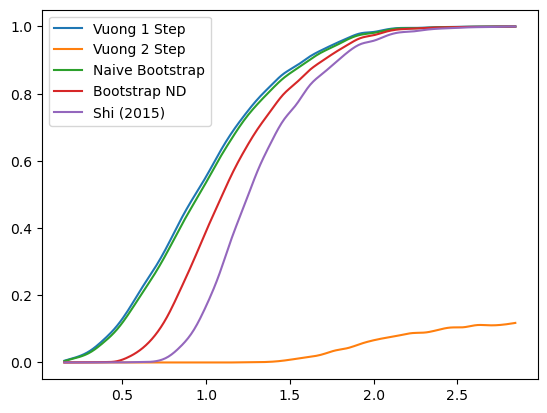

0.1 0.23227910480433808


In [6]:
nobs = 100
c1,c2 = calc_c(nobs)
    
mc_run_power(nobs,c1,c2)
print(c1,c2)

# extra size sims

Quantiles: 1th: 0.68, 5th: 1.58, 10th: 2.86, 30th: 8.26, 50th: 14.73, 70th: 22.17, 90th: 35.20, 95th: 42.20, 99th: 56.66
bonus term 0.6923158444201374 // variance stats 49.41596666169004 //part1 34.903772531645444 //part2 50.41596666169005 49.41596666169004
-1.2896118653386615 0.9210757232334684 2.549735446731394
-2.6742435541789367 0.9210757232334684 1.1651037578911194
---
Quantiles: 1th: 0.70, 5th: 1.78, 10th: 3.13, 30th: 9.24, 50th: 16.22, 70th: 25.04, 90th: 40.08, 95th: 48.30, 99th: 64.11
bonus term 0.5909665408562317 // variance stats 58.062180544222564 //part1 34.903772531645444 //part2 59.06218054422257 58.062180544222564
-1.3348291958634841 0.9765441883070962 2.57885918659865
-2.5167622775759475 0.9765441883070962 1.3969261048861867
---
Quantiles: 1th: 0.85, 5th: 1.86, 10th: 3.29, 30th: 9.06, 50th: 15.46, 70th: 23.36, 90th: 37.31, 95th: 43.63, 99th: 57.78
bonus term 1.0028325289592768 // variance stats 33.80518583483526 //part1 34.903772531645444 //part2 34.80518583483526 33.80

Quantiles: 1th: 0.78, 5th: 1.91, 10th: 3.18, 30th: 9.92, 50th: 17.56, 70th: 26.68, 90th: 42.08, 95th: 50.00, 99th: 67.95
bonus term 2.1261578390753235 // variance stats 15.416360013434028 //part1 34.903772531645444 //part2 16.41636001343403 15.416360013434028
0.39791504499736136 -0.4880450126586366 4.15541670007477
-3.8544006331532854 -0.4880450126586366 -0.09689897807587709
---
Quantiles: 1th: 0.71, 5th: 1.88, 10th: 3.16, 30th: 8.90, 50th: 15.38, 70th: 23.68, 90th: 38.73, 95th: 46.54, 99th: 60.91
bonus term 1.2573303524188102 // variance stats 26.760224243770725 //part1 34.903772531645444 //part2 27.760224243770725 26.760224243770725
-0.5764378490028514 0.16554200436035973 3.208677528796404
-3.091098553840472 0.16554200436035973 0.6940168239587837
---
Quantiles: 1th: 0.78, 5th: 2.11, 10th: 4.08, 30th: 11.81, 50th: 20.52, 70th: 31.10, 90th: 49.80, 95th: 59.94, 99th: 79.31
bonus term 3.533663140502155 // variance stats 8.87750420564576 //part1 34.903772531645444 //part2 9.87750420564576

Quantiles: 1th: 0.65, 5th: 1.49, 10th: 2.68, 30th: 8.15, 50th: 14.02, 70th: 21.82, 90th: 35.05, 95th: 42.90, 99th: 55.48
bonus term 4.50893691114452 // variance stats 6.741020382293548 //part1 34.903772531645444 //part2 7.741020382293547 6.741020382293548
2.7075074999566695 -1.3438849657572938 6.175324984680574
-6.310366322332371 -1.3438849657572938 -2.842548837608466
---
Quantiles: 1th: 0.57, 5th: 1.77, 10th: 3.24, 30th: 9.49, 50th: 16.74, 70th: 25.48, 90th: 39.69, 95th: 47.56, 99th: 65.03
bonus term 12.597907457260472 // variance stats 1.7706008041462136 //part1 34.903772531645444 //part2 2.7706008041462136 1.7706008041462136
11.509150355235159 -4.463299162595591 13.724773826787548
-13.686664559285786 -4.463299162595591 -11.471041087733397
---
Quantiles: 1th: 0.64, 5th: 1.69, 10th: 2.88, 30th: 8.47, 50th: 14.59, 70th: 22.62, 90th: 36.24, 95th: 42.44, 99th: 56.91
bonus term 1.6896326507274293 // variance stats 19.657610112244512 //part1 34.903772531645444 //part2 20.657610112244512 19

Quantiles: 1th: 0.74, 5th: 1.93, 10th: 3.48, 30th: 10.37, 50th: 18.14, 70th: 28.32, 90th: 44.60, 95th: 53.72, 99th: 70.16
bonus term 1.8344502117864816 // variance stats 18.026830113668964 //part1 34.903772531645444 //part2 19.026830113668964 18.026830113668964
-0.014787322787956195 -0.39255786749165367 3.6202616579401785
-3.6836877463609192 -0.39255786749165367 -0.04863876563278431
---
Quantiles: 1th: 0.74, 5th: 1.78, 10th: 3.13, 30th: 9.40, 50th: 16.17, 70th: 24.75, 90th: 39.65, 95th: 47.04, 99th: 62.62
bonus term 2.7699637308907232 // variance stats 11.600804892279804 //part1 34.903772531645444 //part2 12.600804892279804 11.600804892279804
0.9074317715502552 -0.722403721193129 4.577941220680122
-4.632495690231191 -0.722403721193129 -0.9619862411013244
---
Quantiles: 1th: 0.65, 5th: 1.65, 10th: 2.88, 30th: 8.12, 50th: 14.61, 70th: 22.76, 90th: 36.28, 95th: 42.98, 99th: 55.80
bonus term 2.484441684612174 // variance stats 13.048940149341435 //part1 34.903772531645444 //part2 14.048940

Quantiles: 1th: 0.77, 5th: 1.89, 10th: 3.42, 30th: 9.91, 50th: 17.34, 70th: 26.67, 90th: 41.62, 95th: 51.28, 99th: 65.78
bonus term 2.35201101560087 // variance stats 13.839969838631282 //part1 34.903772531645444 //part2 14.839969838631282 13.839969838631282
0.5366462450074825 -0.7828560433177747 4.221655119938055
-4.167375786194257 -0.7828560433177747 -0.4823669112636849
---
Quantiles: 1th: 0.64, 5th: 1.69, 10th: 3.08, 30th: 9.05, 50th: 16.20, 70th: 24.95, 90th: 39.67, 95th: 48.12, 99th: 63.45
bonus term 4.045847465883776 // variance stats 7.627060912693367 //part1 34.903772531645444 //part2 8.627060912693368 7.627060912693367
2.3262255574660475 -1.6466449525684586 5.68037580725844
-5.765469374301505 -1.6466449525684586 -2.411319124509112
---
Quantiles: 1th: 0.74, 5th: 2.06, 10th: 3.83, 30th: 11.78, 50th: 20.40, 70th: 31.02, 90th: 49.41, 95th: 58.91, 99th: 75.81
bonus term 5.216618811856597 // variance stats 5.690880394081004 //part1 34.903772531645444 //part2 6.690880394081004 5.6908

Quantiles: 1th: 0.74, 5th: 1.87, 10th: 3.65, 30th: 11.36, 50th: 19.42, 70th: 29.42, 90th: 46.53, 95th: 55.93, 99th: 75.36
bonus term 0.5915528769010326 // variance stats 58.00363922578788 //part1 34.903772531645444 //part2 59.00363922578788 58.00363922578788
-1.2108348673162543 0.6495477697971966 2.4890790771278275
-2.3939406211183196 0.6495477697971966 1.3059733233257618
---
Quantiles: 1th: 0.67, 5th: 1.82, 10th: 2.98, 30th: 9.31, 50th: 16.48, 70th: 25.05, 90th: 40.60, 95th: 48.82, 99th: 64.15
bonus term 2.79223472353944 // variance stats 11.500300292591943 //part1 34.903772531645444 //part2 12.500300292591943 11.500300292591943
1.1395381120086923 -0.958786605331238 4.5574781829236235
-4.444931335070188 -0.958786605331238 -1.026991264155257
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.78, 5th: 1.94, 10th: 3.27, 30th: 9.38, 50th: 16.31, 70th: 25.38, 90th: 40.28, 95th: 47.51, 99th: 61.94
bonus term 1.6289151196978184 // variance stats 20.427618977544068 //part1 34.90377253164544

Quantiles: 1th: 0.66, 5th: 1.79, 10th: 3.16, 30th: 9.12, 50th: 16.12, 70th: 24.54, 90th: 39.80, 95th: 47.71, 99th: 60.33
bonus term 2.734040345419703 // variance stats 11.76637069022014 //part1 34.903772531645444 //part2 12.766370690220139 11.76637069022014
0.962642387848484 -1.6302860382554074 4.453799568414483
-4.505438302990922 -1.6302860382554074 -1.014281122424923
---
Quantiles: 1th: 0.76, 5th: 1.96, 10th: 3.49, 30th: 10.09, 50th: 17.36, 70th: 26.85, 90th: 42.57, 95th: 50.53, 99th: 65.06
bonus term 0.8727125184007216 // variance stats 38.9945821742169 //part1 34.903772531645444 //part2 39.9945821742169 38.9945821742169
-1.0276419435306505 0.10007246219216809 2.7959164240485137
-2.7730669803320938 0.10007246219216809 1.0504913872470703
---
Quantiles: 1th: 0.80, 5th: 2.10, 10th: 3.47, 30th: 10.70, 50th: 18.40, 70th: 28.34, 90th: 45.49, 95th: 55.76, 99th: 74.76
bonus term 1.745851379278264 // variance stats 18.992407684825203 //part1 34.903772531645444 //part2 19.9924076848252 18.992

Quantiles: 1th: 0.78, 5th: 1.91, 10th: 3.54, 30th: 10.86, 50th: 18.43, 70th: 28.17, 90th: 44.23, 95th: 52.32, 99th: 68.23
bonus term 1.409733782068195 // variance stats 23.7591233008822 //part1 34.903772531645444 //part2 24.7591233008822 23.7591233008822
-0.4440667900494494 -0.8298469491876743 3.2021005676448873
-3.2635343541858393 -0.8298469491876743 0.38263300350849694
---
Quantiles: 1th: 0.77, 5th: 1.82, 10th: 3.01, 30th: 8.42, 50th: 15.15, 70th: 23.29, 90th: 37.56, 95th: 44.49, 99th: 57.21
bonus term 2.391584988814781 // variance stats 13.594410273892468 //part1 34.903772531645444 //part2 14.594410273892466 13.594410273892468
0.5532194246672286 -2.2876181553996844 4.243039776669648
-4.229950552962333 -2.2876181553996844 -0.5401302009599142
---
Quantiles: 1th: 0.61, 5th: 1.57, 10th: 2.99, 30th: 8.48, 50th: 15.07, 70th: 23.06, 90th: 35.90, 95th: 42.78, 99th: 54.53
bonus term 0.9216550609893643 // variance stats 36.87075448180956 //part1 34.903772531645444 //part2 37.87075448180957 36

Quantiles: 1th: 0.75, 5th: 1.90, 10th: 3.18, 30th: 10.07, 50th: 17.30, 70th: 26.34, 90th: 42.25, 95th: 50.75, 99th: 65.31
bonus term 2.0191902131042143 // variance stats 16.28602501395147 //part1 34.903772531645444 //part2 17.28602501395147 16.28602501395147
0.18092587351561337 -3.1763101074630304 3.737784177446018
-3.8574545526928152 -3.1763101074630304 -0.300596248762411
---
Quantiles: 1th: 0.74, 5th: 1.75, 10th: 3.04, 30th: 9.42, 50th: 16.31, 70th: 25.11, 90th: 39.79, 95th: 47.95, 99th: 62.51
bonus term 2.303203280411715 // variance stats 14.154447212061164 //part1 34.903772531645444 //part2 15.154447212061164 14.154447212061164
0.5469305810704593 -1.9289539990586082 4.219512012040643
-4.059475979752971 -1.9289539990586082 -0.38689454878278695
---
Quantiles: 1th: 0.67, 5th: 1.90, 10th: 3.34, 30th: 9.66, 50th: 16.02, 70th: 24.30, 90th: 38.48, 95th: 46.05, 99th: 63.08
bonus term 0.5360855201088676 // variance stats 64.10859036923293 //part1 34.903772531645444 //part2 65.10859036923293

Quantiles: 1th: 0.80, 5th: 1.90, 10th: 3.11, 30th: 9.32, 50th: 16.20, 70th: 24.33, 90th: 37.79, 95th: 45.06, 99th: 59.47
bonus term 1.6792098787336582 // variance stats 19.78583086824585 //part1 34.903772531645444 //part2 20.785830868245846 19.78583086824585
-0.2196039688567701 -2.457037450423041 3.5612283620751546
-3.5780237263240866 -2.457037450423041 0.2028086046078382
---
Quantiles: 1th: 0.83, 5th: 2.18, 10th: 3.67, 30th: 10.32, 50th: 17.98, 70th: 27.66, 90th: 43.37, 95th: 51.55, 99th: 68.51
bonus term 1.3318473586568467 // variance stats 25.20703664333239 //part1 34.903772531645444 //part2 26.20703664333239 25.20703664333239
-0.4998975628677046 -1.4567002192432728 3.3098575177303045
-3.163592280181398 -1.4567002192432728 0.6461628004166111
---
Quantiles: 1th: 0.75, 5th: 1.91, 10th: 3.17, 30th: 9.84, 50th: 16.98, 70th: 26.27, 90th: 41.31, 95th: 49.57, 99th: 63.76
bonus term 1.0082598620956733 // variance stats 33.617833996781116 //part1 34.903772531645444 //part2 34.617833996781116

Quantiles: 1th: 0.90, 5th: 2.11, 10th: 3.95, 30th: 10.90, 50th: 18.81, 70th: 28.53, 90th: 45.10, 95th: 54.04, 99th: 71.13
bonus term 0.4702974761348506 // variance stats 73.2163721959616 //part1 34.903772531645444 //part2 74.2163721959616 73.2163721959616
-1.5816613365942043 0.7216683448148444 2.4194887363019126
-2.5222562888639053 0.7216683448148444 1.4788937840322114
---
Quantiles: 1th: 0.79, 5th: 2.08, 10th: 3.47, 30th: 9.37, 50th: 15.88, 70th: 24.72, 90th: 40.12, 95th: 48.41, 99th: 63.13
bonus term 0.7577911669377212 // variance stats 45.05988305814337 //part1 34.903772531645444 //part2 46.05988305814337 45.05988305814337
-1.0218248508735068 -0.21638556831302008 2.570030290902627
-2.537407184748949 -0.21638556831302008 1.0544479570271843
---
Quantiles: 1th: 0.71, 5th: 1.79, 10th: 2.83, 30th: 8.50, 50th: 14.64, 70th: 22.14, 90th: 35.20, 95th: 42.67, 99th: 55.33
bonus term 1.911834274995786 // variance stats 17.25669357859084 //part1 34.903772531645444 //part2 18.25669357859084 17.25

Quantiles: 1th: 0.63, 5th: 1.82, 10th: 3.34, 30th: 9.66, 50th: 16.78, 70th: 25.43, 90th: 40.63, 95th: 48.00, 99th: 63.81
bonus term 0.5102246157509783 // variance stats 67.40864092821558 //part1 34.903772531645444 //part2 68.40864092821558 67.40864092821558
-1.5555427593321909 0.26067616402683097 2.437621983292016
-2.5759919908341473 0.26067616402683097 1.4171727517900592
---
Quantiles: 1th: 0.68, 5th: 1.63, 10th: 2.79, 30th: 8.25, 50th: 14.49, 70th: 22.20, 90th: 34.69, 95th: 41.74, 99th: 55.51
bonus term 0.9706884304890183 // variance stats 34.9577506389578 //part1 34.903772531645444 //part2 35.9577506389578 34.9577506389578
-0.9222384715340661 -0.708450593625828 2.994391648130399
-2.8636153325121025 -0.708450593625828 1.0530147871523627
---
Quantiles: 1th: 0.63, 5th: 1.73, 10th: 3.15, 30th: 9.27, 50th: 15.96, 70th: 24.52, 90th: 39.41, 95th: 47.94, 99th: 61.62
bonus term 0.6733589455658849 // variance stats 50.83531422800453 //part1 34.903772531645444 //part2 51.83531422800453 50.8353

Quantiles: 1th: 0.74, 5th: 1.93, 10th: 3.37, 30th: 9.81, 50th: 17.08, 70th: 26.38, 90th: 42.06, 95th: 50.23, 99th: 64.99
bonus term 0.4615335186110893 // variance stats 74.62565041144295 //part1 34.903772531645444 //part2 75.62565041144296 74.62565041144295
-1.600568463887057 0.5270501368343595 2.4486463534561884
-2.523635501109236 0.5270501368343595 1.5255793162340097
---
Quantiles: 1th: 0.70, 5th: 1.84, 10th: 3.25, 30th: 8.90, 50th: 15.18, 70th: 23.23, 90th: 36.78, 95th: 43.67, 99th: 57.92
bonus term 0.8460476473632436 // variance stats 40.255090821923645 //part1 34.903772531645444 //part2 41.255090821923645 40.255090821923645
-1.1839735266309614 -1.2457573844613734 2.689732118583661
-2.8760688213574483 -1.2457573844613734 0.9976368238571738
---
Quantiles: 1th: 0.79, 5th: 2.03, 10th: 3.61, 30th: 10.14, 50th: 17.78, 70th: 26.49, 90th: 42.43, 95th: 51.28, 99th: 66.96
bonus term 3.131441264504896 // variance stats 10.146232543871132 //part1 34.903772531645444 //part2 11.146232543871132 

Quantiles: 1th: 0.80, 5th: 2.02, 10th: 3.31, 30th: 9.93, 50th: 17.48, 70th: 27.29, 90th: 43.05, 95th: 50.79, 99th: 67.12
bonus term 0.6909748665615172 // variance stats 49.513809142344506 //part1 34.903772531645444 //part2 50.513809142344506 49.513809142344506
-1.321367834087681 -1.0117905199450048 2.59069674327228
-2.7033175672107155 -1.0117905199450048 1.2087470101492457
---
Quantiles: 1th: 0.62, 5th: 1.64, 10th: 2.94, 30th: 8.46, 50th: 14.67, 70th: 22.29, 90th: 35.88, 95th: 42.78, 99th: 55.18
bonus term 0.4530141768732885 // variance stats 76.04785923599978 //part1 34.903772531645444 //part2 77.04785923599978 76.04785923599978
-1.516977568963796 0.737864784533548 2.361282254143142
-2.4230059227103733 0.737864784533548 1.4552539003965652
---
Quantiles: 1th: 0.71, 5th: 1.88, 10th: 3.29, 30th: 9.87, 50th: 17.34, 70th: 26.94, 90th: 42.50, 95th: 50.59, 99th: 65.90
bonus term 0.42482220053233627 // variance stats 81.16089575334861 //part1 34.903772531645444 //part2 82.16089575334861 81.16

0.7692307692307693 [0.95142857 0.         0.04857143]
Quantiles: 1th: 0.75, 5th: 1.86, 10th: 3.24, 30th: 9.63, 50th: 17.00, 70th: 26.14, 90th: 42.24, 95th: 50.86, 99th: 67.38
bonus term 0.41534639765183956 // variance stats 83.03533226476475 //part1 34.903772531645444 //part2 84.03533226476475 83.03533226476475
-1.7933363922777523 0.38111653140815677 2.250822646232211
-2.624029187581431 0.38111653140815677 1.420129850928532
---
Quantiles: 1th: 0.72, 5th: 1.87, 10th: 3.40, 30th: 10.69, 50th: 18.81, 70th: 29.31, 90th: 46.90, 95th: 55.88, 99th: 72.67
bonus term 0.5020192691429141 // variance stats 68.52675858684836 //part1 34.903772531645444 //part2 69.52675858684836 68.52675858684836
-1.3241004539508368 -0.23715988157770473 2.336199769243094
-2.328138992236665 -0.23715988157770473 1.3321612309572657
---
Quantiles: 1th: 0.74, 5th: 1.89, 10th: 3.44, 30th: 10.33, 50th: 17.72, 70th: 26.70, 90th: 42.45, 95th: 50.66, 99th: 67.08
bonus term 0.7239752245986605 // variance stats 47.21128036666521

Quantiles: 1th: 0.76, 5th: 1.77, 10th: 3.06, 30th: 8.35, 50th: 14.73, 70th: 22.74, 90th: 36.66, 95th: 44.09, 99th: 58.28
bonus term 0.9046993537040967 // variance stats 37.580521129742664 //part1 34.903772531645444 //part2 38.58052112974267 37.580521129742664
-1.0679124824974517 -1.4975868574726174 2.8188113650562707
-2.8773111899056447 -1.4975868574726174 1.0094126576480775
---
Quantiles: 1th: 0.76, 5th: 1.78, 10th: 3.19, 30th: 9.67, 50th: 16.48, 70th: 25.12, 90th: 39.54, 95th: 48.38, 99th: 64.47
bonus term 0.5987249375241777 // variance stats 57.29684107693603 //part1 34.903772531645444 //part2 58.29684107693603 57.29684107693603
-1.2588488718917106 -0.7239413411045479 2.4309137708309803
-2.4562987469400657 -0.7239413411045479 1.2334638957826247
---
Quantiles: 1th: 0.70, 5th: 1.70, 10th: 2.90, 30th: 8.87, 50th: 15.23, 70th: 23.19, 90th: 37.68, 95th: 44.57, 99th: 57.68
bonus term 0.7598785461785057 // variance stats 44.933356991297494 //part1 34.903772531645444 //part2 45.933356991297

Quantiles: 1th: 0.62, 5th: 1.68, 10th: 2.98, 30th: 9.08, 50th: 15.79, 70th: 24.07, 90th: 37.68, 95th: 44.95, 99th: 59.16
bonus term 0.4693771879457768 // variance stats 73.36188512782512 //part1 34.903772531645444 //part2 74.36188512782513 73.36188512782512
-1.6673961075453545 -0.362525632182851 2.3423223793161774
-2.6061504834369082 -0.362525632182851 1.4035680034246236
---
Quantiles: 1th: 0.74, 5th: 1.75, 10th: 3.25, 30th: 9.27, 50th: 15.98, 70th: 24.87, 90th: 39.74, 95th: 46.91, 99th: 61.19
bonus term 0.5529874555360241 // variance stats 62.118561157616796 //part1 34.903772531645444 //part2 63.1185611576168 62.118561157616796
-1.3544200622605855 -0.5879318311243438 2.424972713763038
-2.460394973332634 -0.5879318311243438 1.3189978026909894
---
Quantiles: 1th: 0.68, 5th: 1.84, 10th: 3.41, 30th: 9.91, 50th: 17.22, 70th: 25.83, 90th: 41.89, 95th: 50.31, 99th: 64.16
bonus term 0.40562158427003125 // variance stats 85.05008679323441 //part1 34.903772531645444 //part2 86.05008679323443 85

Quantiles: 1th: 0.75, 5th: 2.04, 10th: 3.50, 30th: 9.76, 50th: 16.79, 70th: 25.24, 90th: 40.96, 95th: 48.87, 99th: 65.13
bonus term 0.4746425012992183 // variance stats 72.53697242894359 //part1 34.903772531645444 //part2 73.53697242894359 72.53697242894359
-1.5065562589619266 -0.44364273148622047 2.271561990966924
-2.4558412615603635 -0.44364273148622047 1.322276988368487
---
Quantiles: 1th: 0.65, 5th: 1.75, 10th: 2.96, 30th: 9.11, 50th: 16.16, 70th: 24.94, 90th: 39.63, 95th: 46.54, 99th: 61.66
bonus term 0.3439556828722294 // variance stats 100.47752826811497 //part1 34.903772531645444 //part2 101.47752826811497 100.47752826811497
-1.6797638864573756 0.5116538389203846 2.215655646366479
-2.3676752522018343 0.5116538389203846 1.5277442806220203
---
Quantiles: 1th: 0.84, 5th: 1.89, 10th: 3.02, 30th: 8.40, 50th: 14.88, 70th: 22.75, 90th: 36.27, 95th: 43.23, 99th: 57.36
bonus term 0.8037405622499919 // variance stats 42.42666548262264 //part1 34.903772531645444 //part2 43.426665482622646

Quantiles: 1th: 0.70, 5th: 1.97, 10th: 3.51, 30th: 10.62, 50th: 18.51, 70th: 28.20, 90th: 44.90, 95th: 53.89, 99th: 69.14
bonus term 0.3189450156890675 // variance stats 108.43507756732703 //part1 34.903772531645444 //part2 109.43507756732703 108.43507756732703
-1.6225066480713235 0.11953797245533575 2.3340855549049726
-2.2603966794494585 0.11953797245533575 1.6961955235268376
---
Quantiles: 1th: 0.82, 5th: 2.04, 10th: 3.53, 30th: 10.00, 50th: 16.93, 70th: 25.58, 90th: 41.36, 95th: 49.09, 99th: 63.65
bonus term 0.5678906826956936 // variance stats 60.462132757597566 //part1 34.903772531645444 //part2 61.46213275759757 60.462132757597566
-1.49736586001669 -1.1306445836344636 2.389076848210775
-2.6331472254080768 -1.1306445836344636 1.253295482819388
---
Quantiles: 1th: 0.60, 5th: 1.87, 10th: 3.31, 30th: 9.55, 50th: 16.50, 70th: 25.36, 90th: 40.36, 95th: 47.47, 99th: 64.89
bonus term 0.36162941767067747 // variance stats 95.51806746383397 //part1 34.903772531645444 //part2 96.51806746383

Quantiles: 1th: 0.82, 5th: 2.11, 10th: 3.60, 30th: 10.24, 50th: 17.65, 70th: 26.69, 90th: 42.79, 95th: 51.30, 99th: 66.55
bonus term 0.4890885711890702 // variance stats 70.36493180936027 //part1 34.903772531645444 //part2 71.36493180936027 70.36493180936027
-1.443868129789734 -0.3653479454044506 2.5044741584650847
-2.4220452721678742 -0.3653479454044506 1.5262970160869447
---
Quantiles: 1th: 0.82, 5th: 2.06, 10th: 3.38, 30th: 9.57, 50th: 16.72, 70th: 25.97, 90th: 41.06, 95th: 48.46, 99th: 65.03
bonus term 0.2779574167858652 // variance stats 124.57237340615687 //part1 34.903772531645444 //part2 125.57237340615687 124.57237340615687
-1.6456002491646222 1.0635382682654764 2.225471325617899
-2.201515082736353 1.0635382682654764 1.6695564920461685
---
1.076923076923077 [0.95714286 0.         0.04285714]
Quantiles: 1th: 0.84, 5th: 1.99, 10th: 3.47, 30th: 10.96, 50th: 18.87, 70th: 28.87, 90th: 46.71, 95th: 55.73, 99th: 72.15
bonus term 0.3820601362677295 // variance stats 90.35675046502769 

Quantiles: 1th: 0.71, 5th: 1.85, 10th: 3.11, 30th: 9.22, 50th: 16.65, 70th: 26.01, 90th: 41.03, 95th: 49.17, 99th: 64.38
bonus term 0.35275160748109113 // variance stats 97.94716789778603 //part1 34.903772531645444 //part2 98.94716789778603 97.94716789778603
-1.6053270452065287 -0.02562020912071296 2.2058846053975114
-2.3108302601687107 -0.02562020912071296 1.5003813904353291
---
Quantiles: 1th: 0.62, 5th: 1.64, 10th: 2.79, 30th: 8.98, 50th: 15.28, 70th: 24.27, 90th: 37.66, 95th: 44.51, 99th: 59.60
bonus term 0.3493318430303214 // variance stats 98.91580563875436 //part1 34.903772531645444 //part2 99.91580563875436 98.91580563875436
-1.6210878371628665 0.06662534751516234 2.337851468531683
-2.3197515232235095 0.06662534751516234 1.63918778247104
---
Quantiles: 1th: 0.80, 5th: 1.90, 10th: 3.29, 30th: 9.21, 50th: 16.05, 70th: 24.19, 90th: 37.94, 95th: 45.30, 99th: 60.15
bonus term 0.6841211406836551 // variance stats 50.019871271286014 //part1 34.903772531645444 //part2 51.01987127128602

Quantiles: 1th: 0.56, 5th: 1.68, 10th: 2.98, 30th: 9.06, 50th: 15.75, 70th: 24.49, 90th: 38.63, 95th: 45.73, 99th: 59.45
bonus term 0.4246101293937805 // variance stats 81.20193093715841 //part1 34.903772531645444 //part2 82.20193093715841 81.20193093715841
-1.6661061407824667 -0.5368620193267343 2.2782052117543508
-2.5153263995700277 -0.5368620193267343 1.4289849529667895
---
Quantiles: 1th: 0.82, 5th: 1.86, 10th: 3.05, 30th: 9.26, 50th: 15.80, 70th: 23.94, 90th: 38.34, 95th: 45.89, 99th: 58.47
bonus term 0.30847780723409973 // variance stats 112.1484071564261 //part1 34.903772531645444 //part2 113.1484071564261 112.1484071564261
-1.7516625279604883 0.608264007425833 2.285165136749424
-2.3686181424286876 0.608264007425833 1.6682095222812243
---
Quantiles: 1th: 0.67, 5th: 1.78, 10th: 2.99, 30th: 8.29, 50th: 14.15, 70th: 21.58, 90th: 33.46, 95th: 40.59, 99th: 53.08
bonus term 0.30927523391797707 // variance stats 111.85666844213681 //part1 34.903772531645444 //part2 112.85666844213681 1

Quantiles: 1th: 0.75, 5th: 1.97, 10th: 3.32, 30th: 9.50, 50th: 16.17, 70th: 24.91, 90th: 40.30, 95th: 48.44, 99th: 63.65
bonus term 0.3789509436549888 // variance stats 91.1063085237311 //part1 34.903772531645444 //part2 92.1063085237311 91.1063085237311
-1.576862920707522 -0.735047661810376 2.48572644085751
-2.3347648080175 -0.735047661810376 1.727824553547532
---
Quantiles: 1th: 0.73, 5th: 1.78, 10th: 2.98, 30th: 8.49, 50th: 14.77, 70th: 22.57, 90th: 35.79, 95th: 42.13, 99th: 55.01
bonus term 0.4204912439804851 // variance stats 82.00713280313946 //part1 34.903772531645444 //part2 83.00713280313946 82.00713280313946
-1.4849987008210441 -0.7176225529115893 2.43890593154061
-2.3259811887820145 -0.7176225529115893 1.5979234435796397
---
Quantiles: 1th: 0.86, 5th: 2.19, 10th: 3.76, 30th: 11.14, 50th: 19.63, 70th: 29.87, 90th: 47.77, 95th: 55.73, 99th: 74.31
bonus term 0.4166174870765293 // variance stats 82.77894258968995 //part1 34.903772531645444 //part2 83.77894258968995 82.7789425896

Quantiles: 1th: 0.65, 5th: 1.71, 10th: 3.15, 30th: 9.31, 50th: 15.83, 70th: 24.07, 90th: 37.65, 95th: 44.19, 99th: 58.90
bonus term 0.37842589702553764 // variance stats 91.23410132866779 //part1 34.903772531645444 //part2 92.23410132866779 91.23410132866779
-1.4709618883953393 -1.1067136243930358 2.196919061317821
-2.2278136824464143 -1.1067136243930358 1.4400672672667458
---
Quantiles: 1th: 0.75, 5th: 1.69, 10th: 3.18, 30th: 8.98, 50th: 15.75, 70th: 23.94, 90th: 38.21, 95th: 45.08, 99th: 58.65
bonus term 0.43296690172030305 // variance stats 79.61533662957291 //part1 34.903772531645444 //part2 80.61533662957291 79.61533662957291
-1.4976129969207281 -1.3225888684563707 2.373949447691451
-2.3635468003613345 -1.3225888684563707 1.508015644250845
---
Quantiles: 1th: 0.61, 5th: 1.69, 10th: 3.13, 30th: 9.19, 50th: 16.07, 70th: 24.60, 90th: 39.05, 95th: 46.40, 99th: 61.83
bonus term 0.3086075914610781 // variance stats 112.1008228488363 //part1 34.903772531645444 //part2 113.10082284883632 

Quantiles: 1th: 0.78, 5th: 2.10, 10th: 3.88, 30th: 11.52, 50th: 20.10, 70th: 30.53, 90th: 47.92, 95th: 57.39, 99th: 75.61
bonus term 0.279801623510471 // variance stats 123.74471053360145 //part1 34.903772531645444 //part2 124.74471053360145 123.74471053360145
-1.610061716564087 -0.01533703906780077 2.3018974116072473
-2.169664963585029 -0.01533703906780077 1.742294164586305
---
Quantiles: 1th: 0.73, 5th: 1.98, 10th: 3.36, 30th: 9.68, 50th: 16.51, 70th: 25.51, 90th: 40.02, 95th: 48.38, 99th: 65.07
bonus term 0.37422316069501427 // variance stats 92.2699421030529 //part1 34.903772531645444 //part2 93.2699421030529 92.2699421030529
-1.5652521172595264 -0.5885118220786103 2.415582060980014
-2.313698438649555 -0.5885118220786103 1.6671357395899853
---
Quantiles: 1th: 0.83, 5th: 2.25, 10th: 3.92, 30th: 11.99, 50th: 21.20, 70th: 32.47, 90th: 51.75, 95th: 61.61, 99th: 79.83
bonus term 0.28755250525763376 // variance stats 120.38225852135515 //part1 34.903772531645444 //part2 121.3822585213551

Quantiles: 1th: 0.88, 5th: 2.25, 10th: 3.71, 30th: 11.37, 50th: 19.56, 70th: 30.08, 90th: 46.66, 95th: 56.72, 99th: 74.60
bonus term 0.3241238493785656 // variance stats 106.6865296971067 //part1 34.903772531645444 //part2 107.6865296971067 106.6865296971067
-1.8452554081685164 -0.2751442801609279 2.3118957050191544
-2.4935031069256475 -0.2751442801609279 1.6636480062620234
---
Quantiles: 1th: 0.81, 5th: 2.01, 10th: 3.81, 30th: 11.47, 50th: 19.73, 70th: 30.59, 90th: 48.55, 95th: 57.91, 99th: 74.05
bonus term 0.2291608453514154 // variance stats 151.3112400729755 //part1 34.903772531645444 //part2 152.3112400729755 151.3112400729755
-1.7314884244360345 0.7748851038945473 2.2861019863500593
-2.189810115138865 0.7748851038945473 1.8277802956472287
---
Quantiles: 1th: 0.80, 5th: 2.11, 10th: 3.68, 30th: 10.72, 50th: 18.83, 70th: 29.20, 90th: 45.97, 95th: 55.12, 99th: 73.68
bonus term 0.24522009318248475 // variance stats 141.33651116701597 //part1 34.903772531645444 //part2 142.336511167015

Quantiles: 1th: 0.74, 5th: 1.81, 10th: 3.00, 30th: 8.95, 50th: 16.26, 70th: 24.74, 90th: 40.24, 95th: 48.43, 99th: 63.13
bonus term 0.35082741408165347 // variance stats 98.48986632932211 //part1 34.903772531645444 //part2 99.48986632932211 98.48986632932211
-1.702284862449649 -1.5249342880500942 2.2108738961740224
-2.403939690612956 -1.5249342880500942 1.5092190680107154
---
Quantiles: 1th: 0.60, 5th: 1.54, 10th: 2.86, 30th: 8.36, 50th: 14.47, 70th: 21.81, 90th: 34.12, 95th: 41.30, 99th: 55.11
bonus term 0.27841608131145673 // variance stats 124.36550463333155 //part1 34.903772531645444 //part2 125.36550463333155 124.36550463333155
-1.6502831258061172 0.8115646249051668 2.3134344138277187
-2.207115288429031 0.8115646249051668 1.7566022512048054
---
Quantiles: 1th: 0.74, 5th: 1.82, 10th: 3.40, 30th: 9.05, 50th: 15.35, 70th: 23.65, 90th: 37.65, 95th: 44.70, 99th: 58.28
bonus term 0.3578172193402669 // variance stats 96.54637464345628 //part1 34.903772531645444 //part2 97.54637464345628 

Quantiles: 1th: 0.72, 5th: 1.82, 10th: 3.16, 30th: 10.18, 50th: 17.82, 70th: 27.44, 90th: 43.84, 95th: 50.91, 99th: 68.77
bonus term 0.20419742786662462 // variance stats 169.93149946258623 //part1 34.903772531645444 //part2 170.93149946258626 169.93149946258623
-1.7655883231752147 1.0021770651255284 2.106991398264786
-2.173983178908464 1.0021770651255284 1.6985965425315368
---
Quantiles: 1th: 0.72, 5th: 1.84, 10th: 3.31, 30th: 9.45, 50th: 16.32, 70th: 25.02, 90th: 39.91, 95th: 48.02, 99th: 64.48
bonus term 0.32981608070296736 // variance stats 104.82798891203794 //part1 34.903772531645444 //part2 105.82798891203794 104.82798891203794
-1.5632966209693164 -1.1992124220102611 2.3909631591188405
-2.2229287823752513 -1.1992124220102611 1.7313309977129059
---
Quantiles: 1th: 0.79, 5th: 1.96, 10th: 3.33, 30th: 9.51, 50th: 16.19, 70th: 24.38, 90th: 39.22, 95th: 46.86, 99th: 62.56
bonus term 0.29985633237017195 // variance stats 115.40165227045068 //part1 34.903772531645444 //part2 116.4016522

1.6153846153846154 [0.95285714 0.00428571 0.04285714]
Quantiles: 1th: 0.57, 5th: 1.68, 10th: 2.96, 30th: 9.22, 50th: 16.10, 70th: 24.56, 90th: 38.82, 95th: 46.61, 99th: 61.63
bonus term 0.22697498272050073 // variance stats 152.77806008967207 //part1 34.903772531645444 //part2 153.77806008967207 152.77806008967207
-1.5961653367870647 0.921768355644906 2.1277045347005052
-2.0501153022280665 0.921768355644906 1.6737545692595037
---
Quantiles: 1th: 0.78, 5th: 2.04, 10th: 3.41, 30th: 9.92, 50th: 17.36, 70th: 26.40, 90th: 42.67, 95th: 50.69, 99th: 66.84
bonus term 0.20782647597004006 // variance stats 166.94670827540332 //part1 34.903772531645444 //part2 167.94670827540335 166.94670827540332
-1.6308752179141432 0.7062436348095984 2.3664961953766785
-2.0465281698542235 0.7062436348095984 1.9508432434365985
---
Quantiles: 1th: 0.75, 5th: 1.94, 10th: 3.58, 30th: 10.58, 50th: 18.49, 70th: 28.45, 90th: 46.33, 95th: 55.26, 99th: 72.57
bonus term 0.34227036616934664 // variance stats 100.977196922

Quantiles: 1th: 0.63, 5th: 1.66, 10th: 2.67, 30th: 7.73, 50th: 13.16, 70th: 20.22, 90th: 32.60, 95th: 38.31, 99th: 51.77
bonus term 0.25466673482201646 // variance stats 136.05666174280387 //part1 34.903772531645444 //part2 137.05666174280387 136.05666174280387
-1.5914346734718376 0.5888324617207532 2.1723502521519724
-2.1007681431158707 0.5888324617207532 1.6630167825079398
---
Quantiles: 1th: 0.81, 5th: 1.96, 10th: 3.29, 30th: 9.60, 50th: 16.79, 70th: 25.39, 90th: 40.22, 95th: 48.22, 99th: 63.11
bonus term 0.2999726136036202 // variance stats 115.35653039236047 //part1 34.903772531645444 //part2 116.35653039236047 115.35653039236047
-1.629686618797622 -1.268596644914757 2.0967707525246375
-2.229631846004862 -1.268596644914757 1.496825525317397
---
Quantiles: 1th: 0.77, 5th: 1.84, 10th: 3.31, 30th: 9.48, 50th: 16.26, 70th: 25.30, 90th: 40.43, 95th: 48.34, 99th: 63.38
bonus term 0.27188590319126843 // variance stats 127.37654369704876 //part1 34.903772531645444 //part2 128.376543697048

Quantiles: 1th: 0.61, 5th: 1.68, 10th: 3.01, 30th: 8.80, 50th: 15.25, 70th: 23.53, 90th: 37.64, 95th: 44.95, 99th: 59.35
bonus term 0.2274208409488145 // variance stats 152.47657842625432 //part1 34.903772531645444 //part2 153.47657842625432 152.47657842625432
-1.6788444060320797 0.5598262799273855 2.2058125531575725
-2.133686087929709 0.5598262799273855 1.7509708712599437
---
Quantiles: 1th: 0.77, 5th: 1.84, 10th: 3.24, 30th: 9.43, 50th: 16.61, 70th: 25.53, 90th: 39.89, 95th: 46.34, 99th: 62.56
bonus term 0.2192912870297502 // variance stats 158.16625327165968 //part1 34.903772531645444 //part2 159.16625327165968 158.16625327165968
-1.7702782801513586 0.6032763806858437 2.0902875360570303
-2.208860854210859 0.6032763806858437 1.65170496199753
---
Quantiles: 1th: 0.68, 5th: 1.75, 10th: 2.94, 30th: 8.14, 50th: 14.26, 70th: 21.99, 90th: 34.65, 95th: 41.33, 99th: 54.66
bonus term 0.22528032603685555 // variance stats 153.93484560180917 //part1 34.903772531645444 //part2 154.93484560180917

Quantiles: 1th: 0.76, 5th: 2.13, 10th: 3.71, 30th: 10.78, 50th: 19.09, 70th: 29.26, 90th: 46.36, 95th: 55.51, 99th: 72.25
bonus term 0.27702792100414747 // variance stats 124.993699137362 //part1 34.903772531645444 //part2 125.993699137362 124.993699137362
-1.6523008612941241 -1.5802592408362932 2.1181413269289155
-2.206356703302419 -1.5802592408362932 1.5640854849206205
---
Quantiles: 1th: 0.74, 5th: 1.94, 10th: 3.34, 30th: 9.71, 50th: 16.90, 70th: 25.87, 90th: 41.89, 95th: 49.92, 99th: 65.24
bonus term 0.24112073948826274 // variance stats 143.75640961338578 //part1 34.903772531645444 //part2 144.75640961338578 143.75640961338578
-1.6782325194211831 -0.1520741380226242 2.107096406988732
-2.160473998397708 -0.1520741380226242 1.6248549280122062
---
Quantiles: 1th: 0.95, 5th: 1.97, 10th: 3.26, 30th: 9.16, 50th: 16.19, 70th: 25.09, 90th: 38.96, 95th: 46.15, 99th: 60.96
bonus term 0.2822053702171016 // variance stats 122.68216984954553 //part1 34.903772531645444 //part2 123.6821698495455

Quantiles: 1th: 0.67, 5th: 1.66, 10th: 2.88, 30th: 8.72, 50th: 15.07, 70th: 22.95, 90th: 36.09, 95th: 43.05, 99th: 58.02
bonus term 0.2961289418554923 // variance stats 116.8668059695364 //part1 34.903772531645444 //part2 117.8668059695364 116.8668059695364
-1.7965888390242863 -1.4809884709412282 2.164030036627847
-2.3888467227352708 -1.4809884709412282 1.5717721529168618
---
Quantiles: 1th: 0.69, 5th: 1.84, 10th: 3.39, 30th: 9.63, 50th: 16.94, 70th: 26.33, 90th: 41.68, 95th: 50.81, 99th: 66.34
bonus term 0.24754136661589415 // variance stats 140.00177682950684 //part1 34.903772531645444 //part2 141.00177682950684 140.00177682950684
-1.7213755250013296 -1.0379524214180085 2.12969308729635
-2.2164582582331183 -1.0379524214180085 1.634610354064562
---
Quantiles: 1th: 0.76, 5th: 1.91, 10th: 3.57, 30th: 10.49, 50th: 18.44, 70th: 28.19, 90th: 44.10, 95th: 51.81, 99th: 67.34
bonus term 0.2524530894315622 // variance stats 137.25844876858815 //part1 34.903772531645444 //part2 138.258448768588

Quantiles: 1th: 0.68, 5th: 1.82, 10th: 3.17, 30th: 9.35, 50th: 16.55, 70th: 25.00, 90th: 40.03, 95th: 48.11, 99th: 61.90
bonus term 0.23827946933386188 // variance stats 145.48250069224602 //part1 34.903772531645444 //part2 146.48250069224602 145.48250069224602
-1.7583520932015115 -0.6243573959861334 2.1760338325907953
-2.234911031869235 -0.6243573959861334 1.6994748939230715
---
Quantiles: 1th: 0.55, 5th: 1.54, 10th: 2.79, 30th: 8.30, 50th: 14.52, 70th: 22.90, 90th: 36.45, 95th: 44.11, 99th: 57.71
bonus term 0.25505272197359075 // variance stats 135.8492453699809 //part1 34.903772531645444 //part2 136.8492453699809 135.8492453699809
-1.6734329984649157 -0.6864213089500795 2.2179540282323242
-2.183538442412097 -0.6864213089500795 1.7078485842851427
---
1.9230769230769231 [0.96142857 0.00428571 0.03428571]
Quantiles: 1th: 0.76, 5th: 1.90, 10th: 3.33, 30th: 9.48, 50th: 16.26, 70th: 24.83, 90th: 39.55, 95th: 47.28, 99th: 63.20
bonus term 0.21645237569381362 // variance stats 160.253820475

Quantiles: 1th: 0.74, 5th: 1.94, 10th: 3.70, 30th: 10.26, 50th: 18.06, 70th: 27.64, 90th: 43.28, 95th: 51.84, 99th: 68.36
bonus term 0.19903923770900703 // variance stats 174.36126511233093 //part1 34.903772531645444 //part2 175.36126511233095 174.36126511233093
-1.6294997699037477 0.4623048520333819 2.1508740876009904
-2.0275782453217617 0.4623048520333819 1.7527956121829764
---
Quantiles: 1th: 0.62, 5th: 1.87, 10th: 3.39, 30th: 9.85, 50th: 17.21, 70th: 26.50, 90th: 42.48, 95th: 49.76, 99th: 65.55
bonus term 0.17842565074408223 // variance stats 194.6208223766452 //part1 34.903772531645444 //part2 195.6208223766452 194.6208223766452
-1.7647098815875095 0.9013318620331038 2.197497801080984
-2.121561183075674 0.9013318620331038 1.8406464995928196
---
Quantiles: 1th: 0.93, 5th: 2.04, 10th: 3.29, 30th: 9.72, 50th: 17.03, 70th: 26.71, 90th: 41.36, 95th: 49.12, 99th: 66.00
bonus term 0.2035293884700116 // variance stats 170.4925436273702 //part1 34.903772531645444 //part2 171.4925436273702 

Quantiles: 1th: 0.82, 5th: 2.40, 10th: 4.38, 30th: 12.66, 50th: 22.10, 70th: 33.24, 90th: 52.64, 95th: 62.22, 99th: 82.32
bonus term 0.16148611966235835 // variance stats 215.14100706998005 //part1 34.903772531645444 //part2 216.14100706998005 215.14100706998005
-1.8896615331126996 0.5860851820596454 1.997756472190161
-2.212633772437416 0.5860851820596454 1.6747842328654445
---
Quantiles: 1th: 0.72, 5th: 1.82, 10th: 3.24, 30th: 9.67, 50th: 17.39, 70th: 26.29, 90th: 41.15, 95th: 48.78, 99th: 63.92
bonus term 0.18348172829342252 // variance stats 189.2302363090215 //part1 34.903772531645444 //part2 190.2302363090215 189.2302363090215
-1.8339075147006012 0.5131558620532389 2.165610550593482
-2.200870971287446 0.5131558620532389 1.798647094006637
---
Quantiles: 1th: 0.71, 5th: 1.87, 10th: 3.10, 30th: 8.79, 50th: 15.04, 70th: 23.00, 90th: 36.62, 95th: 42.91, 99th: 56.35
bonus term 0.2975600130267959 // variance stats 116.2999428807737 //part1 34.903772531645444 //part2 117.2999428807737 116

Quantiles: 1th: 0.72, 5th: 1.83, 10th: 3.29, 30th: 9.51, 50th: 16.19, 70th: 24.96, 90th: 40.40, 95th: 47.73, 99th: 62.27
bonus term 0.16209251353961743 // variance stats 214.3324158497581 //part1 34.903772531645444 //part2 215.3324158497581 214.3324158497581
-1.714182030261058 1.3340591857977102 2.2567967565862266
-2.0383670573402926 1.3340591857977102 1.932611729506992
---
Quantiles: 1th: 0.78, 5th: 2.04, 10th: 3.63, 30th: 10.58, 50th: 19.06, 70th: 28.87, 90th: 45.02, 95th: 53.63, 99th: 72.05
bonus term 0.20215531812407134 // variance stats 171.65819596308373 //part1 34.903772531645444 //part2 172.65819596308373 171.65819596308373
-1.8096098164271017 -0.6908116330074842 2.026748374283798
-2.2139204526752443 -0.6908116330074842 1.6224377380356554
---
Quantiles: 1th: 0.83, 5th: 1.88, 10th: 3.15, 30th: 9.17, 50th: 15.90, 70th: 24.13, 90th: 38.01, 95th: 45.03, 99th: 59.97
bonus term 0.16672467037550187 // variance stats 208.34977680888022 //part1 34.903772531645444 //part2 209.34977680888

Quantiles: 1th: 0.73, 5th: 1.95, 10th: 3.24, 30th: 9.40, 50th: 16.39, 70th: 25.38, 90th: 40.15, 95th: 47.55, 99th: 60.94
bonus term 0.18838011775448513 // variance stats 184.2837387920914 //part1 34.903772531645444 //part2 185.2837387920914 184.2837387920914
-1.752029319365476 0.12778597224429178 2.211793964854462
-2.128789554874446 0.12778597224429178 1.8350337293454917
---
Quantiles: 1th: 0.83, 5th: 2.09, 10th: 3.55, 30th: 10.72, 50th: 18.54, 70th: 28.15, 90th: 44.70, 95th: 53.00, 99th: 71.31
bonus term 0.2033496692722628 // variance stats 170.64410769172747 //part1 34.903772531645444 //part2 171.64410769172747 170.64410769172747
-1.863789705496 -0.80298078238282 2.2012447665339305
-2.2704890440405254 -0.80298078238282 1.7945454279894053
---
Quantiles: 1th: 0.69, 5th: 1.68, 10th: 3.00, 30th: 8.66, 50th: 14.97, 70th: 22.68, 90th: 35.98, 95th: 42.83, 99th: 56.23
bonus term 0.1801091840968553 // variance stats 192.79229719277185 //part1 34.903772531645444 //part2 193.79229719277185 192.

Quantiles: 1th: 0.75, 5th: 2.03, 10th: 3.87, 30th: 11.43, 50th: 19.38, 70th: 30.34, 90th: 48.01, 95th: 56.62, 99th: 78.85
bonus term 0.17688856702345399 // variance stats 196.3206811439514 //part1 34.903772531645444 //part2 197.3206811439514 196.3206811439514
-1.7349379960852798 0.4955648949090702 2.1166917011769204
-2.088715130132188 0.4955648949090702 1.7629145671300124
---
Quantiles: 1th: 0.60, 5th: 1.90, 10th: 3.50, 30th: 9.92, 50th: 17.14, 70th: 26.34, 90th: 41.34, 95th: 48.54, 99th: 59.81
bonus term 0.1639913875801869 // variance stats 211.8390584815226 //part1 34.903772531645444 //part2 212.83905848152264 211.8390584815226
-1.7995159541886445 1.3262286662473772 2.2445922207971036
-2.127498729349018 1.3262286662473772 1.91660944563673
---
Quantiles: 1th: 0.71, 5th: 1.70, 10th: 2.99, 30th: 8.95, 50th: 15.49, 70th: 24.21, 90th: 37.94, 95th: 45.22, 99th: 60.62
bonus term 0.1739034981446424 // variance stats 199.70770803365093 //part1 34.903772531645444 //part2 200.70770803365093 199

Quantiles: 1th: 0.62, 5th: 1.77, 10th: 3.11, 30th: 9.10, 50th: 15.30, 70th: 23.53, 90th: 37.91, 95th: 45.18, 99th: 58.99
bonus term 0.20156719429776526 // variance stats 172.16197039526094 //part1 34.903772531645444 //part2 173.16197039526094 172.16197039526094
-1.7274142962986891 -0.27019529105416323 2.2104200549833446
-2.1305486848942197 -0.27019529105416323 1.8072856663878143
---
Quantiles: 1th: 0.72, 5th: 1.88, 10th: 3.16, 30th: 9.08, 50th: 15.97, 70th: 24.04, 90th: 38.05, 95th: 45.36, 99th: 59.46
bonus term 0.21211540534565476 // variance stats 163.55086076736222 //part1 34.903772531645444 //part2 164.55086076736222 163.55086076736222
-1.7244595185197222 -0.3285735180763624 1.979543834205986
-2.148690329211032 -0.3285735180763624 1.5553130235146762
---
Quantiles: 1th: 0.77, 5th: 1.89, 10th: 3.30, 30th: 9.84, 50th: 16.57, 70th: 26.04, 90th: 41.30, 95th: 48.84, 99th: 63.27
bonus term 0.17949370730956016 // variance stats 193.4568032763921 //part1 34.903772531645444 //part2 194.45680

Quantiles: 1th: 0.80, 5th: 1.97, 10th: 3.30, 30th: 9.43, 50th: 16.76, 70th: 25.75, 90th: 41.49, 95th: 49.25, 99th: 63.99
bonus term 0.18731861654050355 // variance stats 185.3337087165507 //part1 34.903772531645444 //part2 186.3337087165507 185.3337087165507
-1.767725624341536 0.018164684714914742 2.0785787716809834
-2.142362857422543 0.018164684714914742 1.703941538599976
---
Quantiles: 1th: 0.77, 5th: 2.02, 10th: 3.40, 30th: 10.38, 50th: 18.12, 70th: 27.09, 90th: 43.32, 95th: 51.55, 99th: 68.15
bonus term 0.20261789034508118 // variance stats 171.26402107040187 //part1 34.903772531645444 //part2 172.26402107040187 171.26402107040187
-1.5793392558181432 -0.9796419756932384 2.051546520181059
-1.9845750365083057 -0.9796419756932384 1.646310739490897
---
Quantiles: 1th: 0.64, 5th: 1.75, 10th: 2.97, 30th: 9.00, 50th: 15.95, 70th: 24.74, 90th: 38.99, 95th: 46.57, 99th: 62.00
bonus term 0.21173211719529425 // variance stats 163.84873902928686 //part1 34.903772531645444 //part2 164.848739029

Quantiles: 1th: 0.81, 5th: 2.14, 10th: 3.75, 30th: 10.58, 50th: 18.71, 70th: 29.01, 90th: 46.42, 95th: 55.04, 99th: 72.16
bonus term 0.16778732017606054 // variance stats 207.02389891572642 //part1 34.903772531645444 //part2 208.02389891572642 207.02389891572642
-1.8560710370420326 -0.17052903123409016 2.1287908666926607
-2.1916456773941535 -0.17052903123409016 1.79321622634054
---
Quantiles: 1th: 0.71, 5th: 1.86, 10th: 3.51, 30th: 11.32, 50th: 19.33, 70th: 29.45, 90th: 45.65, 95th: 54.18, 99th: 69.84
bonus term 0.17921384794640322 // variance stats 193.76046595508612 //part1 34.903772531645444 //part2 194.76046595508612 193.76046595508612
-1.8390905932451231 -1.0505406146316822 1.9846400674368438
-2.1975182891379297 -1.0505406146316822 1.6262123715440375
---
Quantiles: 1th: 0.81, 5th: 1.97, 10th: 3.47, 30th: 9.61, 50th: 16.74, 70th: 26.15, 90th: 41.54, 95th: 49.97, 99th: 65.61
bonus term 0.21155104256259405 // variance stats 163.98983937324752 //part1 34.903772531645444 //part2 164.98

2.4615384615384617 [0.96142857 0.01       0.02857143]
Quantiles: 1th: 0.82, 5th: 2.00, 10th: 3.43, 30th: 10.54, 50th: 18.29, 70th: 27.36, 90th: 42.86, 95th: 51.92, 99th: 68.39
bonus term 0.14447781302145365 // variance stats 240.58569265207902 //part1 34.903772531645444 //part2 241.58569265207902 240.58569265207902
-1.7838948738640086 0.8064723257708855 2.015672568596377
-2.0728504999069157 0.8064723257708855 1.7267169425534694
---
Quantiles: 1th: 0.81, 5th: 1.97, 10th: 3.33, 30th: 9.27, 50th: 16.59, 70th: 25.33, 90th: 39.79, 95th: 47.82, 99th: 64.82
bonus term 0.1526850846444462 // variance stats 227.59975231323315 //part1 34.903772531645444 //part2 228.59975231323315 227.59975231323315
-1.8837135679845463 0.9649694901290976 2.1689522892921835
-2.1890837372734384 0.9649694901290976 1.8635821200032914
---
Quantiles: 1th: 0.60, 5th: 1.64, 10th: 3.09, 30th: 9.38, 50th: 17.11, 70th: 26.11, 90th: 41.50, 95th: 50.58, 99th: 65.03
bonus term 0.1780290561283168 // variance stats 195.0566060996

Quantiles: 1th: 0.60, 5th: 1.53, 10th: 2.93, 30th: 9.20, 50th: 16.01, 70th: 25.25, 90th: 39.14, 95th: 47.61, 99th: 61.80
bonus term 0.15836014972610582 // variance stats 219.40754944986972 //part1 34.903772531645444 //part2 220.40754944986972 219.40754944986972
-1.8327895676149182 0.5775380304276889 2.085475089639878
-2.14950986706713 0.5775380304276889 1.7687547901876663
---
Quantiles: 1th: 0.70, 5th: 2.09, 10th: 3.86, 30th: 11.10, 50th: 18.72, 70th: 28.36, 90th: 43.94, 95th: 53.11, 99th: 67.95
bonus term 0.19281675208125654 // variance stats 180.02043600929628 //part1 34.903772531645444 //part2 181.02043600929628 180.02043600929628
-1.735748606903554 -1.3577393260854735 2.1195107371320825
-2.121382111066067 -1.3577393260854735 1.7338772329695693
---
Quantiles: 1th: 0.64, 5th: 1.84, 10th: 3.25, 30th: 8.81, 50th: 15.54, 70th: 24.01, 90th: 37.30, 95th: 44.98, 99th: 59.16
bonus term 0.1503211094891988 // variance stats 231.19475062584888 //part1 34.903772531645444 //part2 232.19475062584

Quantiles: 1th: 0.59, 5th: 1.62, 10th: 2.91, 30th: 8.28, 50th: 14.53, 70th: 22.48, 90th: 37.01, 95th: 43.55, 99th: 56.01
bonus term 0.1993867325054823 // variance stats 174.0556423341043 //part1 34.903772531645444 //part2 175.0556423341043 174.0556423341043
-1.7455899447382444 -1.2313637219125113 2.2011719699855257
-2.144363409749209 -1.2313637219125113 1.8023985049745612
---
Quantiles: 1th: 0.89, 5th: 2.05, 10th: 3.45, 30th: 9.88, 50th: 16.94, 70th: 26.28, 90th: 41.50, 95th: 49.32, 99th: 67.19
bonus term 0.1551717231578622 // variance stats 223.93642411985383 //part1 34.903772531645444 //part2 224.93642411985383 223.93642411985383
-1.5964404940641588 0.035372714616225084 2.167891083074164
-1.9067839403798832 0.035372714616225084 1.8575476367584394
---
Quantiles: 1th: 0.82, 5th: 1.89, 10th: 3.03, 30th: 8.60, 50th: 14.91, 70th: 22.82, 90th: 35.81, 95th: 42.36, 99th: 54.98
bonus term 0.16506377774310896 // variance stats 210.45628077146438 //part1 34.903772531645444 //part2 211.456280771

Quantiles: 1th: 0.69, 5th: 1.82, 10th: 3.16, 30th: 9.09, 50th: 16.06, 70th: 24.78, 90th: 38.62, 95th: 45.94, 99th: 60.32
bonus term 0.21392221689997262 // variance stats 162.16104534371954 //part1 34.903772531645444 //part2 163.16104534371954 162.16104534371954
-1.90681920812812 -2.1193222661509123 2.1931959686241056
-2.3346636419280653 -2.1193222661509123 1.7653515348241602
---
Quantiles: 1th: 0.78, 5th: 2.11, 10th: 3.59, 30th: 11.02, 50th: 19.09, 70th: 29.30, 90th: 46.48, 95th: 55.85, 99th: 73.02
bonus term 0.14792717096307653 // variance stats 234.95241025975966 //part1 34.903772531645444 //part2 235.95241025975966 234.95241025975966
-1.8397862328118433 0.19793137250310716 2.028089583401291
-2.1356405747379967 0.19793137250310716 1.7322352414751376
---
Quantiles: 1th: 0.83, 5th: 1.91, 10th: 3.30, 30th: 9.55, 50th: 17.08, 70th: 27.25, 90th: 43.16, 95th: 50.75, 99th: 65.53
bonus term 0.16481011928697395 // variance stats 210.78173210875238 //part1 34.903772531645444 //part2 211.781732

Quantiles: 1th: 0.69, 5th: 1.73, 10th: 3.04, 30th: 8.75, 50th: 15.18, 70th: 23.89, 90th: 37.76, 95th: 45.19, 99th: 60.03
bonus term 0.18384020319636282 // variance stats 188.85930131051984 //part1 34.903772531645444 //part2 189.85930131051984 188.85930131051984
-1.8783347787203397 -1.3815693701750622 2.0867897238564534
-2.246015185113065 -1.3815693701750622 1.7191093174637275
---
Quantiles: 1th: 0.76, 5th: 2.01, 10th: 3.46, 30th: 10.17, 50th: 17.27, 70th: 26.79, 90th: 42.04, 95th: 50.11, 99th: 66.03
bonus term 0.18107086872429728 // variance stats 191.76304784725332 //part1 34.903772531645444 //part2 192.76304784725332 191.76304784725332
-1.7790863987706422 -1.3103976506863744 2.0832906548753503
-2.1412281362192367 -1.3103976506863744 1.7211489174267558
---
Quantiles: 1th: 0.74, 5th: 2.05, 10th: 3.56, 30th: 10.50, 50th: 18.32, 70th: 28.26, 90th: 44.95, 95th: 53.09, 99th: 70.43
bonus term 0.15254548856863578 // variance stats 227.80894649297318 //part1 34.903772531645444 //part2 228.808

Quantiles: 1th: 0.84, 5th: 2.01, 10th: 3.73, 30th: 10.85, 50th: 18.78, 70th: 28.54, 90th: 44.98, 95th: 53.16, 99th: 68.32
bonus term 0.14044520235770855 // variance stats 247.52235566400387 //part1 34.903772531645444 //part2 248.52235566400387 247.52235566400387
-1.7131563920866215 0.14195126146551518 2.0398364512301663
-1.9940467968020386 0.14195126146551518 1.7589460465147493
---
Quantiles: 1th: 0.68, 5th: 1.92, 10th: 3.43, 30th: 10.50, 50th: 18.07, 70th: 27.07, 90th: 43.75, 95th: 51.59, 99th: 66.84
bonus term 0.14087719897519094 // variance stats 246.76026770515318 //part1 34.903772531645444 //part2 247.7602677051532 246.76026770515318
-1.7762429309844832 0.7774192523201234 2.090705029156857
-2.0579973289348654 0.7774192523201234 1.808950631206475
---
2.769230769230769 [0.96285714 0.01       0.02714286]
Quantiles: 1th: 0.69, 5th: 1.68, 10th: 2.77, 30th: 8.04, 50th: 14.26, 70th: 22.04, 90th: 35.21, 95th: 41.55, 99th: 54.79
bonus term 0.16892097449517968 // variance stats 205.62781893

Quantiles: 1th: 0.79, 5th: 1.72, 10th: 2.73, 30th: 8.02, 50th: 14.16, 70th: 21.86, 90th: 34.67, 95th: 40.60, 99th: 54.74
bonus term 0.1729986524720646 // variance stats 200.75748211265181 //part1 34.903772531645444 //part2 201.75748211265181 200.75748211265181
-1.7527335017982704 -0.21512109051373365 2.079291168005781
-2.0987308067423993 -0.21512109051373365 1.7332938630616512
---
Quantiles: 1th: 0.81, 5th: 1.89, 10th: 3.39, 30th: 9.64, 50th: 17.57, 70th: 26.56, 90th: 42.72, 95th: 51.57, 99th: 68.24
bonus term 0.13897014232280305 // variance stats 250.1602272851542 //part1 34.903772531645444 //part2 251.1602272851542 250.1602272851542
-1.8375243758285589 0.2590107814799528 2.0852260464246486
-2.115464660474165 0.2590107814799528 1.8072857617790423
---
Quantiles: 1th: 0.80, 5th: 1.71, 10th: 2.84, 30th: 8.10, 50th: 14.45, 70th: 21.89, 90th: 33.90, 95th: 40.87, 99th: 54.41
bonus term 0.1790691232985364 // variance stats 193.9178724321745 //part1 34.903772531645444 //part2 194.917872432174

Quantiles: 1th: 0.76, 5th: 1.82, 10th: 3.01, 30th: 9.28, 50th: 16.16, 70th: 25.18, 90th: 39.36, 95th: 47.61, 99th: 62.75
bonus term 0.1500592203533222 // variance stats 231.59998585533566 //part1 34.903772531645444 //part2 232.59998585533566 231.59998585533566
-1.6397346981864742 -0.31175859866199174 2.072044123510946
-1.9398531388931186 -0.31175859866199174 1.7719256828043015
---
Quantiles: 1th: 0.81, 5th: 2.08, 10th: 3.48, 30th: 10.06, 50th: 17.64, 70th: 26.82, 90th: 42.55, 95th: 50.60, 99th: 69.14
bonus term 0.13786133186322458 // variance stats 252.18029399479678 //part1 34.903772531645444 //part2 253.18029399479676 252.18029399479678
-1.8169103221003626 0.6349264224339494 2.108030441174999
-2.0926329858268113 0.6349264224339494 1.8323077774485503
---
Quantiles: 1th: 0.65, 5th: 1.74, 10th: 3.12, 30th: 9.45, 50th: 16.59, 70th: 25.29, 90th: 39.87, 95th: 47.54, 99th: 61.87
bonus term 0.14647271800203268 // variance stats 237.29538365746077 //part1 34.903772531645444 //part2 238.295383

Quantiles: 1th: 0.77, 5th: 1.88, 10th: 3.18, 30th: 9.42, 50th: 16.25, 70th: 24.65, 90th: 37.92, 95th: 45.42, 99th: 59.54
bonus term 0.17590682817824457 // variance stats 197.4219310479398 //part1 34.903772531645444 //part2 198.4219310479398 197.4219310479398
-1.7480431749194105 -1.9138021091037298 2.079619465293632
-2.0998568312758996 -1.9138021091037298 1.7278058089371429
---
Quantiles: 1th: 0.75, 5th: 1.95, 10th: 3.46, 30th: 10.13, 50th: 17.88, 70th: 27.76, 90th: 44.56, 95th: 53.03, 99th: 70.44
bonus term 0.1329695599747369 // variance stats 261.49445766592646 //part1 34.903772531645444 //part2 262.49445766592646 261.49445766592646
-1.8668782051726382 0.6657277044755163 2.1105220260428164
-2.1328173251221116 0.6657277044755163 1.8445829060933427
---
Quantiles: 1th: 0.86, 5th: 2.02, 10th: 3.55, 30th: 10.24, 50th: 17.62, 70th: 26.70, 90th: 42.58, 95th: 50.72, 99th: 66.08
bonus term 0.14001170727474133 // variance stats 248.29181431346075 //part1 34.903772531645444 //part2 249.291814313

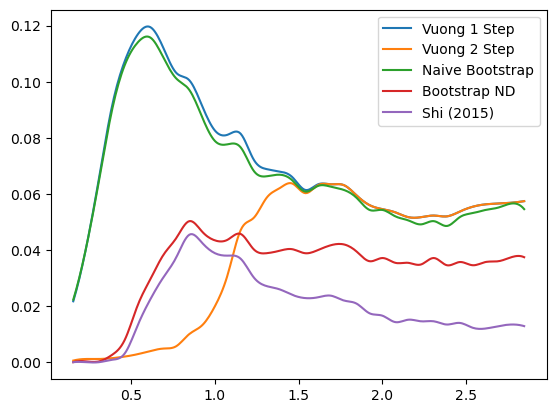

0.06324555320336758 0.13961509012658177


In [7]:
nobs =250
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2)
print(c1,c2)

Quantiles: 1th: 0.76, 5th: 2.09, 10th: 3.46, 30th: 9.67, 50th: 17.15, 70th: 25.88, 90th: 41.71, 95th: 49.41, 99th: 66.89
bonus term 1.4740065997291418 // variance stats 31.222857508339537 //part1 47.49670462942421 //part2 32.22285750833954 31.222857508339537
-0.36026858935144557 0.21261375182853254 3.4033425162599946
-3.308281788809729 0.21261375182853254 0.45532931680171074
---
Quantiles: 1th: 0.74, 5th: 1.96, 10th: 3.51, 30th: 9.82, 50th: 17.19, 70th: 26.31, 90th: 41.79, 95th: 49.32, 99th: 64.10
bonus term 1.0749587449856808 // variance stats 43.184676715250966 //part1 47.49670462942421 //part2 44.184676715250966 43.184676715250966
-0.9488928582591982 0.5255329554113447 2.964467943019556
-3.09881034823056 0.5255329554113447 0.8145504530481948
---
Quantiles: 1th: 0.69, 5th: 2.02, 10th: 3.51, 30th: 10.16, 50th: 17.45, 70th: 26.86, 90th: 42.62, 95th: 50.10, 99th: 66.96
bonus term 1.6123341528778727 // variance stats 28.45835051911964 //part1 47.49670462942421 //part2 29.45835051911964 2

Quantiles: 1th: 0.69, 5th: 1.79, 10th: 3.22, 30th: 9.65, 50th: 16.74, 70th: 25.61, 90th: 40.54, 95th: 47.99, 99th: 62.14
bonus term 2.207113265285688 // variance stats 20.51983107367906 //part1 47.49670462942421 //part2 21.51983107367906 20.51983107367906
0.24528734140236635 -0.1575662750277513 4.1709154862454
-4.16893918916901 -0.1575662750277513 -0.24331104432597656
---
Quantiles: 1th: 0.76, 5th: 1.95, 10th: 3.56, 30th: 10.00, 50th: 17.03, 70th: 26.16, 90th: 40.98, 95th: 47.83, 99th: 63.16
bonus term 3.0285280210868395 // variance stats 14.683098950617996 //part1 47.49670462942421 //part2 15.683098950617996 14.683098950617996
1.229827113323686 -0.5202470786441852 4.8842839562051
-4.827228928849993 -0.5202470786441852 -1.1727720859685786
---
Quantiles: 1th: 0.64, 5th: 1.67, 10th: 3.23, 30th: 10.31, 50th: 18.41, 70th: 27.83, 90th: 44.02, 95th: 52.94, 99th: 69.18
bonus term 6.418837389013789 // variance stats 6.399580601732887 //part1 47.49670462942421 //part2 7.399580601732887 6.399580

Quantiles: 1th: 0.77, 5th: 1.97, 10th: 3.33, 30th: 9.72, 50th: 16.76, 70th: 26.35, 90th: 41.67, 95th: 49.53, 99th: 66.31
bonus term 1.359092266808352 // variance stats 33.94737317648339 //part1 47.49670462942421 //part2 34.94737317648339 33.94737317648339
-0.6720942278386877 0.2949111013069364 3.175330999702989
-3.390278761455392 0.2949111013069364 0.4571464660862849
---
Quantiles: 1th: 0.78, 5th: 1.90, 10th: 3.58, 30th: 10.17, 50th: 17.42, 70th: 27.06, 90th: 42.03, 95th: 49.76, 99th: 65.18
bonus term 0.7379939599469486 // variance stats 63.35920509815358 //part1 47.49670462942421 //part2 64.35920509815358 63.35920509815358
-1.210762647356058 0.97211154380087 2.644572516883706
-2.6867505672499554 0.97211154380087 1.1685845969898092
---
Quantiles: 1th: 0.74, 5th: 2.01, 10th: 3.49, 30th: 10.12, 50th: 17.13, 70th: 26.10, 90th: 41.45, 95th: 50.33, 99th: 64.48
bonus term 11.832046977633938 // variance stats 3.0142423977192623 //part1 47.49670462942421 //part2 4.014242397719262 3.01424239771

Quantiles: 1th: 0.72, 5th: 1.68, 10th: 2.80, 30th: 8.31, 50th: 14.68, 70th: 22.22, 90th: 35.93, 95th: 42.68, 99th: 56.24
bonus term 4.012646645553176 // variance stats 10.836752354474111 //part1 47.49670462942421 //part2 11.836752354474111 10.836752354474111
2.2505184584892173 -1.0697821524490407 5.835051138259246
-5.774774832617136 -1.0697821524490407 -2.190242152847107
---
Quantiles: 1th: 0.68, 5th: 1.85, 10th: 3.06, 30th: 8.84, 50th: 15.51, 70th: 24.42, 90th: 39.13, 95th: 46.48, 99th: 62.22
bonus term 3.578966973557347 // variance stats 12.271065360576497 //part1 47.49670462942421 //part2 13.271065360576497 12.271065360576497
1.8424899375153534 -1.0949420193542019 5.618852707058619
-5.31544400959934 -1.0949420193542019 -1.5390812400560752
---
Quantiles: 1th: 0.92, 5th: 2.20, 10th: 3.64, 30th: 10.38, 50th: 18.28, 70th: 28.51, 90th: 44.70, 95th: 53.28, 99th: 72.24
bonus term 2.835542501608217 // variance stats 15.750482351255819 //part1 47.49670462942421 //part2 16.75048235125582 15.7

Quantiles: 1th: 0.69, 5th: 1.85, 10th: 3.26, 30th: 9.84, 50th: 16.86, 70th: 26.23, 90th: 40.89, 95th: 48.32, 99th: 64.00
bonus term 1.1158575014110135 // variance stats 41.56520619287331 //part1 47.49670462942421 //part2 42.56520619287331 41.56520619287331
-0.7466004976726466 0.2577637201964694 3.1092269159917776
-2.9783155004946735 0.2577637201964694 0.8775119131697509
---
Quantiles: 1th: 0.73, 5th: 1.89, 10th: 3.22, 30th: 9.48, 50th: 16.83, 70th: 25.69, 90th: 41.28, 95th: 48.94, 99th: 65.38
bonus term 1.9979376044980195 // variance stats 22.772866841533688 //part1 47.49670462942421 //part2 23.772866841533688 22.772866841533688
0.1672922761690265 -0.34253367105643057 3.8184101527505705
-3.8285829328270125 -0.34253367105643057 -0.1774650562454686
---
Quantiles: 1th: 0.71, 5th: 1.90, 10th: 3.28, 30th: 9.21, 50th: 15.87, 70th: 24.90, 90th: 39.34, 95th: 46.59, 99th: 60.43
bonus term 1.5483181738749499 // variance stats 29.6763205592007 //part1 47.49670462942421 //part2 30.6763205592007 29

Quantiles: 1th: 0.82, 5th: 2.08, 10th: 3.47, 30th: 9.60, 50th: 17.09, 70th: 25.81, 90th: 41.37, 95th: 49.36, 99th: 65.32
bonus term 2.734419384051073 // variance stats 16.36994146050022 //part1 47.49670462942421 //part2 17.36994146050022 16.36994146050022
1.0021229569144474 -2.1542120328700367 4.558222962842797
-4.466715811187698 -2.1542120328700367 -0.9106158052593493
---
Quantiles: 1th: 0.70, 5th: 1.95, 10th: 3.12, 30th: 9.07, 50th: 16.24, 70th: 25.03, 90th: 39.67, 95th: 47.16, 99th: 61.66
bonus term 0.7596728626598618 // variance stats 61.52257644576482 //part1 47.49670462942421 //part2 62.52257644576483 61.52257644576482
-1.102520312947753 0.7895775027398332 2.6176132549901663
-2.6218660382674766 0.7895775027398332 1.0982675296704427
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.79, 5th: 1.93, 10th: 3.54, 30th: 9.86, 50th: 17.74, 70th: 27.06, 90th: 42.19, 95th: 50.63, 99th: 68.38
bonus term 3.103671149203659 // variance stats 14.303394704561702 //part1 47.49670462942421 //pa

Quantiles: 1th: 0.76, 5th: 1.81, 10th: 3.16, 30th: 9.57, 50th: 17.22, 70th: 26.49, 90th: 41.30, 95th: 49.35, 99th: 64.28
bonus term 0.6552266963892782 // variance stats 71.48896434037516 //part1 47.49670462942421 //part2 72.48896434037516 71.48896434037516
-1.1702341124041633 0.987485088325057 2.4831816688564166
-2.4806875051827197 0.987485088325057 1.1727282760778601
---
Quantiles: 1th: 0.73, 5th: 1.89, 10th: 3.45, 30th: 9.74, 50th: 16.91, 70th: 26.23, 90th: 41.22, 95th: 49.90, 99th: 66.23
bonus term 1.7746707199947156 // variance stats 25.7636717585365 //part1 47.49670462942421 //part2 26.7636717585365 25.7636717585365
-0.2548614017952907 -0.9244749614452401 3.5936528531067045
-3.804202841784722 -0.9244749614452401 0.04431141311727368
---
Quantiles: 1th: 0.72, 5th: 1.84, 10th: 3.07, 30th: 9.38, 50th: 16.85, 70th: 25.49, 90th: 40.53, 95th: 47.39, 99th: 61.78
bonus term 0.6710553664101093 // variance stats 69.77911452152374 //part1 47.49670462942421 //part2 70.77911452152375 69.7791145

Quantiles: 1th: 0.86, 5th: 2.01, 10th: 3.63, 30th: 10.46, 50th: 18.19, 70th: 27.92, 90th: 44.63, 95th: 53.02, 99th: 68.33
bonus term 1.579480033636603 // variance stats 29.07110163973871 //part1 47.49670462942421 //part2 30.07110163973871 29.07110163973871
-0.20771844971096656 -1.3299406734800088 3.424023227616491
-3.3666785169841726 -1.3299406734800088 0.2650631603432851
---
Quantiles: 1th: 0.73, 5th: 1.80, 10th: 2.98, 30th: 8.53, 50th: 14.77, 70th: 22.76, 90th: 36.56, 95th: 43.40, 99th: 54.33
bonus term 1.336379538654641 // variance stats 34.541328833304384 //part1 47.49670462942421 //part2 35.541328833304384 34.541328833304384
-0.6399515836152088 -0.6282785427509147 3.1049471782086284
-3.3127106609244907 -0.6282785427509147 0.43218810089934623
---
Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.59, 30th: 10.72, 50th: 18.61, 70th: 28.48, 90th: 45.54, 95th: 53.68, 99th: 69.51
bonus term 1.1546217301042165 // variance stats 40.13616034676321 //part1 47.49670462942421 //part2 41.13616034676321

Quantiles: 1th: 0.68, 5th: 1.81, 10th: 3.42, 30th: 9.59, 50th: 17.12, 70th: 25.57, 90th: 40.26, 95th: 48.50, 99th: 63.84
bonus term 1.4912693025359258 // variance stats 30.84985069340283 //part1 47.49670462942421 //part2 31.84985069340283 30.84985069340283
-0.4650639832157277 -1.0198361772503264 3.3935727973960303
-3.4476025882875794 -1.0198361772503264 0.4110341923241786
---
Quantiles: 1th: 0.68, 5th: 1.79, 10th: 2.95, 30th: 9.21, 50th: 16.01, 70th: 25.09, 90th: 39.88, 95th: 46.57, 99th: 60.36
bonus term 1.8601452910664966 // variance stats 24.533868164777832 //part1 47.49670462942421 //part2 25.53386816477783 24.533868164777832
0.09042411024472541 -1.6106246325944757 3.690890855489826
-3.629866471888268 -1.6106246325944757 -0.029399726643167215
---
Quantiles: 1th: 0.70, 5th: 1.86, 10th: 3.26, 30th: 10.11, 50th: 17.65, 70th: 27.20, 90th: 43.71, 95th: 51.62, 99th: 68.66
bonus term 0.45250991999709944 // variance stats 103.96279204161681 //part1 47.49670462942421 //part2 104.96279204161

Quantiles: 1th: 0.70, 5th: 1.72, 10th: 2.96, 30th: 9.02, 50th: 15.54, 70th: 23.92, 90th: 38.77, 95th: 46.51, 99th: 60.96
bonus term 0.6556635521493451 // variance stats 71.44066636573622 //part1 47.49670462942421 //part2 72.44066636573623 71.44066636573622
-1.2676964068004732 0.12033515720482538 2.5816331799780734
-2.5790235110991633 0.12033515720482538 1.2703060756793831
---
Quantiles: 1th: 0.66, 5th: 1.82, 10th: 3.12, 30th: 9.41, 50th: 16.49, 70th: 25.07, 90th: 39.69, 95th: 47.45, 99th: 61.83
bonus term 0.6143923128020986 // variance stats 76.30680159848181 //part1 47.49670462942421 //part2 77.30680159848181 76.30680159848181
-1.307497914399533 0.3314971914247786 2.5376334818252264
-2.53628254000373 0.3314971914247786 1.3088488562210292
---
Quantiles: 1th: 0.68, 5th: 2.03, 10th: 3.44, 30th: 10.73, 50th: 19.01, 70th: 29.79, 90th: 46.78, 95th: 55.17, 99th: 70.65
bonus term 0.8026091668707404 // variance stats 58.177874599423205 //part1 47.49670462942421 //part2 59.17787459942321 58.177

Quantiles: 1th: 0.77, 5th: 2.04, 10th: 3.59, 30th: 11.24, 50th: 19.23, 70th: 30.16, 90th: 47.76, 95th: 57.11, 99th: 77.08
bonus term 0.46103443489539153 // variance stats 102.02203270391546 //part1 47.49670462942421 //part2 103.02203270391547 102.02203270391546
-1.6540818889755884 0.9720403821177185 2.4771342931275298
-2.5761507587663712 0.9720403821177185 1.555065423336747
---
Quantiles: 1th: 0.82, 5th: 1.97, 10th: 3.58, 30th: 10.39, 50th: 18.31, 70th: 28.05, 90th: 44.11, 95th: 53.03, 99th: 70.76
bonus term 0.7458302349473216 // variance stats 62.68299701979623 //part1 47.49670462942421 //part2 63.68299701979624 62.68299701979623
-1.253513522030396 -0.41494002309768785 2.840393523956125
-2.7451739919250393 -0.41494002309768785 1.3487330540614815
---
Quantiles: 1th: 0.79, 5th: 2.18, 10th: 3.76, 30th: 10.91, 50th: 18.60, 70th: 28.98, 90th: 45.77, 95th: 54.29, 99th: 70.59
bonus term 1.171806590486478 // variance stats 39.53288743640352 //part1 47.49670462942421 //part2 40.53288743640352 

Quantiles: 1th: 0.73, 5th: 1.91, 10th: 3.72, 30th: 10.61, 50th: 18.14, 70th: 27.72, 90th: 43.66, 95th: 51.55, 99th: 66.99
bonus term 1.0404635867491479 // variance stats 44.649559710036726 //part1 47.49670462942421 //part2 45.64955971003673 44.649559710036726
-0.8133472283906308 -1.4128658251595148 2.8965297226960556
-2.8942744018889264 -1.4128658251595148 0.8156025491977595
---
Quantiles: 1th: 0.81, 5th: 2.07, 10th: 3.46, 30th: 10.04, 50th: 16.99, 70th: 26.57, 90th: 42.39, 95th: 50.90, 99th: 66.53
bonus term 0.45326635599122483 // variance stats 103.78762432203051 //part1 47.49670462942421 //part2 104.78762432203051 103.78762432203051
-1.406407358761078 1.0494282995848085 2.4248431862029194
-2.3129400707435273 1.0494282995848085 1.5183104742204698
---
Quantiles: 1th: 0.77, 5th: 2.22, 10th: 3.80, 30th: 10.83, 50th: 18.80, 70th: 28.18, 90th: 44.77, 95th: 52.89, 99th: 68.70
bonus term 1.9156761478814486 // variance stats 23.79370256916909 //part1 47.49670462942421 //part2 24.793702569169

Quantiles: 1th: 0.71, 5th: 1.65, 10th: 2.92, 30th: 8.36, 50th: 14.84, 70th: 22.68, 90th: 35.90, 95th: 42.97, 99th: 55.63
bonus term 0.5595623977303347 // variance stats 83.88187344624595 //part1 47.49670462942421 //part2 84.88187344624596 83.88187344624595
-1.4476828548179914 -0.16057210501841518 2.54234540167199
-2.5668076502786605 -0.16057210501841518 1.4232206062113208
---
Quantiles: 1th: 0.78, 5th: 2.08, 10th: 3.58, 30th: 10.07, 50th: 18.31, 70th: 28.05, 90th: 45.14, 95th: 54.09, 99th: 70.74
bonus term 0.5839296576142851 // variance stats 80.33977099823584 //part1 47.49670462942421 //part2 81.33977099823585 80.33977099823584
-1.3157271751156545 -0.1817537502049776 2.4650949430556572
-2.483586490344224 -0.1817537502049776 1.2972356278270871
---
Quantiles: 1th: 0.78, 5th: 1.99, 10th: 3.52, 30th: 10.20, 50th: 17.79, 70th: 27.31, 90th: 44.32, 95th: 52.63, 99th: 69.33
bonus term 0.5488701812493665 // variance stats 85.53540719102241 //part1 47.49670462942421 //part2 86.53540719102241 85

Quantiles: 1th: 0.63, 5th: 1.67, 10th: 2.96, 30th: 8.94, 50th: 15.53, 70th: 24.03, 90th: 38.40, 95th: 45.81, 99th: 61.72
bonus term 0.6076134973968619 // variance stats 77.16927180339083 //part1 47.49670462942421 //part2 78.16927180339084 77.16927180339083
-1.3161371092678118 -0.5977258585598136 2.448225893411116
-2.531364104061536 -0.5977258585598136 1.2329988986173923
---
Quantiles: 1th: 0.74, 5th: 1.84, 10th: 3.19, 30th: 9.08, 50th: 15.92, 70th: 24.47, 90th: 39.40, 95th: 46.89, 99th: 62.69
bonus term 0.576676481715847 // variance stats 81.36282583971901 //part1 47.49670462942421 //part2 82.36282583971901 81.36282583971901
-1.2652735548512444 -0.45405430869123514 2.5982290400326438
-2.4186265182829385 -0.45405430869123514 1.4448760766009499
---
Quantiles: 1th: 0.64, 5th: 1.79, 10th: 3.10, 30th: 9.54, 50th: 16.57, 70th: 25.86, 90th: 41.29, 95th: 49.50, 99th: 64.21
bonus term 1.0095139994720044 // variance stats 46.04907970990587 //part1 47.49670462942421 //part2 47.04907970990587 46.0

0.7692307692307693 [0.97285714 0.         0.02714286]
Quantiles: 1th: 0.89, 5th: 1.95, 10th: 3.41, 30th: 10.02, 50th: 17.08, 70th: 27.02, 90th: 42.61, 95th: 50.45, 99th: 65.51
bonus term 0.4907192786266623 // variance stats 95.78997075955427 //part1 47.49670462942421 //part2 96.78997075955428 95.78997075955427
-1.5068097636190643 -0.13394869267260046 2.376574564079425
-2.4882483208723887 -0.13394869267260046 1.3951360068261
---
Quantiles: 1th: 0.68, 5th: 1.66, 10th: 2.88, 30th: 8.74, 50th: 14.91, 70th: 22.94, 90th: 36.31, 95th: 43.27, 99th: 57.30
bonus term 0.5742767514514797 // variance stats 81.70699538049674 //part1 47.49670462942421 //part2 82.70699538049675 81.70699538049674
-1.3898011087352506 -0.46983060573405866 2.4701510265035544
-2.53835461163821 -0.46983060573405866 1.321597523600595
---
Quantiles: 1th: 0.71, 5th: 1.74, 10th: 2.99, 30th: 8.83, 50th: 15.25, 70th: 23.64, 90th: 37.65, 95th: 45.19, 99th: 58.33
bonus term 0.5235645313847828 // variance stats 89.71795697046082 //p

Quantiles: 1th: 0.73, 5th: 1.81, 10th: 3.10, 30th: 9.38, 50th: 16.32, 70th: 24.89, 90th: 39.53, 95th: 47.75, 99th: 61.52
bonus term 0.3451557068411475 // variance stats 136.60950112664318 //part1 47.49670462942421 //part2 137.60950112664318 136.60950112664318
-1.605658772490021 1.2810954767405878 2.3535124836001873
-2.2959701861723163 1.2810954767405878 1.663201069917892
---
Quantiles: 1th: 0.72, 5th: 1.84, 10th: 3.18, 30th: 9.46, 50th: 16.55, 70th: 25.53, 90th: 40.66, 95th: 49.29, 99th: 63.75
bonus term 0.47865201031400917 // variance stats 98.23013714758042 //part1 47.49670462942421 //part2 99.23013714758042 98.23013714758042
-1.4369958905055815 0.38958229921865406 2.4959662452576805
-2.3942999111335994 0.38958229921865406 1.5386622246296624
---
Quantiles: 1th: 0.75, 5th: 2.00, 10th: 3.49, 30th: 10.27, 50th: 17.83, 70th: 27.54, 90th: 44.98, 95th: 52.87, 99th: 69.85
bonus term 0.7232376066097282 // variance stats 64.67233810209522 //part1 47.49670462942421 //part2 65.67233810209522 64

Quantiles: 1th: 0.85, 5th: 2.04, 10th: 3.54, 30th: 10.49, 50th: 18.33, 70th: 27.88, 90th: 44.30, 95th: 52.28, 99th: 67.36
bonus term 0.43508083622469784 // variance stats 108.1675400864921 //part1 47.49670462942421 //part2 109.16754008649211 108.1675400864921
-1.5164970291287216 0.17897174938329802 2.390189741128989
-2.3866587015781175 0.17897174938329802 1.5200280686795935
---
Quantiles: 1th: 0.64, 5th: 1.76, 10th: 3.10, 30th: 8.91, 50th: 15.78, 70th: 24.49, 90th: 38.36, 95th: 46.38, 99th: 60.29
bonus term 0.5991833646464704 // variance stats 78.26906424955267 //part1 47.49670462942421 //part2 79.26906424955267 78.26906424955267
-1.2583221138631346 -1.3171500221216494 2.5524975312907987
-2.456688843156075 -1.3171500221216494 1.354130801997858
---
Quantiles: 1th: 0.77, 5th: 1.99, 10th: 3.29, 30th: 9.87, 50th: 17.14, 70th: 26.37, 90th: 41.60, 95th: 49.20, 99th: 65.23
bonus term 0.392114600267991 // variance stats 120.12965086472819 //part1 47.49670462942421 //part2 121.1296508647282 120

Quantiles: 1th: 0.84, 5th: 2.04, 10th: 3.56, 30th: 10.19, 50th: 17.65, 70th: 26.93, 90th: 42.86, 95th: 50.67, 99th: 65.06
bonus term 0.29595541287122895 // variance stats 159.48601432436095 //part1 47.49670462942421 //part2 160.48601432436095 159.48601432436095
-1.5928639388866934 1.3824586042123013 2.1856190892333887
-2.184774764629151 1.3824586042123013 1.5937082634909305
---
Quantiles: 1th: 0.75, 5th: 1.93, 10th: 3.48, 30th: 9.95, 50th: 17.48, 70th: 27.15, 90th: 42.44, 95th: 51.14, 99th: 66.44
bonus term 0.3339649969413913 // variance stats 141.2206071427287 //part1 47.49670462942421 //part2 142.2206071427287 141.2206071427287
-1.575417421797414 0.827674913783509 2.1614176146635007
-2.2433474156801965 0.827674913783509 1.4934876207807182
---
Quantiles: 1th: 0.89, 5th: 2.10, 10th: 3.70, 30th: 9.98, 50th: 17.64, 70th: 26.55, 90th: 41.88, 95th: 50.55, 99th: 65.86
bonus term 0.3253946414437984 // variance stats 144.96646219703575 //part1 47.49670462942421 //part2 145.96646219703575 144.

Quantiles: 1th: 0.64, 5th: 1.74, 10th: 3.31, 30th: 9.85, 50th: 17.48, 70th: 26.59, 90th: 41.91, 95th: 50.25, 99th: 69.54
bonus term 0.6768791300166219 // variance stats 69.17014193990269 //part1 47.49670462942421 //part2 70.17014193990269 69.17014193990269
-1.2600714807216968 -3.114589386252861 2.6210822565583616
-2.6138297407549405 -3.114589386252861 1.2673239965251175
---
Quantiles: 1th: 0.74, 5th: 1.90, 10th: 3.20, 30th: 10.00, 50th: 17.24, 70th: 26.51, 90th: 41.29, 95th: 49.28, 99th: 62.51
bonus term 0.5174355970135402 // variance stats 90.7924953434955 //part1 47.49670462942421 //part2 91.79249534349552 90.7924953434955
-1.5091076814828919 -1.3497650059286184 2.5054016975857434
-2.5439788755099726 -1.3497650059286184 1.470530503558663
---
Quantiles: 1th: 0.79, 5th: 1.94, 10th: 3.24, 30th: 9.28, 50th: 16.63, 70th: 26.07, 90th: 40.89, 95th: 48.72, 99th: 65.05
bonus term 0.3410259757215827 // variance stats 138.27591447814237 //part1 47.49670462942421 //part2 139.27591447814237 138.2

Quantiles: 1th: 0.69, 5th: 2.03, 10th: 3.56, 30th: 10.38, 50th: 17.72, 70th: 27.50, 90th: 43.92, 95th: 51.02, 99th: 66.80
bonus term 0.3549803016849294 // variance stats 132.80095854327422 //part1 47.49670462942421 //part2 133.80095854327422 132.80095854327422
-1.794047669077725 -0.014031074105447953 2.161630120939252
-2.5040082724475834 -0.014031074105447953 1.4516695175693934
---
Quantiles: 1th: 0.75, 5th: 2.02, 10th: 3.46, 30th: 9.97, 50th: 17.30, 70th: 25.99, 90th: 42.02, 95th: 50.56, 99th: 66.62
bonus term 0.3348844167981286 // variance stats 140.83014272072165 //part1 47.49670462942421 //part2 141.83014272072165 140.83014272072165
-1.7827419619220843 0.6960618797577134 2.4019354363944663
-2.4525107955183416 0.6960618797577134 1.732166602798209
---
1.076923076923077 [0.95857143 0.00428571 0.03714286]
Quantiles: 1th: 0.74, 5th: 1.89, 10th: 3.19, 30th: 9.71, 50th: 17.27, 70th: 26.89, 90th: 42.37, 95th: 49.60, 99th: 66.25
bonus term 0.32886343877771956 // variance stats 143.426832018

Quantiles: 1th: 0.72, 5th: 1.83, 10th: 3.08, 30th: 9.39, 50th: 16.37, 70th: 25.10, 90th: 39.07, 95th: 46.84, 99th: 63.50
bonus term 0.327349672111224 // variance stats 144.09470659645626 //part1 47.49670462942421 //part2 145.0947065964563 144.09470659645626
-1.6658535336921128 0.7607356492150638 2.1762431958026696
-2.3205528779145608 0.7607356492150638 1.5215438515802218
---
Quantiles: 1th: 0.73, 5th: 2.11, 10th: 3.51, 30th: 9.84, 50th: 17.15, 70th: 26.15, 90th: 40.73, 95th: 48.73, 99th: 64.35
bonus term 0.3583937021693608 // variance stats 131.52661623774682 //part1 47.49670462942421 //part2 132.52661623774685 131.52661623774682
-1.583868159585729 -0.06184460028850627 2.229869720883007
-2.3006555639244506 -0.06184460028850627 1.5130823165442853
---
Quantiles: 1th: 0.72, 5th: 1.98, 10th: 3.33, 30th: 9.87, 50th: 17.61, 70th: 27.36, 90th: 43.75, 95th: 52.39, 99th: 66.03
bonus term 0.31142409994499737 // variance stats 151.51454411464275 //part1 47.49670462942421 //part2 152.5145441146427

Quantiles: 1th: 0.77, 5th: 2.06, 10th: 3.52, 30th: 9.76, 50th: 16.91, 70th: 25.95, 90th: 40.86, 95th: 48.49, 99th: 65.18
bonus term 0.2740256446105333 // variance stats 172.32941483243383 //part1 47.49670462942421 //part2 173.32941483243383 172.32941483243383
-1.5889246906421788 1.30691949631627 2.2504968087363304
-2.1369759798632457 1.30691949631627 1.7024455195152635
---
Quantiles: 1th: 0.78, 5th: 2.03, 10th: 3.42, 30th: 10.30, 50th: 18.09, 70th: 27.46, 90th: 44.07, 95th: 52.97, 99th: 67.68
bonus term 0.3299593230219401 // variance stats 142.9471514077085 //part1 47.49670462942421 //part2 143.94715140770853 142.9471514077085
-1.5883139564474038 -0.30003770449453687 2.3663745234918094
-2.248232602491284 -0.30003770449453687 1.7064558774479297
---
Quantiles: 1th: 0.75, 5th: 1.74, 10th: 2.94, 30th: 8.78, 50th: 15.01, 70th: 23.29, 90th: 36.76, 95th: 42.77, 99th: 55.97
bonus term 0.2861120126348489 // variance stats 165.00737659359302 //part1 47.49670462942421 //part2 166.00737659359302 1

Quantiles: 1th: 0.66, 5th: 1.63, 10th: 2.77, 30th: 7.86, 50th: 13.83, 70th: 21.55, 90th: 34.62, 95th: 40.98, 99th: 54.74
bonus term 0.3224261018664281 // variance stats 146.31035841850274 //part1 47.49670462942421 //part2 147.31035841850277 146.31035841850274
-1.847502647431322 0.5079574823223726 2.2977839497116017
-2.4923548511641784 0.5079574823223726 1.6529317459787454
---
Quantiles: 1th: 0.79, 5th: 1.99, 10th: 3.32, 30th: 9.59, 50th: 16.22, 70th: 24.23, 90th: 38.23, 95th: 45.45, 99th: 58.32
bonus term 0.20908138891898642 // variance stats 226.16849584267848 //part1 47.49670462942421 //part2 227.16849584267848 226.16849584267848
-1.810752160694538 3.1314935681199607 2.1763905638626313
-2.2289149385325104 3.1314935681199607 1.7582277860246587
---
Quantiles: 1th: 0.85, 5th: 1.92, 10th: 3.17, 30th: 9.56, 50th: 16.41, 70th: 25.75, 90th: 40.17, 95th: 46.92, 99th: 61.65
bonus term 0.3832991798879586 // variance stats 122.91548722673467 //part1 47.49670462942421 //part2 123.91548722673467 

Quantiles: 1th: 0.76, 5th: 1.87, 10th: 3.26, 30th: 10.03, 50th: 17.64, 70th: 27.45, 90th: 43.12, 95th: 50.88, 99th: 66.38
bonus term 0.2346630710839026 // variance stats 201.40383120376873 //part1 47.49670462942421 //part2 202.40383120376873 201.40383120376873
-1.6080690653693774 1.2420502738295895 2.106482978940525
-2.0773952075371827 1.2420502738295895 1.6371568367727198
---
Quantiles: 1th: 0.69, 5th: 1.78, 10th: 3.20, 30th: 9.44, 50th: 16.53, 70th: 25.02, 90th: 39.62, 95th: 47.77, 99th: 60.14
bonus term 0.4184118378037892 // variance stats 112.51663681106795 //part1 47.49670462942421 //part2 113.51663681106795 112.51663681106795
-1.5921693103672117 -2.1439810809990663 2.3258433151729045
-2.4289929859747903 -2.1439810809990663 1.4890196395653266
---
Quantiles: 1th: 0.77, 5th: 2.15, 10th: 3.64, 30th: 9.90, 50th: 16.94, 70th: 26.30, 90th: 41.64, 95th: 49.38, 99th: 63.85
bonus term 0.4300468267591022 // variance stats 109.4454251816402 //part1 47.49670462942421 //part2 110.4454251816402

Quantiles: 1th: 0.80, 5th: 1.94, 10th: 3.35, 30th: 9.72, 50th: 17.06, 70th: 26.62, 90th: 41.97, 95th: 51.63, 99th: 66.79
bonus term 0.32881420301007536 // variance stats 143.44845810984884 //part1 47.49670462942421 //part2 144.44845810984887 143.44845810984884
-1.7284390377897765 -0.6128101086525454 2.2044183122339325
-2.386067443809927 -0.6128101086525454 1.5467899062137818
---
Quantiles: 1th: 0.66, 5th: 1.74, 10th: 2.97, 30th: 8.16, 50th: 14.05, 70th: 21.64, 90th: 34.62, 95th: 41.68, 99th: 55.51
bonus term 0.34249523334576815 // variance stats 137.67843988787317 //part1 47.49670462942421 //part2 138.6784398878732 137.67843988787317
-1.6157023412966702 -0.39346185688388496 2.2032198966026852
-2.3006928079882063 -0.39346185688388496 1.518229429911149
---
Quantiles: 1th: 0.74, 5th: 2.04, 10th: 3.60, 30th: 10.39, 50th: 18.02, 70th: 27.19, 90th: 43.74, 95th: 51.93, 99th: 69.69
bonus term 0.26958198082950524 // variance stats 175.18649615703762 //part1 47.49670462942421 //part2 176.1864961

Quantiles: 1th: 0.73, 5th: 1.76, 10th: 2.98, 30th: 8.86, 50th: 15.42, 70th: 23.75, 90th: 36.81, 95th: 43.47, 99th: 55.90
bonus term 0.2937638819327325 // variance stats 160.68326860652064 //part1 47.49670462942421 //part2 161.68326860652067 160.68326860652064
-1.6735326357895923 0.21002694543512365 2.162902062566445
-2.2610603996550576 0.21002694543512365 1.57537429870098
---
Quantiles: 1th: 0.74, 5th: 1.82, 10th: 3.29, 30th: 9.43, 50th: 16.72, 70th: 25.79, 90th: 40.40, 95th: 48.47, 99th: 64.26
bonus term 0.290247499072493 // variance stats 162.6420805733155 //part1 47.49670462942421 //part2 163.6420805733155 162.6420805733155
-1.5716573533471865 -0.26928430026968664 2.3884918604687533
-2.1521523514921728 -0.26928430026968664 1.8079968623237672
---
Quantiles: 1th: 0.74, 5th: 2.04, 10th: 3.43, 30th: 10.07, 50th: 17.50, 70th: 26.44, 90th: 41.78, 95th: 48.82, 99th: 63.06
bonus term 0.260491021580223 // variance stats 181.33528488350115 //part1 47.49670462942421 //part2 182.33528488350115 

Quantiles: 1th: 0.74, 5th: 1.89, 10th: 3.31, 30th: 9.77, 50th: 17.40, 70th: 26.63, 90th: 42.88, 95th: 51.36, 99th: 66.70
bonus term 0.28004437764244555 // variance stats 168.60420712344006 //part1 47.49670462942421 //part2 169.6042071234401 168.60420712344006
-1.6379441502904897 -0.41485974217231575 2.0486567487166107
-2.198032905575381 -0.41485974217231575 1.4885679934317195
---
Quantiles: 1th: 0.68, 5th: 1.97, 10th: 3.64, 30th: 10.44, 50th: 18.08, 70th: 28.02, 90th: 44.22, 95th: 53.46, 99th: 68.61
bonus term 0.2296112839432459 // variance stats 205.85701422742008 //part1 47.49670462942421 //part2 206.85701422742008 205.85701422742008
-1.874534589033377 0.9030747764915938 2.1617687361687947
-2.333757156919869 0.9030747764915938 1.7025461682823029
---
Quantiles: 1th: 0.62, 5th: 1.92, 10th: 3.32, 30th: 9.69, 50th: 16.76, 70th: 26.12, 90th: 41.36, 95th: 49.90, 99th: 65.53
bonus term 0.3831060677226774 // variance stats 122.9779492707124 //part1 47.49670462942421 //part2 123.9779492707124

Quantiles: 1th: 0.70, 5th: 1.88, 10th: 3.22, 30th: 9.75, 50th: 16.75, 70th: 25.66, 90th: 40.80, 95th: 48.74, 99th: 61.53
bonus term 0.2925297378521318 // variance stats 161.36538882564096 //part1 47.49670462942421 //part2 162.36538882564096 161.36538882564096
-1.5501710188184137 -0.9099934968039527 2.184851379345007
-2.1352304945226774 -0.9099934968039527 1.599791903640743
---
Quantiles: 1th: 0.70, 5th: 1.67, 10th: 2.94, 30th: 8.02, 50th: 14.57, 70th: 22.52, 90th: 35.91, 95th: 42.75, 99th: 55.65
bonus term 0.34622818874695965 // variance stats 136.18323976254027 //part1 47.49670462942421 //part2 137.18323976254027 136.18323976254027
-1.721045003829172 -2.162099127744864 2.1241751546313683
-2.4135013813230914 -2.162099127744864 1.4317187771374487
---
Quantiles: 1th: 0.67, 5th: 1.77, 10th: 2.97, 30th: 9.36, 50th: 16.18, 70th: 24.73, 90th: 39.24, 95th: 47.06, 99th: 62.14
bonus term 0.314442845833057 // variance stats 150.05035862269548 //part1 47.49670462942421 //part2 151.05035862269548 

1.6153846153846154 [0.97428571 0.00142857 0.02428571]
Quantiles: 1th: 0.70, 5th: 2.18, 10th: 3.77, 30th: 10.91, 50th: 18.98, 70th: 29.68, 90th: 47.04, 95th: 56.55, 99th: 72.98
bonus term 0.18703644929467272 // variance stats 252.9435752150853 //part1 47.49670462942421 //part2 253.9435752150853 252.9435752150853
-1.7633769974931535 1.4760094155210377 2.0997869995600387
-2.137449896082499 1.4760094155210377 1.7257141009706929
---
Quantiles: 1th: 0.82, 5th: 2.01, 10th: 3.49, 30th: 10.58, 50th: 18.41, 70th: 28.36, 90th: 44.76, 95th: 53.26, 99th: 68.89
bonus term 0.21048762316037464 // variance stats 224.65081935119548 //part1 47.49670462942421 //part2 225.65081935119548 224.65081935119548
-1.8464368848715533 0.7484573792782286 2.0259237466718742
-2.2674121311923026 0.7484573792782286 1.604948500351125
---
Quantiles: 1th: 0.79, 5th: 2.02, 10th: 3.50, 30th: 10.24, 50th: 17.92, 70th: 27.15, 90th: 43.56, 95th: 51.84, 99th: 66.46
bonus term 0.24136288888299254 // variance stats 195.785449698729

Quantiles: 1th: 0.61, 5th: 1.70, 10th: 2.99, 30th: 8.92, 50th: 15.90, 70th: 24.90, 90th: 39.58, 95th: 46.98, 99th: 62.82
bonus term 0.2597190851389886 // variance stats 181.8772213794237 //part1 47.49670462942421 //part2 182.8772213794237 181.8772213794237
-1.6702715452820518 -1.0425541113963088 2.1455496730476957
-2.1897097155600287 -1.0425541113963088 1.6261115027697184
---
Quantiles: 1th: 0.70, 5th: 1.71, 10th: 2.90, 30th: 8.79, 50th: 15.53, 70th: 23.88, 90th: 38.53, 95th: 46.29, 99th: 60.76
bonus term 0.2820382407440154 // variance stats 167.40519393444006 //part1 47.49670462942421 //part2 168.40519393444006 167.40519393444006
-1.657231840777749 -0.8847184293318844 2.194776093719141
-2.2213083222657803 -0.8847184293318844 1.63069961223111
---
Quantiles: 1th: 0.75, 5th: 1.73, 10th: 3.18, 30th: 8.94, 50th: 15.92, 70th: 24.24, 90th: 39.65, 95th: 47.37, 99th: 62.45
bonus term 0.26172742062118715 // variance stats 180.47393389922587 //part1 47.49670462942421 //part2 181.4739338992259 18

Quantiles: 1th: 0.72, 5th: 1.79, 10th: 2.98, 30th: 8.80, 50th: 15.31, 70th: 23.86, 90th: 38.55, 95th: 45.69, 99th: 59.68
bonus term 0.21801401091184883 // variance stats 216.86078991330928 //part1 47.49670462942421 //part2 217.86078991330928 216.86078991330928
-1.8111524433597634 1.0365798753046485 2.2603859938594644
-2.2471804651834613 1.0365798753046485 1.8243579720357668
---
Quantiles: 1th: 0.66, 5th: 1.89, 10th: 3.46, 30th: 10.02, 50th: 17.71, 70th: 27.52, 90th: 43.07, 95th: 50.79, 99th: 66.29
bonus term 0.2966089124507875 // variance stats 159.13242568125705 //part1 47.49670462942421 //part2 160.13242568125705 159.13242568125705
-1.6163876265852686 -2.381819294965354 2.2747394118174045
-2.2096054514868433 -2.381819294965354 1.6815215869158293
---
Quantiles: 1th: 0.68, 5th: 1.79, 10th: 3.33, 30th: 9.20, 50th: 16.26, 70th: 24.68, 90th: 38.82, 95th: 46.04, 99th: 62.18
bonus term 0.2612087058562059 // variance stats 180.83430936475332 //part1 47.49670462942421 //part2 181.834309364753

Quantiles: 1th: 0.69, 5th: 1.83, 10th: 3.27, 30th: 9.91, 50th: 17.32, 70th: 26.81, 90th: 42.35, 95th: 50.24, 99th: 65.30
bonus term 0.20946043064334607 // variance stats 225.75740942353988 //part1 47.49670462942421 //part2 226.7574094235399 225.75740942353988
-1.73330146288749 0.4802970376637396 2.093859888398977
-2.152222324174182 0.4802970376637396 1.6749390271122848
---
Quantiles: 1th: 0.72, 5th: 1.78, 10th: 3.14, 30th: 9.28, 50th: 16.41, 70th: 25.13, 90th: 39.83, 95th: 47.53, 99th: 60.88
bonus term 0.22725278140452584 // variance stats 208.00384292712684 //part1 47.49670462942421 //part2 209.00384292712684 208.00384292712684
-1.7785531124622391 0.2579410438270404 2.1741813293411862
-2.2330586752712906 0.2579410438270404 1.7196757665321345
---
Quantiles: 1th: 0.73, 5th: 1.82, 10th: 3.21, 30th: 9.26, 50th: 15.66, 70th: 24.30, 90th: 39.38, 95th: 46.72, 99th: 62.32
bonus term 0.23221654757790827 // variance stats 203.536262057247 //part1 47.49670462942421 //part2 204.536262057247 203.5

Quantiles: 1th: 0.76, 5th: 1.93, 10th: 3.28, 30th: 10.03, 50th: 17.45, 70th: 26.38, 90th: 41.72, 95th: 48.91, 99th: 64.19
bonus term 0.21174385300938628 // variance stats 223.31208252037786 //part1 47.49670462942421 //part2 224.31208252037786 223.31208252037786
-1.7027856289163528 -0.09167896872646857 1.9120424741242465
-2.1262733349351253 -0.09167896872646857 1.488554768105474
---
Quantiles: 1th: 0.75, 5th: 1.86, 10th: 3.29, 30th: 9.82, 50th: 17.27, 70th: 26.57, 90th: 41.84, 95th: 49.56, 99th: 66.40
bonus term 0.18045074854894275 // variance stats 262.2114580369386 //part1 47.49670462942421 //part2 263.2114580369386 262.2114580369386
-1.8182600703450689 1.253798070375767 2.2332536913722367
-2.1791615674429545 1.253798070375767 1.872352194274351
---
Quantiles: 1th: 0.84, 5th: 1.99, 10th: 3.25, 30th: 9.18, 50th: 15.74, 70th: 24.14, 90th: 38.03, 95th: 45.41, 99th: 58.77
bonus term 0.2288093035846176 // variance stats 206.5820514521129 //part1 47.49670462942421 //part2 207.5820514521129 2

Quantiles: 1th: 0.73, 5th: 1.82, 10th: 3.20, 30th: 9.34, 50th: 16.46, 70th: 25.90, 90th: 40.67, 95th: 48.66, 99th: 63.07
bonus term 0.22562474892793719 // variance stats 209.5119445234011 //part1 47.49670462942421 //part2 210.5119445234011 209.5119445234011
-1.6302010829303837 -0.7037107487774503 2.182171622382854
-2.081450580786258 -0.7037107487774503 1.7309221245269797
---
Quantiles: 1th: 0.80, 5th: 1.92, 10th: 3.22, 30th: 9.13, 50th: 15.71, 70th: 24.06, 90th: 38.60, 95th: 45.05, 99th: 61.02
bonus term 0.17374548566937348 // variance stats 272.3694314211271 //part1 47.49670462942421 //part2 273.3694314211271 272.3694314211271
-1.7396297795858155 2.395399575726565 2.3285817703390026
-2.087120750924562 2.395399575726565 1.9810907990002555
---
1.9230769230769231 [0.95714286 0.00428571 0.03857143]
Quantiles: 1th: 0.80, 5th: 2.06, 10th: 3.54, 30th: 10.17, 50th: 17.82, 70th: 27.17, 90th: 41.93, 95th: 49.74, 99th: 65.38
bonus term 0.19428082882035086 // variance stats 243.47448015235636 //p

Quantiles: 1th: 0.78, 5th: 1.99, 10th: 3.21, 30th: 9.18, 50th: 15.55, 70th: 23.92, 90th: 38.82, 95th: 45.80, 99th: 59.79
bonus term 0.22588014709806253 // variance stats 209.27392287293057 //part1 47.49670462942421 //part2 210.27392287293057 209.27392287293057
-1.662446221746594 -0.8883586834892897 2.3001458200630136
-2.114206515942719 -0.8883586834892897 1.8483855258668882
---
Quantiles: 1th: 0.70, 5th: 1.70, 10th: 2.97, 30th: 9.10, 50th: 16.08, 70th: 24.39, 90th: 38.61, 95th: 45.43, 99th: 62.24
bonus term 0.20148652482022728 // variance stats 234.73142011259705 //part1 47.49670462942421 //part2 235.73142011259705 234.73142011259705
-1.7807935810396824 0.40752279175719025 2.143298298544941
-2.183766630680137 0.40752279175719025 1.7403252489044863
---
Quantiles: 1th: 0.75, 5th: 1.95, 10th: 3.44, 30th: 9.85, 50th: 17.47, 70th: 26.55, 90th: 42.34, 95th: 50.85, 99th: 64.70
bonus term 0.31503675506506473 // variance stats 149.76559755579848 //part1 47.49670462942421 //part2 150.76559755579

Quantiles: 1th: 0.72, 5th: 1.80, 10th: 3.10, 30th: 9.45, 50th: 16.72, 70th: 26.06, 90th: 41.52, 95th: 50.14, 99th: 65.46
bonus term 0.25025095753485055 // variance stats 188.79629527615177 //part1 47.49670462942421 //part2 189.79629527615177 188.79629527615177
-1.8498036477275992 -2.0203491091713173 2.302268686236493
-2.3503055627973 -2.0203491091713173 1.8017667711667922
---
Quantiles: 1th: 0.85, 5th: 2.10, 10th: 3.74, 30th: 10.39, 50th: 17.82, 70th: 27.38, 90th: 43.72, 95th: 52.33, 99th: 71.51
bonus term 0.16907134162902834 // variance stats 279.9269990513246 //part1 47.49670462942421 //part2 280.9269990513246 279.9269990513246
-1.7975857859741609 1.0839874582682334 2.229126978648582
-2.1357284692322174 1.0839874582682334 1.8909842953905254
---
Quantiles: 1th: 0.72, 5th: 1.68, 10th: 3.00, 30th: 9.31, 50th: 16.56, 70th: 25.43, 90th: 39.96, 95th: 47.45, 99th: 62.06
bonus term 0.20660492859874585 // variance stats 228.89144040057778 //part1 47.49670462942421 //part2 229.89144040057778 2

Quantiles: 1th: 0.93, 5th: 1.93, 10th: 3.26, 30th: 9.85, 50th: 16.74, 70th: 25.51, 90th: 40.53, 95th: 47.81, 99th: 63.15
bonus term 0.19290863313148324 // variance stats 245.21347348955226 //part1 47.49670462942421 //part2 246.21347348955226 245.21347348955226
-1.62748261879216 -0.016884714920494443 2.229222888442017
-2.0132998850551265 -0.016884714920494443 1.8434056221790502
---
Quantiles: 1th: 0.81, 5th: 2.10, 10th: 3.67, 30th: 10.56, 50th: 18.31, 70th: 28.18, 90th: 44.50, 95th: 53.28, 99th: 70.54
bonus term 0.1822367432797702 // variance stats 259.63187793312994 //part1 47.49670462942421 //part2 260.63187793312994 259.63187793312994
-2.0220291429886608 0.5853708951675065 2.0434289458960353
-2.3865026295482012 0.5853708951675065 1.6789554593364946
---
Quantiles: 1th: 0.73, 5th: 1.90, 10th: 3.35, 30th: 10.27, 50th: 17.98, 70th: 27.58, 90th: 43.67, 95th: 52.10, 99th: 69.11
bonus term 0.20958305289357426 // variance stats 225.62473885015368 //part1 47.49670462942421 //part2 226.6247388

Quantiles: 1th: 0.71, 5th: 1.99, 10th: 3.47, 30th: 9.86, 50th: 17.31, 70th: 26.22, 90th: 42.72, 95th: 51.54, 99th: 66.43
bonus term 0.20644904387202698 // variance stats 229.06502591925943 //part1 47.49670462942421 //part2 230.06502591925943 229.06502591925943
-1.8255197266935397 -1.2716949481365785 2.0596327048451144
-2.2384178144375935 -1.2716949481365785 1.6467346171010604
---
Quantiles: 1th: 0.68, 5th: 1.96, 10th: 3.38, 30th: 9.70, 50th: 17.50, 70th: 26.81, 90th: 42.44, 95th: 50.51, 99th: 66.76
bonus term 0.1718584492392404 // variance stats 275.371076543959 //part1 47.49670462942421 //part2 276.371076543959 275.371076543959
-1.7762983061681656 0.7835476614986415 1.9409623246407928
-2.1200152046466463 0.7835476614986415 1.5972454261623121
---
Quantiles: 1th: 0.77, 5th: 1.98, 10th: 3.54, 30th: 10.38, 50th: 17.95, 70th: 27.30, 90th: 44.34, 95th: 52.61, 99th: 68.60
bonus term 0.17530748589489134 // variance stats 269.93369337292125 //part1 47.49670462942421 //part2 270.93369337292125 

Quantiles: 1th: 0.71, 5th: 1.91, 10th: 3.34, 30th: 10.00, 50th: 17.18, 70th: 26.12, 90th: 41.01, 95th: 49.89, 99th: 66.51
bonus term 0.1781239989068839 // variance stats 265.6496649575759 //part1 47.49670462942421 //part2 266.6496649575759 265.6496649575759
-1.8102808167916251 0.6204456467146572 1.9692143099285675
-2.166528814605393 0.6204456467146572 1.6129663121147997
---
Quantiles: 1th: 0.77, 5th: 2.07, 10th: 3.54, 30th: 10.29, 50th: 18.36, 70th: 28.15, 90th: 44.94, 95th: 54.17, 99th: 70.51
bonus term 0.15658182600491194 // variance stats 302.3347217954544 //part1 47.49670462942421 //part2 303.3347217954544 302.3347217954544
-1.6633331231653945 1.2974692317261527 2.2263240720559643
-1.9764967751752183 1.2974692317261527 1.9131604200461403
---
Quantiles: 1th: 0.77, 5th: 2.02, 10th: 3.66, 30th: 10.78, 50th: 18.36, 70th: 28.38, 90th: 45.42, 95th: 53.49, 99th: 68.47
bonus term 0.17639558810647166 // variance stats 268.2624296292229 //part1 47.49670462942421 //part2 269.2624296292229 268

Quantiles: 1th: 0.74, 5th: 2.00, 10th: 3.11, 30th: 9.14, 50th: 15.75, 70th: 24.38, 90th: 39.47, 95th: 46.49, 99th: 59.73
bonus term 0.20764941455917554 // variance stats 227.7350760427436 //part1 47.49670462942421 //part2 228.7350760427436 227.7350760427436
-1.7196979702791524 -1.0485087998207723 2.357632509968303
-2.1349967993975034 -1.0485087998207723 1.9423336808499516
---
Quantiles: 1th: 0.68, 5th: 1.80, 10th: 3.37, 30th: 9.46, 50th: 16.66, 70th: 25.80, 90th: 41.30, 95th: 48.74, 99th: 65.94
bonus term 0.20704118156970464 // variance stats 228.40704003581757 //part1 47.49670462942421 //part2 229.4070400358176 228.40704003581757
-1.7337952064624087 -1.1795851980303207 2.235154748914013
-2.147877569601818 -1.1795851980303207 1.821072385774604
---
Quantiles: 1th: 0.74, 5th: 1.79, 10th: 3.32, 30th: 9.93, 50th: 18.17, 70th: 26.76, 90th: 42.25, 95th: 49.67, 99th: 66.87
bonus term 0.17586516850180464 // variance stats 269.0745408203832 //part1 47.49670462942421 //part2 270.0745408203832 26

Quantiles: 1th: 0.75, 5th: 1.94, 10th: 3.59, 30th: 10.25, 50th: 18.27, 70th: 27.97, 90th: 45.01, 95th: 52.70, 99th: 68.09
bonus term 0.16356944973644585 // variance stats 289.3763796109488 //part1 47.49670462942421 //part2 290.3763796109488 289.3763796109488
-1.715235863515 0.0743053955133794 2.09224089355733
-2.0423747629878917 0.0743053955133794 1.7651019940844381
---
Quantiles: 1th: 0.83, 5th: 1.95, 10th: 3.72, 30th: 10.50, 50th: 18.33, 70th: 28.01, 90th: 45.04, 95th: 54.44, 99th: 71.48
bonus term 0.1606618122828017 // variance stats 294.6315751363435 //part1 47.49670462942421 //part2 295.6315751363435 294.6315751363435
-1.8984787296400798 0.5266432542061978 1.947173916012444
-2.219802354205683 0.5266432542061978 1.6258502914468407
---
Quantiles: 1th: 0.74, 5th: 2.02, 10th: 3.61, 30th: 9.98, 50th: 17.37, 70th: 26.67, 90th: 42.28, 95th: 51.17, 99th: 67.20
bonus term 0.20116534749236262 // variance stats 235.10778507082318 //part1 47.49670462942421 //part2 236.10778507082318 235.10778

Quantiles: 1th: 0.83, 5th: 1.95, 10th: 3.20, 30th: 9.06, 50th: 16.17, 70th: 25.20, 90th: 39.78, 95th: 47.59, 99th: 64.36
bonus term 0.17041291545697942 // variance stats 277.71540429935726 //part1 47.49670462942421 //part2 278.71540429935726 277.71540429935726
-1.6939099257964887 0.6149707769575602 2.054769122720215
-2.034735756710447 0.6149707769575602 1.7139432918062567
---
Quantiles: 1th: 0.69, 5th: 1.80, 10th: 3.12, 30th: 8.72, 50th: 15.58, 70th: 23.69, 90th: 37.68, 95th: 44.97, 99th: 58.18
bonus term 0.19035527667362234 // variance stats 248.51609148645082 //part1 47.49670462942421 //part2 249.51609148645082 248.51609148645082
-1.8847864479045926 -0.7252156940720556 2.0290648054810205
-2.2654970012518376 -0.7252156940720556 1.6483542521337755
---
Quantiles: 1th: 0.67, 5th: 1.79, 10th: 3.23, 30th: 9.66, 50th: 16.69, 70th: 25.81, 90th: 40.73, 95th: 49.13, 99th: 64.53
bonus term 0.17836217467201776 // variance stats 265.29359457387073 //part1 47.49670462942421 //part2 266.29359457387

2.4615384615384617 [0.95857143 0.01142857 0.03      ]
Quantiles: 1th: 0.78, 5th: 1.94, 10th: 3.47, 30th: 9.86, 50th: 16.89, 70th: 25.95, 90th: 40.83, 95th: 50.18, 99th: 67.49
bonus term 0.17062730315691424 // variance stats 277.3652073885546 //part1 47.49670462942421 //part2 278.3652073885546 277.3652073885546
-1.7639984211732327 -0.7187621147719141 2.0251904908492695
-2.1052530274870613 -0.7187621147719141 1.683935884535441
---
Quantiles: 1th: 0.84, 5th: 2.04, 10th: 3.53, 30th: 9.80, 50th: 16.83, 70th: 25.86, 90th: 41.05, 95th: 48.60, 99th: 65.03
bonus term 0.16505206311957635 // variance stats 286.7680153262547 //part1 47.49670462942421 //part2 287.7680153262547 286.7680153262547
-1.8885583109846418 -0.28295975129396583 2.0198564039702798
-2.2186624372237946 -0.28295975129396583 1.689752277731127
---
Quantiles: 1th: 0.77, 5th: 1.61, 10th: 2.85, 30th: 8.65, 50th: 15.13, 70th: 23.25, 90th: 36.55, 95th: 44.02, 99th: 59.15
bonus term 0.17811278854923618 // variance stats 265.666447795771

Quantiles: 1th: 0.74, 5th: 1.81, 10th: 3.11, 30th: 9.03, 50th: 15.39, 70th: 23.59, 90th: 38.47, 95th: 45.81, 99th: 59.15
bonus term 0.1556262344511892 // variance stats 304.1972875712105 //part1 47.49670462942421 //part2 305.1972875712105 304.1972875712105
-1.8311710299270325 1.2097550139012068 2.2062933185017637
-2.142423498829411 1.2097550139012068 1.8950408495993851
---
Quantiles: 1th: 0.80, 5th: 2.19, 10th: 3.73, 30th: 10.37, 50th: 18.03, 70th: 27.39, 90th: 43.84, 95th: 52.27, 99th: 71.28
bonus term 0.19195877278473258 // variance stats 246.43179975779597 //part1 47.49670462942421 //part2 247.43179975779597 246.43179975779597
-1.7528615793704454 -2.079425794248398 2.035066540261503
-2.1367791249399106 -2.079425794248398 1.6511489946920377
---
Quantiles: 1th: 0.78, 5th: 1.86, 10th: 3.21, 30th: 9.42, 50th: 16.27, 70th: 24.69, 90th: 40.21, 95th: 47.06, 99th: 61.91
bonus term 0.17038757171679747 // variance stats 277.7568609074895 //part1 47.49670462942421 //part2 278.75686090748957 27

Quantiles: 1th: 0.82, 5th: 2.02, 10th: 3.53, 30th: 10.00, 50th: 17.62, 70th: 27.44, 90th: 43.80, 95th: 52.87, 99th: 70.46
bonus term 0.14537911901269066 // variance stats 325.7092616325324 //part1 47.49670462942421 //part2 326.7092616325324 325.7092616325324
-1.8324100626130557 0.9661720111374057 2.150417647484292
-2.1231683006384374 0.9661720111374057 1.8596594094589105
---
Quantiles: 1th: 0.70, 5th: 1.78, 10th: 2.98, 30th: 8.28, 50th: 14.45, 70th: 22.17, 90th: 35.60, 95th: 41.84, 99th: 54.25
bonus term 0.16712415652811216 // variance stats 283.2001157470897 //part1 47.49670462942421 //part2 284.2001157470897 283.2001157470897
-1.624173262858121 0.02203475462775438 2.1371481384533224
-1.958421575914345 0.02203475462775438 1.8028998253970978
---
Quantiles: 1th: 0.70, 5th: 1.86, 10th: 3.24, 30th: 9.89, 50th: 17.48, 70th: 26.48, 90th: 42.12, 95th: 50.52, 99th: 67.57
bonus term 0.16817033498765208 // variance stats 281.4321223651702 //part1 47.49670462942421 //part2 282.4321223651702 281.

Quantiles: 1th: 0.88, 5th: 2.09, 10th: 3.62, 30th: 10.18, 50th: 17.51, 70th: 26.99, 90th: 42.34, 95th: 50.11, 99th: 68.28
bonus term 0.1659776786701873 // variance stats 285.1632058597739 //part1 47.49670462942421 //part2 286.1632058597739 285.1632058597739
-1.7469638908138871 -1.5006758906724573 2.0459534978423544
-2.078919248154262 -1.5006758906724573 1.7139981405019793
---
Quantiles: 1th: 0.73, 5th: 1.80, 10th: 3.06, 30th: 9.66, 50th: 17.11, 70th: 25.93, 90th: 40.82, 95th: 48.43, 99th: 63.19
bonus term 0.143495157856668 // variance stats 329.99865764715844 //part1 47.49670462942421 //part2 330.9986576471585 329.99865764715844
-1.809461918110579 0.6640306951836138 2.046977827843705
-2.096452233823915 0.6640306951836138 1.7599875121303694
---
Quantiles: 1th: 0.69, 5th: 1.78, 10th: 3.09, 30th: 9.08, 50th: 15.94, 70th: 24.46, 90th: 38.79, 95th: 47.04, 99th: 62.07
bonus term 0.18053465377495612 // variance stats 262.089127966705 //part1 47.49670462942421 //part2 263.089127966705 262.0891

Quantiles: 1th: 0.64, 5th: 1.82, 10th: 3.05, 30th: 8.82, 50th: 15.80, 70th: 24.44, 90th: 38.36, 95th: 45.60, 99th: 60.15
bonus term 0.1646401917308935 // variance stats 287.4879088762128 //part1 47.49670462942421 //part2 288.4879088762128 287.4879088762128
-1.85449393853366 -0.6283088532175634 2.204961767510705
-2.1837743219954473 -0.6283088532175634 1.8756813840489182
---
Quantiles: 1th: 0.74, 5th: 1.86, 10th: 3.04, 30th: 9.04, 50th: 15.62, 70th: 24.60, 90th: 38.41, 95th: 46.12, 99th: 60.66
bonus term 0.18151707884975543 // variance stats 260.6652104055618 //part1 47.49670462942421 //part2 261.6652104055618 260.6652104055618
-1.9607704987051058 -2.3038517713114386 2.0456126510501886
-2.323804656404617 -2.3038517713114386 1.6825784933506782
---
Quantiles: 1th: 0.68, 5th: 1.91, 10th: 3.58, 30th: 10.43, 50th: 18.46, 70th: 28.15, 90th: 43.93, 95th: 52.35, 99th: 68.18
bonus term 0.15597271029171605 // variance stats 303.51932610897785 //part1 47.49670462942421 //part2 304.5193261089779 303

Quantiles: 1th: 0.68, 5th: 1.93, 10th: 3.38, 30th: 9.91, 50th: 17.59, 70th: 26.97, 90th: 42.28, 95th: 49.93, 99th: 64.70
bonus term 0.15189814928975834 // variance stats 311.6878428177574 //part1 47.49670462942421 //part2 312.6878428177574 311.6878428177574
-1.8115455375122373 0.0004739956633641558 2.090066515332457
-2.115341836091754 0.0004739956633641558 1.7862702167529403
---
Quantiles: 1th: 0.80, 5th: 2.05, 10th: 3.70, 30th: 10.56, 50th: 18.50, 70th: 28.95, 90th: 45.91, 95th: 54.58, 99th: 71.32
bonus term 0.15041963840487346 // variance stats 314.7613269989443 //part1 47.49670462942421 //part2 315.7613269989443 314.7613269989443
-1.7432636319483144 -0.8102072694232488 2.237949734115307
-2.0441029087580613 -0.8102072694232488 1.9371104573055604
---
2.769230769230769 [0.96857143 0.00857143 0.02285714]
Quantiles: 1th: 0.78, 5th: 1.83, 10th: 3.48, 30th: 9.88, 50th: 17.17, 70th: 26.17, 90th: 41.99, 95th: 50.64, 99th: 66.76
bonus term 0.1301084822894797 // variance stats 364.054635897975

Quantiles: 1th: 0.73, 5th: 1.72, 10th: 3.05, 30th: 8.86, 50th: 15.64, 70th: 23.84, 90th: 37.57, 95th: 44.61, 99th: 59.20
bonus term 0.15593064358211342 // variance stats 303.6014788261445 //part1 47.49670462942421 //part2 304.6014788261445 303.6014788261445
-1.7634687814412322 -0.3325899380597584 2.0407578876928927
-2.075330068605459 -0.3325899380597584 1.7288966005286657
---
Quantiles: 1th: 0.84, 5th: 1.97, 10th: 3.40, 30th: 9.44, 50th: 16.48, 70th: 25.84, 90th: 42.19, 95th: 49.78, 99th: 66.26
bonus term 0.14653552946953 // variance stats 323.13097902853985 //part1 47.49670462942421 //part2 324.13097902853985 323.13097902853985
-1.6749670044879759 0.23626243974547967 2.0570010302410244
-1.968038063427036 0.23626243974547967 1.763929971301964
---
Quantiles: 1th: 0.66, 5th: 1.73, 10th: 3.06, 30th: 9.63, 50th: 17.12, 70th: 26.37, 90th: 42.35, 95th: 50.90, 99th: 66.41
bonus term 0.1537606203606038 // variance stats 307.90031867739333 //part1 47.49670462942421 //part2 308.90031867739333 30

Quantiles: 1th: 0.66, 5th: 1.86, 10th: 3.15, 30th: 9.37, 50th: 16.80, 70th: 25.68, 90th: 40.04, 95th: 48.30, 99th: 61.98
bonus term 0.14107004152891967 // variance stats 335.6888115623563 //part1 47.49670462942421 //part2 336.6888115623563 335.6888115623563
-1.8781072094962328 0.48037127252938566 1.9929237275564977
-2.160247292554072 0.48037127252938566 1.7107836444986584
---
Quantiles: 1th: 0.68, 5th: 1.97, 10th: 3.32, 30th: 10.20, 50th: 17.70, 70th: 27.35, 90th: 43.29, 95th: 51.91, 99th: 68.90
bonus term 0.16928724602511494 // variance stats 279.5687123197559 //part1 47.49670462942421 //part2 280.5687123197559 279.5687123197559
-1.8891620072731043 -2.4584081655584997 2.0838973830256564
-2.2277364993233344 -2.4584081655584997 1.7453228909754264
---
Quantiles: 1th: 0.84, 5th: 1.99, 10th: 3.19, 30th: 9.71, 50th: 16.99, 70th: 26.08, 90th: 41.07, 95th: 49.11, 99th: 64.74
bonus term 0.13652699480356525 // variance stats 346.8924054379309 //part1 47.49670462942421 //part2 347.8924054379309 

Quantiles: 1th: 0.69, 5th: 1.95, 10th: 3.33, 30th: 9.82, 50th: 16.82, 70th: 25.79, 90th: 41.68, 95th: 49.38, 99th: 65.97
bonus term 0.11409046768453908 // variance stats 415.307388280263 //part1 47.49670462942421 //part2 416.307388280263 415.307388280263
-1.813562200421074 2.376526547877683 2.0770204602309206
-2.0417431357901523 2.376526547877683 1.8488395248618426
---
Quantiles: 1th: 0.76, 5th: 1.74, 10th: 2.99, 30th: 9.24, 50th: 16.44, 70th: 24.87, 90th: 39.43, 95th: 46.60, 99th: 59.64
bonus term 0.15396089134450558 // variance stats 307.49850383851543 //part1 47.49670462942421 //part2 308.49850383851543 307.49850383851543
-1.6658098501896006 -0.870706317460075 2.1808153264783674
-1.9737316328786119 -0.870706317460075 1.8728935437893564
---
Quantiles: 1th: 0.81, 5th: 2.11, 10th: 3.58, 30th: 9.91, 50th: 17.10, 70th: 26.34, 90th: 41.65, 95th: 49.28, 99th: 67.55
bonus term 0.12445576026759833 // variance stats 380.63524554668464 //part1 47.49670462942421 //part2 381.63524554668464 380.6

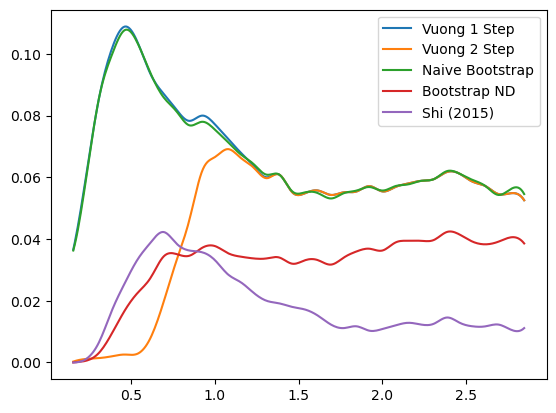

0.044721359549995794 0.09499340925884842


In [8]:
nobs = 500
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2)
print(c1,c2)

# Extra Power Sims

Quantiles: 1th: 0.71, 5th: 1.91, 10th: 3.27, 30th: 9.41, 50th: 16.23, 70th: 24.89, 90th: 39.93, 95th: 46.57, 99th: 62.68
bonus term 3.684984530307384 // variance stats 8.471891196442536 //part1 34.903772531645444 //part2 9.471891196442535 8.471891196442536
1.9416940473965987 -1.1805887089372862 5.450438446375812
-5.428275013218169 -1.1805887089372862 -1.919530614238955
---
Quantiles: 1th: 0.66, 5th: 2.06, 10th: 3.74, 30th: 11.12, 50th: 19.23, 70th: 29.95, 90th: 47.25, 95th: 56.33, 99th: 74.28
bonus term 2.292574140968764 // variance stats 14.22470829095904 //part1 34.903772531645444 //part2 15.22470829095904 14.22470829095904
0.5883646314161968 -0.6694724803336695 4.240858750782055
-3.9967836505213308 -0.6694724803336695 -0.34428953115547256
---
Quantiles: 1th: 0.77, 5th: 1.80, 10th: 2.93, 30th: 8.53, 50th: 14.82, 70th: 22.78, 90th: 35.37, 95th: 42.81, 99th: 54.44
bonus term 0.589256495831363 // variance stats 58.23358126481208 //part1 34.903772531645444 //part2 59.23358126481208 58.23

Quantiles: 1th: 0.66, 5th: 1.94, 10th: 3.46, 30th: 9.98, 50th: 17.51, 70th: 26.74, 90th: 42.21, 95th: 49.61, 99th: 65.23
bonus term 0.6135339044287659 // variance stats 55.88972081199456 //part1 34.903772531645444 //part2 56.88972081199456 55.88972081199456
-1.4636280733741238 0.8450974366411343 2.4726699522278666
-2.690695882231656 0.8450974366411343 1.2456021433703344
---
Quantiles: 1th: 0.71, 5th: 1.99, 10th: 3.27, 30th: 10.06, 50th: 17.87, 70th: 27.54, 90th: 44.49, 95th: 53.58, 99th: 70.72
bonus term 4.957405229344616 // variance stats 6.040734198011049 //part1 34.903772531645444 //part2 7.040734198011049 6.040734198011049
3.1845480748856585 -1.8492005370400364 6.7283356579727185
-6.730262383803574 -1.8492005370400364 -3.1864748007165136
---
Quantiles: 1th: 0.72, 5th: 1.94, 10th: 3.46, 30th: 10.00, 50th: 17.50, 70th: 26.81, 90th: 42.29, 95th: 50.38, 99th: 65.19
bonus term 10.757664358168363 // variance stats 2.2445493156832677 //part1 34.903772531645444 //part2 3.2445493156832677 2

Quantiles: 1th: 0.78, 5th: 1.83, 10th: 3.21, 30th: 9.51, 50th: 16.61, 70th: 25.81, 90th: 40.91, 95th: 48.55, 99th: 61.77
bonus term 18.160116255989 // variance stats 0.9220016017317388 //part1 34.903772531645444 //part2 1.9220016017317387 0.9220016017317388
17.16800665482208 -6.183564354509067 19.122294730907882
-19.15222585715592 -6.183564354509067 -17.197937781070117
---
Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.32, 30th: 9.81, 50th: 16.97, 70th: 25.72, 90th: 41.20, 95th: 47.94, 99th: 62.24
bonus term 1.0765431425271226 // variance stats 31.422084311187806 //part1 34.903772531645444 //part2 32.42208431118781 31.422084311187806
-0.855415615082721 0.23785801488365116 3.001902507003321
-3.008501900136966 0.23785801488365116 0.8488162219490756
---
Quantiles: 1th: 0.81, 5th: 1.89, 10th: 3.43, 30th: 9.82, 50th: 17.12, 70th: 25.67, 90th: 40.52, 95th: 47.92, 99th: 63.54
bonus term 9.861479398581452 // variance stats 2.53940530836238 //part1 34.903772531645444 //part2 3.53940530836238 2.539405

Quantiles: 1th: 0.72, 5th: 2.11, 10th: 3.64, 30th: 10.37, 50th: 17.91, 70th: 28.08, 90th: 44.04, 95th: 51.98, 99th: 70.68
bonus term 3.0373788794167216 // variance stats 10.491412140966798 //part1 34.903772531645444 //part2 11.491412140966798 10.491412140966798
1.2606325434792354 -1.1497743797845037 4.8945920722085985
-4.814125215354207 -1.1497743797845037 -1.1801656866248444
---
Quantiles: 1th: 0.77, 5th: 1.91, 10th: 3.30, 30th: 9.30, 50th: 16.42, 70th: 25.74, 90th: 41.21, 95th: 49.41, 99th: 63.99
bonus term 1.4330335772528362 // variance stats 23.356562948480878 //part1 34.903772531645444 //part2 24.356562948480878 23.356562948480878
-0.4359436154521049 -0.15278331924537855 3.4328556288431002
-3.302010769957777 -0.15278331924537855 0.5667884743374277
---
Quantiles: 1th: 0.70, 5th: 1.87, 10th: 3.24, 30th: 9.59, 50th: 16.57, 70th: 25.12, 90th: 40.64, 95th: 49.46, 99th: 66.50
bonus term 1.0729757821691126 // variance stats 31.529879156344485 //part1 34.903772531645444 //part2 32.5298791

Quantiles: 1th: 0.68, 5th: 1.77, 10th: 3.00, 30th: 8.36, 50th: 14.92, 70th: 22.69, 90th: 35.50, 95th: 42.45, 99th: 55.29
bonus term 2.777968376584482 // variance stats 11.564495991332956 //part1 34.903772531645444 //part2 12.564495991332956 11.564495991332956
0.9394949293845107 -0.65547518853045 4.575007233171349
-4.616441823784453 -0.65547518853045 -0.9809295199976142
---
Quantiles: 1th: 0.63, 5th: 1.77, 10th: 3.07, 30th: 8.96, 50th: 15.45, 70th: 23.38, 90th: 38.15, 95th: 45.49, 99th: 60.09
bonus term 1.0638483448413492 // variance stats 31.808973855056955 //part1 34.903772531645444 //part2 32.80897385505696 31.808973855056955
-0.857120168847304 0.18646652326555177 2.927980965328183
-2.984816858530002 0.18646652326555177 0.8002842756454845
---
Quantiles: 1th: 0.63, 5th: 1.90, 10th: 3.23, 30th: 9.51, 50th: 16.76, 70th: 25.48, 90th: 39.93, 95th: 48.28, 99th: 64.65
bonus term 4.066711701326389 // variance stats 7.582799838075886 //part1 34.903772531645444 //part2 8.582799838075886 7.5827

Quantiles: 1th: 0.72, 5th: 1.85, 10th: 3.30, 30th: 8.95, 50th: 15.38, 70th: 23.90, 90th: 37.94, 95th: 44.62, 99th: 58.42
bonus term 1.1964838173865313 // variance stats 28.171955378289557 //part1 34.903772531645444 //part2 29.171955378289557 28.171955378289557
-0.814597965555922 -0.02759113927815367 3.146728016224158
-3.207565600328985 -0.02759113927815367 0.753760381451095
---
Quantiles: 1th: 0.81, 5th: 2.09, 10th: 3.74, 30th: 10.55, 50th: 18.29, 70th: 28.00, 90th: 44.40, 95th: 52.50, 99th: 69.97
bonus term 1.1553977469668701 // variance stats 29.20931330641263 //part1 34.903772531645444 //part2 30.20931330641263 29.20931330641263
-0.6350463157025248 -0.03954139157335086 3.1586690987025907
-2.9458418096362653 -0.03954139157335086 0.8478736047688508
---
Quantiles: 1th: 0.81, 5th: 1.93, 10th: 3.18, 30th: 9.07, 50th: 15.78, 70th: 24.22, 90th: 39.22, 95th: 46.81, 99th: 63.70
bonus term 2.0555869937636118 // variance stats 15.97995396815558 //part1 34.903772531645444 //part2 16.97995396815

Quantiles: 1th: 0.75, 5th: 1.79, 10th: 2.88, 30th: 8.08, 50th: 14.08, 70th: 21.21, 90th: 33.78, 95th: 40.43, 99th: 51.80
bonus term 1.2846816442555609 // variance stats 26.16920000197501 //part1 34.903772531645444 //part2 27.16920000197501 26.16920000197501
-0.5781118211934795 -0.046979798824251184 3.153433860449598
-3.1474751097046014 -0.046979798824251184 0.5840705719384762
---
Quantiles: 1th: 0.71, 5th: 1.80, 10th: 3.14, 30th: 8.73, 50th: 14.71, 70th: 22.25, 90th: 34.53, 95th: 41.20, 99th: 56.04
bonus term 4.1195233535685345 // variance stats 7.472769671619914 //part1 34.903772531645444 //part2 8.472769671619915 7.472769671619914
2.321911770768144 -2.3366766967807564 5.967944881111187
-5.917134936368925 -2.3366766967807564 -2.271101826025882
---
Quantiles: 1th: 0.74, 5th: 1.82, 10th: 3.43, 30th: 10.11, 50th: 17.57, 70th: 26.52, 90th: 42.09, 95th: 49.98, 99th: 64.80
bonus term 0.7720810002512541 // variance stats 44.20739730713085 //part1 34.903772531645444 //part2 45.20739730713085 

Quantiles: 1th: 0.76, 5th: 2.06, 10th: 3.58, 30th: 10.38, 50th: 18.59, 70th: 28.22, 90th: 45.12, 95th: 53.88, 99th: 70.02
bonus term 1.2956622264457303 // variance stats 25.93894428596079 //part1 34.903772531645444 //part2 26.938944285960787 25.93894428596079
-0.7394303686707018 -0.5391727476584741 3.1270098151969896
-3.3307548215621625 -0.5391727476584741 0.5356853623055292
---
Quantiles: 1th: 0.80, 5th: 1.97, 10th: 3.49, 30th: 9.68, 50th: 17.47, 70th: 26.93, 90th: 42.63, 95th: 51.18, 99th: 67.20
bonus term 3.9224040359923156 // variance stats 7.898566341296162 //part1 34.903772531645444 //part2 8.898566341296162 7.898566341296162
2.2284629928013353 -2.7051679124226187 5.564560010493005
-5.616345079183295 -2.7051679124226187 -2.2802480614916263
---
Quantiles: 1th: 0.69, 5th: 1.61, 10th: 2.74, 30th: 7.81, 50th: 14.06, 70th: 21.40, 90th: 33.63, 95th: 39.92, 99th: 52.16
bonus term 2.752547019323033 // variance stats 11.680536349286324 //part1 34.903772531645444 //part2 12.680536349286324

Quantiles: 1th: 0.60, 5th: 1.86, 10th: 3.42, 30th: 10.49, 50th: 18.06, 70th: 27.65, 90th: 44.39, 95th: 53.19, 99th: 69.45
bonus term 3.983648204432168 // variance stats 7.761760763114536 //part1 34.903772531645444 //part2 8.761760763114534 7.761760763114536
2.147331829542482 -5.442585376300157 5.6679771726810415
-5.819964579321854 -5.442585376300157 -2.2993192361832953
---
Quantiles: 1th: 0.73, 5th: 1.80, 10th: 3.04, 30th: 8.78, 50th: 15.44, 70th: 23.76, 90th: 37.58, 95th: 44.49, 99th: 59.17
bonus term 3.517042325713849 // variance stats 8.924183248082201 //part1 34.903772531645444 //part2 9.9241832480822 8.924183248082201
1.7254873684086736 -3.431129542936155 5.24775015555977
-5.308597283019024 -3.431129542936155 -1.7863344958679273
---
Quantiles: 1th: 0.65, 5th: 1.64, 10th: 2.99, 30th: 8.76, 50th: 15.11, 70th: 23.22, 90th: 36.70, 95th: 44.31, 99th: 58.35
bonus term 1.1667001900928016 // variance stats 28.91665967661249 //part1 34.903772531645444 //part2 29.91665967661249 28.916659676

Quantiles: 1th: 0.67, 5th: 1.60, 10th: 2.57, 30th: 7.78, 50th: 13.39, 70th: 20.34, 90th: 32.36, 95th: 38.90, 99th: 50.65
bonus term 2.7127111158355355 // variance stats 11.866748813721294 //part1 34.903772531645444 //part2 12.866748813721294 11.866748813721294
0.862996604610829 -4.1976280236889565 4.4588593404404975
-4.562425627060242 -4.1976280236889565 -0.9665628912305728
---
Quantiles: 1th: 0.75, 5th: 2.21, 10th: 3.86, 30th: 10.90, 50th: 18.88, 70th: 28.66, 90th: 45.65, 95th: 54.59, 99th: 70.98
bonus term 1.3638796277038687 // variance stats 24.591534489306042 //part1 34.903772531645444 //part2 25.591534489306042 24.591534489306042
-0.61190275899582 -1.5716231142947896 3.0852344854287805
-3.3396620144035576 -1.5716231142947896 0.35747523002104287
---
Quantiles: 1th: 0.82, 5th: 2.05, 10th: 3.59, 30th: 10.07, 50th: 17.56, 70th: 26.56, 90th: 42.38, 95th: 50.03, 99th: 66.03
bonus term 3.4777775360127414 // variance stats 9.036229221165907 //part1 34.903772531645444 //part2 10.0362292211

Quantiles: 1th: 0.87, 5th: 2.20, 10th: 3.59, 30th: 10.62, 50th: 18.74, 70th: 28.58, 90th: 45.32, 95th: 53.52, 99th: 73.23
bonus term 0.8228889363894415 // variance stats 41.416140244625716 //part1 34.903772531645444 //part2 42.416140244625716 41.416140244625716
-1.1193927669204327 -0.5195711287950738 2.8050249223992756
-2.7651706396993156 -0.5195711287950738 1.1592470496203928
---
Quantiles: 1th: 0.85, 5th: 2.24, 10th: 3.85, 30th: 11.38, 50th: 19.23, 70th: 29.15, 90th: 45.77, 95th: 55.31, 99th: 73.05
bonus term 1.5798550717151951 // variance stats 21.093021794557142 //part1 34.903772531645444 //part2 22.093021794557142 21.093021794557142
-0.19385968313348811 -2.261701061131086 3.4248131686860215
-3.3535698265638785 -2.261701061131086 0.2651030252556312
---
Quantiles: 1th: 0.72, 5th: 1.91, 10th: 3.38, 30th: 9.91, 50th: 17.29, 70th: 26.63, 90th: 41.38, 95th: 49.46, 99th: 64.42
bonus term 2.796772943121536 // variance stats 11.48001651957081 //part1 34.903772531645444 //part2 12.480016519

Quantiles: 1th: 0.79, 5th: 2.08, 10th: 3.47, 30th: 10.24, 50th: 17.95, 70th: 27.45, 90th: 43.61, 95th: 51.83, 99th: 68.57
bonus term 2.311438290971424 // variance stats 14.100456139357496 //part1 34.903772531645444 //part2 15.100456139357496 14.100456139357496
0.43233211320388837 -3.3064040825629966 4.208687173067939
-4.19054446873896 -3.3064040825629966 -0.41418940887490985
---
Quantiles: 1th: 0.77, 5th: 2.09, 10th: 3.63, 30th: 10.59, 50th: 18.20, 70th: 27.91, 90th: 43.25, 95th: 52.21, 99th: 69.07
bonus term 1.6951388307134465 // variance stats 19.590509697046592 //part1 34.903772531645444 //part2 20.590509697046592 19.590509697046592
-0.20788218781085113 -1.5704937390952107 3.579220125645346
-3.598159849237744 -1.5704937390952107 0.18894246421845323
---
Quantiles: 1th: 0.72, 5th: 1.88, 10th: 3.11, 30th: 8.23, 50th: 14.52, 70th: 22.10, 90th: 35.21, 95th: 41.99, 99th: 56.12
bonus term 2.231616513030927 // variance stats 14.64057817632833 //part1 34.903772531645444 //part2 15.6405781763

Quantiles: 1th: 0.71, 5th: 1.84, 10th: 3.18, 30th: 9.64, 50th: 16.80, 70th: 25.80, 90th: 40.34, 95th: 47.77, 99th: 64.11
bonus term 1.781990089400682 // variance stats 18.586962205488057 //part1 34.903772531645444 //part2 19.586962205488057 18.586962205488057
-0.23646374499515974 -3.1260834060650198 3.676726977767339
-3.8004439237965237 -3.1260834060650198 0.11274679896597517
---
Quantiles: 1th: 0.77, 5th: 2.12, 10th: 3.94, 30th: 11.98, 50th: 21.90, 70th: 32.57, 90th: 51.49, 95th: 61.84, 99th: 78.95
bonus term 1.6272825875138817 // variance stats 20.44911572179389 //part1 34.903772531645444 //part2 21.44911572179389 20.44911572179389
-0.3234202484469895 -2.885743698871134 3.489733284330026
-3.577985423474753 -2.885743698871134 0.23516810930226256
---
Quantiles: 1th: 0.65, 5th: 1.70, 10th: 3.01, 30th: 9.01, 50th: 15.66, 70th: 24.51, 90th: 38.73, 95th: 45.90, 99th: 60.27
bonus term 0.7359221535390272 // variance stats 46.42862049171133 //part1 34.903772531645444 //part2 47.42862049171133

Quantiles: 1th: 0.60, 5th: 1.64, 10th: 2.83, 30th: 8.59, 50th: 15.07, 70th: 23.59, 90th: 37.68, 95th: 44.98, 99th: 61.62
bonus term 2.6944265669637026 // variance stats 11.95406338387534 //part1 34.903772531645444 //part2 12.95406338387534 11.95406338387534
0.7648212396593574 -6.636895333404672 4.486425144641605
-4.624031894268048 -6.636895333404672 -0.9024279892857999
---
Quantiles: 1th: 0.77, 5th: 2.04, 10th: 3.51, 30th: 10.38, 50th: 17.95, 70th: 27.42, 90th: 43.10, 95th: 51.11, 99th: 66.76
bonus term 1.496021243626047 // variance stats 22.331067443297727 //part1 34.903772531645444 //part2 23.331067443297727 22.331067443297727
-0.4843004617973846 -3.2911564500728865 3.2779940624319677
-3.476342949049479 -3.2911564500728865 0.2859515751798739
---
Quantiles: 1th: 0.83, 5th: 1.99, 10th: 3.64, 30th: 10.45, 50th: 17.84, 70th: 27.15, 90th: 43.06, 95th: 51.88, 99th: 67.22
bonus term 2.4330837430925167 // variance stats 13.345487544658772 //part1 34.903772531645444 //part2 14.345487544658772

Quantiles: 1th: 0.59, 5th: 1.70, 10th: 2.96, 30th: 8.29, 50th: 14.44, 70th: 22.55, 90th: 35.93, 95th: 42.33, 99th: 55.31
bonus term 2.5070455814862727 // variance stats 12.922272809636413 //part1 34.903772531645444 //part2 13.922272809636413 12.922272809636413
0.6737136404525745 -5.154873486122587 4.361215946777956
-4.3403775225199706 -5.154873486122587 -0.65287521619459
---
Quantiles: 1th: 0.64, 5th: 1.76, 10th: 2.96, 30th: 9.24, 50th: 16.17, 70th: 24.82, 90th: 39.55, 95th: 47.45, 99th: 59.96
bonus term 2.47287837289443 // variance stats 13.114633745933741 //part1 34.903772531645444 //part2 14.114633745933741 13.114633745933741
0.4190074874872473 -6.672974547006574 4.282264297442556
-4.526749258301614 -6.672974547006574 -0.663492448346303
---
Quantiles: 1th: 0.77, 5th: 2.08, 10th: 3.61, 30th: 10.93, 50th: 19.34, 70th: 29.42, 90th: 46.44, 95th: 55.13, 99th: 71.65
bonus term 1.6020686757234417 // variance stats 20.786689335202215 //part1 34.903772531645444 //part2 21.786689335202215 20.

Quantiles: 1th: 0.71, 5th: 1.85, 10th: 3.26, 30th: 9.42, 50th: 16.34, 70th: 25.08, 90th: 40.43, 95th: 48.75, 99th: 64.08
bonus term 0.7307671139410081 // variance stats 46.76319550480357 //part1 34.903772531645444 //part2 47.763195504803576 46.76319550480357
-1.1226652870807505 -0.8513016690534454 2.677061851882841
-2.5841995149627666 -0.8513016690534454 1.2155276240008241
---
Quantiles: 1th: 0.76, 5th: 1.81, 10th: 3.09, 30th: 8.90, 50th: 15.59, 70th: 23.84, 90th: 37.58, 95th: 45.42, 99th: 58.53
bonus term 1.0484595017649037 // variance stats 32.29053003276794 //part1 34.903772531645444 //part2 33.29053003276795 32.29053003276794
-0.8029175415087274 -2.2200783295268067 2.8876926010288293
-2.899836545038535 -2.2200783295268067 0.7907735974990215
---
Quantiles: 1th: 0.81, 5th: 2.07, 10th: 3.66, 30th: 11.28, 50th: 19.85, 70th: 30.43, 90th: 47.40, 95th: 56.80, 99th: 75.40
bonus term 1.595197715884751 // variance stats 20.880530660292862 //part1 34.903772531645444 //part2 21.880530660292862

Quantiles: 1th: 0.70, 5th: 1.81, 10th: 3.24, 30th: 9.65, 50th: 16.93, 70th: 25.65, 90th: 41.74, 95th: 49.27, 99th: 62.47
bonus term 2.0843980768959116 // variance stats 15.745252703180471 //part1 34.903772531645444 //part2 16.745252703180473 15.745252703180471
-0.043583941596492405 -7.680099022677223 3.9645563866462314
-4.2123800953883155 -7.680099022677223 -0.20423976714559194
---
Quantiles: 1th: 0.77, 5th: 1.90, 10th: 3.39, 30th: 10.11, 50th: 17.28, 70th: 26.09, 90th: 41.34, 95th: 49.14, 99th: 66.52
bonus term 1.4732828005674188 // variance stats 22.69115591263445 //part1 34.903772531645444 //part2 23.691155912634446 22.69115591263445
-0.45577226702132917 -3.9841227704794893 3.2986500472888367
-3.4023378681561667 -3.9841227704794893 0.3520844461539992
---
Quantiles: 1th: 0.76, 5th: 1.94, 10th: 3.34, 30th: 10.09, 50th: 17.90, 70th: 27.56, 90th: 43.91, 95th: 52.18, 99th: 67.33
bonus term 1.4490084720643437 // variance stats 23.088038962201132 //part1 34.903772531645444 //part2 24.08803

Quantiles: 1th: 0.75, 5th: 1.83, 10th: 3.18, 30th: 8.85, 50th: 15.56, 70th: 23.42, 90th: 37.72, 95th: 44.68, 99th: 58.00
bonus term 1.9050424140932793 // variance stats 17.32178237787854 //part1 34.903772531645444 //part2 18.32178237787854 17.32178237787854
-0.0732801471894441 -7.939804353541395 3.8690541309027493
-3.883364975376003 -7.939804353541395 0.058969302716190546
---
Quantiles: 1th: 0.80, 5th: 1.96, 10th: 3.10, 30th: 8.73, 50th: 15.17, 70th: 23.29, 90th: 36.78, 95th: 44.00, 99th: 58.46
bonus term 1.8989792151360187 // variance stats 17.380281497259766 //part1 34.903772531645444 //part2 18.380281497259766 17.380281497259766
-0.009879364924204641 -7.082908213322929 3.7372965270549643
-3.8078377951962423 -7.082908213322929 -0.06066190321707334
---
Quantiles: 1th: 0.66, 5th: 1.69, 10th: 2.95, 30th: 8.15, 50th: 14.22, 70th: 21.69, 90th: 34.90, 95th: 41.11, 99th: 54.94
bonus term 1.0719850530805402 // variance stats 31.559943285909842 //part1 34.903772531645444 //part2 32.5599432859

Quantiles: 1th: 0.68, 5th: 1.95, 10th: 3.32, 30th: 10.59, 50th: 18.42, 70th: 28.27, 90th: 45.59, 95th: 54.68, 99th: 73.01
bonus term 1.6672359570853816 // variance stats 19.935112623568475 //part1 34.903772531645444 //part2 20.935112623568475 19.935112623568475
-0.38892795042418327 -7.148941129846492 3.514031351956528
-3.7233998645949464 -7.148941129846492 0.17955943778576516
---
Quantiles: 1th: 0.72, 5th: 2.01, 10th: 3.48, 30th: 10.82, 50th: 18.62, 70th: 28.72, 90th: 45.08, 95th: 54.55, 99th: 71.87
bonus term 0.741347617658117 // variance stats 46.0815197894678 //part1 34.903772531645444 //part2 47.0815197894678 46.0815197894678
-0.9958774772213298 -2.9984133966205566 2.6805908350490575
-2.478572712537564 -2.9984133966205566 1.1978955997328233
---
Quantiles: 1th: 0.69, 5th: 1.84, 10th: 3.05, 30th: 9.85, 50th: 16.92, 70th: 25.67, 90th: 40.64, 95th: 47.88, 99th: 61.49
bonus term 1.8382549382865092 // variance stats 17.987449349207388 //part1 34.903772531645444 //part2 18.987449349207385

Quantiles: 1th: 0.70, 5th: 1.87, 10th: 3.06, 30th: 9.08, 50th: 15.76, 70th: 23.79, 90th: 38.21, 95th: 45.71, 99th: 58.73
bonus term 0.9100178248800516 // variance stats 37.35504270067025 //part1 34.903772531645444 //part2 38.35504270067025 37.35504270067025
-1.357236585672862 -3.382961151996687 2.773485641735369
-3.1772722354329654 -3.382961151996687 0.9534499919752657
---
Quantiles: 1th: 0.79, 5th: 2.05, 10th: 3.48, 30th: 10.11, 50th: 17.62, 70th: 27.12, 90th: 42.85, 95th: 52.13, 99th: 67.51
bonus term 1.6036550348899679 // variance stats 20.7651376214089 //part1 34.903772531645444 //part2 21.7651376214089 20.7651376214089
-0.3503634471758287 -6.491288185146182 3.4704177740654667
-3.5576735169557647 -6.491288185146182 0.26310770428553093
---
Quantiles: 1th: 0.72, 5th: 1.88, 10th: 3.38, 30th: 9.64, 50th: 16.39, 70th: 25.11, 90th: 39.61, 95th: 46.80, 99th: 62.53
bonus term 0.971924398137912 // variance stats 34.9120242258727 //part1 34.903772531645444 //part2 35.912024225872706 34.91202

Quantiles: 1th: 0.70, 5th: 1.82, 10th: 3.07, 30th: 8.84, 50th: 15.26, 70th: 23.71, 90th: 37.66, 95th: 44.42, 99th: 57.36
bonus term 1.2075207921536686 // variance stats 27.905318035470813 //part1 34.903772531645444 //part2 28.905318035470813 27.905318035470813
-0.9449716918751415 -7.250814787263716 3.117364844620271
-3.3600132761824786 -7.250814787263716 0.7023232603129337
---
Quantiles: 1th: 0.69, 5th: 1.85, 10th: 3.37, 30th: 9.39, 50th: 16.07, 70th: 24.94, 90th: 39.79, 95th: 46.93, 99th: 64.05
bonus term 1.2839418773598 // variance stats 26.184854039825304 //part1 34.903772531645444 //part2 27.184854039825304 26.184854039825304
-1.01074422312613 -6.307941798736603 3.3525408505827543
-3.57862797784573 -6.307941798736603 0.7846570958631546
---
Quantiles: 1th: 0.76, 5th: 2.15, 10th: 3.72, 30th: 11.15, 50th: 19.72, 70th: 29.76, 90th: 47.22, 95th: 56.14, 99th: 74.22
bonus term 1.4774164841602515 // variance stats 22.624870106606664 //part1 34.903772531645444 //part2 23.624870106606664 22.

Quantiles: 1th: 0.78, 5th: 2.07, 10th: 3.46, 30th: 9.73, 50th: 17.67, 70th: 27.62, 90th: 44.52, 95th: 52.37, 99th: 68.36
bonus term 0.738548297332062 // variance stats 46.25997291948559 //part1 34.903772531645444 //part2 47.2599729194856 46.25997291948559
-1.2705514619185057 -3.650318194897616 2.6289637892598394
-2.7476480565826296 -3.650318194897616 1.1518671945957157
---
Quantiles: 1th: 0.75, 5th: 1.98, 10th: 3.19, 30th: 9.82, 50th: 16.71, 70th: 25.75, 90th: 40.48, 95th: 48.41, 99th: 64.81
bonus term 1.7832464074171643 // variance stats 18.573162960804563 //part1 34.903772531645444 //part2 19.57316296080456 18.573162960804563
-0.2636449333636219 -9.038323543396173 3.6350237269259025
-3.8301377481979504 -9.038323543396173 0.06853091209157419
---
Quantiles: 1th: 0.74, 5th: 1.85, 10th: 2.99, 30th: 8.72, 50th: 15.07, 70th: 23.08, 90th: 36.66, 95th: 43.33, 99th: 55.98
bonus term 1.24748979611695 // variance stats 26.979204832207923 //part1 34.903772531645444 //part2 27.979204832207923 26.

Quantiles: 1th: 0.74, 5th: 2.01, 10th: 3.64, 30th: 11.21, 50th: 20.04, 70th: 30.22, 90th: 47.36, 95th: 56.08, 99th: 74.68
bonus term 1.0606079510868365 // variance stats 31.90921258498817 //part1 34.903772531645444 //part2 32.90921258498817 31.90921258498817
-1.0770839737045872 -5.580770434410446 2.8381502638960963
-3.19829987587826 -5.580770434410446 0.7169343617224232
---
Quantiles: 1th: 0.79, 5th: 1.85, 10th: 3.17, 30th: 9.52, 50th: 16.49, 70th: 25.03, 90th: 40.11, 95th: 47.72, 99th: 62.21
bonus term 0.7854044345321364 // variance stats 43.44050860552823 //part1 34.903772531645444 //part2 44.44050860552823 43.44050860552823
-1.053923646297378 -5.01574123937952 2.7925603038129334
-2.6247325153616505 -5.01574123937952 1.2217514347486609
---
Quantiles: 1th: 0.69, 5th: 1.73, 10th: 3.13, 30th: 8.95, 50th: 15.97, 70th: 24.70, 90th: 39.07, 95th: 46.51, 99th: 61.56
bonus term 0.5635369525033419 // variance stats 60.93697214813692 //part1 34.903772531645444 //part2 61.93697214813692 60.93697

Quantiles: 1th: 0.69, 5th: 1.84, 10th: 3.15, 30th: 8.90, 50th: 15.48, 70th: 23.85, 90th: 37.65, 95th: 45.64, 99th: 61.18
bonus term 0.7743361675108016 // variance stats 44.07573583169683 //part1 34.903772531645444 //part2 45.07573583169684 44.07573583169683
-1.3431962904737746 -3.6007733731411795 2.749814311307375
-2.891868625495378 -3.6007733731411795 1.2011419762857722
---
Quantiles: 1th: 0.67, 5th: 2.03, 10th: 3.80, 30th: 10.96, 50th: 18.68, 70th: 28.73, 90th: 45.46, 95th: 54.38, 99th: 70.66
bonus term 1.6149676675084468 // variance stats 20.612675741982237 //part1 34.903772531645444 //part2 21.612675741982237 20.612675741982237
-0.4574908702569067 -11.350996241761171 3.4128411971137065
-3.6874262052738 -11.350996241761171 0.18290586209681273
---
Quantiles: 1th: 0.75, 5th: 1.90, 10th: 3.47, 30th: 10.53, 50th: 18.13, 70th: 28.83, 90th: 45.30, 95th: 53.46, 99th: 67.37
bonus term 1.2312359285820904 // variance stats 27.348565633429125 //part1 34.903772531645444 //part2 28.3485656334291

Quantiles: 1th: 0.83, 5th: 2.01, 10th: 3.59, 30th: 10.56, 50th: 18.10, 70th: 27.84, 90th: 43.37, 95th: 52.35, 99th: 68.09
bonus term 1.351565156389132 // variance stats 24.82470579879038 //part1 34.903772531645444 //part2 25.82470579879038 24.82470579879038
-0.9375400360948146 -8.140352828368128 3.4052020069682176
-3.6406703488730785 -8.140352828368128 0.702071694189954
---
Quantiles: 1th: 0.71, 5th: 1.59, 10th: 2.68, 30th: 7.58, 50th: 13.41, 70th: 20.47, 90th: 32.83, 95th: 37.76, 99th: 49.15
bonus term 0.7685414569162313 // variance stats 44.41560148452713 //part1 34.903772531645444 //part2 45.41560148452713 44.41560148452713
-1.2097577167246918 -4.034439379663903 2.62509278169385
-2.7468406305571547 -4.034439379663903 1.0880098678613874
---
Quantiles: 1th: 0.78, 5th: 2.13, 10th: 3.61, 30th: 10.24, 50th: 17.41, 70th: 26.79, 90th: 42.23, 95th: 50.25, 99th: 65.40
bonus term 1.3466457895014206 // variance stats 24.919044787989975 //part1 34.903772531645444 //part2 25.919044787989975 24.9

Quantiles: 1th: 0.66, 5th: 1.86, 10th: 3.54, 30th: 10.18, 50th: 17.90, 70th: 27.09, 90th: 43.21, 95th: 50.01, 99th: 65.12
bonus term 0.6280222962318236 // variance stats 54.577282432599034 //part1 34.903772531645444 //part2 55.57728243259904 54.577282432599034
-1.5128633458232363 -3.5577552789198923 2.469528046612851
-2.7689079382868833 -3.5577552789198923 1.2134834541492039
---
Quantiles: 1th: 0.77, 5th: 1.94, 10th: 3.27, 30th: 10.00, 50th: 17.63, 70th: 26.88, 90th: 42.12, 95th: 51.72, 99th: 67.57
bonus term 1.4863282406906393 // variance stats 22.483219638904934 //part1 34.903772531645444 //part2 23.483219638904934 22.483219638904934
-0.6751965259741575 -11.49339445344577 3.4462695523288014
-3.6478530073554363 -11.49339445344577 0.4736130709475229
---
Quantiles: 1th: 0.71, 5th: 1.81, 10th: 3.11, 30th: 9.30, 50th: 16.17, 70th: 24.83, 90th: 38.92, 95th: 46.79, 99th: 61.31
bonus term 1.281847821562916 // variance stats 26.229263836551507 //part1 34.903772531645444 //part2 27.22926383655

Quantiles: 1th: 0.78, 5th: 1.95, 10th: 3.25, 30th: 9.51, 50th: 16.90, 70th: 26.53, 90th: 43.01, 95th: 50.33, 99th: 64.15
bonus term 1.242392074640809 // variance stats 27.094007716313353 //part1 34.903772531645444 //part2 28.094007716313353 27.094007716313353
-0.9920762193763192 -12.514473535997084 3.125265803214005
-3.476860368657937 -12.514473535997084 0.6404816539323871
---
Quantiles: 1th: 0.73, 5th: 2.06, 10th: 3.62, 30th: 10.71, 50th: 18.94, 70th: 28.91, 90th: 45.11, 95th: 53.62, 99th: 69.90
bonus term 1.2618299971911653 // variance stats 26.661232186064105 //part1 34.903772531645444 //part2 27.661232186064105 26.661232186064105
-0.6952209152640281 -11.8653821912747 3.15308143461991
-3.2188809096463586 -11.8653821912747 0.6294214402375794
---
Quantiles: 1th: 0.69, 5th: 1.81, 10th: 3.19, 30th: 10.00, 50th: 18.10, 70th: 27.45, 90th: 43.37, 95th: 52.01, 99th: 66.30
bonus term 1.2867203347876595 // variance stats 26.126152892738283 //part1 34.903772531645444 //part2 27.126152892738283

Quantiles: 1th: 0.76, 5th: 2.04, 10th: 3.47, 30th: 9.86, 50th: 17.64, 70th: 27.52, 90th: 43.78, 95th: 52.30, 99th: 67.93
bonus term 1.1643381307469345 // variance stats 28.977350745401015 //part1 34.903772531645444 //part2 29.97735074540101 28.977350745401015
-0.9775519035333143 -10.537729614714236 3.2390684074226397
-3.3062281650271834 -10.537729614714236 0.9103921459287708
---
Quantiles: 1th: 0.65, 5th: 1.87, 10th: 3.26, 30th: 9.88, 50th: 17.50, 70th: 27.17, 90th: 43.31, 95th: 51.22, 99th: 65.58
bonus term 0.8904545923760095 // variance stats 38.19770062447691 //part1 34.903772531645444 //part2 39.19770062447691 38.19770062447691
-1.4802028009040076 -7.816863805904468 2.8201927633021397
-3.261111985656027 -7.816863805904468 1.0392835785501204
---
Quantiles: 1th: 0.84, 5th: 1.98, 10th: 3.15, 30th: 9.58, 50th: 16.62, 70th: 25.79, 90th: 41.00, 95th: 48.95, 99th: 64.02
bonus term 1.0293324116019318 // variance stats 32.90913580320017 //part1 34.903772531645444 //part2 33.90913580320017 3

Quantiles: 1th: 0.71, 5th: 1.83, 10th: 3.15, 30th: 9.29, 50th: 16.44, 70th: 25.11, 90th: 39.58, 95th: 47.29, 99th: 60.71
bonus term 1.1349728312913074 // variance stats 29.752958634202653 //part1 34.903772531645444 //part2 30.752958634202653 29.752958634202653
-1.0223433924504626 -12.460762810837496 3.020370550729738
-3.292289055033077 -12.460762810837496 0.7504248881471232
---
Quantiles: 1th: 0.78, 5th: 2.00, 10th: 3.32, 30th: 9.64, 50th: 16.84, 70th: 26.26, 90th: 41.97, 95th: 49.99, 99th: 66.78
bonus term 1.087752032457783 // variance stats 31.08798649888995 //part1 34.903772531645444 //part2 32.08798649888995 31.08798649888995
-1.205704889078924 -11.152424837461252 3.078969022057189
-3.38120895399449 -11.152424837461252 0.9034649571416228
---
Quantiles: 1th: 0.57, 5th: 1.76, 10th: 2.98, 30th: 8.68, 50th: 15.53, 70th: 24.33, 90th: 39.09, 95th: 46.35, 99th: 60.65
bonus term 1.1150230734798459 // variance stats 30.30318408812401 //part1 34.903772531645444 //part2 31.30318408812401 30.3

Quantiles: 1th: 0.74, 5th: 1.90, 10th: 3.56, 30th: 9.74, 50th: 17.40, 70th: 26.64, 90th: 42.45, 95th: 51.85, 99th: 69.65
bonus term 1.189436969646797 // variance stats 28.344785324782794 //part1 34.903772531645444 //part2 29.34478532478279 28.344785324782794
-1.1541983311652648 -11.881915150955589 3.211402313374099
-3.533072270458859 -11.881915150955589 0.832528374080505
---
Quantiles: 1th: 0.72, 5th: 1.97, 10th: 3.41, 30th: 9.53, 50th: 16.41, 70th: 25.22, 90th: 39.57, 95th: 46.97, 99th: 63.12
bonus term 1.0577853832616757 // variance stats 31.997026697438226 //part1 34.903772531645444 //part2 32.99702669743823 31.997026697438226
-1.2046956048682091 -11.919483713710806 3.1757680998282436
-3.3202663713915603 -11.919483713710806 1.0601973333048922
---
Quantiles: 1th: 0.79, 5th: 1.89, 10th: 3.23, 30th: 9.57, 50th: 16.56, 70th: 25.15, 90th: 40.30, 95th: 48.04, 99th: 65.67
bonus term 1.2385141354806122 // variance stats 27.181973488821622 //part1 34.903772531645444 //part2 28.18197348882162

Quantiles: 1th: 0.68, 5th: 1.82, 10th: 3.09, 30th: 9.09, 50th: 15.54, 70th: 23.79, 90th: 37.79, 95th: 44.85, 99th: 58.57
bonus term 1.0371960436267307 // variance stats 32.652049432813605 //part1 34.903772531645444 //part2 33.652049432813605 32.652049432813605
-1.2010987758461689 -12.500513383460481 3.089664320418878
-3.27549086309963 -12.500513383460481 1.0152722331654167
---
Quantiles: 1th: 0.75, 5th: 1.88, 10th: 3.31, 30th: 9.65, 50th: 16.98, 70th: 26.15, 90th: 42.80, 95th: 50.38, 99th: 65.30
bonus term 0.6830606182940774 // variance stats 50.099084908183585 //part1 34.903772531645444 //part2 51.099084908183585 50.099084908183585
-1.3447213583281417 -6.7011573634092425 2.542091235328831
-2.7108425949162966 -6.7011573634092425 1.1759699987406764
---
Quantiles: 1th: 0.77, 5th: 2.08, 10th: 3.55, 30th: 10.73, 50th: 18.43, 70th: 27.70, 90th: 44.26, 95th: 51.98, 99th: 69.70
bonus term 0.7214077610099 // variance stats 47.38286253364337 //part1 34.903772531645444 //part2 48.38286253364337 

Quantiles: 1th: 0.83, 5th: 2.12, 10th: 3.81, 30th: 11.34, 50th: 19.47, 70th: 29.33, 90th: 46.35, 95th: 54.62, 99th: 73.10
bonus term 0.7113603500355816 // variance stats 48.06623278890872 //part1 34.903772531645444 //part2 49.06623278890872 48.06623278890872
-1.4641850936572853 -8.679168104659253 2.5558396223202884
-2.886905793728449 -8.679168104659253 1.1331189222491251
---
Quantiles: 1th: 0.71, 5th: 1.86, 10th: 3.36, 30th: 9.82, 50th: 17.14, 70th: 26.40, 90th: 41.72, 95th: 49.53, 99th: 66.12
bonus term 1.029199565330834 // variance stats 32.91351270190801 //part1 34.903772531645444 //part2 33.91351270190802 32.91351270190801
-1.374874257588651 -14.49913252640339 3.3215617803562085
-3.433273388250319 -14.49913252640339 1.2631626496945407
---
Quantiles: 1th: 0.70, 5th: 1.90, 10th: 3.36, 30th: 9.74, 50th: 16.84, 70th: 25.48, 90th: 41.17, 95th: 50.49, 99th: 65.72
bonus term 1.0743585623497647 // variance stats 31.488010758071553 //part1 34.903772531645444 //part2 32.48801075807155 31.488

Quantiles: 1th: 0.88, 5th: 2.02, 10th: 3.47, 30th: 9.94, 50th: 16.92, 70th: 25.97, 90th: 41.72, 95th: 50.35, 99th: 67.23
bonus term 1.030605384785041 // variance stats 32.86725224507294 //part1 34.903772531645444 //part2 33.86725224507295 32.86725224507294
-1.1928497069572372 -14.298024963044247 2.8748375198926563
-3.254060476527319 -14.298024963044247 0.8136267503225747
---
Quantiles: 1th: 0.75, 5th: 1.85, 10th: 3.22, 30th: 9.49, 50th: 16.78, 70th: 26.31, 90th: 42.03, 95th: 50.92, 99th: 67.02
bonus term 0.7281337475798919 // variance stats 46.935935736608265 //part1 34.903772531645444 //part2 47.935935736608265 46.935935736608265
-1.194234264858568 -8.968701502733172 2.6532641442624754
-2.6505017600183516 -8.968701502733172 1.1969966491026915
---
Quantiles: 1th: 0.76, 5th: 1.79, 10th: 3.22, 30th: 9.70, 50th: 17.10, 70th: 26.69, 90th: 42.50, 95th: 49.84, 99th: 66.28
bonus term 1.0458298106008825 // variance stats 32.374237545965 //part1 34.903772531645444 //part2 33.374237545965 32.374

Quantiles: 1th: 0.83, 5th: 1.98, 10th: 3.58, 30th: 9.82, 50th: 17.20, 70th: 26.58, 90th: 42.03, 95th: 50.64, 99th: 65.98
bonus term 0.7251005210980155 // variance stats 47.13646041626182 //part1 34.903772531645444 //part2 48.13646041626182 47.13646041626182
-1.5247844772184027 -10.34754954961132 2.596313829847333
-2.974985519414434 -10.34754954961132 1.1461127876513018
---
Quantiles: 1th: 0.75, 5th: 1.92, 10th: 3.19, 30th: 9.46, 50th: 16.66, 70th: 25.75, 90th: 39.85, 95th: 47.96, 99th: 64.77
bonus term 0.9704495563037616 // variance stats 34.96660156617163 //part1 34.903772531645444 //part2 35.96660156617163 34.96660156617163
-1.3055813397896787 -13.175137366262051 2.9746765534275936
-3.246480452397202 -13.175137366262051 1.0337774408200704
---
Quantiles: 1th: 0.60, 5th: 1.79, 10th: 3.07, 30th: 9.01, 50th: 16.11, 70th: 24.86, 90th: 39.78, 95th: 48.20, 99th: 63.03
bonus term 0.7477448812816535 // variance stats 45.67871811013871 //part1 34.903772531645444 //part2 46.67871811013871 45.67

Quantiles: 1th: 0.77, 5th: 2.11, 10th: 3.78, 30th: 11.05, 50th: 19.10, 70th: 29.30, 90th: 45.81, 95th: 54.97, 99th: 70.91
bonus term 1.1251308401275308 // variance stats 30.021967656392018 //part1 34.903772531645444 //part2 31.021967656392018 30.021967656392018
-1.0686693204553868 -15.109450880203733 3.211338071920896
-3.318931000710448 -15.109450880203733 0.9610763916658345
---
Quantiles: 1th: 0.62, 5th: 1.68, 10th: 2.82, 30th: 8.61, 50th: 14.70, 70th: 22.45, 90th: 35.48, 95th: 42.11, 99th: 55.25
bonus term 1.0826498867288714 // variance stats 31.23920582221093 //part1 34.903772531645444 //part2 32.239205822210934 31.23920582221093
-1.3765289535230927 -15.483763154995737 3.181204184038792
-3.5418287269808357 -15.483763154995737 1.0159044105810489
---
Quantiles: 1th: 0.72, 5th: 1.83, 10th: 3.07, 30th: 8.80, 50th: 15.56, 70th: 24.13, 90th: 38.57, 95th: 45.77, 99th: 58.50
bonus term 1.0355789586537936 // variance stats 32.70459803182829 //part1 34.903772531645444 //part2 33.7045980318282

Quantiles: 1th: 0.64, 5th: 1.77, 10th: 2.94, 30th: 8.79, 50th: 14.85, 70th: 22.87, 90th: 36.08, 95th: 42.55, 99th: 55.89
bonus term 1.0639101343622488 // variance stats 31.80706838324102 //part1 34.903772531645444 //part2 32.807068383241024 31.80706838324102
-1.4430150504880086 -15.450235161684724 3.3627941765834493
-3.5708353192125064 -15.450235161684724 1.2349739078589517
---
Quantiles: 1th: 0.69, 5th: 1.91, 10th: 3.16, 30th: 9.51, 50th: 16.91, 70th: 25.44, 90th: 40.68, 95th: 48.40, 99th: 66.56
bonus term 0.9369263079632864 // variance stats 36.25348753150087 //part1 34.903772531645444 //part2 37.25348753150088 36.25348753150087
-1.1418349689651073 -14.791821887351203 2.9253068796591806
-3.01568758489168 -14.791821887351203 1.0514542637326074
---
Quantiles: 1th: 0.75, 5th: 2.02, 10th: 3.67, 30th: 10.79, 50th: 18.78, 70th: 29.28, 90th: 47.11, 95th: 56.50, 99th: 71.75
bonus term 0.645218967310934 // variance stats 53.096011276781255 //part1 34.903772531645444 //part2 54.096011276781255

Quantiles: 1th: 0.69, 5th: 1.92, 10th: 3.22, 30th: 9.76, 50th: 16.91, 70th: 25.96, 90th: 41.42, 95th: 49.23, 99th: 67.91
bonus term 0.6505660309506743 // variance stats 52.65139105194355 //part1 34.903772531645444 //part2 53.651391051943556 52.65139105194355
-1.6329558867935385 -10.502217280606521 2.5637253866975045
-2.9340879486948874 -10.502217280606521 1.2625933247961556
---
Quantiles: 1th: 0.69, 5th: 2.03, 10th: 3.58, 30th: 10.05, 50th: 17.28, 70th: 26.59, 90th: 41.80, 95th: 48.88, 99th: 65.20
bonus term 0.7613595470477618 // variance stats 44.844007167162836 //part1 34.903772531645444 //part2 45.844007167162836 44.844007167162836
-1.509324203541358 -11.120924164366189 2.7965561238832106
-3.0320432976368816 -11.120924164366189 1.273837029787687
---
Quantiles: 1th: 0.81, 5th: 1.95, 10th: 3.35, 30th: 9.23, 50th: 16.24, 70th: 24.80, 90th: 39.17, 95th: 46.38, 99th: 59.60
bonus term 0.9910822340654443 // variance stats 34.21783695836145 //part1 34.903772531645444 //part2 35.217836958361

Quantiles: 1th: 0.62, 5th: 1.73, 10th: 3.22, 30th: 9.52, 50th: 16.49, 70th: 25.22, 90th: 40.15, 95th: 46.62, 99th: 60.99
bonus term 1.0415643239515084 // variance stats 32.51091404439313 //part1 34.903772531645444 //part2 33.51091404439313 32.51091404439313
-1.7492066289598174 -19.174077478586188 3.41336094800565
-3.8323352768628345 -19.174077478586188 1.3302323001026328
---
Quantiles: 1th: 0.81, 5th: 1.89, 10th: 3.25, 30th: 9.56, 50th: 16.09, 70th: 24.48, 90th: 39.44, 95th: 46.73, 99th: 60.19
bonus term 0.7500078960345615 // variance stats 45.537873422651295 //part1 34.903772531645444 //part2 46.537873422651295 45.537873422651295
-1.5536786865736356 -13.706818072118159 2.888783287834395
-3.0536944786427584 -13.706818072118159 1.3887674957652725
---
Quantiles: 1th: 0.74, 5th: 1.84, 10th: 3.35, 30th: 9.80, 50th: 17.45, 70th: 26.59, 90th: 42.11, 95th: 50.07, 99th: 64.70
bonus term 0.800490620317592 // variance stats 42.60297503273365 //part1 34.903772531645444 //part2 43.60297503273365 4

Quantiles: 1th: 0.71, 5th: 1.95, 10th: 3.40, 30th: 9.92, 50th: 17.21, 70th: 26.96, 90th: 43.54, 95th: 51.10, 99th: 67.59
bonus term 0.8410859294078273 // variance stats 40.498462061087736 //part1 34.903772531645444 //part2 41.498462061087736 40.498462061087736
-1.896256150963043 -17.211350855742637 3.1102719038766735
-3.578428009778697 -17.211350855742637 1.4281000450610188
---
Quantiles: 1th: 0.67, 5th: 1.68, 10th: 2.85, 30th: 8.59, 50th: 14.91, 70th: 22.65, 90th: 36.31, 95th: 42.75, 99th: 56.11
bonus term 0.9350299123643593 // variance stats 36.32904377720512 //part1 34.903772531645444 //part2 37.32904377720513 36.32904377720512
-1.7865863912741382 -17.09659909760447 3.2820204791625844
-3.6566462160028568 -17.09659909760447 1.4119606544338659
---
Quantiles: 1th: 0.72, 5th: 1.80, 10th: 3.34, 30th: 10.14, 50th: 17.38, 70th: 26.81, 90th: 43.34, 95th: 50.34, 99th: 65.59
bonus term 0.699283997691779 // variance stats 48.91358682145885 //part1 34.903772531645444 //part2 49.91358682145885 4

Quantiles: 1th: 0.80, 5th: 2.11, 10th: 3.68, 30th: 10.42, 50th: 18.63, 70th: 28.08, 90th: 45.44, 95th: 53.90, 99th: 71.62
bonus term 0.9096750680406577 // variance stats 37.36949451283128 //part1 34.903772531645444 //part2 38.36949451283129 37.36949451283128
-1.5766455269349293 -18.33380819775095 3.1626053769811073
-3.3959956630162442 -18.33380819775095 1.3432552408997922
---
Quantiles: 1th: 0.74, 5th: 2.08, 10th: 3.83, 30th: 11.26, 50th: 19.70, 70th: 30.63, 90th: 48.98, 95th: 58.71, 99th: 76.82
bonus term 0.7070046689821586 // variance stats 48.368517724069285 //part1 34.903772531645444 //part2 49.36851772406929 48.368517724069285
-1.9409181302996097 -13.324324632927262 2.9827346193372137
-3.3549274682639267 -13.324324632927262 1.568725281372897
---
Quantiles: 1th: 0.76, 5th: 2.19, 10th: 3.43, 30th: 9.79, 50th: 17.27, 70th: 26.12, 90th: 41.50, 95th: 49.56, 99th: 63.72
bonus term 0.693872769847349 // variance stats 49.302842319816385 //part1 34.903772531645444 //part2 50.30284231981638

Quantiles: 1th: 0.73, 5th: 2.02, 10th: 3.22, 30th: 9.17, 50th: 16.27, 70th: 25.10, 90th: 39.24, 95th: 46.61, 99th: 61.69
bonus term 0.9052332418418463 // variance stats 37.557767123783435 //part1 34.903772531645444 //part2 38.557767123783435 37.557767123783435
-1.5215862130714348 -18.202106203498317 2.94322944105386
-3.3320526967551274 -18.202106203498317 1.1327629573701679
---
Quantiles: 1th: 0.78, 5th: 2.09, 10th: 3.70, 30th: 10.91, 50th: 19.15, 70th: 29.54, 90th: 48.14, 95th: 56.58, 99th: 75.40
bonus term 0.759510631704463 // variance stats 44.95560756446004 //part1 34.903772531645444 //part2 45.95560756446004 44.95560756446004
-1.9438959068167787 -15.114474356136727 2.966344499687707
-3.4629171702257047 -15.114474356136727 1.447323236278781
---
Quantiles: 1th: 0.67, 5th: 1.64, 10th: 3.05, 30th: 8.73, 50th: 15.37, 70th: 23.29, 90th: 37.34, 95th: 44.28, 99th: 57.58
bonus term 0.8345547976192043 // variance stats 40.82322434814106 //part1 34.903772531645444 //part2 41.82322434814107 4

Quantiles: 1th: 0.73, 5th: 2.09, 10th: 3.81, 30th: 10.52, 50th: 18.29, 70th: 27.87, 90th: 44.21, 95th: 53.22, 99th: 68.32
bonus term 0.8065008532018035 // variance stats 42.27803547023871 //part1 34.903772531645444 //part2 43.27803547023871 42.27803547023871
-2.0388119343091375 -20.097267976931903 3.2393139074110957
-3.651813640712745 -20.097267976931903 1.6263122010074884
---
Quantiles: 1th: 0.75, 5th: 1.95, 10th: 3.26, 30th: 9.58, 50th: 16.69, 70th: 25.76, 90th: 41.21, 95th: 48.23, 99th: 62.10
bonus term 0.663614071839679 // variance stats 51.59649246870967 //part1 34.903772531645444 //part2 52.59649246870968 51.59649246870967
-1.9803143521016648 -14.82598425943483 2.854774597192518
-3.3075424957810227 -14.82598425943483 1.5275464535131602
---
Quantiles: 1th: 0.78, 5th: 2.11, 10th: 3.77, 30th: 10.87, 50th: 18.90, 70th: 28.90, 90th: 46.94, 95th: 56.41, 99th: 74.81
bonus term 0.7007280808380559 // variance stats 48.81072328356139 //part1 34.903772531645444 //part2 49.810723283561394 48

Quantiles: 1th: 0.69, 5th: 1.85, 10th: 3.08, 30th: 8.99, 50th: 15.78, 70th: 24.46, 90th: 38.44, 95th: 45.47, 99th: 60.04
bonus term 0.8321943563757965 // variance stats 40.94185200155796 //part1 34.903772531645444 //part2 41.94185200155796 40.94185200155796
-1.8086114082769045 -18.031414560149507 3.2061695756576083
-3.4730001210284978 -18.031414560149507 1.541780862906015
---
Quantiles: 1th: 0.81, 5th: 2.00, 10th: 3.79, 30th: 10.96, 50th: 19.11, 70th: 28.91, 90th: 46.08, 95th: 55.42, 99th: 73.22
bonus term 0.6560395828203006 // variance stats 52.20376002556864 //part1 34.903772531645444 //part2 53.20376002556865 52.20376002556864
-2.06193459936785 -15.92380833346308 2.928583321011339
-3.3740137650084514 -15.92380833346308 1.6165041553707373
---
Quantiles: 1th: 0.74, 5th: 2.01, 10th: 3.72, 30th: 10.84, 50th: 18.41, 70th: 28.59, 90th: 45.54, 95th: 54.64, 99th: 72.27
bonus term 0.6227346839731711 // variance stats 55.04918664390496 //part1 34.903772531645444 //part2 56.04918664390496 55.0

Quantiles: 1th: 0.76, 5th: 1.80, 10th: 2.96, 30th: 9.39, 50th: 16.34, 70th: 24.98, 90th: 39.52, 95th: 47.48, 99th: 60.87
bonus term 0.8458389741326099 // variance stats 40.26526868478545 //part1 34.903772531645444 //part2 41.265268684785454 40.26526868478545
-1.5842311870643377 -20.51774443429192 2.8654945066536595
-3.2759091353295573 -20.51774443429192 1.1738165583884401
---
Quantiles: 1th: 0.80, 5th: 2.05, 10th: 3.51, 30th: 10.29, 50th: 18.27, 70th: 28.00, 90th: 43.82, 95th: 52.78, 99th: 68.79
bonus term 0.5130927705658027 // variance stats 67.02624112819989 //part1 34.903772531645444 //part2 68.02624112819989 67.02624112819989
-1.7383599755371133 -11.135377984630981 2.6162160531379435
-2.7645455166687185 -11.135377984630981 1.5900305120063383
---
Quantiles: 1th: 0.76, 5th: 1.90, 10th: 3.31, 30th: 10.62, 50th: 18.50, 70th: 27.94, 90th: 44.13, 95th: 52.68, 99th: 68.38
bonus term 0.8853011561230233 // variance stats 38.425874788753966 //part1 34.903772531645444 //part2 39.4258747887539

Quantiles: 1th: 0.72, 5th: 1.97, 10th: 3.40, 30th: 9.32, 50th: 15.90, 70th: 23.91, 90th: 38.54, 95th: 45.35, 99th: 59.71
bonus term 0.7969298396470025 // variance stats 42.79779849516734 //part1 34.903772531645444 //part2 43.79779849516735 42.79779849516734
-1.834011735090945 -19.127962121871548 2.8620729674541043
-3.42787141438495 -19.127962121871548 1.268213288160099
---
Quantiles: 1th: 0.72, 5th: 1.84, 10th: 3.17, 30th: 8.85, 50th: 15.09, 70th: 23.13, 90th: 36.96, 95th: 44.63, 99th: 57.27
bonus term 0.6903440927076343 // variance stats 49.55996408218335 //part1 34.903772531645444 //part2 50.55996408218335 49.55996408218335
-1.8596359865633614 -15.78545295054077 2.9038265129710408
-3.2403241719786298 -15.78545295054077 1.5231383275557724
---
Quantiles: 1th: 0.72, 5th: 1.98, 10th: 3.63, 30th: 10.75, 50th: 19.09, 70th: 29.80, 90th: 46.67, 95th: 55.50, 99th: 70.98
bonus term 0.4717738890905312 // variance stats 72.98411259879533 //part1 34.903772531645444 //part2 73.98411259879533 72.98

Quantiles: 1th: 0.73, 5th: 1.95, 10th: 3.15, 30th: 9.53, 50th: 16.69, 70th: 25.26, 90th: 40.71, 95th: 48.74, 99th: 63.31
bonus term 0.6750887147014631 // variance stats 50.70249742225441 //part1 34.903772531645444 //part2 51.70249742225441 50.70249742225441
-2.1322319872665663 -17.000838176831277 2.9299784024196924
-3.4824094166694923 -17.000838176831277 1.5798009730167666
---
Quantiles: 1th: 0.74, 5th: 1.87, 10th: 3.31, 30th: 9.05, 50th: 15.91, 70th: 24.55, 90th: 39.40, 95th: 46.80, 99th: 60.66
bonus term 0.712581356847367 // variance stats 47.98215789151179 //part1 34.903772531645444 //part2 48.98215789151179 47.98215789151179
-2.020662470657715 -18.881811702320807 3.0003777313121733
-3.445825184352449 -18.881811702320807 1.5752150176174395
---
Quantiles: 1th: 0.82, 5th: 2.00, 10th: 3.35, 30th: 9.84, 50th: 17.47, 70th: 26.78, 90th: 41.82, 95th: 50.46, 99th: 65.72
bonus term 0.8075075828625683 // variance stats 42.224080209765404 //part1 34.903772531645444 //part2 43.22408020976541 42

Quantiles: 1th: 0.67, 5th: 1.69, 10th: 3.06, 30th: 8.57, 50th: 15.40, 70th: 23.81, 90th: 37.13, 95th: 44.15, 99th: 59.49
bonus term 0.3618409666918469 // variance stats 95.46163852245728 //part1 34.903772531645444 //part2 96.46163852245728 95.46163852245728
-1.8423345653305174 -8.0706985516509 2.4313675347475545
-2.566016498714211 -8.0706985516509 1.7076856013638606
---
Quantiles: 1th: 0.93, 5th: 2.12, 10th: 3.77, 30th: 11.02, 50th: 18.91, 70th: 29.40, 90th: 45.71, 95th: 53.98, 99th: 70.43
bonus term 0.6073301757032739 // variance stats 56.470835351178955 //part1 34.903772531645444 //part2 57.470835351178955 56.470835351178955
-1.9726499465102807 -17.072467101630355 2.8600577206581916
-3.1873102979168286 -17.072467101630355 1.6453973692516441
---
Quantiles: 1th: 0.82, 5th: 2.04, 10th: 3.70, 30th: 10.84, 50th: 18.91, 70th: 28.66, 90th: 44.94, 95th: 54.50, 99th: 70.18
bonus term 0.7115943152075486 // variance stats 48.05010029691589 //part1 34.903772531645444 //part2 49.05010029691589 48

Quantiles: 1th: 0.59, 5th: 1.85, 10th: 3.23, 30th: 9.53, 50th: 16.40, 70th: 25.24, 90th: 40.23, 95th: 48.28, 99th: 62.19
bonus term 0.7907504302501673 // variance stats 43.140061385237615 //part1 34.903772531645444 //part2 44.140061385237615 43.140061385237615
-2.0114214573820224 -23.500854778268405 3.219999129982853
-3.5929223178823566 -23.500854778268405 1.6384982694825185
---
Quantiles: 1th: 0.57, 5th: 1.61, 10th: 2.85, 30th: 8.17, 50th: 13.90, 70th: 21.76, 90th: 35.18, 95th: 41.62, 99th: 54.45
bonus term 0.8312222944438249 // variance stats 40.990900346338435 //part1 34.903772531645444 //part2 41.99090034633844 40.990900346338435
-2.0414473232278705 -21.929275413755906 3.3977201566325523
-3.70389191211552 -21.929275413755906 1.7352755677449028
---
Quantiles: 1th: 0.71, 5th: 1.92, 10th: 3.40, 30th: 9.83, 50th: 16.91, 70th: 26.78, 90th: 41.89, 95th: 49.68, 99th: 64.45
bonus term 0.7653645594246824 // variance stats 44.60411388512984 //part1 34.903772531645444 //part2 45.6041138851298

Quantiles: 1th: 0.65, 5th: 1.75, 10th: 3.13, 30th: 8.96, 50th: 15.67, 70th: 24.30, 90th: 38.67, 95th: 45.68, 99th: 60.17
bonus term 0.6963586677069549 // variance stats 49.12326858310008 //part1 34.903772531645444 //part2 50.123268583100085 49.12326858310008
-2.012863062544384 -18.86882685706939 2.999339656501136
-3.4055803979582935 -18.86882685706939 1.6066223210872266
---
Quantiles: 1th: 0.80, 5th: 2.06, 10th: 3.43, 30th: 9.91, 50th: 16.89, 70th: 25.97, 90th: 41.42, 95th: 48.67, 99th: 64.79
bonus term 0.5754726414175251 // variance stats 59.652357765730095 //part1 34.903772531645444 //part2 60.652357765730095 59.652357765730095
-1.8025199032231085 -17.07822019525236 2.802928219845325
-2.9534651860581587 -17.07822019525236 1.6519829370102752
---
Quantiles: 1th: 0.64, 5th: 1.94, 10th: 3.32, 30th: 9.80, 50th: 16.78, 70th: 25.38, 90th: 40.65, 95th: 48.73, 99th: 63.89
bonus term 0.6849955321320519 // variance stats 49.95474480396577 //part1 34.903772531645444 //part2 50.954744803965774 49

Quantiles: 1th: 0.58, 5th: 1.74, 10th: 3.06, 30th: 8.91, 50th: 15.54, 70th: 23.83, 90th: 37.50, 95th: 45.16, 99th: 59.30
bonus term 0.5631909734977889 // variance stats 60.97502121681727 //part1 34.903772531645444 //part2 61.975021216817275 60.97502121681727
-1.9400833247032634 -16.899931192641525 2.7795173929761345
-3.0664652716988408 -16.899931192641525 1.653135445980557
---
Quantiles: 1th: 0.85, 5th: 1.94, 10th: 3.31, 30th: 9.84, 50th: 16.82, 70th: 25.65, 90th: 41.00, 95th: 49.01, 99th: 64.78
bonus term 0.707422160725693 // variance stats 48.339382435857246 //part1 34.903772531645444 //part2 49.339382435857246 48.339382435857246
-2.469822185915675 -23.744577545401892 3.19648974168056
-3.884666507367061 -23.744577545401892 1.7816454202291743
---
Quantiles: 1th: 0.73, 5th: 1.83, 10th: 3.05, 30th: 9.37, 50th: 16.24, 70th: 24.80, 90th: 39.96, 95th: 47.55, 99th: 62.29
bonus term 0.6430042534598258 // variance stats 53.282335371559384 //part1 34.903772531645444 //part2 54.28233537155939 5

Quantiles: 1th: 0.79, 5th: 2.02, 10th: 3.47, 30th: 9.53, 50th: 16.98, 70th: 25.76, 90th: 40.98, 95th: 49.08, 99th: 66.15
bonus term 0.5130745318204437 // variance stats 67.02865932129411 //part1 34.903772531645444 //part2 68.02865932129411 67.02865932129411
-1.8082720878085865 -14.710846020055708 2.6699357637842582
-2.834421151449474 -14.710846020055708 1.643786700143371
---
Quantiles: 1th: 0.71, 5th: 1.86, 10th: 3.21, 30th: 9.22, 50th: 16.13, 70th: 25.12, 90th: 39.94, 95th: 46.93, 99th: 61.74
bonus term 0.7402501570271558 // variance stats 46.15132067221569 //part1 34.903772531645444 //part2 47.15132067221569 46.15132067221569
-2.2327714224311124 -23.490835896899867 3.4951812680410637
-3.713271736485424 -23.490835896899867 2.014680953986752
---
Quantiles: 1th: 0.71, 5th: 1.73, 10th: 2.86, 30th: 8.56, 50th: 15.02, 70th: 22.81, 90th: 36.73, 95th: 43.81, 99th: 56.26
bonus term 0.6386202387695142 // variance stats 53.6549739778019 //part1 34.903772531645444 //part2 54.6549739778019 53.654

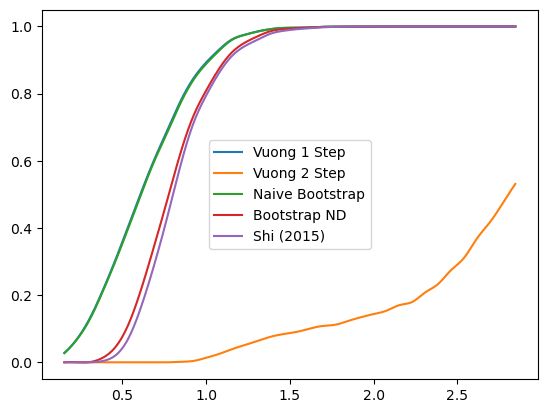

0.06324555320336758 0.13961509012658177


In [12]:
calc_c =lambda nobs: (nobs**(-1/2), 3*(nobs)**(-5/9))

nobs = 250
c1,c2 = calc_c(nobs)

mc_run_power(nobs,c1,c2)
print(c1,c2)

Quantiles: 1th: 0.71, 5th: 1.82, 10th: 3.08, 30th: 9.12, 50th: 16.37, 70th: 25.88, 90th: 40.92, 95th: 48.15, 99th: 65.61
bonus term 1.3859427976729806 // variance stats 33.27032104728414 //part1 47.49670462942421 //part2 34.27032104728414 33.27032104728414
-0.5396396592851619 0.3244194931980511 3.474477170801695
-3.311525254631123 0.3244194931980511 0.7025915754557335
---
Quantiles: 1th: 0.64, 5th: 1.87, 10th: 3.19, 30th: 9.38, 50th: 16.07, 70th: 25.20, 90th: 39.62, 95th: 47.70, 99th: 62.46
bonus term 1.298343206210651 // variance stats 35.58254951558476 //part1 47.49670462942421 //part2 36.58254951558476 35.58254951558476
-0.5606819428386118 0.31064622393505326 3.4202549702791476
-3.157368355259914 0.31064622393505326 0.8235685578578457
---
Quantiles: 1th: 0.70, 5th: 1.84, 10th: 3.35, 30th: 10.30, 50th: 18.06, 70th: 28.49, 90th: 45.39, 95th: 54.36, 99th: 70.18
bonus term 3.774464778395277 // variance stats 11.583692634063352 //part1 47.49670462942421 //part2 12.583692634063352 11.5836

Quantiles: 1th: 0.81, 5th: 1.95, 10th: 3.44, 30th: 9.98, 50th: 17.49, 70th: 27.21, 90th: 42.32, 95th: 50.85, 99th: 66.01
bonus term 1.3724497030613774 // variance stats 33.60724609687216 //part1 47.49670462942421 //part2 34.60724609687216 33.60724609687216
-0.5096529097514028 0.24742687520879167 3.2120163423088943
-3.254552315874158 0.24742687520879167 0.4671169361861395
---
Quantiles: 1th: 0.74, 5th: 1.98, 10th: 3.37, 30th: 9.71, 50th: 16.56, 70th: 24.96, 90th: 39.89, 95th: 47.31, 99th: 63.51
bonus term 1.3833741844858196 // variance stats 33.333953287611806 //part1 47.49670462942421 //part2 34.333953287611806 33.333953287611806
-0.47997677870996397 0.31120758689914174 3.352415067931685
-3.246725147681603 0.31120758689914174 0.5856666989600459
---
Quantiles: 1th: 0.75, 5th: 1.88, 10th: 3.11, 30th: 8.64, 50th: 14.54, 70th: 22.48, 90th: 35.57, 95th: 42.19, 99th: 53.07
bonus term 1.1614068103844042 // variance stats 39.895837879324716 //part1 47.49670462942421 //part2 40.895837879324716 

Quantiles: 1th: 0.81, 5th: 1.95, 10th: 3.54, 30th: 10.33, 50th: 18.28, 70th: 28.07, 90th: 44.65, 95th: 52.30, 99th: 68.57
bonus term 13.873335523646158 // variance stats 2.4235966216249367 //part1 47.49670462942421 //part2 3.4235966216249367 2.4235966216249367
12.4792333365271 -4.198997641739494 15.283913865115789
-15.267437710765217 -4.198997641739494 -12.462757182176528
---
Quantiles: 1th: 0.67, 5th: 1.89, 10th: 3.12, 30th: 9.18, 50th: 15.53, 70th: 24.17, 90th: 38.71, 95th: 46.59, 99th: 59.34
bonus term 4.33285441071113 // variance stats 9.961989517120381 //part1 47.49670462942421 //part2 10.961989517120381 9.961989517120381
2.747077276981585 -0.921713399787744 6.140377921611969
-5.918631544440675 -0.921713399787744 -2.5253308998102915
---
Quantiles: 1th: 0.94, 5th: 2.10, 10th: 3.74, 30th: 10.47, 50th: 17.90, 70th: 27.41, 90th: 43.09, 95th: 51.06, 99th: 65.89
bonus term 1.4340001179695883 // variance stats 32.121827560708404 //part1 47.49670462942421 //part2 33.121827560708404 32.121

Quantiles: 1th: 0.72, 5th: 1.75, 10th: 3.11, 30th: 8.77, 50th: 15.19, 70th: 24.06, 90th: 38.19, 95th: 45.18, 99th: 57.53
bonus term 1.4592512420174042 // variance stats 31.54868199650141 //part1 47.49670462942421 //part2 32.548681996501415 31.54868199650141
-0.3819792828628086 0.16829616049167279 3.224789250205392
-3.300481766897617 0.16829616049167279 0.3062867661705835
---
Quantiles: 1th: 0.80, 5th: 2.20, 10th: 3.76, 30th: 11.17, 50th: 19.89, 70th: 30.60, 90th: 48.53, 95th: 57.27, 99th: 73.37
bonus term 1.3255977798458987 // variance stats 34.830404479815684 //part1 47.49670462942421 //part2 35.830404479815684 34.830404479815684
-0.7126926212821743 0.1501313312183221 3.1223674204232608
-3.3638881809739716 0.1501313312183221 0.4711718607314637
---
Quantiles: 1th: 0.80, 5th: 1.71, 10th: 2.82, 30th: 8.34, 50th: 14.20, 70th: 22.12, 90th: 35.00, 95th: 41.77, 99th: 55.07
bonus term 2.7688261799699463 // variance stats 16.154094024760976 //part1 47.49670462942421 //part2 17.154094024760976 

Quantiles: 1th: 0.66, 5th: 1.65, 10th: 2.84, 30th: 8.32, 50th: 14.98, 70th: 23.05, 90th: 36.60, 95th: 43.52, 99th: 57.63
bonus term 5.601015866619423 // variance stats 7.480016082884543 //part1 47.49670462942421 //part2 8.480016082884543 7.480016082884543
3.815158795586849 -4.014442154672585 7.413188978484552
-7.386872937651996 -4.014442154672585 -3.788842754754294
---
Quantiles: 1th: 0.69, 5th: 1.92, 10th: 3.58, 30th: 10.40, 50th: 18.31, 70th: 28.35, 90th: 45.32, 95th: 53.47, 99th: 70.92
bonus term 1.106200280002381 // variance stats 41.93680402008394 //part1 47.49670462942421 //part2 42.93680402008394 41.93680402008394
-0.9040733484628352 0.1211275803752813 2.9637821440231136
-3.1164739084675968 0.1211275803752813 0.7513815840183518
---
Quantiles: 1th: 0.88, 5th: 1.98, 10th: 3.61, 30th: 10.90, 50th: 18.06, 70th: 27.49, 90th: 43.00, 95th: 51.38, 99th: 67.84
bonus term 3.1687393238533925 // variance stats 13.989148609316697 //part1 47.49670462942421 //part2 14.989148609316697 13.989148

Quantiles: 1th: 0.80, 5th: 1.78, 10th: 3.12, 30th: 8.77, 50th: 15.11, 70th: 23.23, 90th: 36.73, 95th: 43.16, 99th: 58.87
bonus term 2.3481181916967655 // variance stats 19.227561286045308 //part1 47.49670462942421 //part2 20.227561286045308 19.227561286045308
0.5427883894082272 -1.0874137352231448 4.2553656263188016
-4.153447993985304 -1.0874137352231448 -0.4408707570747294
---
Quantiles: 1th: 0.79, 5th: 1.79, 10th: 2.94, 30th: 8.82, 50th: 15.56, 70th: 23.94, 90th: 38.58, 95th: 46.37, 99th: 61.59
bonus term 2.0773856273005187 // variance stats 21.863691750454787 //part1 47.49670462942421 //part2 22.863691750454787 21.863691750454787
0.21837342537418308 -0.7020918032798608 4.026603572998265
-3.936397829226854 -0.7020918032798608 -0.12816768160277178
---
Quantiles: 1th: 0.76, 5th: 1.89, 10th: 3.24, 30th: 10.10, 50th: 17.38, 70th: 26.67, 90th: 42.12, 95th: 50.35, 99th: 67.61
bonus term 2.895152624784814 // variance stats 15.405596106683483 //part1 47.49670462942421 //part2 16.405596106683

Quantiles: 1th: 0.66, 5th: 1.88, 10th: 3.27, 30th: 9.34, 50th: 15.98, 70th: 24.62, 90th: 39.55, 95th: 47.72, 99th: 60.91
bonus term 7.50878951345477 // variance stats 5.325480897329232 //part1 47.49670462942421 //part2 6.325480897329232 5.325480897329232
5.805961683666075 -3.9053613568389896 9.064014183983085
-9.211617343243466 -3.9053613568389896 -5.953564842926456
---
Quantiles: 1th: 0.88, 5th: 1.96, 10th: 3.50, 30th: 10.49, 50th: 18.56, 70th: 27.97, 90th: 44.27, 95th: 52.96, 99th: 70.57
bonus term 1.06787262193321 // variance stats 43.47787465834562 //part1 47.49670462942421 //part2 44.47787465834562 43.47787465834562
-0.9394036550655316 -0.3416125950767215 3.0390748166485797
-3.0751488989319515 -0.3416125950767215 0.9033295727821599
---
Quantiles: 1th: 0.64, 5th: 1.83, 10th: 3.08, 30th: 8.79, 50th: 15.42, 70th: 23.94, 90th: 38.69, 95th: 45.15, 99th: 59.95
bonus term 3.2784308510234923 // variance stats 13.487633501434454 //part1 47.49670462942421 //part2 14.487633501434454 13.48763

Quantiles: 1th: 0.66, 5th: 1.91, 10th: 3.38, 30th: 9.96, 50th: 17.57, 70th: 26.70, 90th: 43.31, 95th: 51.41, 99th: 67.31
bonus term 0.8670824743841211 // variance stats 53.77760885798156 //part1 47.49670462942421 //part2 54.77760885798157 53.77760885798156
-1.0057816233209569 0.35681475181903527 2.756653982030633
-2.739946572089199 0.35681475181903527 1.0224890332623906
---
Quantiles: 1th: 0.72, 5th: 1.89, 10th: 3.52, 30th: 10.19, 50th: 17.83, 70th: 27.24, 90th: 43.39, 95th: 51.56, 99th: 68.67
bonus term 1.5688487867053034 // variance stats 29.274877369903027 //part1 47.49670462942421 //part2 30.274877369903027 29.274877369903027
-0.40406016183796056 -0.9150846231952141 3.344474110694611
-3.5417577352485674 -0.9150846231952141 0.20677653728400422
---
Quantiles: 1th: 0.74, 5th: 1.84, 10th: 3.22, 30th: 9.04, 50th: 15.97, 70th: 24.44, 90th: 39.35, 95th: 47.11, 99th: 59.94
bonus term 0.6436778459308538 // variance stats 72.78955937303841 //part1 47.49670462942421 //part2 73.78955937303841 

Quantiles: 1th: 0.67, 5th: 1.94, 10th: 3.30, 30th: 9.84, 50th: 16.89, 70th: 26.17, 90th: 40.97, 95th: 48.60, 99th: 63.87
bonus term 4.618020717878425 // variance stats 9.285078290260417 //part1 47.49670462942421 //part2 10.285078290260417 9.285078290260417
2.8222687417380636 -4.716518159809412 6.521477167427659
-6.413772694018786 -4.716518159809412 -2.71456426832919
---
Quantiles: 1th: 0.71, 5th: 1.90, 10th: 3.39, 30th: 9.34, 50th: 16.50, 70th: 25.63, 90th: 40.16, 95th: 47.45, 99th: 64.80
bonus term 2.2932693617639557 // variance stats 19.711350101886985 //part1 47.49670462942421 //part2 20.711350101886985 19.711350101886985
0.3730001655840516 -2.5056395935026576 4.2437323526684425
-4.21353855794386 -2.5056395935026576 -0.3428063708594682
---
Quantiles: 1th: 0.79, 5th: 1.89, 10th: 3.50, 30th: 9.99, 50th: 17.67, 70th: 26.71, 90th: 43.15, 95th: 51.50, 99th: 67.70
bonus term 1.6793804678479591 // variance stats 27.28227762484866 //part1 47.49670462942421 //part2 28.28227762484866 27.28227

Quantiles: 1th: 0.75, 5th: 1.93, 10th: 3.23, 30th: 9.66, 50th: 17.07, 70th: 25.82, 90th: 40.78, 95th: 50.14, 99th: 64.73
bonus term 2.8293340727734275 // variance stats 15.787238059472426 //part1 47.49670462942421 //part2 16.787238059472426 15.787238059472426
0.9523566381803734 -4.826794157096449 4.5503505583834025
-4.706311507366482 -4.826794157096449 -1.1083175871634532
---
Quantiles: 1th: 0.71, 5th: 1.97, 10th: 3.46, 30th: 9.90, 50th: 17.35, 70th: 26.81, 90th: 42.53, 95th: 49.87, 99th: 65.50
bonus term 1.4546538101476405 // variance stats 31.651552072450503 //part1 47.49670462942421 //part2 32.6515520724505 31.651552072450503
-0.3844317820708844 -1.9874444037294434 3.3240881271128266
-3.2937394023661652 -1.9874444037294434 0.4147805068175453
---
Quantiles: 1th: 0.76, 5th: 1.95, 10th: 3.46, 30th: 9.61, 50th: 17.01, 70th: 25.83, 90th: 42.07, 95th: 49.40, 99th: 67.57
bonus term 3.0847497733716946 // variance stats 14.397263349989435 //part1 47.49670462942421 //part2 15.397263349989435 

Quantiles: 1th: 0.79, 5th: 2.06, 10th: 3.49, 30th: 9.92, 50th: 17.24, 70th: 26.52, 90th: 41.44, 95th: 49.54, 99th: 66.26
bonus term 3.3492071478415504 // variance stats 13.181477147519589 //part1 47.49670462942421 //part2 14.181477147519589 13.181477147519589
1.5845103227222508 -6.528823717287324 5.198950705599048
-5.11390397296085 -6.528823717287324 -1.4994635900840534
---
Quantiles: 1th: 0.77, 5th: 1.78, 10th: 2.99, 30th: 9.03, 50th: 16.04, 70th: 24.59, 90th: 38.91, 95th: 46.66, 99th: 61.24
bonus term 2.559608064277974 // variance stats 17.55624120438232 //part1 47.49670462942421 //part2 18.55624120438232 17.55624120438232
0.7704559940369473 -4.885376493530583 4.416618354582393
-4.348760134519001 -4.885376493530583 -0.7025977739735544
---
Quantiles: 1th: 0.61, 5th: 1.76, 10th: 3.40, 30th: 10.61, 50th: 18.66, 70th: 29.02, 90th: 47.28, 95th: 55.85, 99th: 70.04
bonus term 3.7725140981365 // variance stats 11.590199372054315 //part1 47.49670462942421 //part2 12.590199372054315 11.5901993

Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.20, 30th: 9.54, 50th: 16.67, 70th: 26.18, 90th: 41.37, 95th: 49.65, 99th: 64.90
bonus term 1.383182568708927 // variance stats 33.33870965693125 //part1 47.49670462942421 //part2 34.33870965693125 33.33870965693125
-0.45972017377504204 -2.8168676432561304 3.2972894197269884
-3.2260853111928958 -2.8168676432561304 0.5309242823091345
---
Quantiles: 1th: 0.79, 5th: 1.80, 10th: 3.17, 30th: 9.06, 50th: 16.24, 70th: 24.83, 90th: 40.36, 95th: 48.42, 99th: 63.70
bonus term 3.0996193580702376 // variance stats 14.323399147627834 //part1 47.49670462942421 //part2 15.323399147627834 14.323399147627834
1.1652334306772083 -6.82125364198547 5.153996494921152
-5.034005285463266 -6.82125364198547 -1.045242221219323
---
Quantiles: 1th: 0.73, 5th: 1.87, 10th: 3.37, 30th: 9.65, 50th: 16.73, 70th: 25.36, 90th: 40.10, 95th: 48.23, 99th: 65.15
bonus term 1.028987470193924 // variance stats 45.158681232992016 //part1 47.49670462942421 //part2 46.15868123299202 45.1586

Quantiles: 1th: 0.79, 5th: 1.74, 10th: 3.16, 30th: 9.00, 50th: 15.94, 70th: 24.83, 90th: 39.63, 95th: 45.92, 99th: 61.05
bonus term 2.8997095391687786 // variance stats 15.379814594478129 //part1 47.49670462942421 //part2 16.37981459447813 15.379814594478129
1.0024395747328485 -8.906815756289717 4.824655174101385
-4.7969795036047085 -8.906815756289717 -0.9747639042361723
---
Quantiles: 1th: 0.76, 5th: 2.08, 10th: 3.48, 30th: 10.09, 50th: 17.51, 70th: 27.28, 90th: 42.59, 95th: 49.88, 99th: 65.76
bonus term 1.069242015154205 // variance stats 43.42091122146401 //part1 47.49670462942421 //part2 44.42091122146401 43.42091122146401
-0.8173101413755133 -2.8153621663335704 2.9206832776742435
-2.9557941716839236 -2.8153621663335704 0.7821992473658337
---
Quantiles: 1th: 0.65, 5th: 1.96, 10th: 3.25, 30th: 9.97, 50th: 17.36, 70th: 26.28, 90th: 42.20, 95th: 50.35, 99th: 65.78
bonus term 2.064409630401485 // variance stats 22.007403148079227 //part1 47.49670462942421 //part2 23.00740314807923 22.0

Quantiles: 1th: 0.73, 5th: 1.89, 10th: 3.46, 30th: 10.25, 50th: 18.14, 70th: 27.85, 90th: 43.80, 95th: 52.14, 99th: 68.32
bonus term 2.1015823428258122 // variance stats 21.60044903382638 //part1 47.49670462942421 //part2 22.60044903382638 21.60044903382638
0.02074872764216507 -8.77227679260684 3.933444817197267
-4.18241595800946 -8.77227679260684 -0.2697198684543576
---
Quantiles: 1th: 0.73, 5th: 1.87, 10th: 3.22, 30th: 9.51, 50th: 16.69, 70th: 25.21, 90th: 40.13, 95th: 47.87, 99th: 62.55
bonus term 1.881017563971621 // variance stats 24.2505375490161 //part1 47.49670462942421 //part2 25.2505375490161 24.2505375490161
0.0351349816637973 -5.845753644898226 3.7515025651914296
-3.7269001462794447 -5.845753644898226 -0.010532562751812162
---
Quantiles: 1th: 0.79, 5th: 1.98, 10th: 3.65, 30th: 10.37, 50th: 17.66, 70th: 27.39, 90th: 43.65, 95th: 52.08, 99th: 67.99
bonus term 1.8661612622601886 // variance stats 24.45155426273231 //part1 47.49670462942421 //part2 25.45155426273231 24.45155426

Quantiles: 1th: 0.79, 5th: 2.05, 10th: 3.64, 30th: 10.79, 50th: 18.37, 70th: 28.02, 90th: 43.89, 95th: 51.70, 99th: 67.64
bonus term 2.368828724180134 // variance stats 19.05071288801731 //part1 47.49670462942421 //part2 20.05071288801731 19.05071288801731
0.4034062719657239 -9.1570824745575 4.343570001256488
-4.3342511763945435 -9.1570824745575 -0.39408744710377885
---
Quantiles: 1th: 0.76, 5th: 2.04, 10th: 3.54, 30th: 10.12, 50th: 17.57, 70th: 27.16, 90th: 43.09, 95th: 51.21, 99th: 68.44
bonus term 1.8518333047185556 // variance stats 24.648477380982644 //part1 47.49670462942421 //part2 25.648477380982644 24.648477380982644
0.007186964701703204 -7.683964157402912 3.9376009633241815
-3.696479644735408 -7.683964157402912 0.2339343538870707
---
Quantiles: 1th: 0.69, 5th: 1.80, 10th: 3.07, 30th: 8.83, 50th: 15.35, 70th: 23.49, 90th: 37.67, 95th: 44.91, 99th: 58.77
bonus term 2.322276241785642 // variance stats 19.452650625621995 //part1 47.49670462942421 //part2 20.452650625621995 19.452

Quantiles: 1th: 0.68, 5th: 1.81, 10th: 3.31, 30th: 9.72, 50th: 17.06, 70th: 25.42, 90th: 40.32, 95th: 48.63, 99th: 63.19
bonus term 2.4565549577079295 // variance stats 18.334680252275188 //part1 47.49670462942421 //part2 19.334680252275188 18.334680252275188
0.6982764438348987 -8.591695801722006 4.240734498895225
-4.2148334715809606 -8.591695801722006 -0.672375416520634
---
Quantiles: 1th: 0.74, 5th: 1.90, 10th: 3.33, 30th: 9.77, 50th: 17.02, 70th: 25.81, 90th: 41.28, 95th: 48.90, 99th: 64.29
bonus term 2.0056348551070644 // variance stats 22.681631034921732 //part1 47.49670462942421 //part2 23.681631034921732 22.681631034921732
-0.017749921285960653 -7.494418267270428 3.916102041003074
-4.02901963150009 -7.494418267270428 -0.0951676692110549
---
Quantiles: 1th: 0.76, 5th: 1.81, 10th: 3.06, 30th: 9.16, 50th: 15.71, 70th: 24.06, 90th: 37.90, 95th: 44.51, 99th: 58.29
bonus term 1.8100339439454571 // variance stats 25.240781167833976 //part1 47.49670462942421 //part2 26.240781167833976 2

Quantiles: 1th: 0.65, 5th: 1.99, 10th: 3.27, 30th: 9.34, 50th: 16.16, 70th: 25.03, 90th: 40.39, 95th: 47.47, 99th: 62.96
bonus term 2.2176962716369117 // variance stats 20.41713688969962 //part1 47.49670462942421 //part2 21.41713688969962 20.41713688969962
0.3015623960270204 -9.909243628438613 4.020601497168287
-4.133830147246804 -9.909243628438613 -0.41479104610553724
---
Quantiles: 1th: 0.81, 5th: 1.81, 10th: 2.91, 30th: 8.52, 50th: 14.96, 70th: 22.72, 90th: 36.67, 95th: 44.30, 99th: 57.46
bonus term 2.0254275260474754 // variance stats 22.45021187803829 //part1 47.49670462942421 //part2 23.45021187803829 22.45021187803829
0.11318832392243672 -9.31202938431325 3.932080385461194
-3.937666728172514 -9.31202938431325 -0.11877466663375658
---
Quantiles: 1th: 0.74, 5th: 1.95, 10th: 3.48, 30th: 10.17, 50th: 17.68, 70th: 27.22, 90th: 43.55, 95th: 52.02, 99th: 66.85
bonus term 1.4636477534048176 // variance stats 31.45091212618253 //part1 47.49670462942421 //part2 32.45091212618253 31.450912

Quantiles: 1th: 0.85, 5th: 2.23, 10th: 4.01, 30th: 11.28, 50th: 19.41, 70th: 29.87, 90th: 47.24, 95th: 55.62, 99th: 75.22
bonus term 1.819450548096657 // variance stats 25.10497145916438 //part1 47.49670462942421 //part2 26.10497145916438 25.10497145916438
-0.20406922903495933 -10.428356175637544 3.6927863300513804
-3.842970325228273 -10.428356175637544 0.05388523385806657
---
Quantiles: 1th: 0.70, 5th: 1.75, 10th: 3.05, 30th: 8.87, 50th: 15.69, 70th: 24.06, 90th: 38.05, 95th: 45.30, 99th: 59.70
bonus term 1.5105955234776283 // variance stats 30.442370834039895 //part1 47.49670462942421 //part2 31.442370834039895 30.442370834039895
-0.6039980388240676 -6.9991988993910015 3.3979697556147572
-3.625189085779324 -6.9991988993910015 0.37677870865950075
---
Quantiles: 1th: 0.75, 5th: 1.99, 10th: 3.40, 30th: 10.14, 50th: 17.27, 70th: 26.41, 90th: 42.00, 95th: 50.31, 99th: 67.04
bonus term 1.1922370177776895 // variance stats 38.83830725031277 //part1 47.49670462942421 //part2 39.8383072503127

Quantiles: 1th: 0.67, 5th: 1.73, 10th: 3.02, 30th: 8.40, 50th: 14.56, 70th: 22.35, 90th: 35.05, 95th: 42.04, 99th: 55.00
bonus term 1.499251968598108 // variance stats 30.68026830996028 //part1 47.49670462942421 //part2 31.68026830996028 30.68026830996028
-0.4749980213835379 -11.729614004494605 3.389814023747042
-3.473501958579754 -11.729614004494605 0.3913100865508259
---
Quantiles: 1th: 0.76, 5th: 1.96, 10th: 3.59, 30th: 10.32, 50th: 17.98, 70th: 27.48, 90th: 44.34, 95th: 53.13, 99th: 70.65
bonus term 1.6544600385093409 // variance stats 27.708281568540315 //part1 47.49670462942421 //part2 28.708281568540315 27.708281568540315
-0.3895980352789118 -9.931088228594518 3.7126433813400084
-3.6985181122975934 -9.931088228594518 0.4037233043213265
---
Quantiles: 1th: 0.86, 5th: 2.23, 10th: 3.53, 30th: 9.53, 50th: 16.60, 70th: 25.20, 90th: 41.02, 95th: 48.16, 99th: 65.75
bonus term 0.9868063464420335 // variance stats 47.131738107152756 //part1 47.49670462942421 //part2 48.13173810715276 47.

Quantiles: 1th: 0.74, 5th: 1.83, 10th: 3.16, 30th: 9.63, 50th: 17.24, 70th: 26.56, 90th: 42.42, 95th: 50.19, 99th: 66.10
bonus term 2.0044299339590075 // variance stats 22.695866752305033 //part1 47.49670462942421 //part2 23.695866752305033 22.695866752305033
-0.06750466434715507 -11.497719585721134 3.8977485211172795
-4.0763645322651705 -11.497719585721134 -0.11111134680073544
---
Quantiles: 1th: 0.74, 5th: 2.04, 10th: 3.47, 30th: 10.53, 50th: 18.42, 70th: 27.75, 90th: 43.50, 95th: 52.07, 99th: 68.99
bonus term 1.578113588138821 // variance stats 29.097139386170785 //part1 47.49670462942421 //part2 30.097139386170785 29.097139386170785
-0.5181249928453717 -11.912059851551147 3.601422052222337
-3.674352169123014 -11.912059851551147 0.4451948759446948
---
Quantiles: 1th: 0.80, 5th: 2.12, 10th: 3.70, 30th: 10.41, 50th: 18.43, 70th: 28.46, 90th: 45.57, 95th: 54.97, 99th: 72.49
bonus term 1.6432309363264452 // variance stats 27.904461070825704 //part1 47.49670462942421 //part2 28.904461070

Quantiles: 1th: 0.77, 5th: 2.13, 10th: 3.57, 30th: 10.25, 50th: 17.67, 70th: 26.81, 90th: 42.97, 95th: 51.19, 99th: 64.51
bonus term 1.6446996921029946 // variance stats 27.878648702543725 //part1 47.49670462942421 //part2 28.878648702543725 27.878648702543725
-0.42127278747165625 -12.786334870764854 3.5629492100495135
-3.7106721716776456 -12.786334870764854 0.27354982584352416
---
Quantiles: 1th: 0.67, 5th: 1.93, 10th: 3.30, 30th: 9.52, 50th: 16.74, 70th: 25.03, 90th: 40.26, 95th: 47.55, 99th: 63.56
bonus term 1.2702700481397242 // variance stats 36.39102933189824 //part1 47.49670462942421 //part2 37.39102933189824 36.39102933189824
-0.669082681207972 -8.158958423662758 3.2447567078044313
-3.2096227774874206 -8.158958423662758 0.7042166115249828
---
Quantiles: 1th: 0.71, 5th: 1.81, 10th: 3.23, 30th: 9.56, 50th: 16.44, 70th: 25.52, 90th: 40.86, 95th: 48.67, 99th: 61.82
bonus term 1.6442415858259427 // variance stats 27.886694655375386 //part1 47.49670462942421 //part2 28.88669465537538

Quantiles: 1th: 0.71, 5th: 1.84, 10th: 3.44, 30th: 9.86, 50th: 17.34, 70th: 26.89, 90th: 42.86, 95th: 51.28, 99th: 68.34
bonus term 1.7620116758253515 // variance stats 25.955953403189607 //part1 47.49670462942421 //part2 26.955953403189607 25.955953403189607
-0.19728337287370395 -13.370205534302453 3.766250693066276
-3.721306724524407 -13.370205534302453 0.24222734141557267
---
Quantiles: 1th: 0.73, 5th: 1.84, 10th: 3.12, 30th: 9.41, 50th: 16.69, 70th: 25.46, 90th: 40.52, 95th: 47.10, 99th: 61.77
bonus term 1.432480205156447 // variance stats 32.15697100626735 //part1 47.49670462942421 //part2 33.15697100626735 32.15697100626735
-0.5485036506060034 -11.148548344099721 3.332080383207293
-3.4134640609188973 -11.148548344099721 0.4671199728943991
---
Quantiles: 1th: 0.72, 5th: 1.80, 10th: 3.37, 30th: 9.58, 50th: 16.55, 70th: 25.33, 90th: 40.48, 95th: 49.21, 99th: 66.12
bonus term 1.5778872696566675 // variance stats 29.10145625914012 //part1 47.49670462942421 //part2 30.10145625914012 29

Quantiles: 1th: 0.71, 5th: 1.81, 10th: 3.22, 30th: 8.78, 50th: 15.70, 70th: 24.23, 90th: 38.70, 95th: 45.52, 99th: 60.01
bonus term 0.96263243765503 // variance stats 48.34043646516426 //part1 47.49670462942421 //part2 49.34043646516427 48.34043646516426
-1.0052938306335433 -8.527244288958759 2.7965165870852835
-2.9305587059436036 -8.527244288958759 0.8712517117752233
---
Quantiles: 1th: 0.65, 5th: 1.71, 10th: 3.00, 30th: 8.74, 50th: 14.93, 70th: 23.25, 90th: 37.46, 95th: 44.28, 99th: 57.92
bonus term 1.211233941971785 // variance stats 38.21348550727009 //part1 47.49670462942421 //part2 39.21348550727009 38.21348550727009
-1.024366035021043 -10.211959614229285 3.1495858430256
-3.446833918964613 -10.211959614229285 0.7271179590820301
---
Quantiles: 1th: 0.76, 5th: 1.92, 10th: 3.32, 30th: 10.05, 50th: 17.89, 70th: 27.68, 90th: 43.52, 95th: 52.45, 99th: 69.66
bonus term 0.8855267040834232 // variance stats 52.63667115898705 //part1 47.49670462942421 //part2 53.636671158987056 52.63667115

Quantiles: 1th: 0.76, 5th: 2.05, 10th: 3.88, 30th: 11.24, 50th: 19.09, 70th: 29.89, 90th: 47.36, 95th: 56.12, 99th: 72.06
bonus term 1.1237274221717222 // variance stats 41.267104719783205 //part1 47.49670462942421 //part2 42.267104719783205 41.267104719783205
-1.019617183926035 -12.04055332406869 3.1084340282023692
-3.2670720282694794 -12.04055332406869 0.8609791838589248
---
Quantiles: 1th: 0.69, 5th: 1.79, 10th: 3.16, 30th: 9.60, 50th: 16.75, 70th: 25.76, 90th: 40.24, 95th: 47.92, 99th: 62.40
bonus term 1.518974960919555 // variance stats 30.26891874548789 //part1 47.49670462942421 //part2 31.26891874548789 30.26891874548789
-0.8950902617124236 -16.83803019501769 3.882732652019139
-3.9330401835515336 -16.83803019501769 0.8447827301800287
---
Quantiles: 1th: 0.66, 5th: 1.81, 10th: 3.31, 30th: 10.11, 50th: 17.46, 70th: 26.47, 90th: 41.60, 95th: 50.05, 99th: 64.92
bonus term 1.1512489803252455 // variance stats 40.25667465608149 //part1 47.49670462942421 //part2 41.25667465608149 40.25

Quantiles: 1th: 0.71, 5th: 1.91, 10th: 3.44, 30th: 10.16, 50th: 17.50, 70th: 26.74, 90th: 41.81, 95th: 49.56, 99th: 64.58
bonus term 1.4737954589165478 // variance stats 31.22747386149577 //part1 47.49670462942421 //part2 32.227473861495774 31.22747386149577
-0.7029421759881922 -14.449954273510514 3.464219932299441
-3.650533093821288 -14.449954273510514 0.5166290144663456
---
Quantiles: 1th: 0.66, 5th: 1.80, 10th: 3.40, 30th: 10.02, 50th: 16.99, 70th: 26.28, 90th: 41.83, 95th: 49.56, 99th: 64.79
bonus term 0.8364365612798812 // variance stats 55.784586934778034 //part1 47.49670462942421 //part2 56.78458693477804 55.784586934778034
-1.2159205682738028 -7.8836092401688 2.792088877140315
-2.888793690833565 -7.8836092401688 1.1192157545805528
---
Quantiles: 1th: 0.85, 5th: 2.00, 10th: 3.35, 30th: 9.71, 50th: 17.24, 70th: 26.35, 90th: 42.14, 95th: 50.28, 99th: 64.06
bonus term 1.0168023523886112 // variance stats 45.711835901881805 //part1 47.49670462942421 //part2 46.71183590188181 45.7118

Quantiles: 1th: 0.83, 5th: 1.88, 10th: 3.47, 30th: 10.17, 50th: 17.94, 70th: 27.02, 90th: 42.89, 95th: 50.98, 99th: 65.93
bonus term 0.7755652218484966 // variance stats 60.24140599835005 //part1 47.49670462942421 //part2 61.241405998350054 60.24140599835005
-1.3381570341036821 -8.05238749117986 2.6418732241674086
-2.8892874778006754 -8.05238749117986 1.090742780470415
---
Quantiles: 1th: 0.75, 5th: 1.87, 10th: 3.32, 30th: 9.39, 50th: 16.03, 70th: 24.74, 90th: 39.70, 95th: 48.10, 99th: 61.91
bonus term 1.269487477392762 // variance stats 36.41407889030274 //part1 47.49670462942421 //part2 37.41407889030274 36.41407889030274
-0.992356992429698 -15.356261378095118 3.170776678918096
-3.531331947215222 -15.356261378095118 0.6318017241325719
---
Quantiles: 1th: 0.71, 5th: 2.08, 10th: 3.74, 30th: 10.68, 50th: 18.16, 70th: 28.25, 90th: 43.75, 95th: 52.24, 99th: 67.57
bonus term 1.377798788702237 // variance stats 33.472888943502305 //part1 47.49670462942421 //part2 34.472888943502305 33.47288

Quantiles: 1th: 0.72, 5th: 1.85, 10th: 3.29, 30th: 9.26, 50th: 16.41, 70th: 24.83, 90th: 39.66, 95th: 47.72, 99th: 62.51
bonus term 0.7148816177800791 // variance stats 65.43995795683719 //part1 47.49670462942421 //part2 66.43995795683719 65.43995795683719
-1.3713287165340025 -8.164064044894657 2.560652347422082
-2.801091952094161 -8.164064044894657 1.1308891118619235
---
Quantiles: 1th: 0.63, 5th: 1.83, 10th: 3.23, 30th: 9.51, 50th: 16.41, 70th: 25.26, 90th: 40.72, 95th: 49.04, 99th: 66.33
bonus term 1.2839691635421924 // variance stats 35.992091382001036 //part1 47.49670462942421 //part2 36.992091382001036 35.992091382001036
-0.9095160040670638 -16.410824972218926 3.4820882706936302
-3.4774543311514483 -16.410824972218926 0.9141499436092457
---
Quantiles: 1th: 0.77, 5th: 1.86, 10th: 3.33, 30th: 9.71, 50th: 16.72, 70th: 25.09, 90th: 39.94, 95th: 47.66, 99th: 62.87
bonus term 0.9224681358230399 // variance stats 50.488721165470864 //part1 47.49670462942421 //part2 51.488721165470864 50

Quantiles: 1th: 0.78, 5th: 2.04, 10th: 3.49, 30th: 10.54, 50th: 17.83, 70th: 26.55, 90th: 42.61, 95th: 51.47, 99th: 66.72
bonus term 0.7315234967134978 // variance stats 63.92847440008664 //part1 47.49670462942421 //part2 64.92847440008664 63.92847440008664
-1.2771304351474109 -10.494824922546417 2.6448426223898776
-2.7401774285744067 -10.494824922546417 1.1817956289628815
---
Quantiles: 1th: 0.75, 5th: 1.92, 10th: 3.36, 30th: 9.51, 50th: 16.39, 70th: 24.88, 90th: 39.49, 95th: 47.28, 99th: 61.32
bonus term 1.1408908992407847 // variance stats 40.63124156834917 //part1 47.49670462942421 //part2 41.63124156834917 40.63124156834917
-1.191642494389228 -16.575737845463333 3.109987424487887
-3.4734242928707975 -16.575737845463333 0.8282056260063178
---
Quantiles: 1th: 0.84, 5th: 2.09, 10th: 3.48, 30th: 9.71, 50th: 17.24, 70th: 26.23, 90th: 41.47, 95th: 50.81, 99th: 66.86
bonus term 0.8679937647762177 // variance stats 53.7200988726798 //part1 47.49670462942421 //part2 54.720098872679806 53.7

Quantiles: 1th: 0.77, 5th: 1.93, 10th: 3.10, 30th: 8.01, 50th: 14.11, 70th: 21.45, 90th: 34.22, 95th: 41.60, 99th: 53.19
bonus term 1.1503154404332556 // variance stats 40.29015656047789 //part1 47.49670462942421 //part2 41.29015656047789 40.29015656047789
-1.2175828879204127 -18.91373695208756 3.3691803112358945
-3.518213768786924 -18.91373695208756 1.0685494303693832
---
Quantiles: 1th: 0.75, 5th: 2.03, 10th: 3.71, 30th: 10.42, 50th: 18.16, 70th: 27.33, 90th: 44.01, 95th: 52.58, 99th: 68.75
bonus term 1.1804344592459555 // variance stats 39.23663004531774 //part1 47.49670462942421 //part2 40.23663004531774 39.23663004531774
-1.2570715296627888 -19.067655608893812 3.3784727997744426
-3.6179404481547 -19.067655608893812 1.0176038812825317
---
Quantiles: 1th: 0.64, 5th: 1.78, 10th: 3.02, 30th: 8.84, 50th: 15.73, 70th: 24.13, 90th: 37.09, 95th: 44.77, 99th: 57.09
bonus term 1.1348461107811478 // variance stats 40.85299150096292 //part1 47.49670462942421 //part2 41.85299150096292 40.85299

Quantiles: 1th: 0.71, 5th: 1.82, 10th: 3.09, 30th: 8.97, 50th: 15.71, 70th: 24.15, 90th: 38.80, 95th: 45.82, 99th: 59.85
bonus term 0.9725556286526603 // variance stats 47.837005545095906 //part1 47.49670462942421 //part2 48.83700554509591 47.837005545095906
-1.3153265099816702 -14.27602841589284 2.9834253016059162
-3.2604377672869913 -14.27602841589284 1.0383140443005954
---
Quantiles: 1th: 0.69, 5th: 2.02, 10th: 3.50, 30th: 10.42, 50th: 17.63, 70th: 27.19, 90th: 42.95, 95th: 51.78, 99th: 67.13
bonus term 0.7016587101712348 // variance stats 66.69203309374292 //part1 47.49670462942421 //part2 67.69203309374294 66.69203309374292
-1.3326216277390368 -10.4925227775253 2.7664287655580115
-2.7359390480815065 -10.4925227775253 1.363111345215542
---
Quantiles: 1th: 0.76, 5th: 1.95, 10th: 3.50, 30th: 10.62, 50th: 18.34, 70th: 27.75, 90th: 43.53, 95th: 51.95, 99th: 66.96
bonus term 1.0968746684031634 // variance stats 42.30185206899726 //part1 47.49670462942421 //part2 43.30185206899726 42.301

Quantiles: 1th: 0.72, 5th: 1.90, 10th: 3.15, 30th: 9.38, 50th: 16.77, 70th: 25.71, 90th: 41.23, 95th: 49.07, 99th: 64.19
bonus term 0.7856215065881044 // variance stats 59.45749031960549 //part1 47.49670462942421 //part2 60.4574903196055 59.45749031960549
-1.485566283391995 -11.746494021174819 2.733282498839174
-3.056809296568203 -11.746494021174819 1.1620394856629654
---
Quantiles: 1th: 0.73, 5th: 2.09, 10th: 3.68, 30th: 10.56, 50th: 17.95, 70th: 27.57, 90th: 43.36, 95th: 52.12, 99th: 67.74
bonus term 1.1848948019091434 // variance stats 39.0851658331996 //part1 47.49670462942421 //part2 40.0851658331996 39.0851658331996
-1.040365361225379 -17.511406443848482 3.1638855303600413
-3.4101549650436658 -17.511406443848482 0.7940959265417545
---
Quantiles: 1th: 0.66, 5th: 1.90, 10th: 3.20, 30th: 8.58, 50th: 14.32, 70th: 22.53, 90th: 35.33, 95th: 41.70, 99th: 54.37
bonus term 1.1342119896821912 // variance stats 40.87639088767956 //part1 47.49670462942421 //part2 41.87639088767956 40.8763908

Quantiles: 1th: 0.73, 5th: 2.07, 10th: 3.37, 30th: 9.75, 50th: 16.97, 70th: 25.70, 90th: 40.32, 95th: 47.67, 99th: 61.75
bonus term 1.062488279934892 // variance stats 43.703273933840244 //part1 47.49670462942421 //part2 44.703273933840244 43.703273933840244
-1.0774947862788005 -19.54638612364889 3.078047875773109
-3.2024713461485845 -19.54638612364889 0.9530713159033245
---
Quantiles: 1th: 0.69, 5th: 1.93, 10th: 3.39, 30th: 10.36, 50th: 18.14, 70th: 27.81, 90th: 43.65, 95th: 51.99, 99th: 68.69
bonus term 0.7793972440665684 // variance stats 59.94030353713634 //part1 47.49670462942421 //part2 60.94030353713634 59.94030353713634
-1.39139061035676 -13.110825830478907 2.795993207600473
-2.9501850984898965 -13.110825830478907 1.2371987194673362
---
Quantiles: 1th: 0.71, 5th: 1.96, 10th: 3.23, 30th: 9.67, 50th: 17.14, 70th: 26.53, 90th: 41.86, 95th: 49.86, 99th: 65.28
bonus term 1.081093819684937 // variance stats 42.93393409950875 //part1 47.49670462942421 //part2 43.93393409950875 42.9339

Quantiles: 1th: 0.69, 5th: 1.83, 10th: 3.15, 30th: 9.30, 50th: 16.35, 70th: 25.15, 90th: 39.59, 95th: 47.05, 99th: 59.12
bonus term 0.9901837273812666 // variance stats 46.96756734736338 //part1 47.49670462942421 //part2 47.967567347363385 46.96756734736338
-1.2711634352617212 -20.20825428414194 3.2306106367872998
-3.251530890024254 -20.20825428414194 1.250243182024767
---
Quantiles: 1th: 0.71, 5th: 1.95, 10th: 3.50, 30th: 10.52, 50th: 18.35, 70th: 28.18, 90th: 44.66, 95th: 52.94, 99th: 68.61
bonus term 1.025247949828622 // variance stats 45.327041802291475 //part1 47.49670462942421 //part2 46.327041802291475 45.327041802291475
-1.2562987579875595 -20.89694897523058 3.2356254805201448
-3.3067946576448035 -20.89694897523058 1.1851295808629008
---
Quantiles: 1th: 0.80, 5th: 1.92, 10th: 3.27, 30th: 9.42, 50th: 17.42, 70th: 26.04, 90th: 41.58, 95th: 49.17, 99th: 63.81
bonus term 0.7718012116433198 // variance stats 60.54007523296599 //part1 47.49670462942421 //part2 61.54007523296599 60.54

Quantiles: 1th: 0.83, 5th: 2.24, 10th: 3.80, 30th: 10.80, 50th: 18.43, 70th: 28.52, 90th: 43.59, 95th: 51.76, 99th: 68.97
bonus term 0.8297610845200416 // variance stats 56.24142227867641 //part1 47.49670462942421 //part2 57.24142227867641 56.24142227867641
-1.3165980792021803 -15.981784528104257 2.740716094182064
-2.9761202482422635 -15.981784528104257 1.0811939251419806
---
Quantiles: 1th: 0.78, 5th: 2.12, 10th: 3.83, 30th: 11.09, 50th: 19.65, 70th: 29.96, 90th: 47.48, 95th: 56.37, 99th: 72.89
bonus term 1.0116845428515324 // variance stats 45.948137109567845 //part1 47.49670462942421 //part2 46.94813710956785 45.948137109567845
-1.4713556639921594 -20.007530814213904 3.0958862778836895
-3.4947247496952243 -20.007530814213904 1.0725171921806245
---
Quantiles: 1th: 0.80, 5th: 2.03, 10th: 3.71, 30th: 10.65, 50th: 18.69, 70th: 29.19, 90th: 46.22, 95th: 54.17, 99th: 71.79
bonus term 0.9917860345866354 // variance stats 46.89007202467845 //part1 47.49670462942421 //part2 47.89007202467846

Quantiles: 1th: 0.72, 5th: 1.85, 10th: 3.32, 30th: 9.79, 50th: 17.43, 70th: 26.95, 90th: 43.01, 95th: 50.18, 99th: 66.87
bonus term 1.0191895998903227 // variance stats 45.60242278231198 //part1 47.49670462942421 //part2 46.60242278231198 45.60242278231198
-1.4458916753504913 -21.850574997508648 3.2764406894241005
-3.484270875131137 -21.850574997508648 1.238061489643455
---
Quantiles: 1th: 0.67, 5th: 1.79, 10th: 3.15, 30th: 9.25, 50th: 16.30, 70th: 25.23, 90th: 39.70, 95th: 47.68, 99th: 63.20
bonus term 1.0215171590455971 // variance stats 45.49623768806815 //part1 47.49670462942421 //part2 46.496237688068156 45.49623768806815
-1.3500580806440674 -20.73738805204899 3.128710288033009
-3.393092398735262 -20.73738805204899 1.0856759699418144
---
Quantiles: 1th: 0.74, 5th: 1.86, 10th: 3.32, 30th: 9.89, 50th: 17.62, 70th: 26.54, 90th: 41.51, 95th: 49.51, 99th: 66.01
bonus term 1.0150301222062703 // variance stats 45.79339419620901 //part1 47.49670462942421 //part2 46.793394196209015 45.7933

Quantiles: 1th: 0.78, 5th: 2.03, 10th: 3.51, 30th: 10.75, 50th: 18.49, 70th: 28.10, 90th: 43.85, 95th: 52.14, 99th: 67.29
bonus term 0.9422218625693233 // variance stats 49.40925764544088 //part1 47.49670462942421 //part2 50.40925764544088 49.40925764544088
-1.3759741047335896 -21.00363304482556 3.1386838639946646
-3.2604178298722366 -21.00363304482556 1.254240138856018
---
Quantiles: 1th: 0.77, 5th: 1.89, 10th: 3.54, 30th: 10.23, 50th: 17.25, 70th: 26.04, 90th: 41.85, 95th: 49.12, 99th: 65.51
bonus term 1.0428001435514547 // variance stats 44.547274732495836 //part1 47.49670462942421 //part2 45.54727473249584 44.547274732495836
-1.6757198703157767 -23.354695508659812 3.4538459311664793
-3.7613201574186865 -23.354695508659812 1.3682456440635695
---
Quantiles: 1th: 0.75, 5th: 1.98, 10th: 3.37, 30th: 9.45, 50th: 16.52, 70th: 25.63, 90th: 40.60, 95th: 48.12, 99th: 63.03
bonus term 0.9662037999062946 // variance stats 48.15806027054601 //part1 47.49670462942421 //part2 49.15806027054601 48

Quantiles: 1th: 0.80, 5th: 2.01, 10th: 3.42, 30th: 10.16, 50th: 17.71, 70th: 26.97, 90th: 42.33, 95th: 50.72, 99th: 66.45
bonus term 0.9159823144076468 // variance stats 50.85329878354658 //part1 47.49670462942421 //part2 51.85329878354658 50.85329878354658
-1.583120834781955 -23.44576134170028 3.3266628934138205
-3.415085463597248 -23.44576134170028 1.494698264598527
---
Quantiles: 1th: 0.71, 5th: 1.89, 10th: 3.31, 30th: 9.14, 50th: 15.73, 70th: 24.23, 90th: 38.98, 95th: 46.21, 99th: 60.05
bonus term 0.9463058918675915 // variance stats 49.19170337794961 //part1 47.49670462942421 //part2 50.19170337794961 49.19170337794961
-1.6188896727908841 -22.170803805158844 3.118052593565284
-3.511501456526067 -22.170803805158844 1.225440809830101
---
Quantiles: 1th: 0.80, 5th: 1.89, 10th: 3.37, 30th: 10.33, 50th: 17.73, 70th: 27.39, 90th: 43.06, 95th: 51.73, 99th: 67.63
bonus term 0.9749362172407714 // variance stats 47.717755879300114 //part1 47.49670462942421 //part2 48.71775587930012 47.71775

Quantiles: 1th: 0.69, 5th: 1.88, 10th: 3.10, 30th: 9.18, 50th: 15.86, 70th: 23.89, 90th: 37.45, 95th: 44.69, 99th: 60.12
bonus term 0.8474204064626533 // variance stats 55.04857313701878 //part1 47.49670462942421 //part2 56.048573137018785 55.04857313701878
-1.5282028935791692 -21.611854774391706 2.92893929332787
-3.223043706504476 -21.611854774391706 1.2340984804025634
---
Quantiles: 1th: 0.77, 5th: 1.92, 10th: 3.43, 30th: 10.21, 50th: 18.29, 70th: 27.80, 90th: 44.00, 95th: 53.47, 99th: 68.64
bonus term 0.9155050350885722 // variance stats 50.88033141164434 //part1 47.49670462942421 //part2 51.88033141164434 50.88033141164434
-1.5559573949938 -24.53881262861732 2.9958231374573634
-3.386967465170944 -24.53881262861732 1.164813067280219
---
Quantiles: 1th: 0.63, 5th: 1.72, 10th: 2.97, 30th: 8.76, 50th: 15.22, 70th: 23.31, 90th: 36.85, 95th: 43.47, 99th: 58.08
bonus term 0.9481489108863137 // variance stats 49.094140365594136 //part1 47.49670462942421 //part2 50.09414036559414 49.0941403

Quantiles: 1th: 0.78, 5th: 1.85, 10th: 3.26, 30th: 9.41, 50th: 15.82, 70th: 24.07, 90th: 37.94, 95th: 46.24, 99th: 58.64
bonus term 0.923859130613774 // variance stats 50.411197936496386 //part1 47.49670462942421 //part2 51.41119793649639 50.411197936496386
-1.732199362797335 -23.088514301671264 3.1899534793849376
-3.5799176240248833 -23.088514301671264 1.342235218157389
---
Quantiles: 1th: 0.78, 5th: 1.99, 10th: 3.43, 30th: 10.62, 50th: 18.40, 70th: 28.42, 90th: 45.50, 95th: 54.42, 99th: 71.13
bonus term 0.6265485518164302 // variance stats 74.80690194195847 //part1 47.49670462942421 //part2 75.80690194195847 74.80690194195847
-1.6973030821756872 -16.794764303117468 2.6025536445233524
-2.950400185808548 -16.794764303117468 1.3494565408904917
---
Quantiles: 1th: 0.80, 5th: 1.99, 10th: 3.63, 30th: 9.79, 50th: 16.85, 70th: 25.26, 90th: 40.11, 95th: 48.15, 99th: 62.96
bonus term 0.8563274786492641 // variance stats 54.46558508707856 //part1 47.49670462942421 //part2 55.465585087078566 54.

Quantiles: 1th: 0.69, 5th: 1.83, 10th: 3.11, 30th: 9.15, 50th: 16.29, 70th: 24.83, 90th: 39.43, 95th: 46.79, 99th: 60.95
bonus term 0.77625327369214 // variance stats 60.187123119639516 //part1 47.49670462942421 //part2 61.18712311963952 60.187123119639516
-1.4434312932736189 -22.16538881813664 2.892313868868098
-2.995937840657899 -22.16538881813664 1.3398073214838175
---
Quantiles: 1th: 0.68, 5th: 1.88, 10th: 3.34, 30th: 9.37, 50th: 16.50, 70th: 25.17, 90th: 39.53, 95th: 46.86, 99th: 60.62
bonus term 0.8549780880820976 // variance stats 54.5531250350166 //part1 47.49670462942421 //part2 55.553125035016606 54.5531250350166
-1.6999001268516565 -24.646716277028222 3.1268652974366153
-3.409856303015852 -24.646716277028222 1.4169091212724199
---
Quantiles: 1th: 0.76, 5th: 1.94, 10th: 3.27, 30th: 9.46, 50th: 16.50, 70th: 24.97, 90th: 40.01, 95th: 46.70, 99th: 62.55
bonus term 0.892295091233143 // variance stats 52.22981723880631 //part1 47.49670462942421 //part2 53.22981723880631 52.2298172

Quantiles: 1th: 0.70, 5th: 1.96, 10th: 3.58, 30th: 9.86, 50th: 17.13, 70th: 26.23, 90th: 42.17, 95th: 50.24, 99th: 65.84
bonus term 0.9045981232653026 // variance stats 51.50586244638301 //part1 47.49670462942421 //part2 52.50586244638302 51.50586244638301
-1.8774219659073759 -27.136976830445896 3.5102313261044324
-3.686618212437981 -27.136976830445896 1.701035079573827
---
Quantiles: 1th: 0.69, 5th: 1.96, 10th: 3.41, 30th: 10.15, 50th: 17.56, 70th: 26.95, 90th: 43.49, 95th: 51.82, 99th: 67.70
bonus term 0.7307756262404859 // variance stats 63.9949217296334 //part1 47.49670462942421 //part2 64.9949217296334 63.9949217296334
-1.5294671870914776 -22.065686448920598 3.09293285251649
-2.991018439572449 -22.065686448920598 1.6313816000355184
---
Quantiles: 1th: 0.77, 5th: 1.94, 10th: 3.21, 30th: 9.40, 50th: 16.30, 70th: 25.41, 90th: 39.83, 95th: 48.06, 99th: 62.20
bonus term 0.8888967679193969 // variance stats 52.43331908000716 //part1 47.49670462942421 //part2 53.433319080007166 52.433319

Quantiles: 1th: 0.76, 5th: 1.99, 10th: 3.50, 30th: 10.08, 50th: 18.07, 70th: 27.59, 90th: 43.28, 95th: 50.86, 99th: 68.42
bonus term 0.8563335333514412 // variance stats 54.46519291792284 //part1 47.49670462942421 //part2 55.46519291792285 54.46519291792284
-1.6277773488045815 -26.64051071790903 3.1566372643208442
-3.340444415507464 -26.64051071790903 1.4439701976179615
---
Quantiles: 1th: 0.85, 5th: 2.06, 10th: 3.70, 30th: 10.69, 50th: 18.16, 70th: 27.87, 90th: 45.35, 95th: 53.88, 99th: 70.01
bonus term 0.8598653004162095 // variance stats 54.23737800145428 //part1 47.49670462942421 //part2 55.23737800145429 54.23737800145428
-1.8418047265426114 -26.583296657679607 3.4155325829467853
-3.5615353273750303 -26.583296657679607 1.6958019821143664
---
Quantiles: 1th: 0.72, 5th: 1.86, 10th: 3.27, 30th: 9.11, 50th: 16.29, 70th: 24.86, 90th: 39.13, 95th: 46.82, 99th: 61.53
bonus term 0.7203444197059647 // variance stats 64.93610407756299 //part1 47.49670462942421 //part2 65.93610407756299 64.9

Quantiles: 1th: 0.64, 5th: 1.76, 10th: 3.14, 30th: 9.49, 50th: 16.89, 70th: 25.96, 90th: 40.42, 95th: 48.10, 99th: 62.92
bonus term 0.8028015856977722 // variance stats 58.16369060001474 //part1 47.49670462942421 //part2 59.16369060001474 58.16369060001474
-1.855312262619166 -28.372551061079427 3.3892123731535415
-3.4609154340147104 -28.372551061079427 1.783609201757997
---
Quantiles: 1th: 0.76, 5th: 1.91, 10th: 3.26, 30th: 9.76, 50th: 17.04, 70th: 26.27, 90th: 40.77, 95th: 48.81, 99th: 64.50
bonus term 0.8360784876220254 // variance stats 55.808906499333986 //part1 47.49670462942421 //part2 56.80890649933399 55.808906499333986
-1.815684529187518 -29.19782818731127 3.2886952906664373
-3.4878415044315694 -29.19782818731127 1.6165383154223865
---
Quantiles: 1th: 0.73, 5th: 1.94, 10th: 3.31, 30th: 10.00, 50th: 16.92, 70th: 25.97, 90th: 40.76, 95th: 47.95, 99th: 64.47
bonus term 0.7734085834198241 // variance stats 60.41217675579105 //part1 47.49670462942421 //part2 61.41217675579106 60.41

Quantiles: 1th: 0.63, 5th: 2.09, 10th: 3.60, 30th: 10.43, 50th: 18.27, 70th: 28.09, 90th: 46.08, 95th: 55.05, 99th: 71.37
bonus term 0.6134918148811009 // variance stats 76.42027436605557 //part1 47.49670462942421 //part2 77.42027436605558 76.42027436605557
-1.6240097695870437 -17.713865242308614 2.724116798603103
-2.8509933993492456 -17.713865242308614 1.497133168840901
---
Quantiles: 1th: 0.66, 5th: 1.93, 10th: 3.37, 30th: 9.90, 50th: 17.17, 70th: 27.08, 90th: 42.71, 95th: 51.04, 99th: 67.52
bonus term 0.7841084370251855 // variance stats 59.57415325056452 //part1 47.49670462942421 //part2 60.57415325056453 59.57415325056452
-1.6157289365065293 -26.444640090439446 3.0932101776781504
-3.1839458105569007 -26.444640090439446 1.5249933036277794
---
Quantiles: 1th: 0.73, 5th: 1.87, 10th: 3.41, 30th: 9.88, 50th: 17.20, 70th: 26.35, 90th: 42.04, 95th: 49.65, 99th: 65.33
bonus term 0.7244289740590926 // variance stats 64.56433595317495 //part1 47.49670462942421 //part2 65.56433595317496 64.5

Quantiles: 1th: 0.78, 5th: 1.93, 10th: 3.57, 30th: 10.42, 50th: 17.95, 70th: 27.91, 90th: 43.08, 95th: 51.28, 99th: 66.70
bonus term 0.6288024297678664 // variance stats 74.53517986080058 //part1 47.49670462942421 //part2 75.53517986080058 74.53517986080058
-1.5311125111737378 -22.645962047007902 2.7026318113773495
-2.788717370709471 -22.645962047007902 1.4450269518416163
---
Quantiles: 1th: 0.69, 5th: 1.83, 10th: 3.21, 30th: 9.68, 50th: 17.10, 70th: 26.48, 90th: 42.23, 95th: 50.46, 99th: 66.96
bonus term 0.7997591886826807 // variance stats 58.38875764298272 //part1 47.49670462942421 //part2 59.38875764298272 58.38875764298272
-1.957516952996793 -29.266291510449044 3.129386885601112
-3.5570353303621545 -29.266291510449044 1.5298685082357502
---
Quantiles: 1th: 0.90, 5th: 2.00, 10th: 3.57, 30th: 9.60, 50th: 16.62, 70th: 25.79, 90th: 40.47, 95th: 48.95, 99th: 63.55
bonus term 0.7061137233574081 // variance stats 66.26495047226716 //part1 47.49670462942421 //part2 67.26495047226716 66.26

Quantiles: 1th: 0.77, 5th: 2.01, 10th: 3.48, 30th: 10.71, 50th: 18.46, 70th: 28.74, 90th: 44.77, 95th: 53.03, 99th: 70.30
bonus term 0.7656243244222232 // variance stats 61.036566909322666 //part1 47.49670462942421 //part2 62.036566909322666 61.036566909322666
-2.24015328658224 -30.797029580668028 3.201867575248367
-3.7714019354266863 -30.797029580668028 1.6706189264039208
---
Quantiles: 1th: 0.82, 5th: 2.11, 10th: 3.57, 30th: 10.16, 50th: 17.41, 70th: 26.84, 90th: 41.60, 95th: 48.92, 99th: 64.78
bonus term 0.6757492721239405 // variance stats 69.28746694781898 //part1 47.49670462942421 //part2 70.287466947819 69.28746694781898
-1.9662049960007786 -27.212302840350063 3.0518883137893225
-3.3177035402486594 -27.212302840350063 1.7003897695414416
---
Quantiles: 1th: 0.64, 5th: 1.86, 10th: 3.31, 30th: 9.95, 50th: 17.37, 70th: 27.10, 90th: 43.09, 95th: 50.97, 99th: 67.54
bonus term 0.6964547334918814 // variance stats 67.19783446841615 //part1 47.49670462942421 //part2 68.19783446841615 67.

Quantiles: 1th: 0.72, 5th: 1.95, 10th: 3.54, 30th: 10.48, 50th: 18.00, 70th: 27.52, 90th: 43.45, 95th: 51.62, 99th: 68.83
bonus term 0.7519163683250545 // variance stats 62.16753648444492 //part1 47.49670462942421 //part2 63.16753648444493 62.16753648444492
-1.9519486862909254 -29.5731486353437 3.2737035601406355
-3.455781422941034 -29.5731486353437 1.7698708234905263
---
Quantiles: 1th: 0.76, 5th: 1.78, 10th: 3.23, 30th: 9.42, 50th: 16.45, 70th: 24.76, 90th: 40.19, 95th: 48.24, 99th: 64.36
bonus term 0.7356924866640332 // variance stats 63.56054056606726 //part1 47.49670462942421 //part2 64.56054056606726 63.56054056606726
-2.0784767105178354 -30.87707066677526 3.319518672882165
-3.549861683845902 -30.87707066677526 1.8481336995540985
---
Quantiles: 1th: 0.77, 5th: 1.89, 10th: 3.08, 30th: 8.90, 50th: 15.32, 70th: 23.73, 90th: 38.14, 95th: 45.82, 99th: 58.36
bonus term 0.6783633104549235 // variance stats 69.01661778785176 //part1 47.49670462942421 //part2 70.01661778785177 69.01661778

Quantiles: 1th: 0.78, 5th: 1.85, 10th: 3.13, 30th: 9.55, 50th: 16.49, 70th: 25.38, 90th: 39.60, 95th: 47.50, 99th: 64.09
bonus term 0.6704180150708905 // variance stats 69.84640263493199 //part1 47.49670462942421 //part2 70.84640263493199 69.84640263493199
-2.0345298975295028 -27.257522164208584 3.189991958236466
-3.3753659276712837 -27.257522164208584 1.8491559280946852
---
Quantiles: 1th: 0.74, 5th: 1.86, 10th: 3.30, 30th: 9.75, 50th: 17.11, 70th: 25.87, 90th: 41.17, 95th: 48.75, 99th: 63.75
bonus term 0.749592916250985 // variance stats 62.36333174941712 //part1 47.49670462942421 //part2 63.36333174941713 62.36333174941712
-2.2353199912526347 -29.98725617675531 3.371409727166831
-3.734505823754605 -29.98725617675531 1.8722238946648606
---
Quantiles: 1th: 0.76, 5th: 1.83, 10th: 3.27, 30th: 9.40, 50th: 16.71, 70th: 25.42, 90th: 40.07, 95th: 48.22, 99th: 63.42
bonus term 0.6704531862871882 // variance stats 69.84268611273185 //part1 47.49670462942421 //part2 70.84268611273185 69.842686

Quantiles: 1th: 0.66, 5th: 1.89, 10th: 3.42, 30th: 10.03, 50th: 17.32, 70th: 26.52, 90th: 41.60, 95th: 49.71, 99th: 63.65
bonus term 0.5676484278388657 // variance stats 82.6727493639897 //part1 47.49670462942421 //part2 83.67274936398971 82.6727493639897
-1.9464196039212929 -23.83142004137079 3.027941857148538
-3.0817164595990243 -23.83142004137079 1.8926450014708065
---
Quantiles: 1th: 0.80, 5th: 2.30, 10th: 4.05, 30th: 11.28, 50th: 19.65, 70th: 29.95, 90th: 47.52, 95th: 55.57, 99th: 73.86
bonus term 0.7420155660066267 // variance stats 63.01038846805005 //part1 47.49670462942421 //part2 64.01038846805007 63.01038846805005
-2.2494580274820533 -31.55303276077609 3.253438845576151
-3.733489159495307 -31.55303276077609 1.7694077135628974
---
Quantiles: 1th: 0.80, 5th: 1.94, 10th: 3.54, 30th: 10.33, 50th: 17.78, 70th: 27.87, 90th: 43.81, 95th: 52.45, 99th: 69.57
bonus term 0.5310046505265977 // variance stats 88.44687128883277 //part1 47.49670462942421 //part2 89.44687128883277 88.446871

Quantiles: 1th: 0.73, 5th: 2.04, 10th: 3.57, 30th: 10.52, 50th: 17.83, 70th: 26.84, 90th: 42.69, 95th: 51.07, 99th: 67.26
bonus term 0.6309439453892174 // variance stats 74.27880246180092 //part1 47.49670462942421 //part2 75.27880246180094 74.27880246180092
-2.2770719574304477 -29.616348159353024 3.197226586444739
-3.5389598482088824 -29.616348159353024 1.9353386956663043
---
Quantiles: 1th: 0.76, 5th: 1.89, 10th: 3.34, 30th: 10.20, 50th: 17.65, 70th: 27.20, 90th: 43.22, 95th: 50.61, 99th: 66.30
bonus term 0.7380894532370662 // variance stats 63.35087836727128 //part1 47.49670462942421 //part2 64.35087836727128 63.35087836727128
-2.3253479447216825 -32.523917076348916 3.283913671625521
-3.8015268511958147 -32.523917076348916 1.8077347651513889
---
Quantiles: 1th: 0.73, 5th: 1.81, 10th: 3.25, 30th: 9.75, 50th: 17.12, 70th: 26.29, 90th: 42.41, 95th: 50.99, 99th: 64.92
bonus term 0.6876076068634092 // variance stats 68.07530422196051 //part1 47.49670462942421 //part2 69.07530422196051 68.

Quantiles: 1th: 0.67, 5th: 1.80, 10th: 3.23, 30th: 8.95, 50th: 15.97, 70th: 24.55, 90th: 38.06, 95th: 44.95, 99th: 57.52
bonus term 0.5558100685956844 // variance stats 84.45491942855566 //part1 47.49670462942421 //part2 85.45491942855567 84.45491942855566
-1.9845411600825622 -23.340733510828525 2.963069011340278
-3.096161297273931 -23.340733510828525 1.8514488741489095
---
Quantiles: 1th: 0.81, 5th: 2.00, 10th: 3.46, 30th: 10.16, 50th: 18.15, 70th: 27.41, 90th: 43.38, 95th: 51.86, 99th: 68.49
bonus term 0.6973954291008094 // variance stats 67.10584447142756 //part1 47.49670462942421 //part2 68.10584447142756 67.10584447142756
-2.4678303550633247 -31.394289452863244 3.276720161377875
-3.8626212132649433 -31.394289452863244 1.8819293031762563
---
Quantiles: 1th: 0.80, 5th: 1.93, 10th: 3.24, 30th: 9.30, 50th: 16.17, 70th: 25.33, 90th: 39.26, 95th: 46.84, 99th: 60.57
bonus term 0.7167698678116894 // variance stats 65.26492932024675 //part1 47.49670462942421 //part2 66.26492932024676 65.26

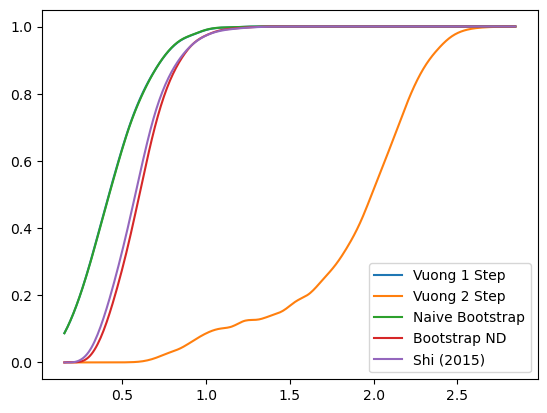

0.044721359549995794 0.09499340925884842


In [13]:
nobs = 500
c1,c2 = calc_c(nobs)

mc_run_power(nobs,c1,c2)
print(c1,c2)